In [1]:
#imports
import pandas as pd
#import yaml
from datetime import date,datetime
import pandas as pd
import matplotlib.pyplot as plt
from segmented_monte_carlo import SegmentedMonteCarlo
from segmented_monte_carlo_multinominal import SegmentedMonteCarlo
from joblib import Parallel, delayed, parallel_backend
import numpy as np
import multiprocessing as mp
import re
import json
import glob
import argparse
import datetime, time
import seaborn as sns
from datetime import datetime
import math
import random
from tqdm import tqdm
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from numpy import nan
from collections import defaultdict
from sympy.utilities.iterables import multiset_permutations
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
def create_arg_parser():
    parser = argparse.ArgumentParser(description='Please enter the file path to data source with the -d option. Load a preprocesed dataframe with the -r option.')
    parser.add_argument('-d', type=str, default="./data/T20I/", help='file path to data directory')
    parser.add_argument('-o', type=int, default=20, help='give the number of overs in a game')
    parser.add_argument('-w', type=int, default=10, help='give the number of max wickets in a game')
    parser.add_argument('-r', dest='df', action='store_true', help='reload a preprocessed dataframe as data source')
    parser.set_defaults(df=False)
    return parser
args=create_arg_parser().parse_args("")

In [3]:
match_data=pd.read_csv(args.d+"stats/game_stats.csv")
game_table=pd.read_csv(args.d+"stats/game_table.csv")
score_1=match_data.groupby(['team_1'])["score_1"].mean().sort_values()
score_2=match_data.groupby(['team_2'])["score_2"].mean().sort_values()

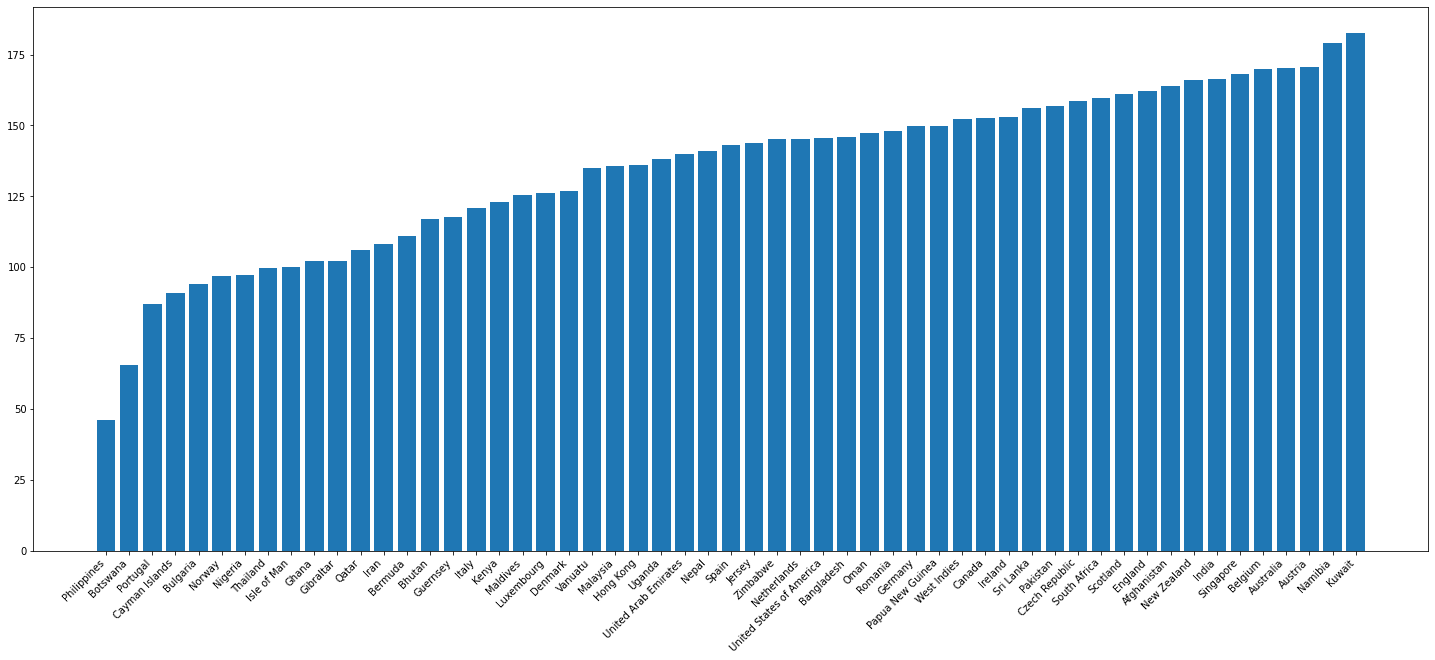

In [4]:
fig,ax=plt.subplots(figsize=(25,10))
plt.bar(score_1.index,score_1)
plt.xticks(rotation=45, ha='right')
plt.show()

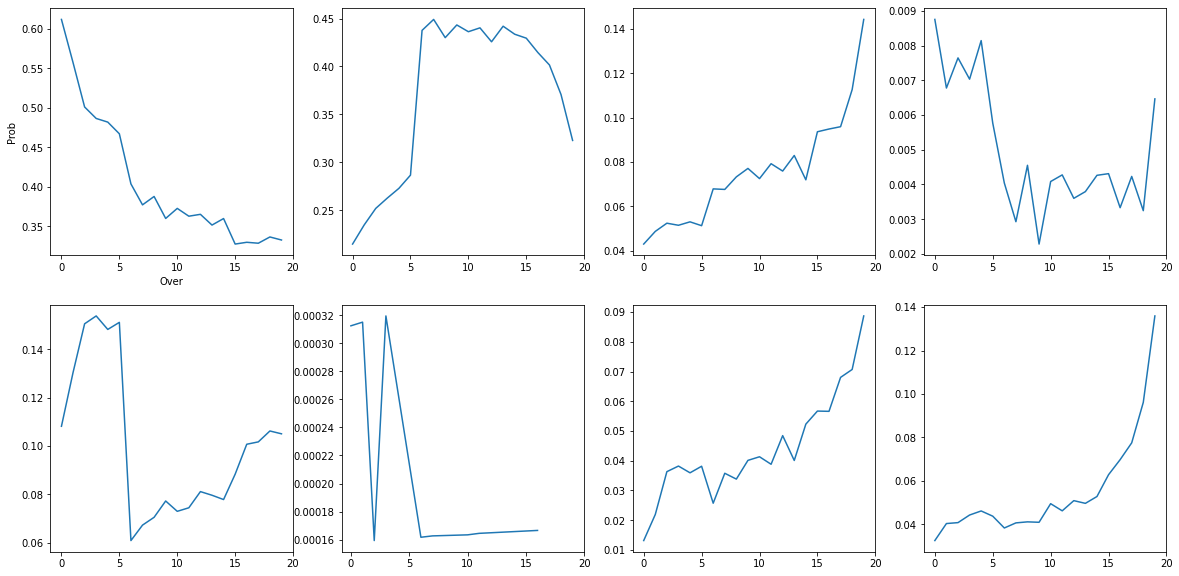

In [5]:
g=game_table[game_table.innings==1].groupby("overs")
r=g.runs_off_bat.value_counts(normalize=True)
ro=pd.DataFrame(r)
ro.index = ro.index.set_names(['over', 'rob'])
ro.reset_index(inplace=True)
w=g.wicket_scored.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
fig,ax=plt.subplots(2,4,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6]
for i in pos:
    ax[i//4,i%4].plot(ro[ro.rob==i].over,ro[ro.rob==i].runs_off_bat)
    ax[i//4,i%4].xaxis.set_ticks(np.arange(0, 21, 5))
ax[1,3].plot(wo[wo.ws].over,wo[wo.ws].wicket_scored)
ax[1,3].xaxis.set_ticks(np.arange(0, 21, 5))
plt.show()

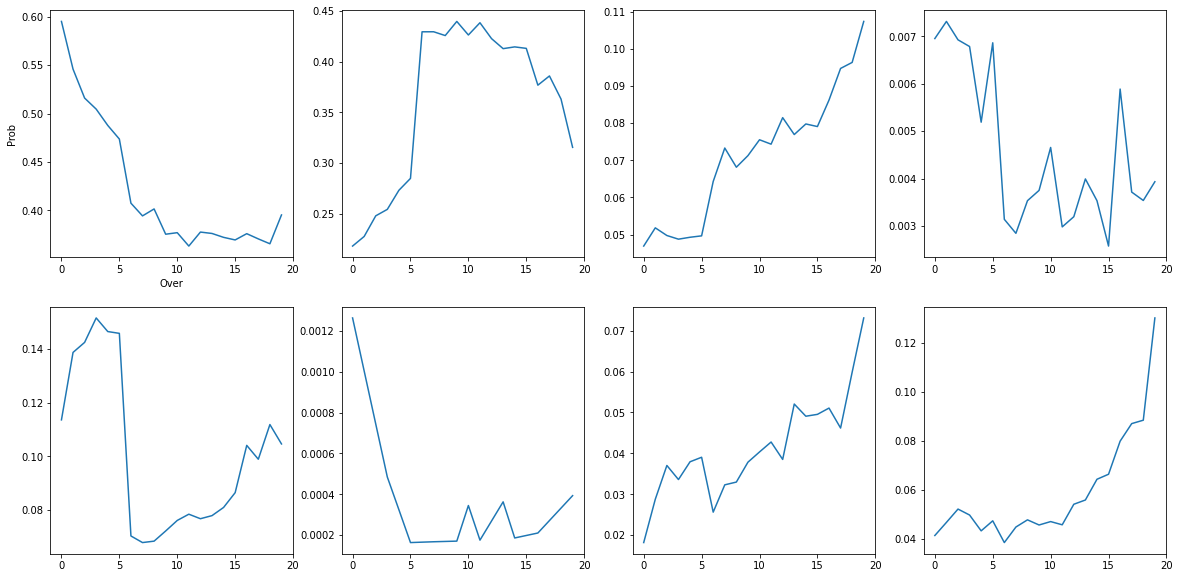

In [6]:
g=game_table[game_table.innings==2].groupby("overs")
r=g.runs_off_bat.value_counts(normalize=True)
ro=pd.DataFrame(r)
ro.index = ro.index.set_names(['over', 'rob'])
ro.reset_index(inplace=True)
w=g.wicket_scored.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
fig,ax=plt.subplots(2,4,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6]
for i in pos:
    ax[i//4,i%4].plot(ro[ro.rob==i].over,ro[ro.rob==i].runs_off_bat)
    ax[i//4,i%4].xaxis.set_ticks(np.arange(0, 21, 5))
ax[1,3].plot(wo[wo.ws].over,wo[wo.ws].wicket_scored)
ax[1,3].xaxis.set_ticks(np.arange(0, 21, 5))
plt.show()

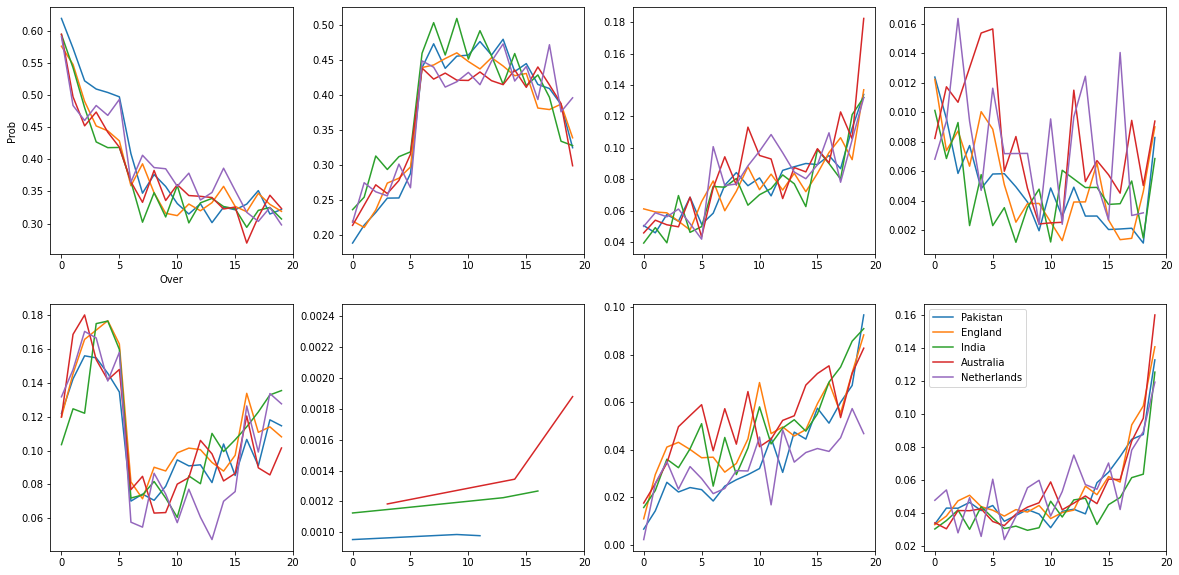

In [7]:
fig,ax=plt.subplots(2,4,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
for t in ["Pakistan","England","India","Australia","Netherlands"]:
    g=game_table[game_table.batting_team==t].groupby("overs")
    r=g.runs_off_bat.value_counts(normalize=True)
    ro=pd.DataFrame(r)
    ro.index = ro.index.set_names(['over', 'rob'])
    ro.reset_index(inplace=True)
    w=g.wicket_scored.value_counts(normalize=True)
    wo=pd.DataFrame(w)
    wo.index = wo.index.set_names(['over', 'ws'])
    wo.reset_index(inplace=True)
    pos=[0,1,2,3,4,5,6]
    for i in pos:
        ax[i//4,i%4].plot(ro[ro.rob==i].over,ro[ro.rob==i].runs_off_bat)
        ax[i//4,i%4].xaxis.set_ticks(np.arange(0, 21, 5))
    ax[1,3].plot(wo[wo.ws].over,wo[wo.ws].wicket_scored)
    ax[1,3].xaxis.set_ticks(np.arange(0, 21, 5))
plt.legend(["Pakistan","England","India","Australia","Netherlands"])
plt.show()

     over    ws  wickets_remain
0       0  10.0        0.922632
1       0   9.0        0.074711
2       0   8.0        0.002657
3       1  10.0        0.734752
4       1   9.0        0.231206
..    ...   ...             ...
161    19   1.0        0.077752
162    19   7.0        0.068594
163    19   8.0        0.026396
164    19   9.0        0.003053
165    19  10.0        0.000539

[166 rows x 3 columns]
     over    ws  wickets_remain
0       0  10.0        0.903318
1       0   9.0        0.091469
2       0   8.0        0.005213
3       1  10.0        0.683834
4       1   9.0        0.257352
..    ...   ...             ...
163    19   5.0        0.128982
164    19   6.0        0.051907
165    19   7.0        0.038144
166    19   8.0        0.006292
167    19   9.0        0.003146

[168 rows x 3 columns]


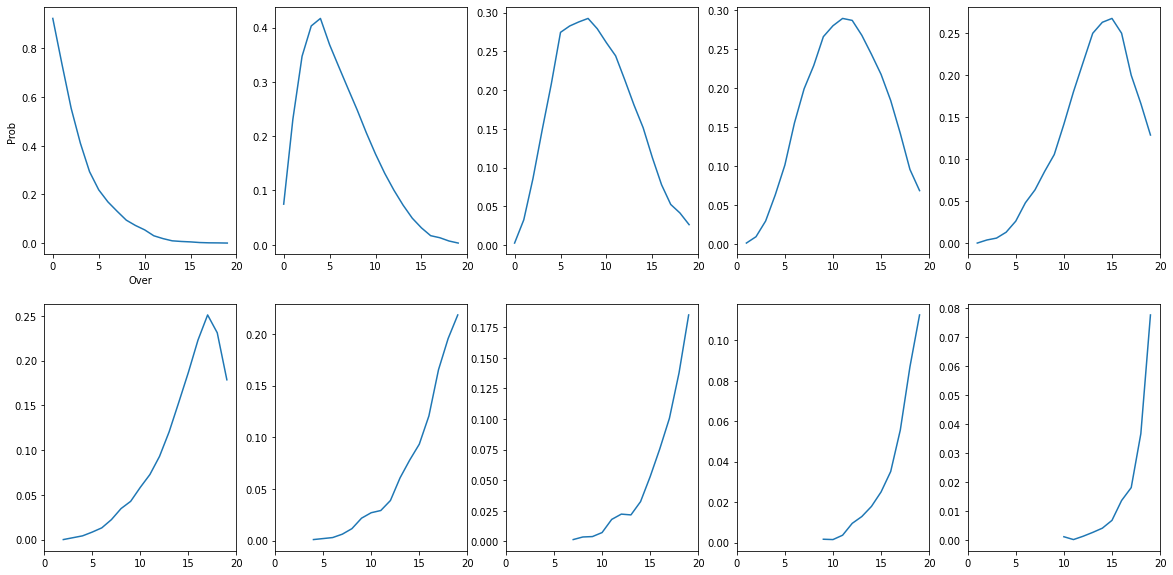

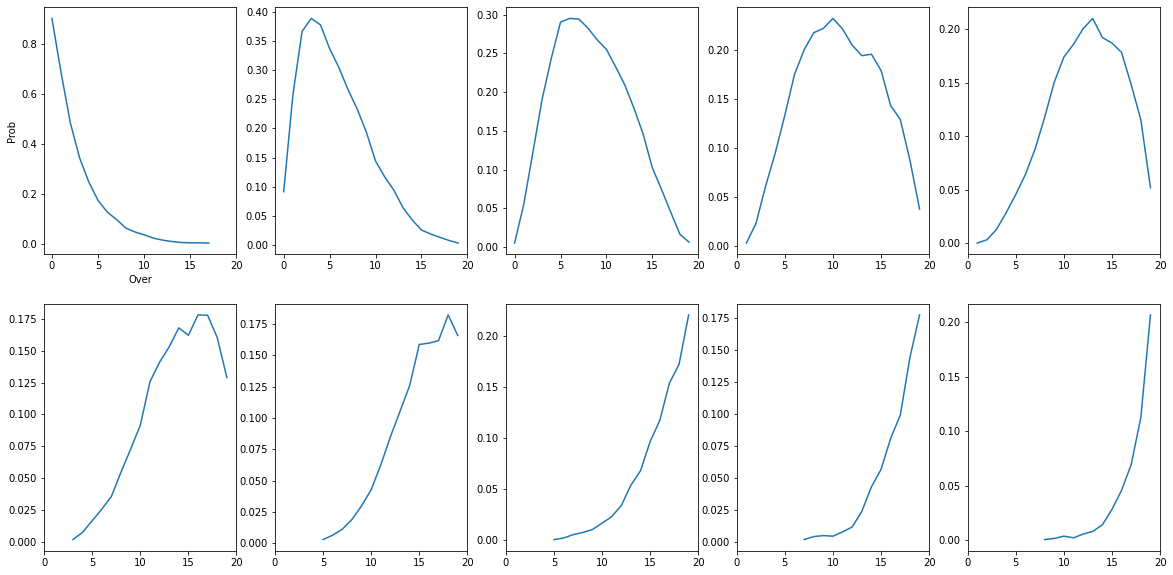

In [8]:
g=game_table[game_table.innings==1].groupby("overs")
w=g.wickets_remain.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
print(wo)
fig,ax=plt.subplots(2,5,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6,7,8,9]
for i in pos:
    ax[i//5,i%5].plot(wo[10-wo.ws==i].over,wo[10-wo.ws==i].wickets_remain)
    ax[i//5,i%5].xaxis.set_ticks(np.arange(0, 21, 5))
g=game_table[game_table.innings==2].groupby("overs")
w=g.wickets_remain.value_counts(normalize=True)
wo=pd.DataFrame(w)
wo.index = wo.index.set_names(['over', 'ws'])
wo.reset_index(inplace=True)
print(wo)
fig,ax=plt.subplots(2,5,figsize=(20,10))
ax[0,0].set_ylabel("Prob")
ax[0,0].set_xlabel("Over")
pos=[0,1,2,3,4,5,6,7,8,9]
for i in pos:
    ax[i//5,i%5].plot(wo[10-wo.ws==i].over,wo[10-wo.ws==i].wickets_remain)
    ax[i//5,i%5].xaxis.set_ticks(np.arange(0, 21, 5))
plt.show()

In [9]:
over_segments=[0,6,11,14,17,20]
def team_test(bowlers,strikers,mint=100,maxt=250,overs=20,num_iter=1000):
    monte_carlo = SegmentedMonteCarlo(d="./data/T20I/", num_iter=num_iter)
    r = 0
    b = 120
    w = 10
    rrr = 0
    sr = 0
    sr_two = 0
    extras_strikers=strikers["extras_striker"].values
    extras_bowlers=bowlers["extras_bowler"].values
    players_wb = strikers["wb"].values
    players_sr = strikers["strike_rate"].values
    players_av = strikers["striker_average"].values
    econ=bowlers["economy"].values
    probs = []
    job = (r, b, w, rrr, sr, sr_two, players_wb, econ, players_sr, players_av, extras_strikers, extras_bowlers, 1,
           len(over_segments) - 1)
    #print(job)
    results = monte_carlo.simulate_segment(job)
    # print(probs)
    # t = time.time()
    # jobs=[]
    # for t in range(mint,maxt):
    #    jobs.append((t, b, w, rrr, sr, sr_two, players_wb, bow, players_sr, players_av, extras_strikers, extras_bowlers, 2, len(over_segments) - 1))
    # with parallel_backend('loky', n_jobs=num_cores):
    #    prob = Parallel()(delayed(monte_carlo.simulate_segment)(j,True) for j in jobs)
    # print(time.time()-t)
    # print(prob)
    # print(np.array(probs)-np.array(prob))
    return results

In [10]:
def chase_prob(bowlers,strikers,mint=100,maxt=250,overs=20):
    monte_carlo = SegmentedMonteCarlo(d="./data/allT20/", num_iter=1000)
    r = 0
    b = 120
    w = 10
    rrr = 0
    sr = 0
    sr_two = 0
    extras_strikers=strikers["extras_striker"]
    extras_bowlers=bowlers["extras_bowler"]
    players_wb = strikers["wb"]
    players_sr = strikers["strike_rate"]
    players_av = strikers["striker_average"]
    econ=bowlers["economy"]
    probs = []
    for r in range(mint,maxt,2):
        rrr=r/b
        job = (r, b, w, rrr, sr, sr_two, players_wb, econ, players_sr, players_av, extras_strikers, extras_bowlers, 2,
               len(over_segments) - 1)
        results = monte_carlo.simulate_segment(job)
        p = len(results[results<0]) / len(results)
        probs.append(p)
        #print(probs)
    return probs

In [11]:
def get_game_stats(players, strikers=True, team="",min_dismissed=5,date=None):
    columns=["player","team","games_played","runs","balls_striker","dismissed","extras_striker","strike_rate","wb","striker_average","concived_runs","balls_bowler","extras_bowler","economy","positions_striker","positions_bowler"]
    stats=pd.DataFrame(columns=columns)
    stats["player"]=players
    stats["team"]=[team for i in range(len(stats))]
    if strikers:
        for s in players:
            runs=runs_sheet[s][runs_sheet.date<date].sum()
            stats["runs"][stats["player"]==s]=runs
            balls=balls_sheet[s][balls_sheet.date<date].sum()
            stats["balls_striker"][stats["player"]==s]=balls
            stats["games_played"][stats["player"]==s]=balls_sheet[s].count()
            dismissed=dismissed_sheet[s][dismissed_sheet.date<date].sum()
            stats["dismissed"][stats["player"]==s]=dismissed
            extras=extras_striker_sheet[s][extras_striker_sheet.date<date].sum()/balls
            stats["extras_striker"][stats["player"]==s]=extras
            sr=runs/balls*100
            stats["strike_rate"][stats["player"]==s]=sr
            wb=balls/dismissed
            stats["wb"][stats["player"]==s]=wb
            avg=runs/dismissed
            stats["striker_average"][stats["player"]==s]=avg
            stats["positions_striker"][stats["player"]==s]=positions_striker_sheet[s]
        while len(stats)<11:
            stats=stats.append(stats.iloc[np.random.randint(0,len(stats))])
        stats["wb"]=stats["wb"].astype(np.float)
        stats["strike_rate"]=stats["strike_rate"].astype(np.float)
        stats["extras_striker"]=stats["extras_striker"].astype(np.float)
        stats["striker_average"]=stats["striker_average"].astype(np.float)
        return stats
    else:
        for b in players:
            #print(positions_bowler_sheet[b].value_counts())
            concived=concived_runs_sheet[b][concived_runs_sheet.date<date].sum()
            stats["concived_runs"][stats["player"]==b]=concived
            balls_bowler=balls_bowler_sheet[b][balls_bowler_sheet.date<date].sum()
            stats["balls_bowler"][stats["player"]==b]=balls_bowler
            extras_bowler=extras_bowler_sheet[b][extras_bowler_sheet.date<date].sum()/balls_bowler
            stats["extras_bowler"][stats["player"]==b]=extras_bowler
            er=concived/(balls_bowler/6)
            stats["economy"][stats["player"]==b]=er
        while len(stats)<11:
            stats=stats.append(stats.iloc[np.random.randint(0,len(stats))]) 
        stats["economy"]=stats["economy"].astype(np.float)
        stats["extras_bowler"]=stats["extras_bowler"].astype(np.float)
        return stats
t20i_path=args.d
runs_sheet=pd.read_csv(t20i_path+"/stats/runs_player_stats.csv")
balls_sheet=pd.read_csv(t20i_path+"/stats/balls_player_stats.csv")
dismissed_sheet=pd.read_csv(t20i_path+"/stats/dismissed_player_stats.csv")
concived_runs_sheet=pd.read_csv(t20i_path+"/stats/concived_runs_player_stats.csv")
balls_bowler_sheet=pd.read_csv(t20i_path+"/stats/balls_bowl_player_stats.csv")
extras_striker_sheet=pd.read_csv(t20i_path+"/stats/extras_striker_player_stats.csv")
extras_bowler_sheet=pd.read_csv(t20i_path+"/stats/extras_bowler_player_stats.csv")
positions_striker_sheet=pd.read_csv(t20i_path+"/stats/striker_position_player_stats.csv")
positions_bowler_sheet=pd.read_csv(t20i_path+"/stats/bowler_position_player_stats.csv")

In [12]:
game_table=pd.read_csv(args.d+"/stats/game_table_norm.csv")
print(game_table.info())
g = game_table[game_table.rain==False]
g = g[game_table.runs_off_bat != 7]
g = g[g.games_striker > 3]
g = g[g.games_bowler > 3]
print(g.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231761 entries, 0 to 231760
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              231761 non-null  int64  
 1   Unnamed: 0.1            231761 non-null  int64  
 2   match_id                231761 non-null  int64  
 3   season                  231761 non-null  object 
 4   start_date              231761 non-null  object 
 5   venue                   231761 non-null  object 
 6   innings                 231761 non-null  int64  
 7   ball                    231761 non-null  float64
 8   batting_team            231761 non-null  object 
 9   bowling_team            231761 non-null  object 
 10  striker                 231761 non-null  object 
 11  non_striker             231761 non-null  object 
 12  bowler                  231761 non-null  object 
 13  runs_off_bat            231761 non-null  int64  
 14  extras              

In [13]:
over_segments=[0,6,11,17,20]
def team_test(bowlers,strikers,mint=100,maxt=250,overs=20,num_iter=1000):
    monte_carlo = SegmentedMonteCarlo(d="./data/T20I/", num_iter=num_iter)
    r = 0
    b = 120
    w = 10
    rrr = 0
    sr = 0
    sr_two = 0
    extras_strikers=strikers["extras_striker"].values
    extras_bowlers=bowlers["extras_bowler"].values
    players_wb = strikers["w_b"].values
    players_sr = strikers["s_r_career"].values
    players_av = strikers["Av_career"].values
    econ=bowlers["e_r_career"].values
    pf=strikers["striker_performance"].values
    probs = []
    job = (r, b, w, rrr, sr, sr_two, players_wb, econ, players_sr, players_av,pf, extras_strikers, extras_bowlers, 1,
           len(over_segments) - 1)
    #print(job)
    results = monte_carlo.simulate_segment(job)
    # print(probs)
    # t = time.time()
    # jobs=[]
    # for t in range(mint,maxt):
    #    jobs.append((t, b, w, rrr, sr, sr_two, players_wb, bow, players_sr, players_av, extras_strikers, extras_bowlers, 2, len(over_segments) - 1))
    # with parallel_backend('loky', n_jobs=num_cores):
    #    prob = Parallel()(delayed(monte_carlo.simulate_segment)(j,True) for j in jobs)
    # print(time.time()-t)
    # print(prob)
    # print(np.array(probs)-np.array(prob))
    return results

[214 209 221 171 138 141 189 164 218 153 188 157 186  74 166 191  97 203
 145 166 182 150 169 180 159 175 153 159 149 132 149 162 108 172 179 127
 172 186 191  84 141 147 184 168 148 163 191 147 167 162 126  89 161 153
 105 129 133 157 147 111 140 120 168 168 143 183 165 119 159 147 171 131
 159 200 120 198 141 123 144 159  93 177 170 140 128 149 152 135 135 149
 114 122 155 177 248 144 195  89 151 168 137 133 192 113 130 168 172 213
 195 135 201  98 161 179 130 163 140 130 191  39 178 151 190 159 133 130
 176  96 144 141 175 172 175 191 172 149 157 178 145 188 184 197 199  92
 171 168 136 136 153 190 131 158 147  59 201 118 146 193 160 192 163 187
 180 101 196 166  83 129 157 263 168 173 187 170  99 138 147 144 202 160
 132 137 190 105 201 181 197 174 183 118 118 148 202  67 180 203 188 172
 180 260 204 166 174 176 120 203 205 208 213 174 144 160 182 116 229 162
 194 151 183 132 168 158 132 164 173 155 147 150 148 166 195 126 190 132
 182 233 107 150 106 196 193 134 148 174 170 240 17

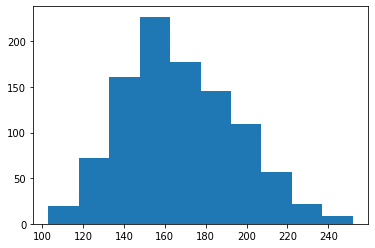

287870
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.086918    0.304245   
1            NaN             NaN NaN NaN  0.124194    0.332317   
2            NaN             NaN NaN NaN  0.199309    0.363889   
3            NaN             NaN NaN NaN  0.287097    0.418033   
4            NaN             NaN NaN NaN  0.120968    0.304878   
5            NaN             NaN NaN NaN  0.129032    0.302083   
6            NaN             NaN NaN NaN  0.100358    0.357843   
7            NaN             NaN NaN NaN  0.100358    0.328435   
8            NaN             NaN NaN NaN  0.100358    0.328435   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.090147        0.056604   0.090147  
1              0.137107        0.036585   0.137107  
2              0.235400        0.041667  

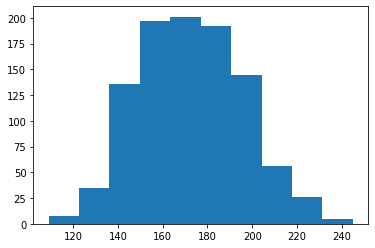

287876
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.238479    0.289720   
1            NaN             NaN NaN NaN  0.155914    0.270492   
2            NaN             NaN NaN NaN  0.118280    0.265957   
3            NaN             NaN NaN NaN  0.274194    0.342857   
4            NaN             NaN NaN NaN  0.141705    0.286538   
5            NaN             NaN NaN NaN  0.212903    0.270073   
6            NaN             NaN NaN NaN  0.193548    0.245000   
7            NaN             NaN NaN NaN  0.100358    0.328435   
8            NaN             NaN NaN NaN  0.100358    0.328435   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.222821        0.070093   0.222821  
1              0.138365        0.077869   0.138365  
2              0.104822        0.031915  

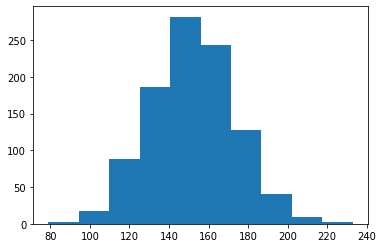

287878
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.238479    0.289720   
1            NaN             NaN NaN NaN  0.155914    0.270492   
2            NaN             NaN NaN NaN  0.141705    0.286538   
3            NaN             NaN NaN NaN  0.185484    0.453125   
4            NaN             NaN NaN NaN  0.212903    0.270073   
5            NaN             NaN NaN NaN  0.274194    0.342857   
6            NaN             NaN NaN NaN  0.193548    0.245000   
7            NaN             NaN NaN NaN  0.100358    0.328435   
8            NaN             NaN NaN NaN  0.100358    0.328435   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.222821        0.070093   0.222821  
1              0.138365        0.077869   0.138365  
2              0.133872        0.023077  

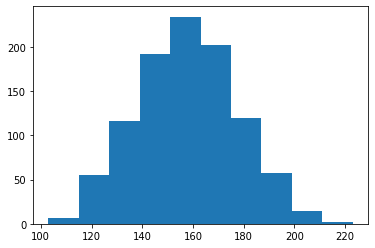

287879
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.238479    0.289720   
1            NaN             NaN NaN NaN  0.141705    0.286538   
2            NaN             NaN NaN NaN  0.185484    0.453125   
3            NaN             NaN NaN NaN  0.212903    0.270073   
4            NaN             NaN NaN NaN  0.274194    0.342857   
5            NaN             NaN NaN NaN  0.274194    0.342857   
6            NaN             NaN NaN NaN  0.193548    0.245000   
7            NaN             NaN NaN NaN  0.100358    0.328435   
8            NaN             NaN NaN NaN  0.100358    0.328435   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.222821        0.070093   0.222821  
1              0.133872        0.023077   0.133872  
2              0.273585        0.046875  

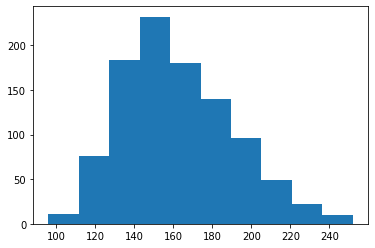

291343
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.086918    0.304245   
1            NaN             NaN NaN NaN  0.151882    0.308824   
2            NaN             NaN NaN NaN  0.124194    0.304878   
3            NaN             NaN NaN NaN  0.287097    0.418033   
4            NaN             NaN NaN NaN  0.129032    0.357843   
5            NaN             NaN NaN NaN  0.274194    0.342857   
6            NaN             NaN NaN NaN  0.193548    0.245000   
7            NaN             NaN NaN NaN  0.100358    0.328435   
8            NaN             NaN NaN NaN  0.100358    0.328435   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.090147        0.056604   0.090147  
1              0.154088        0.025210   0.154088  
2              0.125786        0.006098  

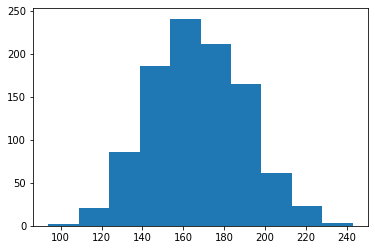

297800
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.086918    0.304245   
1            NaN             NaN NaN NaN  0.178427    0.355405   
2            NaN             NaN NaN NaN  0.124194    0.332317   
3            NaN             NaN NaN NaN  0.287097    0.418033   
4            NaN             NaN NaN NaN  0.120968    0.302083   
5            NaN             NaN NaN NaN  0.177419    0.273292   
6            NaN             NaN NaN NaN  0.108871    0.137931   
7            NaN             NaN NaN NaN  0.100358    0.328435   
8            NaN             NaN NaN NaN  0.100358    0.328435   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.090147        0.056604   0.090147  
1              0.206761        0.043243   0.206761  
2              0.137107        0.036585  

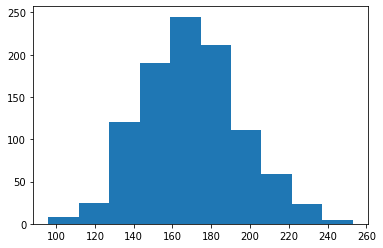

343764
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.150000    0.232143   
1            NaN             NaN NaN NaN  0.064516    0.233333   
2            NaN             NaN NaN NaN  0.370968    0.321809   
3            NaN             NaN NaN NaN  0.148185    0.351613   
4            NaN             NaN NaN NaN  0.158266    0.315152   
5            NaN             NaN NaN NaN  0.073733    0.348592   
6            NaN             NaN NaN NaN  0.108871    0.137931   
7            NaN             NaN NaN NaN  0.100358    0.328435   
8            NaN             NaN NaN NaN  0.100358    0.328435   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.114465        0.040816   0.114465  
1              0.052830        0.088889   0.052830  
2              0.380503        0.023936  

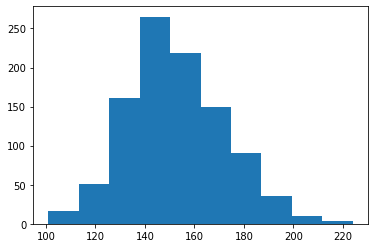

350475
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.163594    0.352349   
1            NaN             NaN NaN NaN  0.182796    0.251174   
2            NaN             NaN NaN NaN  0.181085    0.337209   
3            NaN             NaN NaN NaN  0.155530    0.360915   
4            NaN             NaN NaN NaN  0.108423    0.309615   
5            NaN             NaN NaN NaN  0.131048    0.228261   
6            NaN             NaN NaN NaN  0.217742    0.369643   
7            NaN             NaN NaN NaN  0.233871    0.425000   
8            NaN             NaN NaN NaN  0.161290    0.273810   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.188679        0.026846   0.188679  
1              0.149546        0.030516   0.149546  
2              0.198971        0.042636  

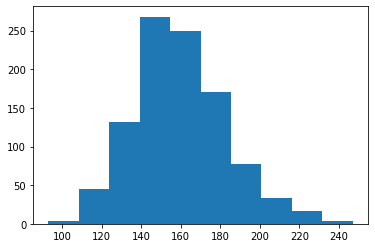

351694
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.163594    0.352349   
1            NaN             NaN NaN NaN  0.181085    0.337209   
2            NaN             NaN NaN NaN  0.155530    0.360915   
3            NaN             NaN NaN NaN  0.217742    0.369643   
4            NaN             NaN NaN NaN  0.108423    0.309615   
5            NaN             NaN NaN NaN  0.161290    0.273810   
6            NaN             NaN NaN NaN  0.021505    0.272727   
7            NaN             NaN NaN NaN  0.233871    0.425000   
8            NaN             NaN NaN NaN  0.161290    0.273810   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.188679        0.026846   0.188679  
1              0.198971        0.042636   0.198971  
2              0.184187        0.007042  

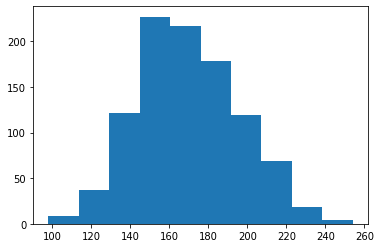

351696
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.163594    0.352349   
1            NaN             NaN NaN NaN  0.131048    0.228261   
2            NaN             NaN NaN NaN  0.155530    0.360915   
3            NaN             NaN NaN NaN  0.217742    0.369643   
4            NaN             NaN NaN NaN  0.161290    0.273810   
5            NaN             NaN NaN NaN  0.161290    0.273810   
6            NaN             NaN NaN NaN  0.021505    0.272727   
7            NaN             NaN NaN NaN  0.233871    0.425000   
8            NaN             NaN NaN NaN  0.161290    0.273810   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.188679        0.026846   0.188679  
1              0.099057        0.021739   0.099057  
2              0.184187        0.007042  

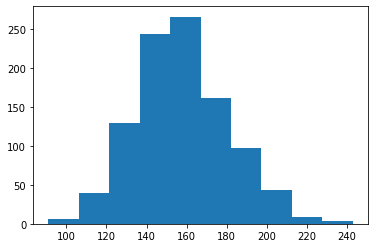

355993
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.145161    0.232456   
1            NaN             NaN NaN NaN  0.181085    0.337209   
2            NaN             NaN NaN NaN  0.182796    0.251174   
3            NaN             NaN NaN NaN  0.163594    0.352349   
4            NaN             NaN NaN NaN  0.131048    0.228261   
5            NaN             NaN NaN NaN  0.155530    0.360915   
6            NaN             NaN NaN NaN  0.108423    0.309615   
7            NaN             NaN NaN NaN  0.233871    0.425000   
8            NaN             NaN NaN NaN  0.104839    0.392857   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.111111        0.043860   0.111111  
1              0.198971        0.042636   0.198971  
2              0.149546        0.030516  

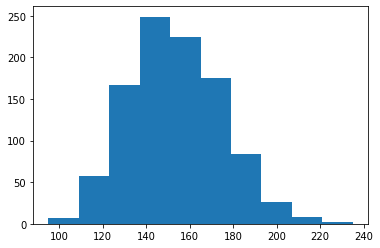

355994
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.226540    0.280469   
1            NaN             NaN NaN NaN  0.172043    0.326493   
2            NaN             NaN NaN NaN  0.237327    0.258216   
3            NaN             NaN NaN NaN  0.169355    0.409091   
4            NaN             NaN NaN NaN  0.131048    0.228261   
5            NaN             NaN NaN NaN  0.155530    0.360915   
6            NaN             NaN NaN NaN  0.108423    0.309615   
7            NaN             NaN NaN NaN  0.233871    0.425000   
8            NaN             NaN NaN NaN  0.104839    0.392857   
9            NaN             NaN NaN NaN  0.100358    0.328435   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.205260        0.053125   0.205260  
1              0.183438        0.026119   0.183438  
2              0.197664        0.025822  

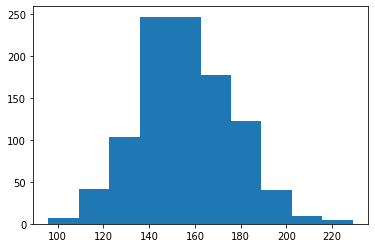

355998
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.145161    0.232456   
1            NaN             NaN NaN NaN  0.163594    0.352349   
2            NaN             NaN NaN NaN  0.181085    0.337209   
3            NaN             NaN NaN NaN  0.131048    0.228261   
4            NaN             NaN NaN NaN  0.182796    0.251174   
5            NaN             NaN NaN NaN  0.155530    0.360915   
6            NaN             NaN NaN NaN  0.108423    0.309615   
7            NaN             NaN NaN NaN  0.233871    0.425000   
8            NaN             NaN NaN NaN  0.104839    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.111111        0.043860   0.111111  
1              0.188679        0.026846   0.188679  
2              0.198971        0.042636  

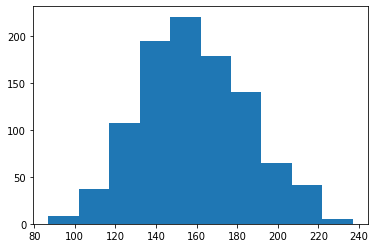

356006
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.178495    0.279539   
1            NaN             NaN NaN NaN  0.146169    0.303922   
2            NaN             NaN NaN NaN  0.149194    0.254274   
3            NaN             NaN NaN NaN  0.165995    0.392857   
4            NaN             NaN NaN NaN  0.230287    0.247180   
5            NaN             NaN NaN NaN  0.109677    0.417808   
6            NaN             NaN NaN NaN  0.185484    0.317708   
7            NaN             NaN NaN NaN  0.090726    0.255102   
8            NaN             NaN NaN NaN  0.104839    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.162683        0.051873   0.162683  
1              0.146226        0.029412   0.146226  
2              0.124738        0.051282  

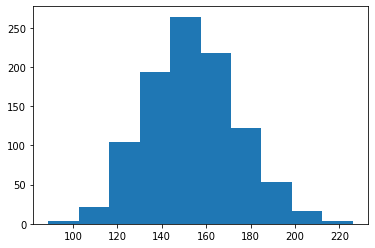

356015
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.159274    0.318524   
1            NaN             NaN NaN NaN  0.143145    0.256667   
2            NaN             NaN NaN NaN  0.145161    0.338596   
3            NaN             NaN NaN NaN  0.176843    0.279595   
4            NaN             NaN NaN NaN  0.167742    0.323394   
5            NaN             NaN NaN NaN  0.166667    0.311538   
6            NaN             NaN NaN NaN  0.185484    0.317708   
7            NaN             NaN NaN NaN  0.090726    0.255102   
8            NaN             NaN NaN NaN  0.104839    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.166274        0.028614   0.166274  
1              0.121069        0.040000   0.121069  
2              0.161845        0.031579  

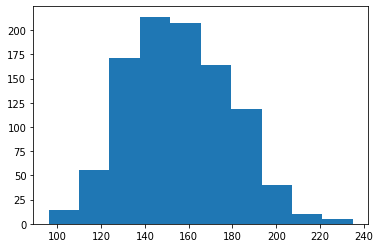

361660
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.153226    0.279545   
1            NaN             NaN NaN NaN  0.145161    0.338596   
2            NaN             NaN NaN NaN  0.167742    0.323394   
3            NaN             NaN NaN NaN  0.176843    0.279595   
4            NaN             NaN NaN NaN  0.319556    0.294615   
5            NaN             NaN NaN NaN  0.134409    0.367925   
6            NaN             NaN NaN NaN  0.159274    0.318524   
7            NaN             NaN NaN NaN  0.064516    0.277778   
8            NaN             NaN NaN NaN  0.104839    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.140652        0.040909   0.140652  
1              0.161845        0.031579   0.161845  
2              0.177358        0.022936  

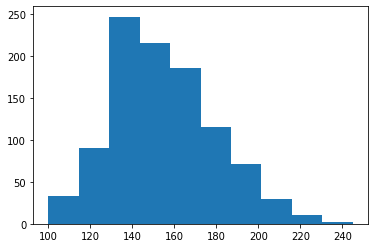

366622
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.178495    0.279539   
1            NaN             NaN NaN NaN  0.137097    0.317708   
2            NaN             NaN NaN NaN  0.149194    0.254274   
3            NaN             NaN NaN NaN  0.165995    0.392857   
4            NaN             NaN NaN NaN  0.230287    0.247180   
5            NaN             NaN NaN NaN  0.109677    0.417808   
6            NaN             NaN NaN NaN  0.166667    0.215385   
7            NaN             NaN NaN NaN  0.185484    0.277778   
8            NaN             NaN NaN NaN  0.104839    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.162683        0.051873   0.162683  
1              0.143868        0.065972   0.143868  
2              0.124738        0.051282  

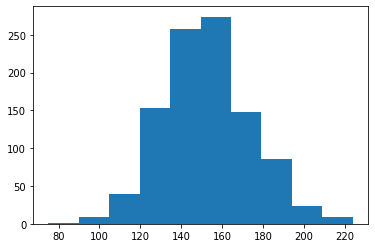

386494
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.178495    0.279539   
1            NaN             NaN NaN NaN  0.137097    0.317708   
2            NaN             NaN NaN NaN  0.149194    0.254274   
3            NaN             NaN NaN NaN  0.146169    0.303922   
4            NaN             NaN NaN NaN  0.165995    0.392857   
5            NaN             NaN NaN NaN  0.230287    0.247180   
6            NaN             NaN NaN NaN  0.109677    0.417808   
7            NaN             NaN NaN NaN  0.185484    0.255102   
8            NaN             NaN NaN NaN  0.090726    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.162683        0.051873   0.162683  
1              0.143868        0.065972   0.143868  
2              0.124738        0.051282  

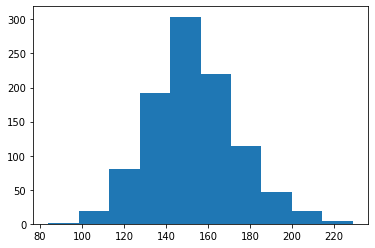

392615
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.132134    0.355088   
1            NaN             NaN NaN NaN  0.114055    0.260613   
2            NaN             NaN NaN NaN  0.137097    0.260417   
3            NaN             NaN NaN NaN  0.239247    0.415761   
4            NaN             NaN NaN NaN  0.167932    0.319407   
5            NaN             NaN NaN NaN  0.087097    0.372881   
6            NaN             NaN NaN NaN  0.051075    0.170455   
7            NaN             NaN NaN NaN  0.185484    0.255102   
8            NaN             NaN NaN NaN  0.090726    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.155298        0.017699   0.155298  
1              0.099281        0.023585   0.099281  
2              0.117925        0.027778  

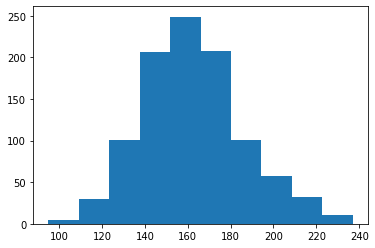

403375
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.169779    0.319212   
1            NaN             NaN NaN NaN  0.171371    0.275281   
2            NaN             NaN NaN NaN  0.159677    0.372596   
3            NaN             NaN NaN NaN  0.136649    0.331269   
4            NaN             NaN NaN NaN  0.299731    0.332969   
5            NaN             NaN NaN NaN  0.135484    0.289326   
6            NaN             NaN NaN NaN  0.319556    0.294615   
7            NaN             NaN NaN NaN  0.185484    0.255102   
8            NaN             NaN NaN NaN  0.090726    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.177094        0.033413   0.177094  
1              0.154088        0.018258   0.154088  
2              0.194969        0.033654  

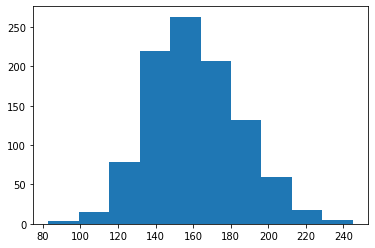

406197
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.132134    0.355088   
1            NaN             NaN NaN NaN  0.133701    0.366018   
2            NaN             NaN NaN NaN  0.170699    0.317669   
3            NaN             NaN NaN NaN  0.169355    0.241029   
4            NaN             NaN NaN NaN  0.189206    0.342767   
5            NaN             NaN NaN NaN  0.114055    0.260613   
6            NaN             NaN NaN NaN  0.056452    0.294643   
7            NaN             NaN NaN NaN  0.066129    0.331522   
8            NaN             NaN NaN NaN  0.090726    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.155298        0.017699   0.155298  
1              0.161867        0.028443   0.161867  
2              0.177149        0.022556  

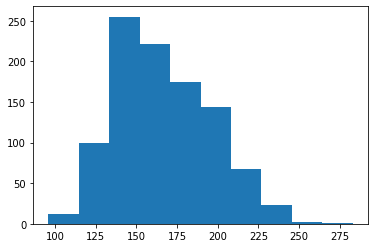

412680
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.162442    0.314752   
1            NaN             NaN NaN NaN  0.153226    0.268333   
2            NaN             NaN NaN NaN  0.130645    0.329942   
3            NaN             NaN NaN NaN  0.159946    0.280000   
4            NaN             NaN NaN NaN  0.319556    0.294615   
5            NaN             NaN NaN NaN  0.114055    0.260613   
6            NaN             NaN NaN NaN  0.056452    0.294643   
7            NaN             NaN NaN NaN  0.066129    0.331522   
8            NaN             NaN NaN NaN  0.090726    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.167415        0.031532   0.167415  
1              0.135010        0.050000   0.135010  
2              0.142767        0.031977  

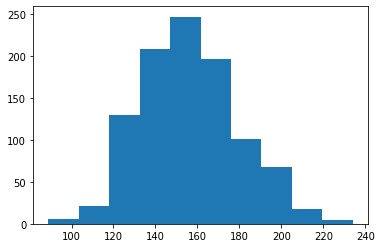

412682
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.130040    0.271898   
1            NaN             NaN NaN NaN  0.120968    0.281250   
2            NaN             NaN NaN NaN  0.174318    0.402211   
3            NaN             NaN NaN NaN  0.092742    0.406667   
4            NaN             NaN NaN NaN  0.217009    0.258958   
5            NaN             NaN NaN NaN  0.114055    0.260613   
6            NaN             NaN NaN NaN  0.056452    0.294643   
7            NaN             NaN NaN NaN  0.066129    0.331522   
8            NaN             NaN NaN NaN  0.090726    0.392857   
9            NaN             NaN NaN NaN  0.021505    0.272727   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.117138        0.043796   0.117138  
1              0.113208        0.031250   0.113208  
2              0.228834        0.042517  

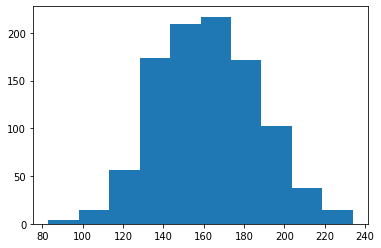

412683
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.133701    0.366018   
1            NaN             NaN NaN NaN  0.132134    0.355088   
2            NaN             NaN NaN NaN  0.169355    0.241029   
3            NaN             NaN NaN NaN  0.170699    0.317669   
4            NaN             NaN NaN NaN  0.165995    0.370656   
5            NaN             NaN NaN NaN  0.189206    0.342767   
6            NaN             NaN NaN NaN  0.114055    0.260613   
7            NaN             NaN NaN NaN  0.056452    0.294643   
8            NaN             NaN NaN NaN  0.066129    0.331522   
9            NaN             NaN NaN NaN  0.024194    0.208333   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.161867        0.028443   0.161867  
1              0.155298        0.017699   0.155298  
2              0.133400        0.026316  

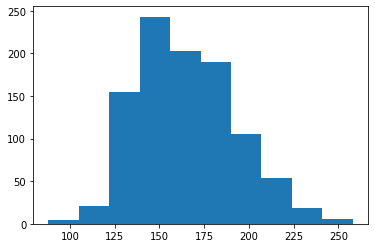

412688
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.137830    0.346106   
1            NaN             NaN NaN NaN  0.130040    0.365876   
2            NaN             NaN NaN NaN  0.168145    0.239703   
3            NaN             NaN NaN NaN  0.122581    0.263374   
4            NaN             NaN NaN NaN  0.165899    0.303532   
5            NaN             NaN NaN NaN  0.162802    0.331858   
6            NaN             NaN NaN NaN  0.165995    0.370656   
7            NaN             NaN NaN NaN  0.104839    0.313776   
8            NaN             NaN NaN NaN  0.066129    0.331522   
9            NaN             NaN NaN NaN  0.024194    0.208333   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.157519        0.027638   0.157519  
1              0.157626        0.014599   0.157626  
2              0.131761        0.026316  

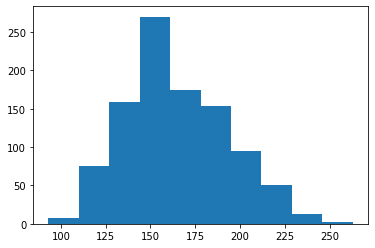

412689
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.162442    0.314752   
1            NaN             NaN NaN NaN  0.153226    0.268333   
2            NaN             NaN NaN NaN  0.145161    0.208333   
3            NaN             NaN NaN NaN  0.236290    0.308581   
4            NaN             NaN NaN NaN  0.127496    0.327195   
5            NaN             NaN NaN NaN  0.319556    0.294615   
6            NaN             NaN NaN NaN  0.173963    0.329114   
7            NaN             NaN NaN NaN  0.133065    0.292857   
8            NaN             NaN NaN NaN  0.050403    0.310345   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.167415        0.031532   0.167415  
1              0.135010        0.050000   0.135010  
2              0.099581        0.017544  

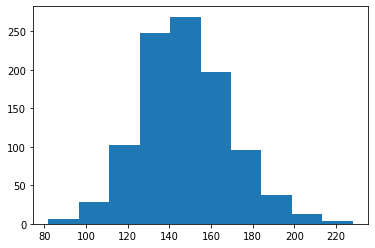

412691
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.130040    0.365876   
1            NaN             NaN NaN NaN  0.137830    0.346106   
2            NaN             NaN NaN NaN  0.165899    0.303532   
3            NaN             NaN NaN NaN  0.122581    0.263374   
4            NaN             NaN NaN NaN  0.162802    0.331858   
5            NaN             NaN NaN NaN  0.165995    0.370656   
6            NaN             NaN NaN NaN  0.173963    0.329114   
7            NaN             NaN NaN NaN  0.133065    0.292857   
8            NaN             NaN NaN NaN  0.050403    0.310345   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.157626        0.014599   0.157626  
1              0.157519        0.027638   0.157519  
2              0.164720        0.020971  

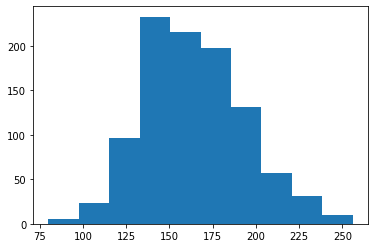

412696
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.130040    0.365876   
1            NaN             NaN NaN NaN  0.137830    0.346106   
2            NaN             NaN NaN NaN  0.122581    0.263374   
3            NaN             NaN NaN NaN  0.165899    0.303532   
4            NaN             NaN NaN NaN  0.162802    0.331858   
5            NaN             NaN NaN NaN  0.168145    0.239703   
6            NaN             NaN NaN NaN  0.165995    0.370656   
7            NaN             NaN NaN NaN  0.133065    0.292857   
8            NaN             NaN NaN NaN  0.050403    0.310345   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.157626        0.014599   0.157626  
1              0.157519        0.027638   0.157519  
2              0.107338        0.022634  

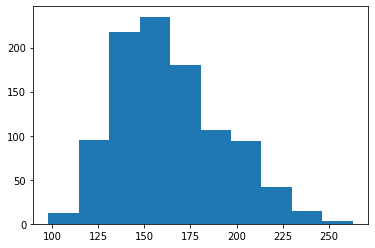

412697
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.162442    0.314752   
1            NaN             NaN NaN NaN  0.153226    0.268333   
2            NaN             NaN NaN NaN  0.167339    0.257184   
3            NaN             NaN NaN NaN  0.203474    0.296921   
4            NaN             NaN NaN NaN  0.117272    0.329759   
5            NaN             NaN NaN NaN  0.154839    0.306931   
6            NaN             NaN NaN NaN  0.285484    0.285714   
7            NaN             NaN NaN NaN  0.133065    0.292857   
8            NaN             NaN NaN NaN  0.050403    0.310345   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.167415        0.031532   0.167415  
1              0.135010        0.050000   0.135010  
2              0.140723        0.014368  

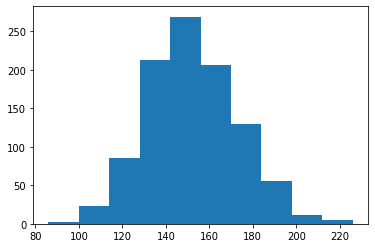

412699
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.120968    0.281250   
1            NaN             NaN NaN NaN  0.177894    0.295918   
2            NaN             NaN NaN NaN  0.174194    0.320796   
3            NaN             NaN NaN NaN  0.225073    0.257862   
4            NaN             NaN NaN NaN  0.182382    0.394951   
5            NaN             NaN NaN NaN  0.096774    0.361111   
6            NaN             NaN NaN NaN  0.285484    0.285714   
7            NaN             NaN NaN NaN  0.133065    0.292857   
8            NaN             NaN NaN NaN  0.050403    0.310345   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.113208        0.031250   0.113208  
1              0.171661        0.047194   0.171661  
2              0.182390        0.039823  

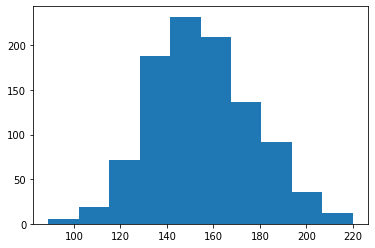

412702
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.162442    0.314752   
1            NaN             NaN NaN NaN  0.153226    0.268333   
2            NaN             NaN NaN NaN  0.205141    0.289598   
3            NaN             NaN NaN NaN  0.111410    0.339375   
4            NaN             NaN NaN NaN  0.152493    0.326484   
5            NaN             NaN NaN NaN  0.096774    0.361111   
6            NaN             NaN NaN NaN  0.285484    0.285714   
7            NaN             NaN NaN NaN  0.133065    0.292857   
8            NaN             NaN NaN NaN  0.050403    0.310345   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.167415        0.031532   0.167415  
1              0.135010        0.050000   0.135010  
2              0.192610        0.036643  

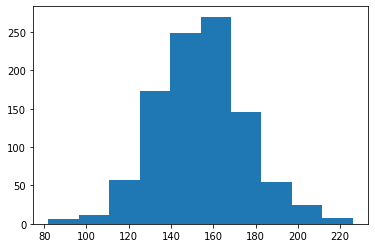

412703
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.130040    0.365876   
1            NaN             NaN NaN NaN  0.168145    0.239703   
2            NaN             NaN NaN NaN  0.137830    0.346106   
3            NaN             NaN NaN NaN  0.122581    0.263374   
4            NaN             NaN NaN NaN  0.165899    0.303532   
5            NaN             NaN NaN NaN  0.162802    0.331858   
6            NaN             NaN NaN NaN  0.165995    0.370656   
7            NaN             NaN NaN NaN  0.104839    0.313776   
8            NaN             NaN NaN NaN  0.050403    0.310345   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.157626        0.014599   0.157626  
1              0.131761        0.026316   0.131761  
2              0.157519        0.027638  

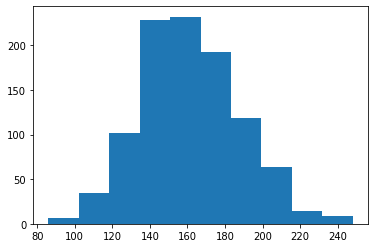

426392
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.153226    0.268333   
1            NaN             NaN NaN NaN  0.099194    0.218045   
2            NaN             NaN NaN NaN  0.162442    0.314752   
3            NaN             NaN NaN NaN  0.164261    0.273399   
4            NaN             NaN NaN NaN  0.111410    0.339375   
5            NaN             NaN NaN NaN  0.205141    0.289598   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.050403    0.310345   
8            NaN             NaN NaN NaN  0.075605    0.231928   
9            NaN             NaN NaN NaN  0.104839    0.196429   
10           NaN             NaN NaN NaN  0.100358    0.328435   

    striker_performance  extras_striker  Av_career  
0              0.135010        0.050000   0.135010  
1              0.072956        0.033835   0.072956  
2              0.167415        0.031532  

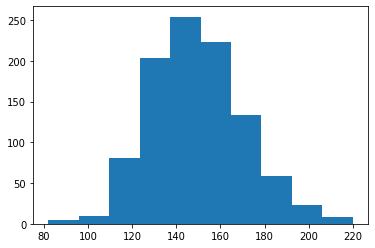

426393
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.099194    0.218045   
1            NaN             NaN NaN NaN  0.162442    0.314752   
2            NaN             NaN NaN NaN  0.153226    0.268333   
3            NaN             NaN NaN NaN  0.164261    0.273399   
4            NaN             NaN NaN NaN  0.205141    0.289598   
5            NaN             NaN NaN NaN  0.111410    0.339375   
6            NaN             NaN NaN NaN  0.050403    0.310345   
7            NaN             NaN NaN NaN  0.152493    0.326484   
8            NaN             NaN NaN NaN  0.075605    0.231928   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.072956        0.033835   0.072956  
1              0.167415        0.031532   0.167415  
2              0.135010        0.050000  

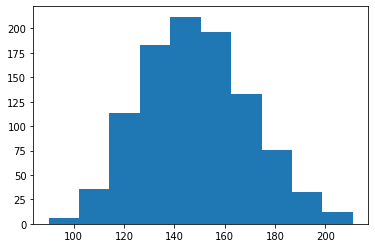

426417
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.162442    0.314752   
1            NaN             NaN NaN NaN  0.099194    0.218045   
2            NaN             NaN NaN NaN  0.127240    0.286424   
3            NaN             NaN NaN NaN  0.205141    0.289598   
4            NaN             NaN NaN NaN  0.111410    0.339375   
5            NaN             NaN NaN NaN  0.111410    0.339375   
6            NaN             NaN NaN NaN  0.050403    0.310345   
7            NaN             NaN NaN NaN  0.152493    0.326484   
8            NaN             NaN NaN NaN  0.075605    0.231928   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.167415        0.031532   0.167415  
1              0.072956        0.033835   0.072956  
2              0.120894        0.003311  

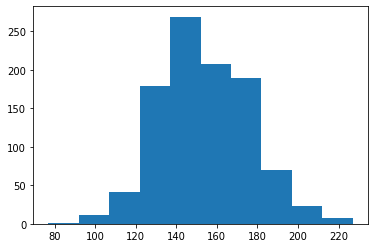

440945
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.153226    0.342187   
1            NaN             NaN NaN NaN  0.079301    0.230769   
2            NaN             NaN NaN NaN  0.195671    0.291146   
3            NaN             NaN NaN NaN  0.152126    0.272311   
4            NaN             NaN NaN NaN  0.127240    0.286424   
5            NaN             NaN NaN NaN  0.152493    0.326484   
6            NaN             NaN NaN NaN  0.125000    0.356061   
7            NaN             NaN NaN NaN  0.069892    0.250000   
8            NaN             NaN NaN NaN  0.075605    0.231928   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.172170        0.028125   0.172170  
1              0.062893        0.038462   0.062893  
2              0.185038        0.033333  

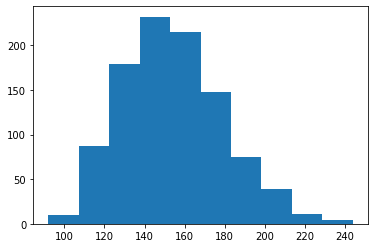

446956
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.127086    0.335905   
1            NaN             NaN NaN NaN  0.168145    0.239703   
2            NaN             NaN NaN NaN  0.140068    0.372493   
3            NaN             NaN NaN NaN  0.149333    0.291961   
4            NaN             NaN NaN NaN  0.119456    0.259881   
5            NaN             NaN NaN NaN  0.164113    0.329625   
6            NaN             NaN NaN NaN  0.114516    0.269737   
7            NaN             NaN NaN NaN  0.069892    0.250000   
8            NaN             NaN NaN NaN  0.075605    0.231928   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.141618        0.031893   0.141618  
1              0.131761        0.026316   0.131761  
2              0.172128        0.021490  

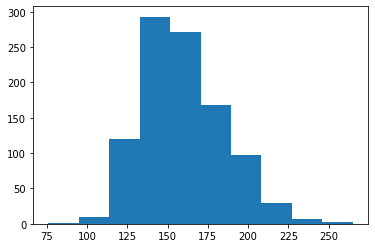

446960
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.140068    0.372493   
1            NaN             NaN NaN NaN  0.127086    0.335905   
2            NaN             NaN NaN NaN  0.149333    0.291961   
3            NaN             NaN NaN NaN  0.164113    0.329625   
4            NaN             NaN NaN NaN  0.114516    0.269737   
5            NaN             NaN NaN NaN  0.164113    0.329625   
6            NaN             NaN NaN NaN  0.114516    0.269737   
7            NaN             NaN NaN NaN  0.069892    0.250000   
8            NaN             NaN NaN NaN  0.075605    0.231928   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.172128        0.021490   0.172128  
1              0.141618        0.031893   0.141618  
2              0.143353        0.018551  

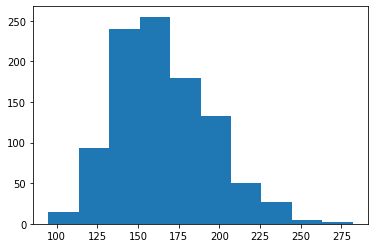

452153
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.193011    0.254679   
1            NaN             NaN NaN NaN  0.184243    0.300000   
2            NaN             NaN NaN NaN  0.182258    0.307203   
3            NaN             NaN NaN NaN  0.175115    0.259434   
4            NaN             NaN NaN NaN  0.199597    0.189320   
5            NaN             NaN NaN NaN  0.103687    0.360825   
6            NaN             NaN NaN NaN  0.213710    0.145455   
7            NaN             NaN NaN NaN  0.051843    0.144231   
8            NaN             NaN NaN NaN  0.028226    0.194444   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.159748        0.034759   0.159748  
1              0.179971        0.020968   0.179971  
2              0.182390        0.031780  

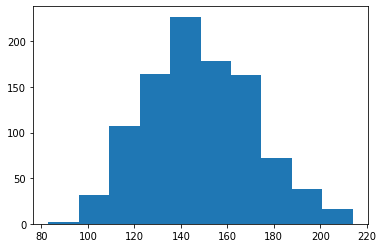

452154
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.193011    0.254679   
1            NaN             NaN NaN NaN  0.184243    0.300000   
2            NaN             NaN NaN NaN  0.182258    0.307203   
3            NaN             NaN NaN NaN  0.175115    0.259434   
4            NaN             NaN NaN NaN  0.052419    0.404167   
5            NaN             NaN NaN NaN  0.103687    0.360825   
6            NaN             NaN NaN NaN  0.213710    0.145455   
7            NaN             NaN NaN NaN  0.051843    0.144231   
8            NaN             NaN NaN NaN  0.028226    0.194444   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.159748        0.034759   0.159748  
1              0.179971        0.020968   0.179971  
2              0.182390        0.031780  

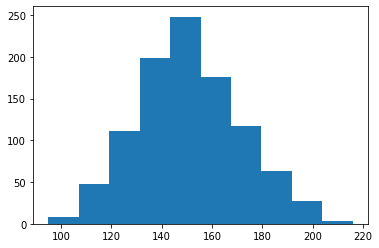

461565
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.099194    0.218045   
1            NaN             NaN NaN NaN  0.079301    0.230769   
2            NaN             NaN NaN NaN  0.168880    0.274129   
3            NaN             NaN NaN NaN  0.266129    0.268137   
4            NaN             NaN NaN NaN  0.194758    0.288767   
5            NaN             NaN NaN NaN  0.107180    0.334650   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.069892    0.250000   
8            NaN             NaN NaN NaN  0.099462    0.243750   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.072956        0.033835   0.072956  
1              0.062893        0.038462   0.062893  
2              0.151313        0.028150  

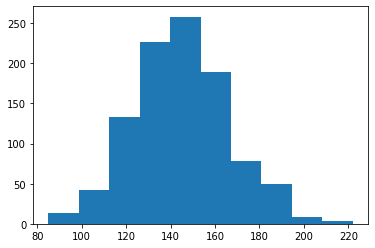

463141
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.193011    0.254679   
1            NaN             NaN NaN NaN  0.184243    0.300000   
2            NaN             NaN NaN NaN  0.182258    0.307203   
3            NaN             NaN NaN NaN  0.103687    0.360825   
4            NaN             NaN NaN NaN  0.052419    0.404167   
5            NaN             NaN NaN NaN  0.107180    0.334650   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.069892    0.250000   
8            NaN             NaN NaN NaN  0.099462    0.243750   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.159748        0.034759   0.159748  
1              0.179971        0.020968   0.179971  
2              0.182390        0.031780  

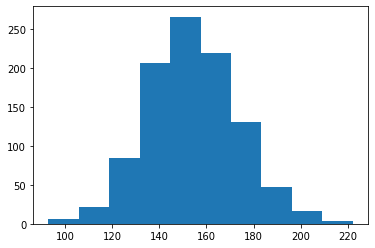

463149
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.174731    0.300245   
1            NaN             NaN NaN NaN  0.138172    0.308824   
2            NaN             NaN NaN NaN  0.175269    0.374633   
3            NaN             NaN NaN NaN  0.102419    0.354015   
4            NaN             NaN NaN NaN  0.170363    0.312853   
5            NaN             NaN NaN NaN  0.238710    0.254902   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.069892    0.250000   
8            NaN             NaN NaN NaN  0.099462    0.243750   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.171209        0.012255   0.171209  
1              0.140881        0.031250   0.140881  
2              0.214256        0.043988  

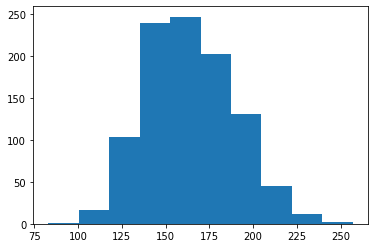

473918
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.172043    0.263682   
1            NaN             NaN NaN NaN  0.106855    0.332785   
2            NaN             NaN NaN NaN  0.115591    0.279891   
3            NaN             NaN NaN NaN  0.138337    0.309322   
4            NaN             NaN NaN NaN  0.192396    0.288314   
5            NaN             NaN NaN NaN  0.152493    0.326484   
6            NaN             NaN NaN NaN  0.127240    0.286424   
7            NaN             NaN NaN NaN  0.070161    0.255155   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.148148        0.028607   0.148148  
1              0.119300        0.033991   0.119300  
2              0.107966        0.016304  

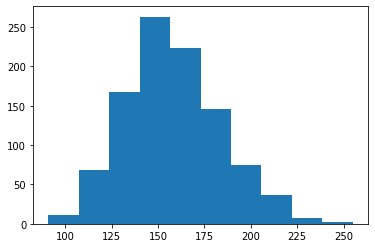

473920
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.115591    0.279891   
1            NaN             NaN NaN NaN  0.172043    0.263682   
2            NaN             NaN NaN NaN  0.144153    0.254967   
3            NaN             NaN NaN NaN  0.138337    0.309322   
4            NaN             NaN NaN NaN  0.192396    0.288314   
5            NaN             NaN NaN NaN  0.106855    0.332785   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.070161    0.255155   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.107966        0.016304   0.107966  
1              0.148148        0.028607   0.148148  
2              0.121069        0.033113  

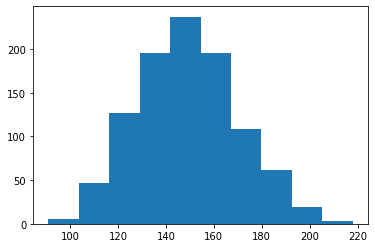

474476
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.210484    0.299815   
1            NaN             NaN NaN NaN  0.175996    0.314433   
2            NaN             NaN NaN NaN  0.142641    0.301839   
3            NaN             NaN NaN NaN  0.245699    0.260064   
4            NaN             NaN NaN NaN  0.338710    0.302326   
5            NaN             NaN NaN NaN  0.106855    0.332785   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.070161    0.255155   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.204403        0.011070   0.204403  
1              0.180540        0.047680   0.180540  
2              0.141903        0.031773  

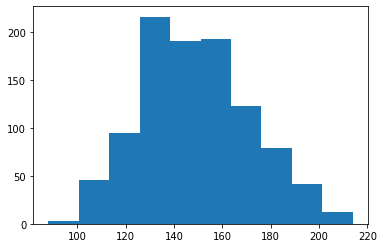

478279
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.099194    0.218045   
1            NaN             NaN NaN NaN  0.079301    0.230769   
2            NaN             NaN NaN NaN  0.179542    0.263575   
3            NaN             NaN NaN NaN  0.201229    0.289450   
4            NaN             NaN NaN NaN  0.103617    0.332057   
5            NaN             NaN NaN NaN  0.266129    0.268137   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.072956        0.033835   0.072956  
1              0.062893        0.038462   0.062893  
2              0.154254        0.027149  

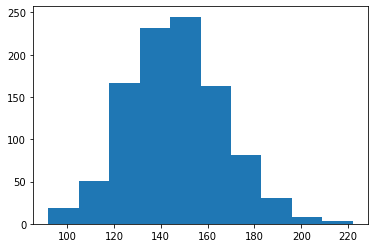

489220
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.210484    0.299815   
1            NaN             NaN NaN NaN  0.175996    0.314433   
2            NaN             NaN NaN NaN  0.142641    0.301839   
3            NaN             NaN NaN NaN  0.106855    0.289474   
4            NaN             NaN NaN NaN  0.102419    0.354015   
5            NaN             NaN NaN NaN  0.266129    0.268137   
6            NaN             NaN NaN NaN  0.152493    0.326484   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.204403        0.011070   0.204403  
1              0.180540        0.047680   0.180540  
2              0.141903        0.031773  

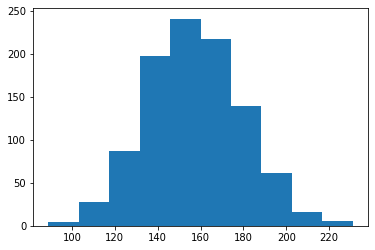

514024
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.138609    0.345361   
1            NaN             NaN NaN NaN  0.193548    0.305000   
2            NaN             NaN NaN NaN  0.097782    0.257143   
3            NaN             NaN NaN NaN  0.144624    0.290933   
4            NaN             NaN NaN NaN  0.152126    0.324943   
5            NaN             NaN NaN NaN  0.114516    0.269737   
6            NaN             NaN NaN NaN  0.046371    0.296296   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.158019        0.032646   0.158019  
1              0.191824        0.015000   0.191824  
2              0.084906        0.033333  

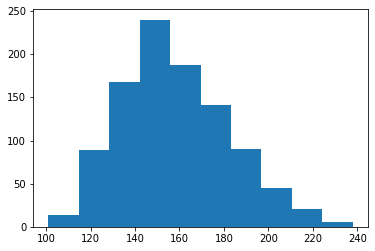

518955
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.135386    0.342419   
1            NaN             NaN NaN NaN  0.097782    0.257143   
2            NaN             NaN NaN NaN  0.144624    0.290933   
3            NaN             NaN NaN NaN  0.262097    0.380597   
4            NaN             NaN NaN NaN  0.193548    0.305000   
5            NaN             NaN NaN NaN  0.114516    0.269737   
6            NaN             NaN NaN NaN  0.046371    0.296296   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.153230        0.032368   0.153230  
1              0.084906        0.033333   0.084906  
2              0.138574        0.018486  

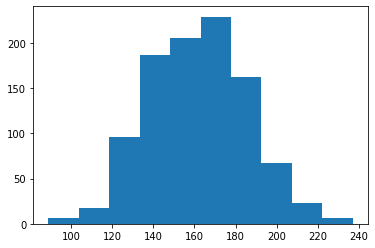

520595
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.184243    0.300000   
1            NaN             NaN NaN NaN  0.193011    0.254679   
2            NaN             NaN NaN NaN  0.175115    0.259434   
3            NaN             NaN NaN NaN  0.056452    0.257812   
4            NaN             NaN NaN NaN  0.103687    0.360825   
5            NaN             NaN NaN NaN  0.114516    0.269737   
6            NaN             NaN NaN NaN  0.046371    0.296296   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.179971        0.020968   0.179971  
1              0.159748        0.034759   0.159748  
2              0.148248        0.034591  

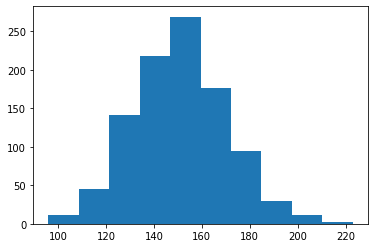

520596
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.193011    0.254679   
1            NaN             NaN NaN NaN  0.079032    0.222222   
2            NaN             NaN NaN NaN  0.184243    0.300000   
3            NaN             NaN NaN NaN  0.103687    0.360825   
4            NaN             NaN NaN NaN  0.103687    0.360825   
5            NaN             NaN NaN NaN  0.114516    0.269737   
6            NaN             NaN NaN NaN  0.046371    0.296296   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.159748        0.034759   0.159748  
1              0.060377        0.018519   0.060377  
2              0.179971        0.020968  

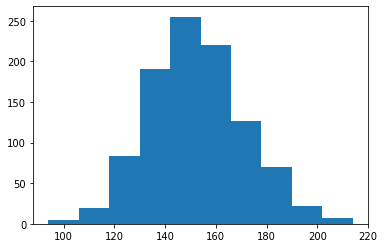

521217
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.145161    0.276316   
1            NaN             NaN NaN NaN  0.210484    0.299815   
2            NaN             NaN NaN NaN  0.175996    0.314433   
3            NaN             NaN NaN NaN  0.245699    0.260064   
4            NaN             NaN NaN NaN  0.111290    0.212838   
5            NaN             NaN NaN NaN  0.102419    0.354015   
6            NaN             NaN NaN NaN  0.338710    0.302326   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.132075        0.019737   0.132075  
1              0.204403        0.011070   0.204403  
2              0.180540        0.047680  

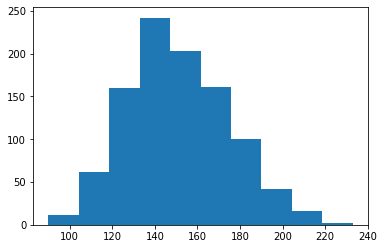

523735
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.175499    0.261506   
1            NaN             NaN NaN NaN  0.146953    0.250000   
2            NaN             NaN NaN NaN  0.190042    0.288938   
3            NaN             NaN NaN NaN  0.138337    0.271186   
4            NaN             NaN NaN NaN  0.061828    0.307692   
5            NaN             NaN NaN NaN  0.102419    0.354015   
6            NaN             NaN NaN NaN  0.338710    0.302326   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.149745        0.026151   0.149745  
1              0.120894        0.028902   0.120894  
2              0.178562        0.030973  

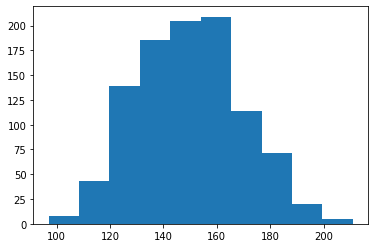

523736
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.175499    0.261506   
1            NaN             NaN NaN NaN  0.146953    0.250000   
2            NaN             NaN NaN NaN  0.138337    0.271186   
3            NaN             NaN NaN NaN  0.190042    0.288938   
4            NaN             NaN NaN NaN  0.277419    0.267420   
5            NaN             NaN NaN NaN  0.061828    0.307692   
6            NaN             NaN NaN NaN  0.067742    0.218085   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.149745        0.026151   0.149745  
1              0.120894        0.028902   0.120894  
2              0.123851        0.019068  

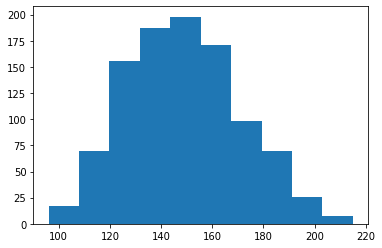

527012
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.193011    0.254679   
1            NaN             NaN NaN NaN  0.182258    0.307203   
2            NaN             NaN NaN NaN  0.184243    0.300000   
3            NaN             NaN NaN NaN  0.056452    0.257812   
4            NaN             NaN NaN NaN  0.052419    0.404167   
5            NaN             NaN NaN NaN  0.103687    0.360825   
6            NaN             NaN NaN NaN  0.051843    0.144231   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.159748        0.034759   0.159748  
1              0.182390        0.031780   0.182390  
2              0.179971        0.020968  

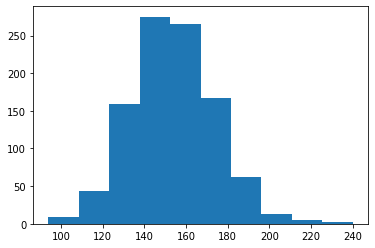

533274
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.189206    0.279481   
1            NaN             NaN NaN NaN  0.134946    0.332707   
2            NaN             NaN NaN NaN  0.223502    0.324627   
3            NaN             NaN NaN NaN  0.173175    0.367096   
4            NaN             NaN NaN NaN  0.196095    0.317048   
5            NaN             NaN NaN NaN  0.253321    0.268149   
6            NaN             NaN NaN NaN  0.143738    0.303906   
7            NaN             NaN NaN NaN  0.075806    0.242788   
8            NaN             NaN NaN NaN  0.076613    0.238095   
9            NaN             NaN NaN NaN  0.056452    0.328125   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.171988        0.055818   0.171988  
1              0.148428        0.050752   0.148428  
2              0.234501        0.026119  

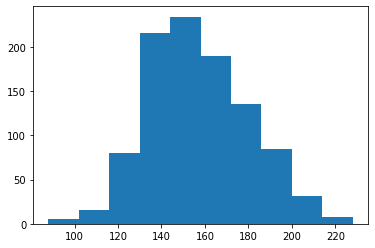

533275
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.193011    0.254679   
1            NaN             NaN NaN NaN  0.101382    0.223684   
2            NaN             NaN NaN NaN  0.184243    0.300000   
3            NaN             NaN NaN NaN  0.199597    0.189320   
4            NaN             NaN NaN NaN  0.079032    0.222222   
5            NaN             NaN NaN NaN  0.103687    0.360825   
6            NaN             NaN NaN NaN  0.068548    0.177632   
7            NaN             NaN NaN NaN  0.051843    0.144231   
8            NaN             NaN NaN NaN  0.032258    0.140000   
9            NaN             NaN NaN NaN  0.040323    0.125000   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.159748        0.034759   0.159748  
1              0.076370        0.063158   0.076370  
2              0.179971        0.020968  

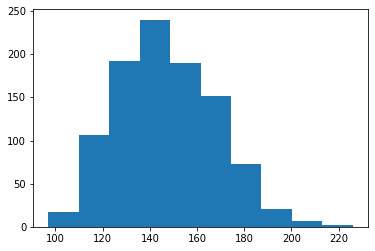

533280
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.164651    0.254864   
1            NaN             NaN NaN NaN  0.149194    0.341880   
2            NaN             NaN NaN NaN  0.126344    0.270000   
3            NaN             NaN NaN NaN  0.150538    0.310911   
4            NaN             NaN NaN NaN  0.181290    0.285349   
5            NaN             NaN NaN NaN  0.140553    0.265504   
6            NaN             NaN NaN NaN  0.106912    0.334669   
7            NaN             NaN NaN NaN  0.051843    0.144231   
8            NaN             NaN NaN NaN  0.032258    0.140000   
9            NaN             NaN NaN NaN  0.040323    0.125000   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.137317        0.027237   0.137317  
1              0.167715        0.064103   0.167715  
2              0.113208        0.020000  

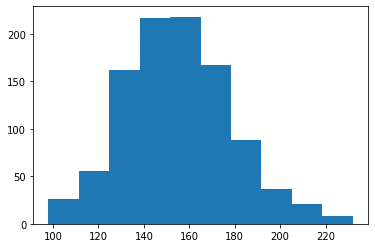

533281
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.189206    0.279481   
1            NaN             NaN NaN NaN  0.148618    0.295956   
2            NaN             NaN NaN NaN  0.223502    0.324627   
3            NaN             NaN NaN NaN  0.143738    0.303906   
4            NaN             NaN NaN NaN  0.253321    0.268149   
5            NaN             NaN NaN NaN  0.196095    0.317048   
6            NaN             NaN NaN NaN  0.106912    0.334669   
7            NaN             NaN NaN NaN  0.051843    0.144231   
8            NaN             NaN NaN NaN  0.032258    0.140000   
9            NaN             NaN NaN NaN  0.040323    0.125000   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.171988        0.055818   0.171988  
1              0.144654        0.036765   0.144654  
2              0.234501        0.026119  

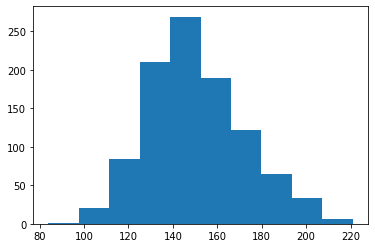

533287
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.189206    0.279481   
1            NaN             NaN NaN NaN  0.148618    0.295956   
2            NaN             NaN NaN NaN  0.223502    0.324627   
3            NaN             NaN NaN NaN  0.173175    0.367096   
4            NaN             NaN NaN NaN  0.143738    0.303906   
5            NaN             NaN NaN NaN  0.253321    0.268149   
6            NaN             NaN NaN NaN  0.196095    0.317048   
7            NaN             NaN NaN NaN  0.177419    0.288043   
8            NaN             NaN NaN NaN  0.106855    0.289474   
9            NaN             NaN NaN NaN  0.040323    0.125000   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.171988        0.055818   0.171988  
1              0.144654        0.036765   0.144654  
2              0.234501        0.026119  

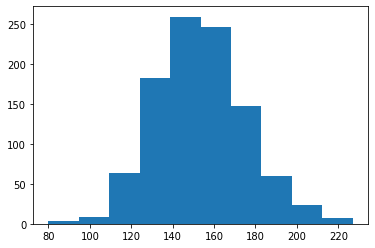

533291
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.177131    0.272939   
1            NaN             NaN NaN NaN  0.143433    0.325095   
2            NaN             NaN NaN NaN  0.105287    0.336957   
3            NaN             NaN NaN NaN  0.148618    0.279412   
4            NaN             NaN NaN NaN  0.156948    0.313440   
5            NaN             NaN NaN NaN  0.159850    0.264580   
6            NaN             NaN NaN NaN  0.172523    0.284290   
7            NaN             NaN NaN NaN  0.098387    0.272727   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.157682        0.023328   0.157682  
1              0.153639        0.058935   0.153639  
2              0.119147        0.033597  

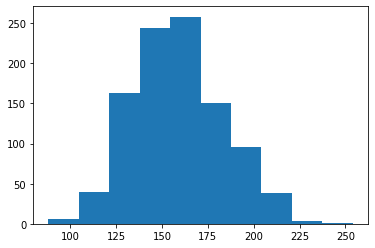

533294
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.177131    0.272939   
1            NaN             NaN NaN NaN  0.143433    0.325095   
2            NaN             NaN NaN NaN  0.148618    0.279412   
3            NaN             NaN NaN NaN  0.156948    0.313440   
4            NaN             NaN NaN NaN  0.172523    0.284290   
5            NaN             NaN NaN NaN  0.148263    0.303571   
6            NaN             NaN NaN NaN  0.105287    0.336957   
7            NaN             NaN NaN NaN  0.159850    0.264580   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.157682        0.023328   0.157682  
1              0.153639        0.058935   0.153639  
2              0.136568        0.018382  

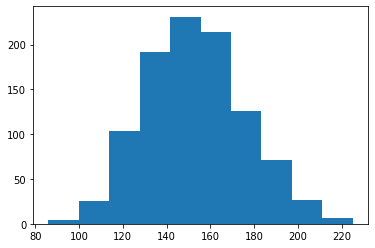

533295
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.190092    0.281613   
1            NaN             NaN NaN NaN  0.134946    0.332707   
2            NaN             NaN NaN NaN  0.225806    0.320690   
3            NaN             NaN NaN NaN  0.145636    0.304784   
4            NaN             NaN NaN NaN  0.166056    0.373158   
5            NaN             NaN NaN NaN  0.189919    0.316191   
6            NaN             NaN NaN NaN  0.236418    0.271267   
7            NaN             NaN NaN NaN  0.159850    0.264580   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.174079        0.052326   0.174079  
1              0.148428        0.050752   0.148428  
2              0.233962        0.024138  

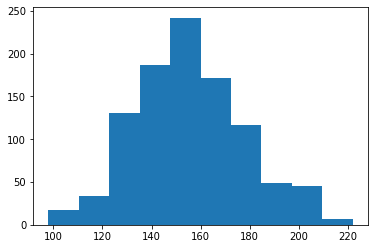

538068
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.177131    0.272939   
1            NaN             NaN NaN NaN  0.080645    0.246753   
2            NaN             NaN NaN NaN  0.146953    0.250000   
3            NaN             NaN NaN NaN  0.172523    0.284290   
4            NaN             NaN NaN NaN  0.159850    0.264580   
5            NaN             NaN NaN NaN  0.105287    0.336957   
6            NaN             NaN NaN NaN  0.277419    0.267420   
7            NaN             NaN NaN NaN  0.063172    0.306604   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.157682        0.023328   0.157682  
1              0.068284        0.077922   0.068284  
2              0.120894        0.028902  

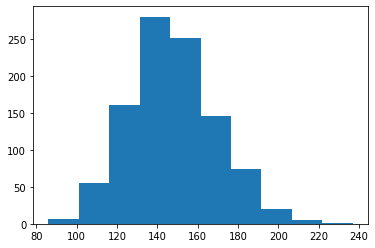

546410
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.205069    0.350000   
1            NaN             NaN NaN NaN  0.080645    0.272727   
2            NaN             NaN NaN NaN  0.225806    0.286207   
3            NaN             NaN NaN NaN  0.055108    0.175532   
4            NaN             NaN NaN NaN  0.133065    0.245238   
5            NaN             NaN NaN NaN  0.100000    0.283582   
6            NaN             NaN NaN NaN  0.193548    0.266000   
7            NaN             NaN NaN NaN  0.063172    0.306604   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.232704        0.021622   0.232704  
1              0.075472        0.060606   0.075472  
2              0.208805        0.048276  

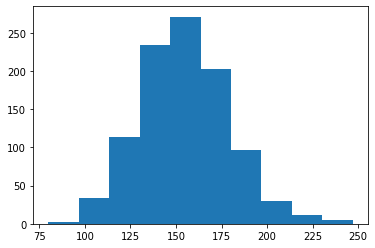

546418
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.205069    0.350000   
1            NaN             NaN NaN NaN  0.080645    0.272727   
2            NaN             NaN NaN NaN  0.225806    0.286207   
3            NaN             NaN NaN NaN  0.055108    0.175532   
4            NaN             NaN NaN NaN  0.133065    0.245238   
5            NaN             NaN NaN NaN  0.100000    0.283582   
6            NaN             NaN NaN NaN  0.193548    0.266000   
7            NaN             NaN NaN NaN  0.063172    0.306604   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.232704        0.021622   0.232704  
1              0.075472        0.060606   0.075472  
2              0.208805        0.048276  

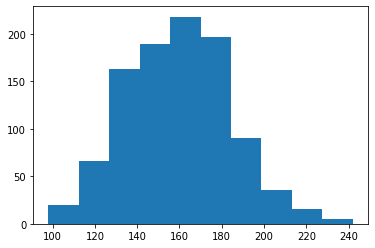

546470
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.205069    0.350000   
1            NaN             NaN NaN NaN  0.225806    0.286207   
2            NaN             NaN NaN NaN  0.080645    0.272727   
3            NaN             NaN NaN NaN  0.055108    0.175532   
4            NaN             NaN NaN NaN  0.133065    0.245238   
5            NaN             NaN NaN NaN  0.100000    0.283582   
6            NaN             NaN NaN NaN  0.193548    0.266000   
7            NaN             NaN NaN NaN  0.063172    0.306604   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.232704        0.021622   0.232704  
1              0.208805        0.048276   0.208805  
2              0.075472        0.060606  

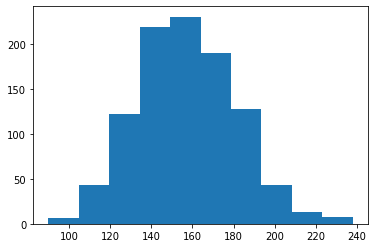

562438
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.172120    0.275895   
1            NaN             NaN NaN NaN  0.176075    0.269465   
2            NaN             NaN NaN NaN  0.068548    0.177632   
3            NaN             NaN NaN NaN  0.184964    0.286388   
4            NaN             NaN NaN NaN  0.161012    0.258635   
5            NaN             NaN NaN NaN  0.115927    0.339431   
6            NaN             NaN NaN NaN  0.098387    0.272727   
7            NaN             NaN NaN NaN  0.063172    0.306604   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.155076        0.023018   0.155076  
1              0.154787        0.029197   0.154787  
2              0.042453        0.039474  

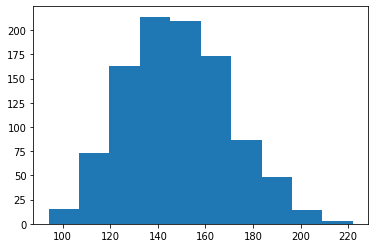

564786
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.190092    0.281613   
1            NaN             NaN NaN NaN  0.156682    0.304196   
2            NaN             NaN NaN NaN  0.222782    0.320415   
3            NaN             NaN NaN NaN  0.185484    0.317460   
4            NaN             NaN NaN NaN  0.245331    0.271776   
5            NaN             NaN NaN NaN  0.115927    0.339431   
6            NaN             NaN NaN NaN  0.098387    0.272727   
7            NaN             NaN NaN NaN  0.063172    0.306604   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.174079        0.052326   0.174079  
1              0.156334        0.024476   0.156334  
2              0.230739        0.024017  

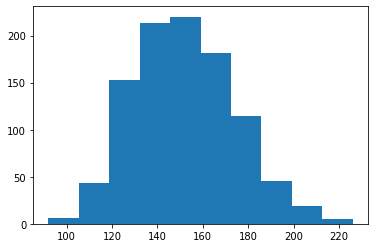

565811
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.190092    0.281613   
1            NaN             NaN NaN NaN  0.156682    0.304196   
2            NaN             NaN NaN NaN  0.222782    0.320415   
3            NaN             NaN NaN NaN  0.179985    0.383041   
4            NaN             NaN NaN NaN  0.141129    0.302553   
5            NaN             NaN NaN NaN  0.185484    0.317460   
6            NaN             NaN NaN NaN  0.245331    0.271776   
7            NaN             NaN NaN NaN  0.177419    0.288043   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.174079        0.052326   0.174079  
1              0.156334        0.024476   0.156334  
2              0.230739        0.024017  

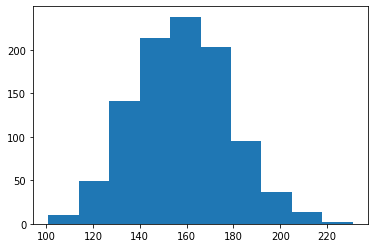

566937
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.147581    0.340997   
1            NaN             NaN NaN NaN  0.217742    0.407468   
2            NaN             NaN NaN NaN  0.151760    0.255734   
3            NaN             NaN NaN NaN  0.153226    0.369583   
4            NaN             NaN NaN NaN  0.083065    0.336283   
5            NaN             NaN NaN NaN  0.168011    0.374046   
6            NaN             NaN NaN NaN  0.155530    0.302817   
7            NaN             NaN NaN NaN  0.068548    0.355263   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.165566        0.033679   0.165566  
1              0.287021        0.022727   0.287021  
2              0.127501        0.029817  

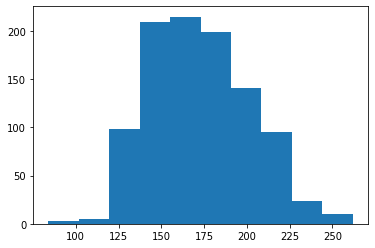

567205
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.244960    0.331673   
1            NaN             NaN NaN NaN  0.114919    0.278689   
2            NaN             NaN NaN NaN  0.080645    0.272727   
3            NaN             NaN NaN NaN  0.206452    0.219925   
4            NaN             NaN NaN NaN  0.139401    0.287109   
5            NaN             NaN NaN NaN  0.193548    0.266000   
6            NaN             NaN NaN NaN  0.098118    0.272152   
7            NaN             NaN NaN NaN  0.157258    0.243902   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.261792        0.019920   0.261792  
1              0.106918        0.028689   0.106918  
2              0.075472        0.060606  

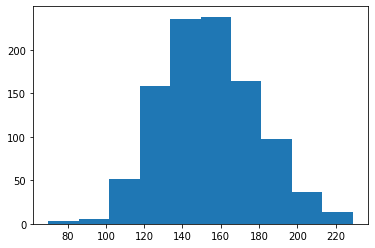

567367
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.171053    0.267773   
1            NaN             NaN NaN NaN  0.127566    0.272973   
2            NaN             NaN NaN NaN  0.176299    0.281288   
3            NaN             NaN NaN NaN  0.188760    0.292574   
4            NaN             NaN NaN NaN  0.139401    0.287109   
5            NaN             NaN NaN NaN  0.193548    0.266000   
6            NaN             NaN NaN NaN  0.098118    0.272152   
7            NaN             NaN NaN NaN  0.157258    0.243902   
8            NaN             NaN NaN NaN  0.079301    0.226923   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.149619        0.028436   0.149619  
1              0.115495        0.035135   0.115495  
2              0.161775        0.023086  

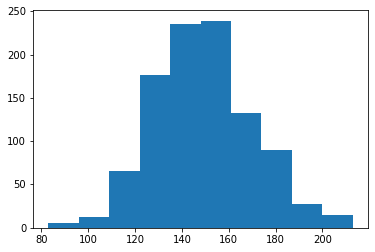

571148
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.153226    0.369583   
1            NaN             NaN NaN NaN  0.147581    0.340997   
2            NaN             NaN NaN NaN  0.184476    0.343586   
3            NaN             NaN NaN NaN  0.168011    0.374046   
4            NaN             NaN NaN NaN  0.136593    0.289634   
5            NaN             NaN NaN NaN  0.172043    0.321725   
6            NaN             NaN NaN NaN  0.155530    0.302817   
7            NaN             NaN NaN NaN  0.083065    0.336283   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.185954        0.017500   0.185954  
1              0.165566        0.033679   0.165566  
2              0.206368        0.023560  

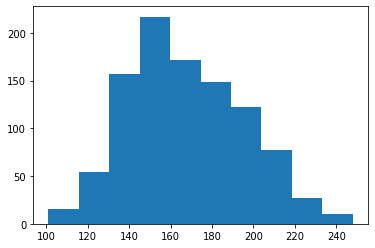

571149
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.176299    0.281288   
1            NaN             NaN NaN NaN  0.143433    0.325095   
2            NaN             NaN NaN NaN  0.127566    0.272973   
3            NaN             NaN NaN NaN  0.156948    0.313440   
4            NaN             NaN NaN NaN  0.188760    0.292574   
5            NaN             NaN NaN NaN  0.146889    0.293680   
6            NaN             NaN NaN NaN  0.155530    0.302817   
7            NaN             NaN NaN NaN  0.083065    0.336283   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.161775        0.023086   0.161775  
1              0.153639        0.058935   0.153639  
2              0.115495        0.035135  

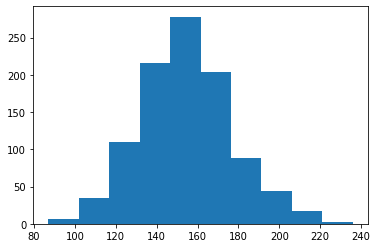

571150
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.147581    0.340997   
1            NaN             NaN NaN NaN  0.153226    0.369583   
2            NaN             NaN NaN NaN  0.083065    0.336283   
3            NaN             NaN NaN NaN  0.184476    0.343586   
4            NaN             NaN NaN NaN  0.168011    0.374046   
5            NaN             NaN NaN NaN  0.172043    0.321725   
6            NaN             NaN NaN NaN  0.040323    0.312500   
7            NaN             NaN NaN NaN  0.155530    0.302817   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.165566        0.033679   0.165566  
1              0.185954        0.017500   0.185954  
2              0.095597        0.039823  

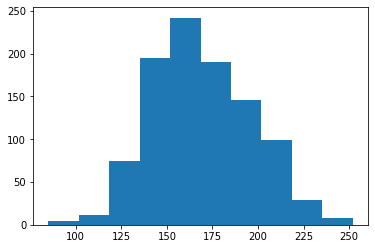

573019
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.147581    0.340997   
1            NaN             NaN NaN NaN  0.217742    0.407468   
2            NaN             NaN NaN NaN  0.151760    0.255734   
3            NaN             NaN NaN NaN  0.168011    0.374046   
4            NaN             NaN NaN NaN  0.303763    0.299569   
5            NaN             NaN NaN NaN  0.172043    0.321725   
6            NaN             NaN NaN NaN  0.040323    0.312500   
7            NaN             NaN NaN NaN  0.155530    0.302817   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.165566        0.033679   0.165566  
1              0.287021        0.022727   0.287021  
2              0.127501        0.029817  

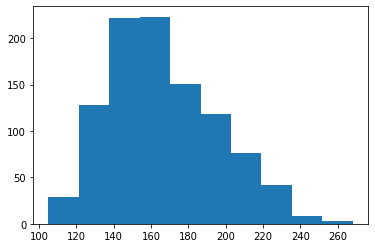

589306
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.190092    0.281613   
1            NaN             NaN NaN NaN  0.141129    0.307432   
2            NaN             NaN NaN NaN  0.273746    0.317965   
3            NaN             NaN NaN NaN  0.171371    0.373127   
4            NaN             NaN NaN NaN  0.258489    0.277866   
5            NaN             NaN NaN NaN  0.195015    0.316336   
6            NaN             NaN NaN NaN  0.175000    0.300110   
7            NaN             NaN NaN NaN  0.074597    0.219512   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.174079        0.052326   0.174079  
1              0.143082        0.027027   0.143082  
2              0.279525        0.025437  

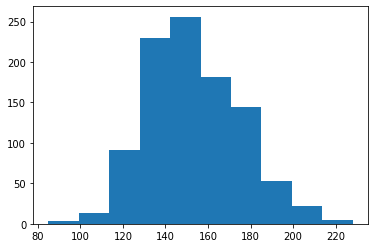

593986
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.127171    0.216743   
1            NaN             NaN NaN NaN  0.212097    0.257784   
2            NaN             NaN NaN NaN  0.166219    0.299486   
3            NaN             NaN NaN NaN  0.204301    0.200949   
4            NaN             NaN NaN NaN  0.116935    0.320565   
5            NaN             NaN NaN NaN  0.166667    0.299038   
6            NaN             NaN NaN NaN  0.061828    0.157051   
7            NaN             NaN NaN NaN  0.074597    0.219512   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.091437        0.082569   0.091437  
1              0.177044        0.033883   0.177044  
2              0.162823        0.026992  

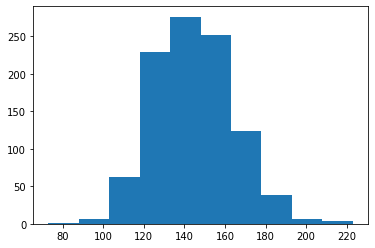

630951
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.160138    0.260274   
1            NaN             NaN NaN NaN  0.210484    0.331181   
2            NaN             NaN NaN NaN  0.118664    0.277273   
3            NaN             NaN NaN NaN  0.092166    0.258621   
4            NaN             NaN NaN NaN  0.193548    0.266000   
5            NaN             NaN NaN NaN  0.099707    0.273810   
6            NaN             NaN NaN NaN  0.114919    0.254098   
7            NaN             NaN NaN NaN  0.074597    0.219512   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.136568        0.037671   0.136568  
1              0.225786        0.020295   0.225786  
2              0.109614        0.063636  

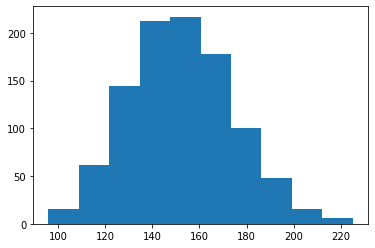

636164
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.166187    0.320661   
1            NaN             NaN NaN NaN  0.195409    0.391006   
2            NaN             NaN NaN NaN  0.083333    0.352941   
3            NaN             NaN NaN NaN  0.160670    0.367647   
4            NaN             NaN NaN NaN  0.040323    0.312500   
5            NaN             NaN NaN NaN  0.099707    0.273810   
6            NaN             NaN NaN NaN  0.114919    0.254098   
7            NaN             NaN NaN NaN  0.074597    0.219512   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.174304        0.022314   0.174304  
1              0.248186        0.022866   0.248186  
2              0.100629        0.040441  

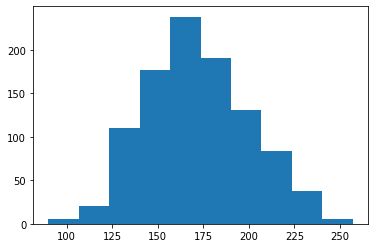

636166
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.166187    0.320661   
1            NaN             NaN NaN NaN  0.195409    0.391006   
2            NaN             NaN NaN NaN  0.083333    0.352941   
3            NaN             NaN NaN NaN  0.160670    0.367647   
4            NaN             NaN NaN NaN  0.093318    0.312500   
5            NaN             NaN NaN NaN  0.040323    0.302817   
6            NaN             NaN NaN NaN  0.155530    0.254098   
7            NaN             NaN NaN NaN  0.074597    0.219512   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.174304        0.022314   0.174304  
1              0.248186        0.022866   0.248186  
2              0.100629        0.040441  

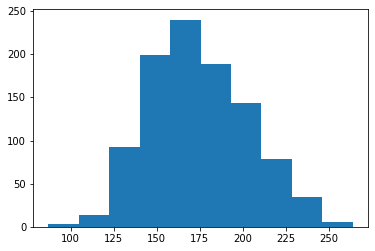

645647
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.162970    0.258350   
1            NaN             NaN NaN NaN  0.179280    0.271523   
2            NaN             NaN NaN NaN  0.094086    0.250000   
3            NaN             NaN NaN NaN  0.183468    0.290351   
4            NaN             NaN NaN NaN  0.114370    0.338323   
5            NaN             NaN NaN NaN  0.083333    0.300459   
6            NaN             NaN NaN NaN  0.071848    0.254098   
7            NaN             NaN NaN NaN  0.074597    0.219512   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.137841        0.041257   0.137841  
1              0.158684        0.024283   0.158684  
2              0.079665        0.032895  

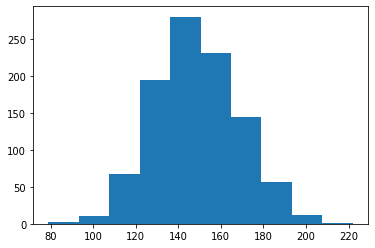

647247
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.187212    0.388643   
1            NaN             NaN NaN NaN  0.150293    0.363812   
2            NaN             NaN NaN NaN  0.160670    0.367647   
3            NaN             NaN NaN NaN  0.096154    0.351190   
4            NaN             NaN NaN NaN  0.110781    0.267857   
5            NaN             NaN NaN NaN  0.112903    0.341667   
6            NaN             NaN NaN NaN  0.254032    0.288462   
7            NaN             NaN NaN NaN  0.074597    0.219512   
8            NaN             NaN NaN NaN  0.053763    0.239130   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.236748        0.023599   0.236748  
1              0.179722        0.019290   0.179722  
2              0.193517        0.011029  

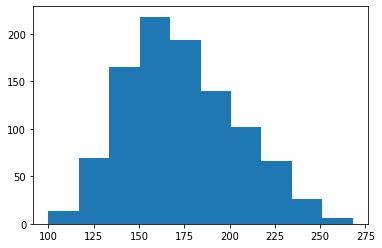

649101
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.162970    0.258350   
1            NaN             NaN NaN NaN  0.114370    0.338323   
2            NaN             NaN NaN NaN  0.078629    0.296512   
3            NaN             NaN NaN NaN  0.179280    0.271523   
4            NaN             NaN NaN NaN  0.157128    0.255512   
5            NaN             NaN NaN NaN  0.183468    0.290351   
6            NaN             NaN NaN NaN  0.146889    0.293680   
7            NaN             NaN NaN NaN  0.071848    0.300459   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.137841        0.041257   0.137841  
1              0.129217        0.042665   0.129217  
2              0.080189        0.005814  

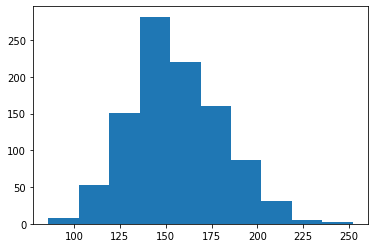

660185
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.149194    0.264423   
1            NaN             NaN NaN NaN  0.103495    0.269578   
2            NaN             NaN NaN NaN  0.208944    0.318412   
3            NaN             NaN NaN NaN  0.115323    0.261438   
4            NaN             NaN NaN NaN  0.131048    0.326087   
5            NaN             NaN NaN NaN  0.082661    0.252778   
6            NaN             NaN NaN NaN  0.206452    0.219925   
7            NaN             NaN NaN NaN  0.157258    0.243902   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.129717        0.038462   0.129717  
1              0.093816        0.024096   0.093816  
2              0.215552        0.018581  

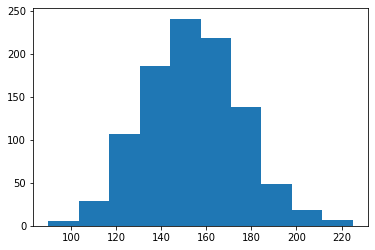

682901
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.210349    0.266154   
1            NaN             NaN NaN NaN  0.091014    0.232558   
2            NaN             NaN NaN NaN  0.166219    0.299486   
3            NaN             NaN NaN NaN  0.179032    0.316810   
4            NaN             NaN NaN NaN  0.142473    0.224107   
5            NaN             NaN NaN NaN  0.111559    0.371723   
6            NaN             NaN NaN NaN  0.206452    0.219925   
7            NaN             NaN NaN NaN  0.157258    0.243902   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.181342        0.036923   0.181342  
1              0.071878        0.081395   0.071878  
2              0.162823        0.026992  

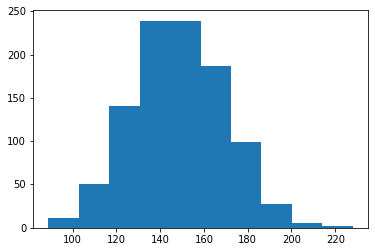

682909
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.227047    0.313984   
1            NaN             NaN NaN NaN  0.156891    0.270000   
2            NaN             NaN NaN NaN  0.110383    0.307447   
3            NaN             NaN NaN NaN  0.136425    0.316279   
4            NaN             NaN NaN NaN  0.172379    0.305866   
5            NaN             NaN NaN NaN  0.118664    0.277273   
6            NaN             NaN NaN NaN  0.077061    0.252632   
7            NaN             NaN NaN NaN  0.157258    0.243902   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.230285        0.022427   0.230285  
1              0.138937        0.031111   0.138937  
2              0.113601        0.023404  

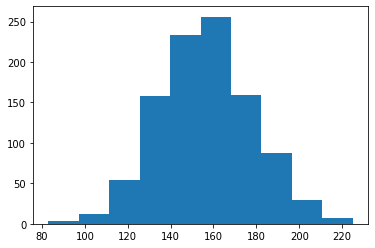

682921
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.148906    0.309633   
1            NaN             NaN NaN NaN  0.170161    0.262821   
2            NaN             NaN NaN NaN  0.173937    0.274169   
3            NaN             NaN NaN NaN  0.174923    0.295908   
4            NaN             NaN NaN NaN  0.157482    0.255751   
5            NaN             NaN NaN NaN  0.110105    0.349582   
6            NaN             NaN NaN NaN  0.074373    0.282609   
7            NaN             NaN NaN NaN  0.157258    0.243902   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.151617        0.027523   0.151617  
1              0.146122        0.042232   0.146122  
2              0.155660        0.023162  

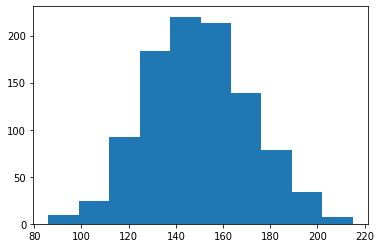

682927
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170161    0.262821   
1            NaN             NaN NaN NaN  0.148906    0.309633   
2            NaN             NaN NaN NaN  0.173937    0.274169   
3            NaN             NaN NaN NaN  0.174923    0.295908   
4            NaN             NaN NaN NaN  0.074373    0.282609   
5            NaN             NaN NaN NaN  0.110105    0.349582   
6            NaN             NaN NaN NaN  0.157482    0.255751   
7            NaN             NaN NaN NaN  0.157258    0.243902   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.146122        0.042232   0.146122  
1              0.151617        0.027523   0.151617  
2              0.155660        0.023162  

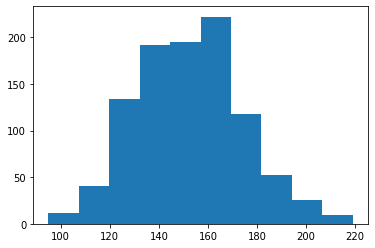

682941
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.234375    0.375260   
1            NaN             NaN NaN NaN  0.150788    0.338253   
2            NaN             NaN NaN NaN  0.145815    0.355878   
3            NaN             NaN NaN NaN  0.086190    0.347594   
4            NaN             NaN NaN NaN  0.160670    0.367647   
5            NaN             NaN NaN NaN  0.093318    0.312500   
6            NaN             NaN NaN NaN  0.135484    0.292135   
7            NaN             NaN NaN NaN  0.110781    0.267857   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.283805        0.028067   0.283805  
1              0.167617        0.033648   0.167617  
2              0.170831        0.021246  

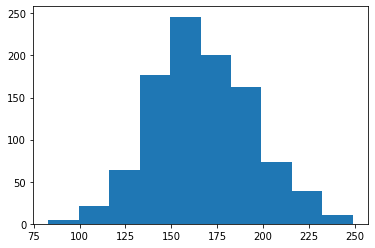

682945
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.156891    0.270000   
1            NaN             NaN NaN NaN  0.227047    0.313984   
2            NaN             NaN NaN NaN  0.110383    0.307447   
3            NaN             NaN NaN NaN  0.136425    0.316279   
4            NaN             NaN NaN NaN  0.118664    0.277273   
5            NaN             NaN NaN NaN  0.172379    0.305866   
6            NaN             NaN NaN NaN  0.135484    0.292135   
7            NaN             NaN NaN NaN  0.110781    0.267857   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.138937        0.031111   0.138937  
1              0.230285        0.022427   0.230285  
2              0.113601        0.023404  

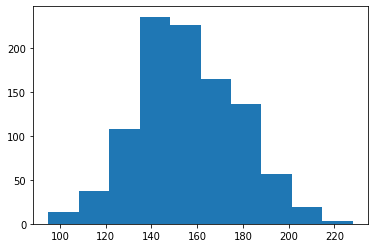

682949
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.166079    0.260854   
1            NaN             NaN NaN NaN  0.148906    0.309633   
2            NaN             NaN NaN NaN  0.173118    0.273492   
3            NaN             NaN NaN NaN  0.179107    0.295591   
4            NaN             NaN NaN NaN  0.156621    0.259665   
5            NaN             NaN NaN NaN  0.106420    0.348066   
6            NaN             NaN NaN NaN  0.085777    0.265625   
7            NaN             NaN NaN NaN  0.110781    0.267857   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.141706        0.040521   0.141706  
1              0.151617        0.027523   0.151617  
2              0.154577        0.023244  

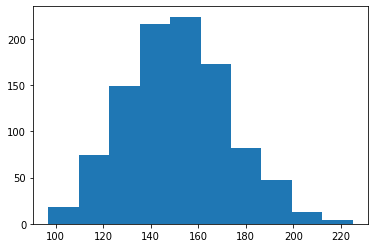

682951
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.309958    0.332415   
1            NaN             NaN NaN NaN  0.145161    0.276316   
2            NaN             NaN NaN NaN  0.176523    0.358414   
3            NaN             NaN NaN NaN  0.184886    0.311533   
4            NaN             NaN NaN NaN  0.249267    0.283476   
5            NaN             NaN NaN NaN  0.077621    0.220588   
6            NaN             NaN NaN NaN  0.125000    0.250000   
7            NaN             NaN NaN NaN  0.052419    0.267857   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.329779        0.023705   0.329779  
1              0.132075        0.044534   0.132075  
2              0.206382        0.042071  

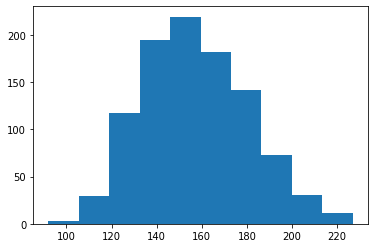

682953
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.227047    0.313984   
1            NaN             NaN NaN NaN  0.156891    0.270000   
2            NaN             NaN NaN NaN  0.110383    0.307447   
3            NaN             NaN NaN NaN  0.118664    0.277273   
4            NaN             NaN NaN NaN  0.136425    0.316279   
5            NaN             NaN NaN NaN  0.172379    0.305866   
6            NaN             NaN NaN NaN  0.077061    0.252632   
7            NaN             NaN NaN NaN  0.052419    0.267857   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.230285        0.022427   0.230285  
1              0.138937        0.031111   0.138937  
2              0.113601        0.023404  

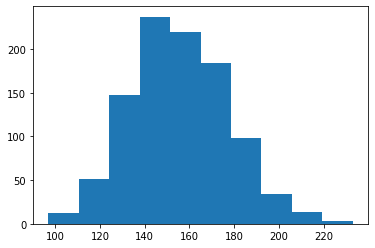

682965
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.190263    0.309864   
1            NaN             NaN NaN NaN  0.145161    0.276316   
2            NaN             NaN NaN NaN  0.309958    0.332415   
3            NaN             NaN NaN NaN  0.176523    0.358414   
4            NaN             NaN NaN NaN  0.249267    0.283476   
5            NaN             NaN NaN NaN  0.172379    0.305866   
6            NaN             NaN NaN NaN  0.077061    0.252632   
7            NaN             NaN NaN NaN  0.052419    0.267857   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.191707        0.029367   0.191707  
1              0.132075        0.044534   0.132075  
2              0.329779        0.023705  

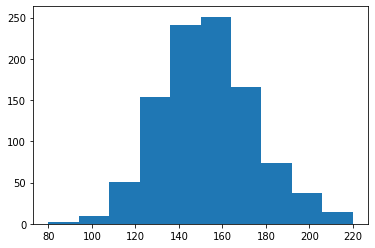

685729
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.133065    0.261905   
1            NaN             NaN NaN NaN  0.166079    0.260854   
2            NaN             NaN NaN NaN  0.173118    0.273492   
3            NaN             NaN NaN NaN  0.179107    0.295591   
4            NaN             NaN NaN NaN  0.106420    0.348066   
5            NaN             NaN NaN NaN  0.172379    0.305866   
6            NaN             NaN NaN NaN  0.077061    0.252632   
7            NaN             NaN NaN NaN  0.052419    0.267857   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.115304        0.047619   0.115304  
1              0.141706        0.040521   0.141706  
2              0.154577        0.023244  

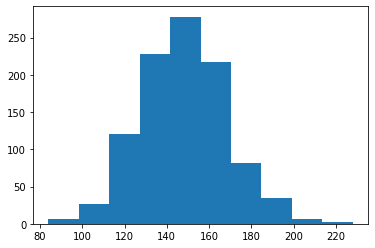

727917
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.171727    0.263193   
1            NaN             NaN NaN NaN  0.139113    0.178082   
2            NaN             NaN NaN NaN  0.094086    0.250000   
3            NaN             NaN NaN NaN  0.085777    0.265625   
4            NaN             NaN NaN NaN  0.174014    0.295768   
5            NaN             NaN NaN NaN  0.107121    0.351717   
6            NaN             NaN NaN NaN  0.086694    0.361702   
7            NaN             NaN NaN NaN  0.155914    0.286885   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.147614        0.038259   0.147614  
1              0.081761        0.082192   0.081761  
2              0.079665        0.032895  

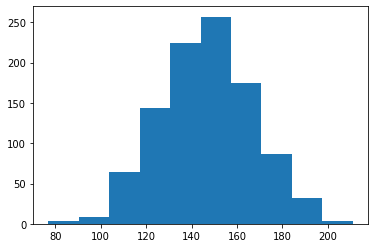

754717
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.175195    0.319423   
1            NaN             NaN NaN NaN  0.234375    0.375260   
2            NaN             NaN NaN NaN  0.145161    0.355263   
3            NaN             NaN NaN NaN  0.140323    0.296196   
4            NaN             NaN NaN NaN  0.174014    0.295768   
5            NaN             NaN NaN NaN  0.107121    0.351717   
6            NaN             NaN NaN NaN  0.086694    0.361702   
7            NaN             NaN NaN NaN  0.155914    0.286885   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.182607        0.020486   0.182607  
1              0.283805        0.028067   0.283805  
2              0.169811        0.021468  

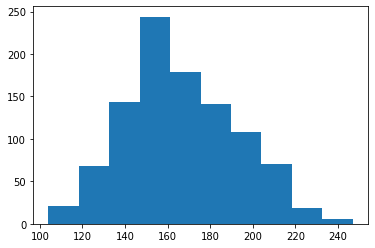

858491
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182796    0.338028   
1            NaN             NaN NaN NaN  0.174424    0.261364   
2            NaN             NaN NaN NaN  0.106481    0.353325   
3            NaN             NaN NaN NaN  0.123656    0.229592   
4            NaN             NaN NaN NaN  0.177595    0.277384   
5            NaN             NaN NaN NaN  0.073253    0.301653   
6            NaN             NaN NaN NaN  0.086694    0.361702   
7            NaN             NaN NaN NaN  0.155914    0.286885   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.201258        0.042254   0.201258  
1              0.148787        0.038510   0.148787  
2              0.126252        0.042373  

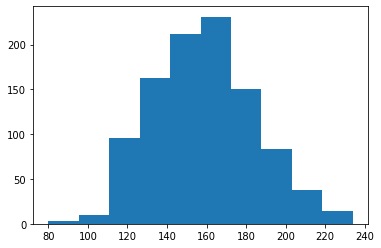

860279
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.174424    0.261364   
1            NaN             NaN NaN NaN  0.182796    0.338028   
2            NaN             NaN NaN NaN  0.177595    0.277384   
3            NaN             NaN NaN NaN  0.160256    0.264742   
4            NaN             NaN NaN NaN  0.174614    0.294146   
5            NaN             NaN NaN NaN  0.073253    0.301653   
6            NaN             NaN NaN NaN  0.086694    0.361702   
7            NaN             NaN NaN NaN  0.155914    0.286885   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.148787        0.038510   0.148787  
1              0.201258        0.042254   0.201258  
2              0.160651        0.023135  

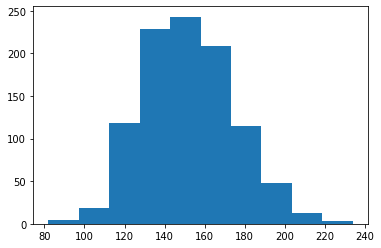

868723
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.225302    0.283477   
1            NaN             NaN NaN NaN  0.151104    0.244000   
2            NaN             NaN NaN NaN  0.057918    0.352778   
3            NaN             NaN NaN NaN  0.098502    0.343243   
4            NaN             NaN NaN NaN  0.154378    0.304078   
5            NaN             NaN NaN NaN  0.093952    0.257905   
6            NaN             NaN NaN NaN  0.114695    0.262774   
7            NaN             NaN NaN NaN  0.058871    0.171687   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.206368        0.039957   0.206368  
1              0.121152        0.052000   0.121152  
2              0.072613        0.016667  

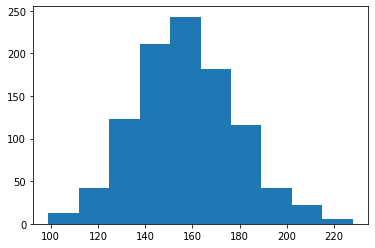

868725
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.151104    0.244000   
1            NaN             NaN NaN NaN  0.225302    0.283477   
2            NaN             NaN NaN NaN  0.154378    0.304078   
3            NaN             NaN NaN NaN  0.098502    0.343243   
4            NaN             NaN NaN NaN  0.057918    0.352778   
5            NaN             NaN NaN NaN  0.093952    0.257905   
6            NaN             NaN NaN NaN  0.114695    0.262774   
7            NaN             NaN NaN NaN  0.058871    0.171687   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.121152        0.052000   0.121152  
1              0.206368        0.039957   0.206368  
2              0.154088        0.017730  

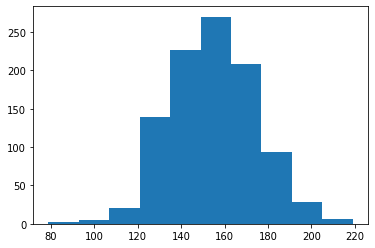

875471
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.156891    0.270000   
1            NaN             NaN NaN NaN  0.110383    0.307447   
2            NaN             NaN NaN NaN  0.172379    0.305866   
3            NaN             NaN NaN NaN  0.136425    0.316279   
4            NaN             NaN NaN NaN  0.227047    0.313984   
5            NaN             NaN NaN NaN  0.110887    0.326271   
6            NaN             NaN NaN NaN  0.077061    0.252632   
7            NaN             NaN NaN NaN  0.096774    0.224359   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.138937        0.031111   0.138937  
1              0.113601        0.023404   0.113601  
2              0.172170        0.030726  

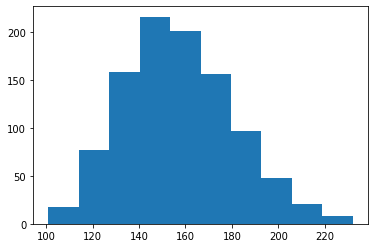

883343
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.214862    0.313307   
1            NaN             NaN NaN NaN  0.172379    0.305866   
2            NaN             NaN NaN NaN  0.133065    0.300893   
3            NaN             NaN NaN NaN  0.077957    0.250000   
4            NaN             NaN NaN NaN  0.227047    0.313984   
5            NaN             NaN NaN NaN  0.110887    0.326271   
6            NaN             NaN NaN NaN  0.077061    0.252632   
7            NaN             NaN NaN NaN  0.096774    0.224359   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.217880        0.023256   0.217880  
1              0.172170        0.030726   0.172170  
2              0.132469        0.025000  

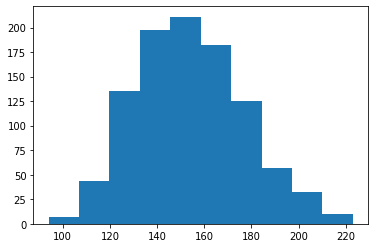

883345
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.160618    0.276892   
1            NaN             NaN NaN NaN  0.172379    0.305866   
2            NaN             NaN NaN NaN  0.133065    0.300893   
3            NaN             NaN NaN NaN  0.143300    0.322746   
4            NaN             NaN NaN NaN  0.069355    0.223958   
5            NaN             NaN NaN NaN  0.110887    0.326271   
6            NaN             NaN NaN NaN  0.077061    0.252632   
7            NaN             NaN NaN NaN  0.096774    0.224359   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.145702        0.027888   0.145702  
1              0.172170        0.030726   0.172170  
2              0.132469        0.025000  

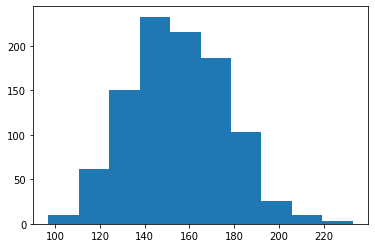

884347
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.227151    0.374762   
1            NaN             NaN NaN NaN  0.149544    0.338154   
2            NaN             NaN NaN NaN  0.131912    0.300412   
3            NaN             NaN NaN NaN  0.125896    0.415552   
4            NaN             NaN NaN NaN  0.079032    0.314815   
5            NaN             NaN NaN NaN  0.069892    0.336207   
6            NaN             NaN NaN NaN  0.112903    0.341667   
7            NaN             NaN NaN NaN  0.096774    0.224359   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.274983        0.028571   0.274983  
1              0.166256        0.037264   0.166256  
2              0.131177        0.022634  

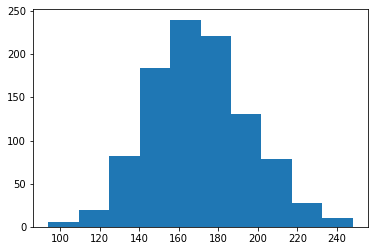

885969
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.151328    0.270833   
1            NaN             NaN NaN NaN  0.143548    0.297872   
2            NaN             NaN NaN NaN  0.182796    0.292254   
3            NaN             NaN NaN NaN  0.116935    0.270161   
4            NaN             NaN NaN NaN  0.182796    0.320423   
5            NaN             NaN NaN NaN  0.091935    0.298387   
6            NaN             NaN NaN NaN  0.112903    0.341667   
7            NaN             NaN NaN NaN  0.096774    0.224359   
8            NaN             NaN NaN NaN  0.050000    0.232639   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.134665        0.041667   0.134665  
1              0.140881        0.053191   0.140881  
2              0.174004        0.039906  

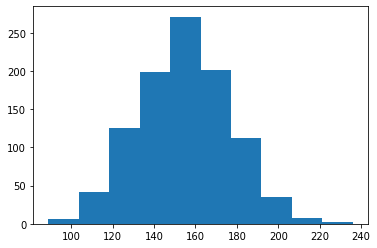

885971
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.216820    0.281762   
1            NaN             NaN NaN NaN  0.147513    0.280778   
2            NaN             NaN NaN NaN  0.096774    0.258242   
3            NaN             NaN NaN NaN  0.154378    0.304078   
4            NaN             NaN NaN NaN  0.057918    0.352778   
5            NaN             NaN NaN NaN  0.189516    0.194728   
6            NaN             NaN NaN NaN  0.159498    0.348262   
7            NaN             NaN NaN NaN  0.065982    0.190594   
8            NaN             NaN NaN NaN  0.055108    0.172872   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.197664        0.042520   0.197664  
1              0.136268        0.032397   0.136268  
2              0.084456        0.034799  

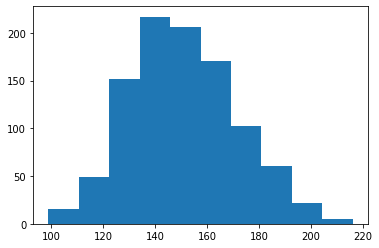

895817
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.179117    0.309524   
1            NaN             NaN NaN NaN  0.150090    0.266997   
2            NaN             NaN NaN NaN  0.332661    0.325021   
3            NaN             NaN NaN NaN  0.168459    0.304251   
4            NaN             NaN NaN NaN  0.252481    0.286905   
5            NaN             NaN NaN NaN  0.189516    0.194728   
6            NaN             NaN NaN NaN  0.159498    0.348262   
7            NaN             NaN NaN NaN  0.065982    0.190594   
8            NaN             NaN NaN NaN  0.055108    0.172872   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.180735        0.026644   0.180735  
1              0.131726        0.026912   0.131726  
2              0.345463        0.025359  

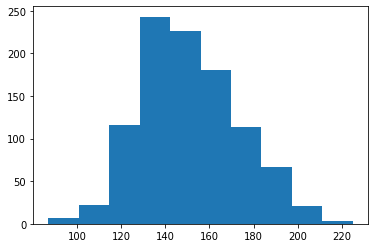

895821
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.145161    0.355263   
1            NaN             NaN NaN NaN  0.154570    0.254132   
2            NaN             NaN NaN NaN  0.125896    0.415552   
3            NaN             NaN NaN NaN  0.098790    0.424528   
4            NaN             NaN NaN NaN  0.252481    0.286905   
5            NaN             NaN NaN NaN  0.189516    0.194728   
6            NaN             NaN NaN NaN  0.159498    0.348262   
7            NaN             NaN NaN NaN  0.065982    0.190594   
8            NaN             NaN NaN NaN  0.055108    0.172872   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.169811        0.021468   0.169811  
1              0.128931        0.033058   0.128931  
2              0.173655        0.030100  

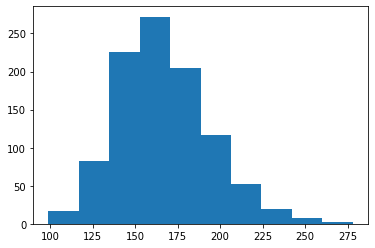

903587
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180314    0.316685   
1            NaN             NaN NaN NaN  0.150090    0.266997   
2            NaN             NaN NaN NaN  0.307232    0.325289   
3            NaN             NaN NaN NaN  0.236559    0.293407   
4            NaN             NaN NaN NaN  0.171902    0.303361   
5            NaN             NaN NaN NaN  0.094758    0.205882   
6            NaN             NaN NaN NaN  0.126344    0.310000   
7            NaN             NaN NaN NaN  0.065982    0.190594   
8            NaN             NaN NaN NaN  0.055108    0.172872   
9            NaN             NaN NaN NaN  0.060484    0.225490   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.186099        0.026345   0.186099  
1              0.131726        0.026912   0.131726  
2              0.319943        0.025165  

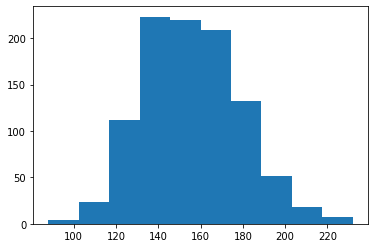

914221
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.171001    0.273897   
1            NaN             NaN NaN NaN  0.174424    0.261364   
2            NaN             NaN NaN NaN  0.085777    0.265625   
3            NaN             NaN NaN NaN  0.173668    0.270898   
4            NaN             NaN NaN NaN  0.177587    0.290498   
5            NaN             NaN NaN NaN  0.102967    0.352140   
6            NaN             NaN NaN NaN  0.157258    0.365854   
7            NaN             NaN NaN NaN  0.299731    0.316594   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.152997        0.023438   0.152997  
1              0.148787        0.038510   0.148787  
2              0.077759        0.007812  

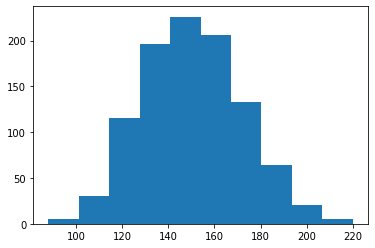

914223
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.171001    0.273897   
1            NaN             NaN NaN NaN  0.174424    0.261364   
2            NaN             NaN NaN NaN  0.085777    0.265625   
3            NaN             NaN NaN NaN  0.173668    0.270898   
4            NaN             NaN NaN NaN  0.177587    0.290498   
5            NaN             NaN NaN NaN  0.102967    0.352140   
6            NaN             NaN NaN NaN  0.157258    0.365854   
7            NaN             NaN NaN NaN  0.299731    0.316594   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.152997        0.023438   0.152997  
1              0.148787        0.038510   0.148787  
2              0.077759        0.007812  

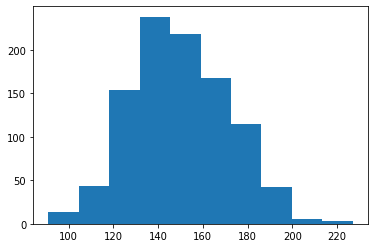

919603
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.174424    0.261364   
1            NaN             NaN NaN NaN  0.182796    0.338028   
2            NaN             NaN NaN NaN  0.085777    0.265625   
3            NaN             NaN NaN NaN  0.177587    0.290498   
4            NaN             NaN NaN NaN  0.173668    0.270898   
5            NaN             NaN NaN NaN  0.139113    0.246575   
6            NaN             NaN NaN NaN  0.157258    0.365854   
7            NaN             NaN NaN NaN  0.102967    0.352140   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.148787        0.038510   0.148787  
1              0.201258        0.042254   0.201258  
2              0.077759        0.007812  

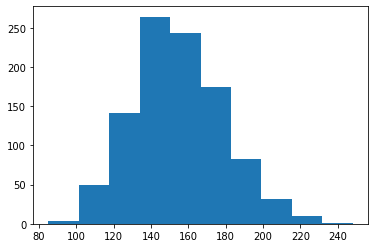

919605
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.171001    0.273897   
1            NaN             NaN NaN NaN  0.174424    0.261364   
2            NaN             NaN NaN NaN  0.085777    0.265625   
3            NaN             NaN NaN NaN  0.173668    0.270898   
4            NaN             NaN NaN NaN  0.139113    0.246575   
5            NaN             NaN NaN NaN  0.177587    0.290498   
6            NaN             NaN NaN NaN  0.102967    0.352140   
7            NaN             NaN NaN NaN  0.157258    0.365854   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.152997        0.023438   0.152997  
1              0.148787        0.038510   0.148787  
2              0.077759        0.007812  

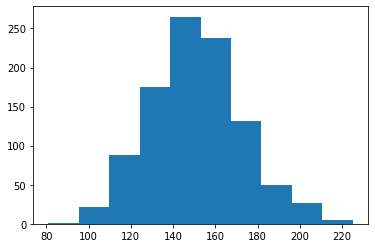

924637
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.096774    0.258242   
1            NaN             NaN NaN NaN  0.147513    0.280778   
2            NaN             NaN NaN NaN  0.154378    0.304078   
3            NaN             NaN NaN NaN  0.108602    0.337558   
4            NaN             NaN NaN NaN  0.189516    0.194728   
5            NaN             NaN NaN NaN  0.159498    0.348262   
6            NaN             NaN NaN NaN  0.105645    0.255319   
7            NaN             NaN NaN NaN  0.157258    0.365854   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.084456        0.034799   0.084456  
1              0.136268        0.032397   0.136268  
2              0.154088        0.017730  

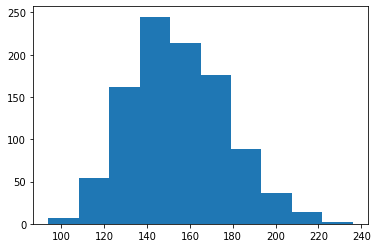

924639
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.147513    0.280778   
1            NaN             NaN NaN NaN  0.154378    0.304078   
2            NaN             NaN NaN NaN  0.096774    0.258242   
3            NaN             NaN NaN NaN  0.105645    0.255319   
4            NaN             NaN NaN NaN  0.108602    0.337558   
5            NaN             NaN NaN NaN  0.189516    0.194728   
6            NaN             NaN NaN NaN  0.159498    0.348262   
7            NaN             NaN NaN NaN  0.129032    0.294118   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.136268        0.032397   0.136268  
1              0.154088        0.017730   0.154088  
2              0.084456        0.034799  

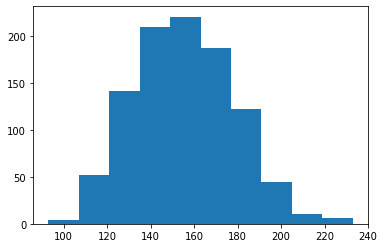

951305
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.216820    0.281762   
1            NaN             NaN NaN NaN  0.152823    0.246867   
2            NaN             NaN NaN NaN  0.105645    0.255319   
3            NaN             NaN NaN NaN  0.154378    0.304078   
4            NaN             NaN NaN NaN  0.096774    0.258242   
5            NaN             NaN NaN NaN  0.159498    0.348262   
6            NaN             NaN NaN NaN  0.108602    0.337558   
7            NaN             NaN NaN NaN  0.129032    0.294118   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.197664        0.042520   0.197664  
1              0.123899        0.051378   0.123899  
2              0.090566        0.035461  

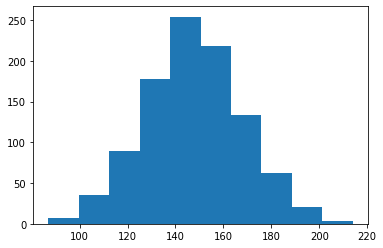

951313
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.152823    0.246867   
1            NaN             NaN NaN NaN  0.216820    0.281762   
2            NaN             NaN NaN NaN  0.105645    0.255319   
3            NaN             NaN NaN NaN  0.154378    0.304078   
4            NaN             NaN NaN NaN  0.096774    0.258242   
5            NaN             NaN NaN NaN  0.159498    0.348262   
6            NaN             NaN NaN NaN  0.108602    0.337558   
7            NaN             NaN NaN NaN  0.129032    0.294118   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.123899        0.051378   0.123899  
1              0.197664        0.042520   0.197664  
2              0.090566        0.035461  

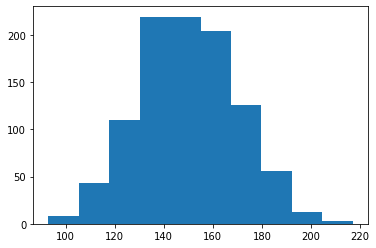

951333
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.136521    0.328685   
1            NaN             NaN NaN NaN  0.173790    0.258869   
2            NaN             NaN NaN NaN  0.173065    0.272039   
3            NaN             NaN NaN NaN  0.102967    0.352140   
4            NaN             NaN NaN NaN  0.177587    0.290498   
5            NaN             NaN NaN NaN  0.182854    0.280073   
6            NaN             NaN NaN NaN  0.108602    0.337558   
7            NaN             NaN NaN NaN  0.129032    0.294118   
8            NaN             NaN NaN NaN  0.139113    0.253425   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.148248        0.053785   0.148248  
1              0.146855        0.038248   0.146855  
2              0.153711        0.022707  

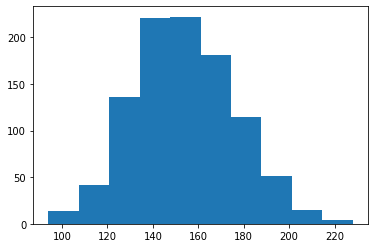

951353
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.175403    0.321928   
1            NaN             NaN NaN NaN  0.162058    0.290632   
2            NaN             NaN NaN NaN  0.286962    0.326689   
3            NaN             NaN NaN NaN  0.169556    0.303632   
4            NaN             NaN NaN NaN  0.069648    0.308962   
5            NaN             NaN NaN NaN  0.163906    0.335551   
6            NaN             NaN NaN NaN  0.227761    0.297150   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.184248        0.026474   0.184248  
1              0.154238        0.027088   0.154238  
2              0.300664        0.026576  

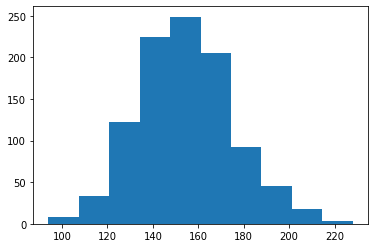

951355
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.236804    0.399701   
1            NaN             NaN NaN NaN  0.139268    0.341316   
2            NaN             NaN NaN NaN  0.131912    0.300412   
3            NaN             NaN NaN NaN  0.169721    0.403608   
4            NaN             NaN NaN NaN  0.145161    0.355263   
5            NaN             NaN NaN NaN  0.163906    0.335551   
6            NaN             NaN NaN NaN  0.227761    0.297150   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.305317        0.031437   0.305317  
1              0.156870        0.036842   0.156870  
2              0.131177        0.022634  

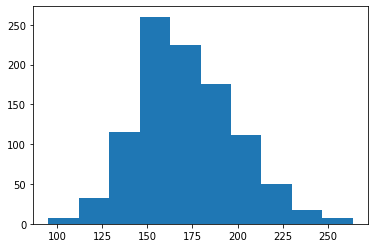

951363
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.235624    0.401079   
1            NaN             NaN NaN NaN  0.139268    0.341316   
2            NaN             NaN NaN NaN  0.131912    0.300412   
3            NaN             NaN NaN NaN  0.163745    0.402041   
4            NaN             NaN NaN NaN  0.145161    0.355263   
5            NaN             NaN NaN NaN  0.104839    0.288265   
6            NaN             NaN NaN NaN  0.227761    0.297150   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.304895        0.030935   0.304895  
1              0.156870        0.036842   0.156870  
2              0.131177        0.022634  

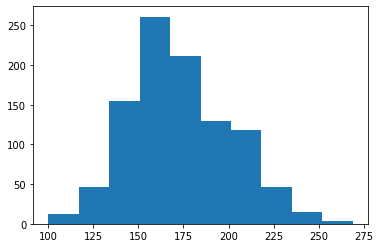

951371
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.175161    0.336268   
1            NaN             NaN NaN NaN  0.147401    0.270173   
2            NaN             NaN NaN NaN  0.283956    0.331577   
3            NaN             NaN NaN NaN  0.230287    0.301222   
4            NaN             NaN NaN NaN  0.145161    0.355263   
5            NaN             NaN NaN NaN  0.104839    0.288265   
6            NaN             NaN NaN NaN  0.227761    0.297150   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.192201        0.027729   0.192201  
1              0.131027        0.041787   0.131027  
2              0.302052        0.025436  

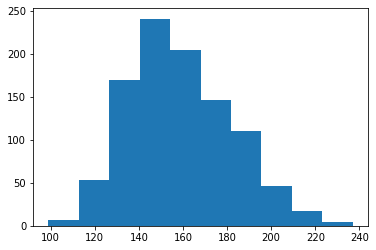

958415
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.152823    0.246867   
1            NaN             NaN NaN NaN  0.210331    0.280689   
2            NaN             NaN NaN NaN  0.153226    0.351316   
3            NaN             NaN NaN NaN  0.096774    0.258242   
4            NaN             NaN NaN NaN  0.104839    0.332031   
5            NaN             NaN NaN NaN  0.066820    0.230769   
6            NaN             NaN NaN NaN  0.154378    0.304078   
7            NaN             NaN NaN NaN  0.164747    0.281667   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.123899        0.051378   0.123899  
1              0.191229        0.041417   0.191229  
2              0.176763        0.030263  

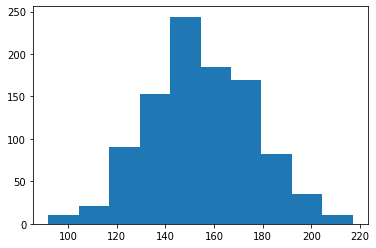

958419
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.209465    0.278780   
1            NaN             NaN NaN NaN  0.152823    0.246867   
2            NaN             NaN NaN NaN  0.105645    0.255319   
3            NaN             NaN NaN NaN  0.154378    0.304078   
4            NaN             NaN NaN NaN  0.160866    0.352387   
5            NaN             NaN NaN NaN  0.092742    0.257273   
6            NaN             NaN NaN NaN  0.149194    0.274038   
7            NaN             NaN NaN NaN  0.164747    0.281667   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.189176        0.041463   0.189176  
1              0.123899        0.051378   0.123899  
2              0.090566        0.035461  

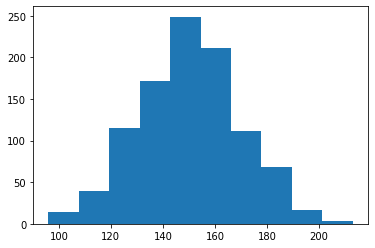

958421
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.152823    0.246867   
1            NaN             NaN NaN NaN  0.105645    0.255319   
2            NaN             NaN NaN NaN  0.210298    0.277462   
3            NaN             NaN NaN NaN  0.163837    0.350000   
4            NaN             NaN NaN NaN  0.097475    0.268272   
5            NaN             NaN NaN NaN  0.104839    0.332031   
6            NaN             NaN NaN NaN  0.149194    0.274038   
7            NaN             NaN NaN NaN  0.164747    0.281667   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.123899        0.051378   0.123899  
1              0.090566        0.035461   0.090566  
2              0.189002        0.041667  

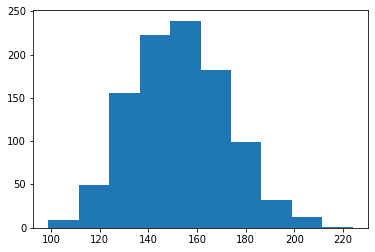

963697
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.176344    0.308673   
1            NaN             NaN NaN NaN  0.165323    0.307381   
2            NaN             NaN NaN NaN  0.163906    0.335551   
3            NaN             NaN NaN NaN  0.232527    0.302142   
4            NaN             NaN NaN NaN  0.065524    0.309932   
5            NaN             NaN NaN NaN  0.076246    0.232609   
6            NaN             NaN NaN NaN  0.153226    0.256250   
7            NaN             NaN NaN NaN  0.164747    0.281667   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.177568        0.026239   0.177568  
1              0.166256        0.041962   0.166256  
2              0.180010        0.039924  

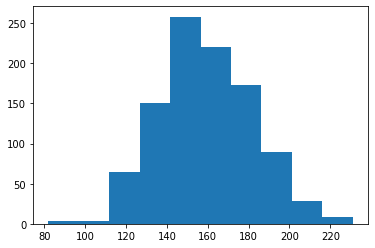

963699
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.177419    0.335404   
1            NaN             NaN NaN NaN  0.176344    0.308673   
2            NaN             NaN NaN NaN  0.147401    0.270173   
3            NaN             NaN NaN NaN  0.165323    0.307381   
4            NaN             NaN NaN NaN  0.065524    0.309932   
5            NaN             NaN NaN NaN  0.163906    0.335551   
6            NaN             NaN NaN NaN  0.232527    0.302142   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.027174   0.194070  
1              0.177568        0.026239   0.177568  
2              0.131027        0.041787  

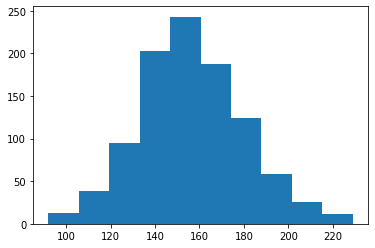

966745
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.174448    0.334884   
1            NaN             NaN NaN NaN  0.176344    0.308673   
2            NaN             NaN NaN NaN  0.278122    0.331286   
3            NaN             NaN NaN NaN  0.170384    0.308894   
4            NaN             NaN NaN NaN  0.163906    0.335551   
5            NaN             NaN NaN NaN  0.070565    0.341346   
6            NaN             NaN NaN NaN  0.232527    0.302142   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.190665        0.027132   0.190665  
1              0.177568        0.026239   0.177568  
2              0.295759        0.025289  

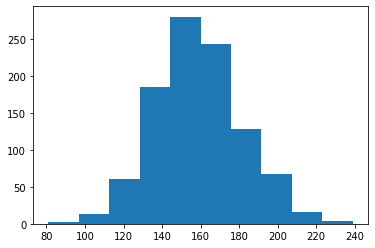

966759
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.167377    0.269514   
1            NaN             NaN NaN NaN  0.136521    0.328685   
2            NaN             NaN NaN NaN  0.184635    0.308921   
3            NaN             NaN NaN NaN  0.177587    0.290498   
4            NaN             NaN NaN NaN  0.196711    0.293629   
5            NaN             NaN NaN NaN  0.102999    0.349363   
6            NaN             NaN NaN NaN  0.082258    0.361607   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.147502        0.022116   0.147502  
1              0.148248        0.053785   0.148248  
2              0.185700        0.031938  

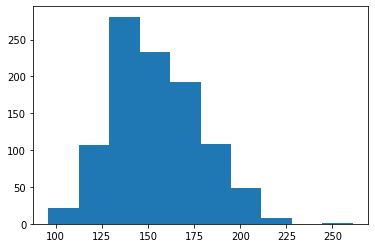

967081
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.214862    0.313307   
1            NaN             NaN NaN NaN  0.149504    0.277559   
2            NaN             NaN NaN NaN  0.160906    0.286932   
3            NaN             NaN NaN NaN  0.133333    0.318441   
4            NaN             NaN NaN NaN  0.098566    0.247899   
5            NaN             NaN NaN NaN  0.122984    0.298077   
6            NaN             NaN NaN NaN  0.077957    0.250000   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.217880        0.023256   0.217880  
1              0.136430        0.027559   0.136430  
2              0.151243        0.031818  

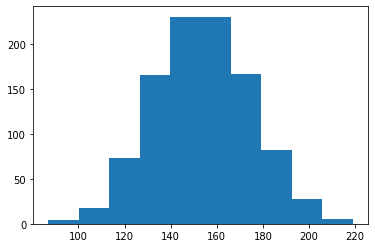

995467
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.159274    0.400602   
1            NaN             NaN NaN NaN  0.139268    0.341316   
2            NaN             NaN NaN NaN  0.167563    0.315051   
3            NaN             NaN NaN NaN  0.133333    0.318441   
4            NaN             NaN NaN NaN  0.098566    0.247899   
5            NaN             NaN NaN NaN  0.122984    0.298077   
6            NaN             NaN NaN NaN  0.077957    0.250000   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.209119        0.030120   0.209119  
1              0.156870        0.036842   0.156870  
2              0.172607        0.033163  

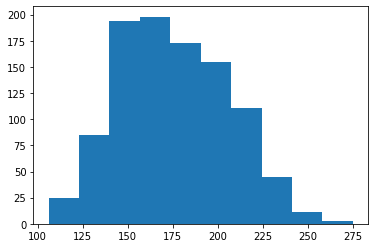

1001349
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.232903    0.403614   
1            NaN             NaN NaN NaN  0.167563    0.315051   
2            NaN             NaN NaN NaN  0.219758    0.314159   
3            NaN             NaN NaN NaN  0.104839    0.288265   
4            NaN             NaN NaN NaN  0.098566    0.247899   
5            NaN             NaN NaN NaN  0.122984    0.298077   
6            NaN             NaN NaN NaN  0.077957    0.250000   
7            NaN             NaN NaN NaN  0.076246    0.232609   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.303396        0.036145   0.303396  
1              0.172607        0.033163   0.172607  
2              0.223270        0.013274 

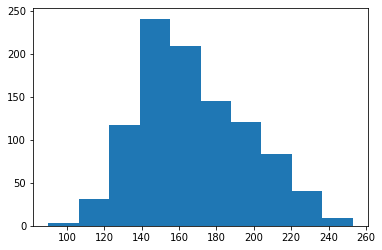

1001351
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.231079    0.399805   
1            NaN             NaN NaN NaN  0.104839    0.353571   
2            NaN             NaN NaN NaN  0.219758    0.314159   
3            NaN             NaN NaN NaN  0.167563    0.315051   
4            NaN             NaN NaN NaN  0.081797    0.288265   
5            NaN             NaN NaN NaN  0.045161    0.262821   
6            NaN             NaN NaN NaN  0.043011    0.212121   
7            NaN             NaN NaN NaN  0.076246    0.210526   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.298258        0.035019   0.298258  
1              0.124528        0.028571   0.124528  
2              0.223270        0.013274 

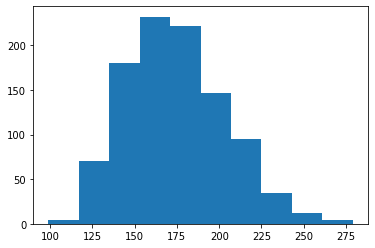

1001353
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.222521    0.399288   
1            NaN             NaN NaN NaN  0.104839    0.353571   
2            NaN             NaN NaN NaN  0.167563    0.315051   
3            NaN             NaN NaN NaN  0.219758    0.314159   
4            NaN             NaN NaN NaN  0.081797    0.288265   
5            NaN             NaN NaN NaN  0.045161    0.262821   
6            NaN             NaN NaN NaN  0.043011    0.212121   
7            NaN             NaN NaN NaN  0.076246    0.210526   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.287212        0.034974   0.287212  
1              0.124528        0.028571   0.124528  
2              0.172607        0.033163 

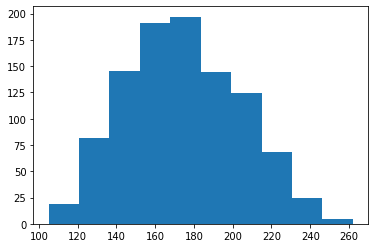

1007657
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.136364    0.302030   
1            NaN             NaN NaN NaN  0.163837    0.350000   
2            NaN             NaN NaN NaN  0.100691    0.328390   
3            NaN             NaN NaN NaN  0.055831    0.165049   
4            NaN             NaN NaN NaN  0.129032    0.294118   
5            NaN             NaN NaN NaN  0.045161    0.262821   
6            NaN             NaN NaN NaN  0.043011    0.212121   
7            NaN             NaN NaN NaN  0.076246    0.210526   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.136078        0.015228   0.136078  
1              0.187686        0.035802   0.187686  
2              0.111411        0.047669 

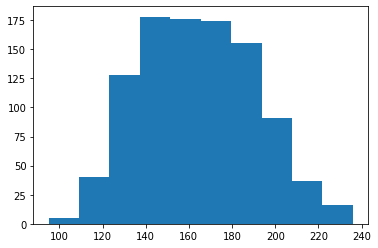

1007659
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.237327    0.350352   
1            NaN             NaN NaN NaN  0.094758    0.205882   
2            NaN             NaN NaN NaN  0.235112    0.309949   
3            NaN             NaN NaN NaN  0.156452    0.299020   
4            NaN             NaN NaN NaN  0.233217    0.301942   
5            NaN             NaN NaN NaN  0.100806    0.314815   
6            NaN             NaN NaN NaN  0.043011    0.212121   
7            NaN             NaN NaN NaN  0.076246    0.210526   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.268194        0.032864   0.268194  
1              0.066038        0.029412   0.066038  
2              0.235123        0.025510 

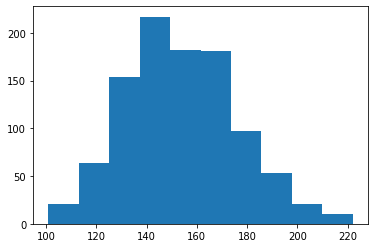

1034825
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.281250    0.330836   
1            NaN             NaN NaN NaN  0.237327    0.350352   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.163906    0.335551   
4            NaN             NaN NaN NaN  0.236922    0.301824   
5            NaN             NaN NaN NaN  0.235112    0.309949   
6            NaN             NaN NaN NaN  0.068311    0.336957   
7            NaN             NaN NaN NaN  0.076246    0.210526   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.298585        0.025784   0.298585  
1              0.268194        0.032864   0.268194  
2              0.171952        0.042788 

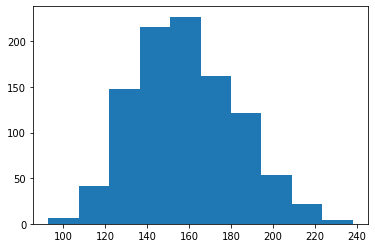

1034829
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.281250    0.330836   
1            NaN             NaN NaN NaN  0.237327    0.350352   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.231324    0.301197   
4            NaN             NaN NaN NaN  0.163906    0.335551   
5            NaN             NaN NaN NaN  0.134073    0.292553   
6            NaN             NaN NaN NaN  0.068996    0.345930   
7            NaN             NaN NaN NaN  0.076246    0.210526   
8            NaN             NaN NaN NaN  0.153226    0.256250   
9            NaN             NaN NaN NaN  0.072005    0.219424   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.298585        0.025784   0.298585  
1              0.268194        0.032864   0.268194  
2              0.171952        0.042788 

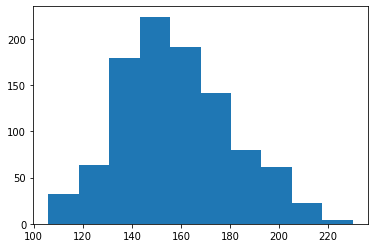

1085495
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.186360    0.269387   
1            NaN             NaN NaN NaN  0.074373    0.358696   
2            NaN             NaN NaN NaN  0.330645    0.302679   
3            NaN             NaN NaN NaN  0.150202    0.304538   
4            NaN             NaN NaN NaN  0.191308    0.294195   
5            NaN             NaN NaN NaN  0.170123    0.349138   
6            NaN             NaN NaN NaN  0.177419    0.307971   
7            NaN             NaN NaN NaN  0.106183    0.291176   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.163385        0.035167   0.163385  
1              0.092243        0.021739   0.092243  
2              0.319811        0.025595 

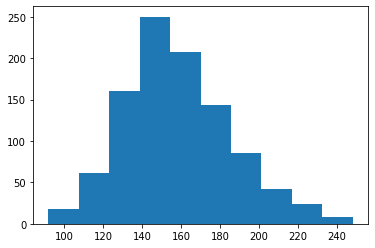

1098211
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.285208    0.334507   
1            NaN             NaN NaN NaN  0.187965    0.311181   
2            NaN             NaN NaN NaN  0.117866    0.286946   
3            NaN             NaN NaN NaN  0.209677    0.363169   
4            NaN             NaN NaN NaN  0.238420    0.299497   
5            NaN             NaN NaN NaN  0.076246    0.232609   
6            NaN             NaN NaN NaN  0.156452    0.299020   
7            NaN             NaN NaN NaN  0.153226    0.256250   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.306029        0.025151   0.306029  
1              0.190292        0.029536   0.190292  
2              0.112724        0.041872 

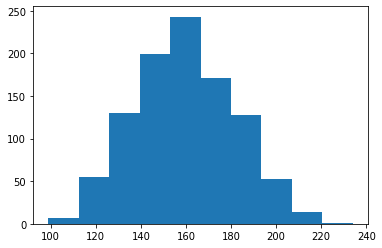

1115807
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.139401    0.273438   
2            NaN             NaN NaN NaN  0.330645    0.302679   
3            NaN             NaN NaN NaN  0.177419    0.307971   
4            NaN             NaN NaN NaN  0.096774    0.331731   
5            NaN             NaN NaN NaN  0.065323    0.310440   
6            NaN             NaN NaN NaN  0.052419    0.408333   
7            NaN             NaN NaN NaN  0.051075    0.227273   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.125786        0.023438   0.125786  
2              0.319811        0.025595 

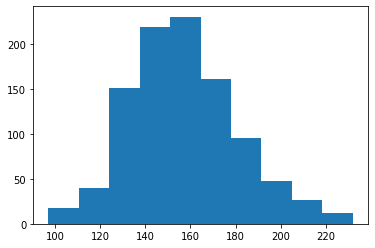

1115808
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.186360    0.269387   
2            NaN             NaN NaN NaN  0.330645    0.302679   
3            NaN             NaN NaN NaN  0.177419    0.307971   
4            NaN             NaN NaN NaN  0.065323    0.310440   
5            NaN             NaN NaN NaN  0.052419    0.408333   
6            NaN             NaN NaN NaN  0.052419    0.408333   
7            NaN             NaN NaN NaN  0.051075    0.227273   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.163385        0.035167   0.163385  
2              0.319811        0.025595 

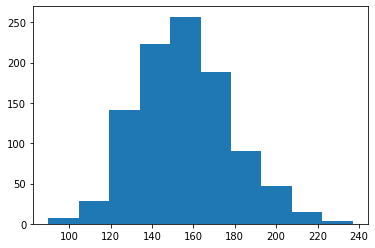

1115809
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.186360    0.269387   
2            NaN             NaN NaN NaN  0.330645    0.302679   
3            NaN             NaN NaN NaN  0.177419    0.307971   
4            NaN             NaN NaN NaN  0.139401    0.273438   
5            NaN             NaN NaN NaN  0.106631    0.277344   
6            NaN             NaN NaN NaN  0.065323    0.310440   
7            NaN             NaN NaN NaN  0.051075    0.227273   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.163385        0.035167   0.163385  
2              0.319811        0.025595 

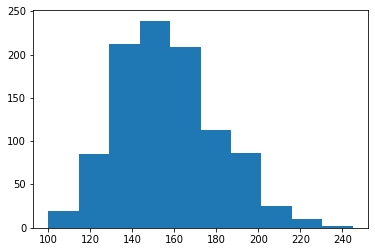

1117821
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.330645    0.302679   
2            NaN             NaN NaN NaN  0.186360    0.269387   
3            NaN             NaN NaN NaN  0.191308    0.294195   
4            NaN             NaN NaN NaN  0.177419    0.307971   
5            NaN             NaN NaN NaN  0.074373    0.358696   
6            NaN             NaN NaN NaN  0.065323    0.310440   
7            NaN             NaN NaN NaN  0.051075    0.227273   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.319811        0.025595   0.319811  
2              0.163385        0.035167 

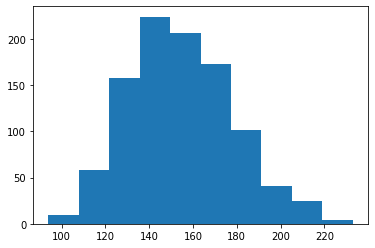

1117822
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.186360    0.269387   
2            NaN             NaN NaN NaN  0.330645    0.302679   
3            NaN             NaN NaN NaN  0.191308    0.294195   
4            NaN             NaN NaN NaN  0.074373    0.358696   
5            NaN             NaN NaN NaN  0.177419    0.307971   
6            NaN             NaN NaN NaN  0.065323    0.310440   
7            NaN             NaN NaN NaN  0.051075    0.227273   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.163385        0.035167   0.163385  
2              0.319811        0.025595 

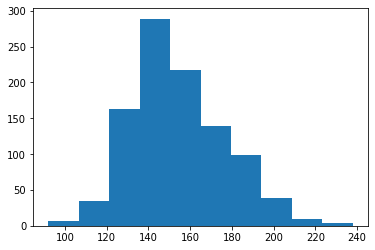

1119502
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.174892    0.339967   
1            NaN             NaN NaN NaN  0.281106    0.332669   
2            NaN             NaN NaN NaN  0.190008    0.309583   
3            NaN             NaN NaN NaN  0.235599    0.300827   
4            NaN             NaN NaN NaN  0.156452    0.299020   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.072581    0.331579   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194030        0.026974   0.194030  
1              0.300090        0.024900   0.300090  
2              0.191287        0.035253 

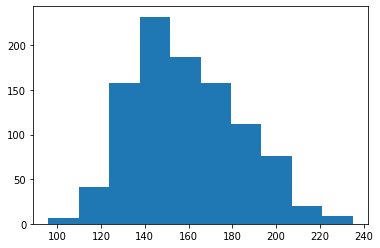

1119544
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.175900    0.341963   
1            NaN             NaN NaN NaN  0.190008    0.309583   
2            NaN             NaN NaN NaN  0.242339    0.347424   
3            NaN             NaN NaN NaN  0.170384    0.308894   
4            NaN             NaN NaN NaN  0.283196    0.336929   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.072581    0.331579   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.196245        0.027001   0.196245  
1              0.191287        0.035253   0.191287  
2              0.271384        0.037842 

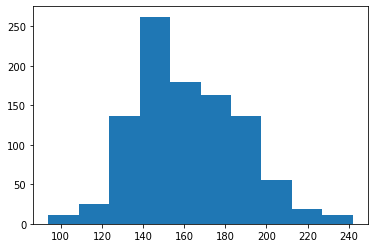

1120093
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.173963    0.341930   
1            NaN             NaN NaN NaN  0.190008    0.309583   
2            NaN             NaN NaN NaN  0.072581    0.331579   
3            NaN             NaN NaN NaN  0.278776    0.336102   
4            NaN             NaN NaN NaN  0.238420    0.299497   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.072581    0.331579   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194160        0.026899   0.194160  
1              0.191287        0.035253   0.191287  
2              0.083416        0.036842 

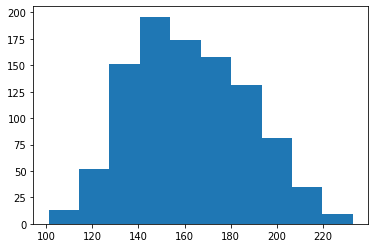

1120293
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.106631    0.277344   
2            NaN             NaN NaN NaN  0.315284    0.301960   
3            NaN             NaN NaN NaN  0.198178    0.294895   
4            NaN             NaN NaN NaN  0.065323    0.310440   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.072581    0.331579   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.099231        0.027344   0.099231  
2              0.304582        0.025534 

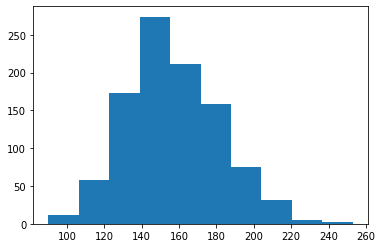

1122285
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.178635    0.343935   
1            NaN             NaN NaN NaN  0.187020    0.307087   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.272135    0.333435   
4            NaN             NaN NaN NaN  0.254839    0.308282   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.072581    0.331579   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200310        0.025148   0.200310  
1              0.186882        0.035925   0.186882  
2              0.171952        0.042788 

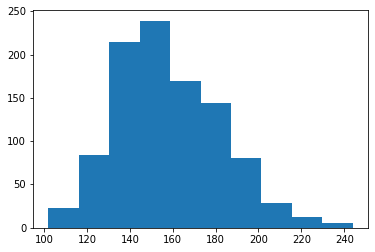

1122286
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.185671    0.307599   
1            NaN             NaN NaN NaN  0.182214    0.342497   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.270161    0.333031   
4            NaN             NaN NaN NaN  0.242440    0.306338   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.072581    0.331579   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.065092    0.299213   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.185900        0.035818   0.185900  
1              0.203298        0.026060   0.203298  
2              0.171952        0.042788 

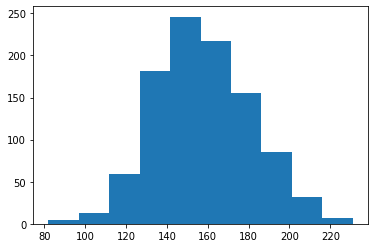

1122287
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182214    0.342497   
1            NaN             NaN NaN NaN  0.182185    0.306840   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.244960    0.304283   
4            NaN             NaN NaN NaN  0.072581    0.331579   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.209677    0.363169   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.100806    0.314815   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.203298        0.026060   0.203298  
1              0.182104        0.035645   0.182104  
2              0.171952        0.042788 

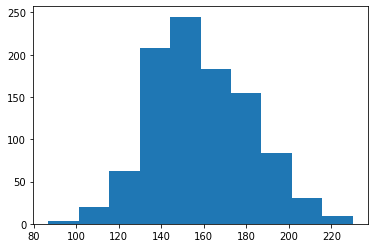

1122729
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.242903    0.342545   
1            NaN             NaN NaN NaN  0.182214    0.342497   
2            NaN             NaN NaN NaN  0.172939    0.268564   
3            NaN             NaN NaN NaN  0.238420    0.299497   
4            NaN             NaN NaN NaN  0.244960    0.304283   
5            NaN             NaN NaN NaN  0.238420    0.299497   
6            NaN             NaN NaN NaN  0.209677    0.363169   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.100806    0.314815   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.268176        0.039846   0.268176  
1              0.203298        0.026060   0.203298  
2              0.151642        0.014851 

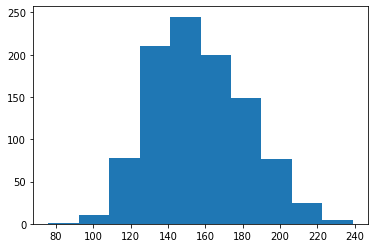

1127300
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.186360    0.269387   
2            NaN             NaN NaN NaN  0.196573    0.293103   
3            NaN             NaN NaN NaN  0.177419    0.307971   
4            NaN             NaN NaN NaN  0.198178    0.294895   
5            NaN             NaN NaN NaN  0.146953    0.342486   
6            NaN             NaN NaN NaN  0.209677    0.363169   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.100806    0.314815   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.163385        0.035167   0.163385  
2              0.187107        0.022167 

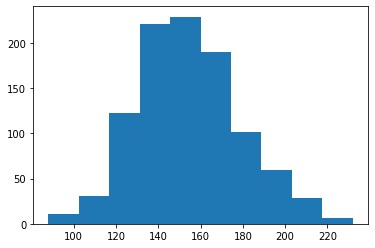

1127301
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.186360    0.269387   
1            NaN             NaN NaN NaN  0.170123    0.349138   
2            NaN             NaN NaN NaN  0.196573    0.293103   
3            NaN             NaN NaN NaN  0.177419    0.307971   
4            NaN             NaN NaN NaN  0.198178    0.294895   
5            NaN             NaN NaN NaN  0.146953    0.342486   
6            NaN             NaN NaN NaN  0.096774    0.331731   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.100806    0.314815   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.163385        0.035167   0.163385  
1              0.194070        0.025862   0.194070  
2              0.187107        0.022167 

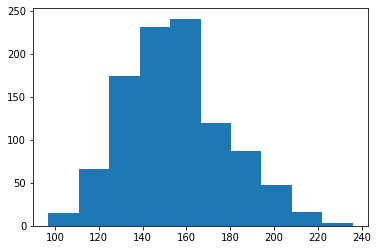

1133817
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182214    0.342497   
1            NaN             NaN NaN NaN  0.182185    0.306840   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.244960    0.304283   
4            NaN             NaN NaN NaN  0.132827    0.297980   
5            NaN             NaN NaN NaN  0.209677    0.363169   
6            NaN             NaN NaN NaN  0.096774    0.331731   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.100806    0.314815   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.203298        0.026060   0.203298  
1              0.182104        0.035645   0.182104  
2              0.171952        0.042788 

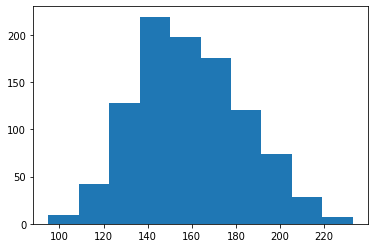

1133821
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182214    0.342497   
1            NaN             NaN NaN NaN  0.182185    0.306840   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.209677    0.363169   
4            NaN             NaN NaN NaN  0.132827    0.297980   
5            NaN             NaN NaN NaN  0.209677    0.363169   
6            NaN             NaN NaN NaN  0.096774    0.331731   
7            NaN             NaN NaN NaN  0.052419    0.191667   
8            NaN             NaN NaN NaN  0.100806    0.314815   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.203298        0.026060   0.203298  
1              0.182104        0.035645   0.182104  
2              0.171952        0.042788 

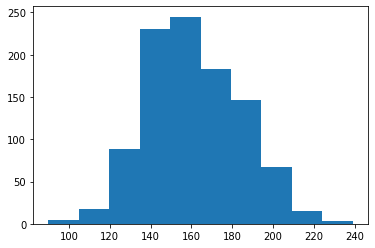

1134031
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.187588    0.272401   
1            NaN             NaN NaN NaN  0.172939    0.313119   
2            NaN             NaN NaN NaN  0.163226    0.287194   
3            NaN             NaN NaN NaN  0.108295    0.240099   
4            NaN             NaN NaN NaN  0.093672    0.264482   
5            NaN             NaN NaN NaN  0.116935    0.289171   
6            NaN             NaN NaN NaN  0.055831    0.165049   
7            NaN             NaN NaN NaN  0.163837    0.350000   
8            NaN             NaN NaN NaN  0.041667    0.087838   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.166256        0.044355   0.166256  
1              0.176799        0.017327   0.176799  
2              0.153459        0.028249 

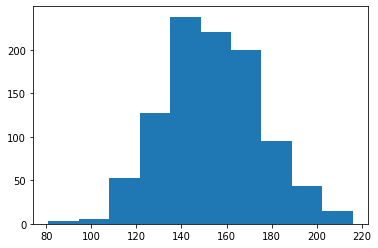

1140070
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.170123    0.349138   
1            NaN             NaN NaN NaN  0.315284    0.301960   
2            NaN             NaN NaN NaN  0.196573    0.293103   
3            NaN             NaN NaN NaN  0.146953    0.342486   
4            NaN             NaN NaN NaN  0.198178    0.294895   
5            NaN             NaN NaN NaN  0.116935    0.289171   
6            NaN             NaN NaN NaN  0.055831    0.165049   
7            NaN             NaN NaN NaN  0.163837    0.350000   
8            NaN             NaN NaN NaN  0.041667    0.087838   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.194070        0.025862   0.194070  
1              0.304582        0.025534   0.304582  
2              0.187107        0.022167 

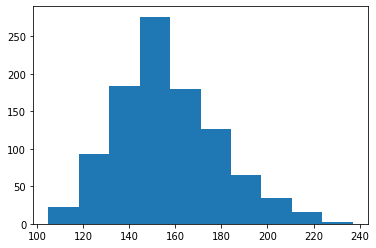

1140992
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182214    0.342497   
1            NaN             NaN NaN NaN  0.182185    0.306840   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.238420    0.299497   
4            NaN             NaN NaN NaN  0.271889    0.332892   
5            NaN             NaN NaN NaN  0.072581    0.331579   
6            NaN             NaN NaN NaN  0.055831    0.165049   
7            NaN             NaN NaN NaN  0.163837    0.350000   
8            NaN             NaN NaN NaN  0.041667    0.087838   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.203298        0.026060   0.203298  
1              0.182104        0.035645   0.182104  
2              0.171952        0.042788 

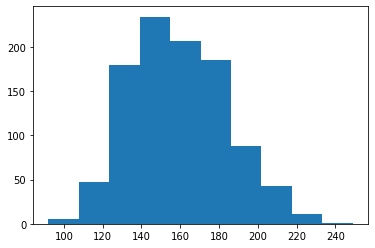

1140993
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.242903    0.342545   
1            NaN             NaN NaN NaN  0.271889    0.332892   
2            NaN             NaN NaN NaN  0.170384    0.308894   
3            NaN             NaN NaN NaN  0.182214    0.342497   
4            NaN             NaN NaN NaN  0.244960    0.304283   
5            NaN             NaN NaN NaN  0.072581    0.331579   
6            NaN             NaN NaN NaN  0.055831    0.165049   
7            NaN             NaN NaN NaN  0.163837    0.350000   
8            NaN             NaN NaN NaN  0.041667    0.087838   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.268176        0.039846   0.268176  
1              0.290720        0.024397   0.290720  
2              0.171952        0.042788 

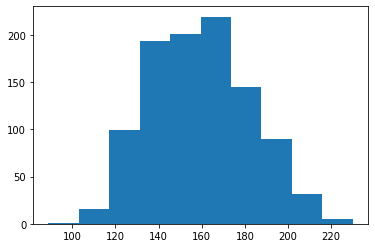

1142501
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.052786    0.310241   
1            NaN             NaN NaN NaN  0.161290    0.320513   
2            NaN             NaN NaN NaN  0.149002    0.323961   
3            NaN             NaN NaN NaN  0.125672    0.265075   
4            NaN             NaN NaN NaN  0.120968    0.191406   
5            NaN             NaN NaN NaN  0.054839    0.237179   
6            NaN             NaN NaN NaN  0.123656    0.341837   
7            NaN             NaN NaN NaN  0.046371    0.305556   
8            NaN             NaN NaN NaN  0.041667    0.087838   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058891        0.030120   0.058891  
1              0.169328        0.040293   0.169328  
2              0.158730        0.037897 

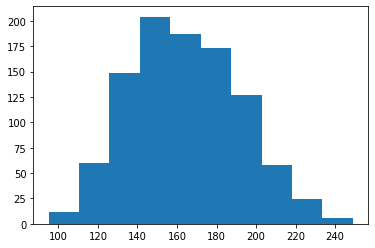

1142505
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.161290    0.320513   
1            NaN             NaN NaN NaN  0.052786    0.310241   
2            NaN             NaN NaN NaN  0.153927    0.279762   
3            NaN             NaN NaN NaN  0.149002    0.323961   
4            NaN             NaN NaN NaN  0.054839    0.237179   
5            NaN             NaN NaN NaN  0.123656    0.341837   
6            NaN             NaN NaN NaN  0.038018    0.312500   
7            NaN             NaN NaN NaN  0.046371    0.305556   
8            NaN             NaN NaN NaN  0.041667    0.087838   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.169328        0.040293   0.169328  
1              0.058891        0.030120   0.058891  
2              0.141373        0.032468 

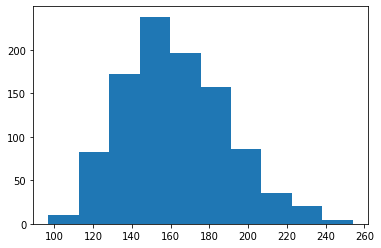

1142914
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.177702    0.276085   
1            NaN             NaN NaN NaN  0.196573    0.293103   
2            NaN             NaN NaN NaN  0.156381    0.348614   
3            NaN             NaN NaN NaN  0.175067    0.303670   
4            NaN             NaN NaN NaN  0.198178    0.294895   
5            NaN             NaN NaN NaN  0.135753    0.318925   
6            NaN             NaN NaN NaN  0.072581    0.312500   
7            NaN             NaN NaN NaN  0.064516    0.305556   
8            NaN             NaN NaN NaN  0.052419    0.408333   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.159991        0.021325   0.159991  
1              0.187107        0.022167   0.187107  
2              0.178835        0.025586 

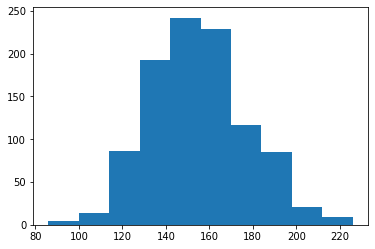

1142915
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.240323    0.284632   
1            NaN             NaN NaN NaN  0.185036    0.382831   
2            NaN             NaN NaN NaN  0.105645    0.281915   
3            NaN             NaN NaN NaN  0.173861    0.378096   
4            NaN             NaN NaN NaN  0.198178    0.294895   
5            NaN             NaN NaN NaN  0.135753    0.318925   
6            NaN             NaN NaN NaN  0.072581    0.312500   
7            NaN             NaN NaN NaN  0.064516    0.305556   
8            NaN             NaN NaN NaN  0.052419    0.408333   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.220545        0.035714   0.220545  
1              0.230608        0.042343   0.230608  
2              0.100000        0.031915 

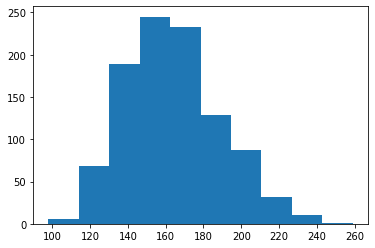

1142916
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.076613    0.214286   
1            NaN             NaN NaN NaN  0.172939    0.313119   
2            NaN             NaN NaN NaN  0.188117    0.277685   
3            NaN             NaN NaN NaN  0.103495    0.295181   
4            NaN             NaN NaN NaN  0.102375    0.332657   
5            NaN             NaN NaN NaN  0.135753    0.318925   
6            NaN             NaN NaN NaN  0.072581    0.312500   
7            NaN             NaN NaN NaN  0.064516    0.305556   
8            NaN             NaN NaN NaN  0.052419    0.408333   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.056604        0.011905   0.056604  
1              0.176799        0.017327   0.176799  
2              0.169940        0.042366 

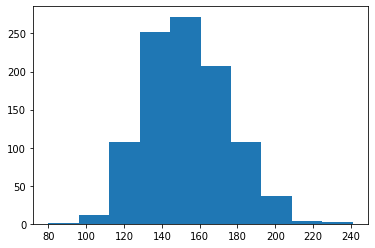

1142917
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.156381    0.348614   
1            NaN             NaN NaN NaN  0.174395    0.265193   
2            NaN             NaN NaN NaN  0.196573    0.293103   
3            NaN             NaN NaN NaN  0.175067    0.303670   
4            NaN             NaN NaN NaN  0.198178    0.294895   
5            NaN             NaN NaN NaN  0.135753    0.318925   
6            NaN             NaN NaN NaN  0.064516    0.305556   
7            NaN             NaN NaN NaN  0.072581    0.312500   
8            NaN             NaN NaN NaN  0.052419    0.408333   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.178835        0.025586   0.178835  
1              0.150943        0.024862   0.150943  
2              0.187107        0.022167 

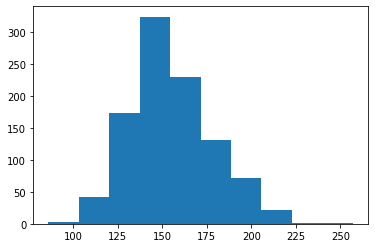

1142918
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.076613    0.214286   
1            NaN             NaN NaN NaN  0.188117    0.277685   
2            NaN             NaN NaN NaN  0.172939    0.313119   
3            NaN             NaN NaN NaN  0.103495    0.295181   
4            NaN             NaN NaN NaN  0.116935    0.289171   
5            NaN             NaN NaN NaN  0.102375    0.332657   
6            NaN             NaN NaN NaN  0.163837    0.350000   
7            NaN             NaN NaN NaN  0.072581    0.312500   
8            NaN             NaN NaN NaN  0.052419    0.408333   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.056604        0.011905   0.056604  
1              0.169940        0.042366   0.169940  
2              0.176799        0.017327 

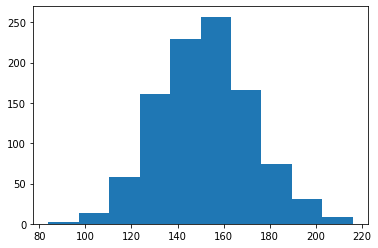

1142919
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.240323    0.284632   
1            NaN             NaN NaN NaN  0.187606    0.379338   
2            NaN             NaN NaN NaN  0.170251    0.374372   
3            NaN             NaN NaN NaN  0.116935    0.295699   
4            NaN             NaN NaN NaN  0.167563    0.315051   
5            NaN             NaN NaN NaN  0.082258    0.279018   
6            NaN             NaN NaN NaN  0.161290    0.252976   
7            NaN             NaN NaN NaN  0.067742    0.218085   
8            NaN             NaN NaN NaN  0.052419    0.408333   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.220545        0.035714   0.220545  
1              0.231546        0.040672   0.231546  
2              0.208246        0.032035 

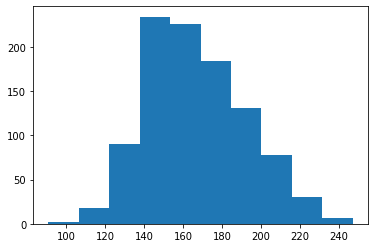

1144150
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.188117    0.277685   
1            NaN             NaN NaN NaN  0.172939    0.313119   
2            NaN             NaN NaN NaN  0.155818    0.290861   
3            NaN             NaN NaN NaN  0.103495    0.295181   
4            NaN             NaN NaN NaN  0.141321    0.303985   
5            NaN             NaN NaN NaN  0.116935    0.289171   
6            NaN             NaN NaN NaN  0.102375    0.332657   
7            NaN             NaN NaN NaN  0.107527    0.232558   
8            NaN             NaN NaN NaN  0.052419    0.408333   
9            NaN             NaN NaN NaN  0.096774    0.331731   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.169940        0.042366   0.169940  
1              0.176799        0.017327   0.176799  
2              0.148697        0.026362 

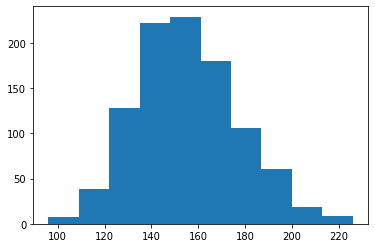

1144163
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.286129    0.296327   
1            NaN             NaN NaN NaN  0.150538    0.346928   
2            NaN             NaN NaN NaN  0.149194    0.246795   
3            NaN             NaN NaN NaN  0.198178    0.294895   
4            NaN             NaN NaN NaN  0.196573    0.293103   
5            NaN             NaN NaN NaN  0.135753    0.318925   
6            NaN             NaN NaN NaN  0.080645    0.351399   
7            NaN             NaN NaN NaN  0.064516    0.305556   
8            NaN             NaN NaN NaN  0.073733    0.316901   
9            NaN             NaN NaN NaN  0.048387    0.234694   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.271950        0.024123   0.271950  
1              0.171646        0.025424   0.171646  
2              0.121069        0.006410 

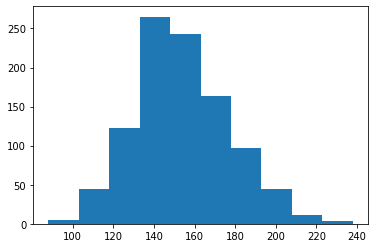

1144992
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.240323    0.284632   
1            NaN             NaN NaN NaN  0.187606    0.379338   
2            NaN             NaN NaN NaN  0.170251    0.374372   
3            NaN             NaN NaN NaN  0.116129    0.233766   
4            NaN             NaN NaN NaN  0.082258    0.279018   
5            NaN             NaN NaN NaN  0.130273    0.311659   
6            NaN             NaN NaN NaN  0.116935    0.295699   
7            NaN             NaN NaN NaN  0.100806    0.324074   
8            NaN             NaN NaN NaN  0.073733    0.316901   
9            NaN             NaN NaN NaN  0.048387    0.234694   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.220545        0.035714   0.220545  
1              0.231546        0.040672   0.231546  
2              0.208246        0.032035 

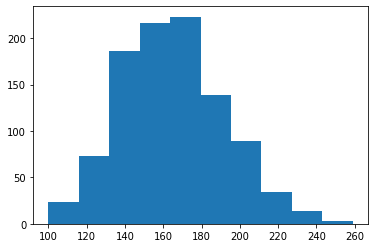

1152840
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.150538    0.346928   
1            NaN             NaN NaN NaN  0.286129    0.296327   
2            NaN             NaN NaN NaN  0.174395    0.265193   
3            NaN             NaN NaN NaN  0.135753    0.318925   
4            NaN             NaN NaN NaN  0.080645    0.351399   
5            NaN             NaN NaN NaN  0.064516    0.305556   
6            NaN             NaN NaN NaN  0.116935    0.295699   
7            NaN             NaN NaN NaN  0.100806    0.324074   
8            NaN             NaN NaN NaN  0.073733    0.316901   
9            NaN             NaN NaN NaN  0.048387    0.234694   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.171646        0.025424   0.171646  
1              0.271950        0.024123   0.271950  
2              0.150943        0.024862 

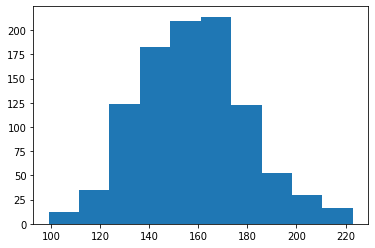

1157372
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.150538    0.346928   
1            NaN             NaN NaN NaN  0.286129    0.296327   
2            NaN             NaN NaN NaN  0.185201    0.281113   
3            NaN             NaN NaN NaN  0.135753    0.318925   
4            NaN             NaN NaN NaN  0.196573    0.293103   
5            NaN             NaN NaN NaN  0.064516    0.305556   
6            NaN             NaN NaN NaN  0.175067    0.303670   
7            NaN             NaN NaN NaN  0.073733    0.316901   
8            NaN             NaN NaN NaN  0.080645    0.351399   
9            NaN             NaN NaN NaN  0.052419    0.408333   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.171646        0.025424   0.171646  
1              0.271950        0.024123   0.271950  
2              0.169480        0.021230 

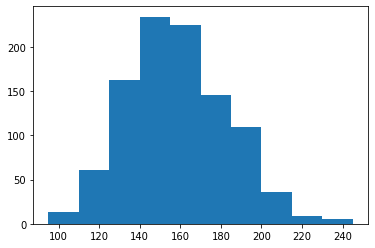

1157373
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.286129    0.296327   
1            NaN             NaN NaN NaN  0.150538    0.346928   
2            NaN             NaN NaN NaN  0.185201    0.281113   
3            NaN             NaN NaN NaN  0.198178    0.294895   
4            NaN             NaN NaN NaN  0.135753    0.318925   
5            NaN             NaN NaN NaN  0.064516    0.305556   
6            NaN             NaN NaN NaN  0.052419    0.408333   
7            NaN             NaN NaN NaN  0.080645    0.351399   
8            NaN             NaN NaN NaN  0.080645    0.351399   
9            NaN             NaN NaN NaN  0.052419    0.408333   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.271950        0.024123   0.271950  
1              0.171646        0.025424   0.171646  
2              0.169480        0.021230 

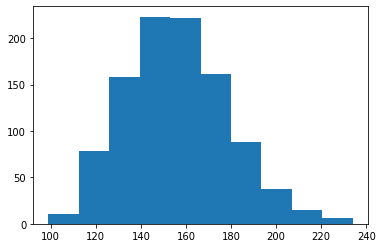

1157374
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.286129    0.296327   
1            NaN             NaN NaN NaN  0.198178    0.294895   
2            NaN             NaN NaN NaN  0.185201    0.281113   
3            NaN             NaN NaN NaN  0.135753    0.318925   
4            NaN             NaN NaN NaN  0.064516    0.305556   
5            NaN             NaN NaN NaN  0.080645    0.351399   
6            NaN             NaN NaN NaN  0.052419    0.408333   
7            NaN             NaN NaN NaN  0.080645    0.351399   
8            NaN             NaN NaN NaN  0.080645    0.351399   
9            NaN             NaN NaN NaN  0.052419    0.408333   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.271950        0.024123   0.271950  
1              0.189727        0.020275   0.189727  
2              0.169480        0.021230 

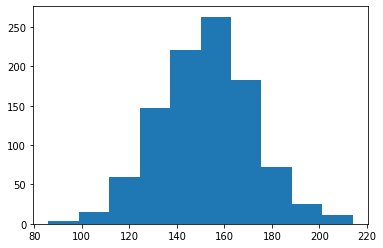

1157375
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.286129    0.296327   
1            NaN             NaN NaN NaN  0.135753    0.318925   
2            NaN             NaN NaN NaN  0.185201    0.281113   
3            NaN             NaN NaN NaN  0.175067    0.303670   
4            NaN             NaN NaN NaN  0.198178    0.294895   
5            NaN             NaN NaN NaN  0.064516    0.305556   
6            NaN             NaN NaN NaN  0.080645    0.351399   
7            NaN             NaN NaN NaN  0.080645    0.351399   
8            NaN             NaN NaN NaN  0.080645    0.351399   
9            NaN             NaN NaN NaN  0.052419    0.408333   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.271950        0.024123   0.271950  
1              0.143082        0.037383   0.143082  
2              0.169480        0.021230 

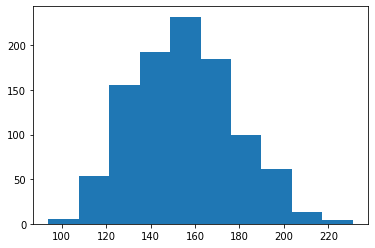

1157377
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.150538    0.346928   
1            NaN             NaN NaN NaN  0.300645    0.299634   
2            NaN             NaN NaN NaN  0.192417    0.282816   
3            NaN             NaN NaN NaN  0.198178    0.294895   
4            NaN             NaN NaN NaN  0.135753    0.318925   
5            NaN             NaN NaN NaN  0.064516    0.305556   
6            NaN             NaN NaN NaN  0.080645    0.351399   
7            NaN             NaN NaN NaN  0.080645    0.351399   
8            NaN             NaN NaN NaN  0.080645    0.351399   
9            NaN             NaN NaN NaN  0.052419    0.408333   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.171646        0.025424   0.171646  
1              0.288553        0.024033   0.288553  
2              0.176873        0.021171 

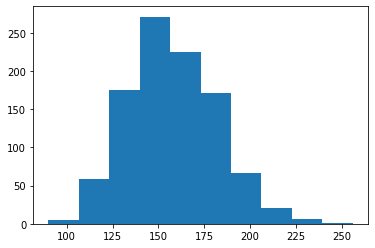

1168247
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182214    0.342497   
1            NaN             NaN NaN NaN  0.244624    0.344267   
2            NaN             NaN NaN NaN  0.271774    0.334438   
3            NaN             NaN NaN NaN  0.133302    0.297819   
4            NaN             NaN NaN NaN  0.238420    0.299497   
5            NaN             NaN NaN NaN  0.209677    0.363169   
6            NaN             NaN NaN NaN  0.130645    0.308140   
7            NaN             NaN NaN NaN  0.036290    0.113636   
8            NaN             NaN NaN NaN  0.080645    0.351399   
9            NaN             NaN NaN NaN  0.052419    0.408333   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.203298        0.026060   0.203298  
1              0.271372        0.037234   0.271372  
2              0.291950        0.023919 

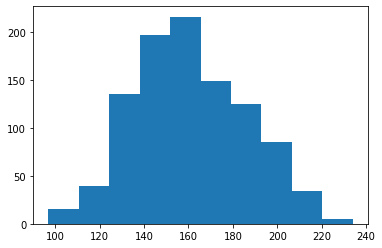

1168248
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.244624    0.344267   
1            NaN             NaN NaN NaN  0.185659    0.307240   
2            NaN             NaN NaN NaN  0.271774    0.334438   
3            NaN             NaN NaN NaN  0.133302    0.297819   
4            NaN             NaN NaN NaN  0.238420    0.299497   
5            NaN             NaN NaN NaN  0.209677    0.363169   
6            NaN             NaN NaN NaN  0.130645    0.308140   
7            NaN             NaN NaN NaN  0.036290    0.113636   
8            NaN             NaN NaN NaN  0.080645    0.351399   
9            NaN             NaN NaN NaN  0.052419    0.408333   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.271372        0.037234   0.271372  
1              0.185671        0.036199   0.185671  
2              0.291950        0.023919 

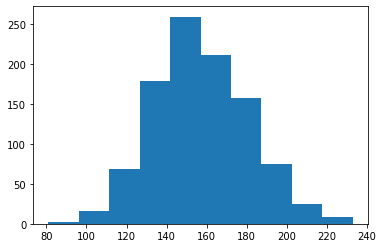

1172509
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.057604    0.307018   
1            NaN             NaN NaN NaN  0.147681    0.307443   
2            NaN             NaN NaN NaN  0.143817    0.317478   
3            NaN             NaN NaN NaN  0.153927    0.279762   
4            NaN             NaN NaN NaN  1.000000    0.318000   
5            NaN             NaN NaN NaN  0.142473    0.372024   
6            NaN             NaN NaN NaN  0.054839    0.237179   
7            NaN             NaN NaN NaN  0.150124    0.304902   
8            NaN             NaN NaN NaN  0.038018    0.312500   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.062893        0.043860   0.062893  
1              0.149371        0.040453   0.149371  
2              0.150419        0.035398 

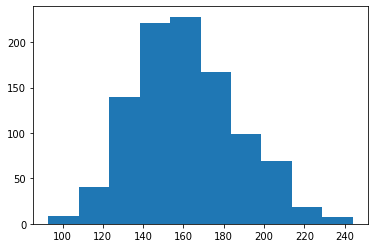

1183524
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.177611    0.374095   
1            NaN             NaN NaN NaN  0.141726    0.337737   
2            NaN             NaN NaN NaN  0.161290    0.369919   
3            NaN             NaN NaN NaN  0.153927    0.279762   
4            NaN             NaN NaN NaN  1.000000    0.318000   
5            NaN             NaN NaN NaN  0.142473    0.372024   
6            NaN             NaN NaN NaN  0.054839    0.237179   
7            NaN             NaN NaN NaN  0.150124    0.304902   
8            NaN             NaN NaN NaN  0.038018    0.312500   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.216682        0.040331   0.216682  
1              0.157815        0.036391   0.157815  
2              0.195429        0.031940 

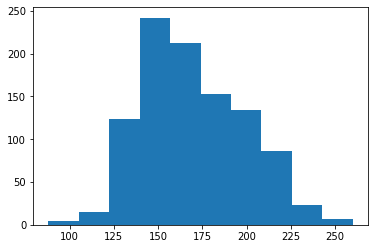

1183528
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.303166    0.307102   
1            NaN             NaN NaN NaN  0.147252    0.336538   
2            NaN             NaN NaN NaN  0.174395    0.265193   
3            NaN             NaN NaN NaN  0.197005    0.287921   
4            NaN             NaN NaN NaN  0.135753    0.318925   
5            NaN             NaN NaN NaN  0.213710    0.327273   
6            NaN             NaN NaN NaN  0.085253    0.354938   
7            NaN             NaN NaN NaN  0.150124    0.304902   
8            NaN             NaN NaN NaN  0.038018    0.312500   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.298160        0.023033   0.298160  
1              0.163056        0.024038   0.163056  
2              0.150943        0.024862 

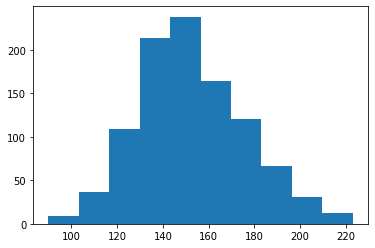

1183529
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.303166    0.307102   
1            NaN             NaN NaN NaN  0.197005    0.287921   
2            NaN             NaN NaN NaN  0.174395    0.265193   
3            NaN             NaN NaN NaN  0.213710    0.327273   
4            NaN             NaN NaN NaN  0.206989    0.296875   
5            NaN             NaN NaN NaN  0.085253    0.354938   
6            NaN             NaN NaN NaN  0.082258    0.303571   
7            NaN             NaN NaN NaN  0.048387    0.234694   
8            NaN             NaN NaN NaN  0.038018    0.312500   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.298160        0.023033   0.298160  
1              0.184187        0.019663   0.184187  
2              0.150943        0.024862 

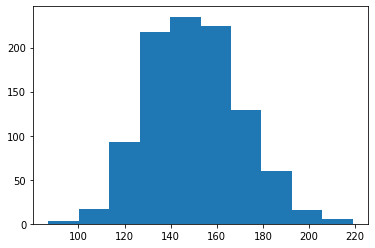

1185316
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.141726    0.337737   
1            NaN             NaN NaN NaN  0.177611    0.374095   
2            NaN             NaN NaN NaN  0.127823    0.300445   
3            NaN             NaN NaN NaN  0.138889    0.307927   
4            NaN             NaN NaN NaN  0.082258    0.279018   
5            NaN             NaN NaN NaN  0.148746    0.277143   
6            NaN             NaN NaN NaN  0.125000    0.272727   
7            NaN             NaN NaN NaN  0.040323    0.145833   
8            NaN             NaN NaN NaN  0.038018    0.312500   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.157815        0.036391   0.157815  
1              0.216682        0.040331   0.216682  
2              0.127358        0.023739 

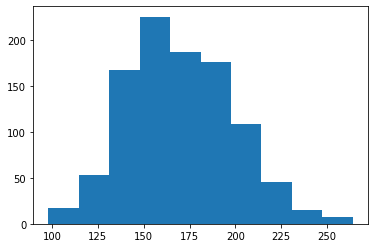

1185318
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.141726    0.337737   
1            NaN             NaN NaN NaN  0.177611    0.374095   
2            NaN             NaN NaN NaN  0.138889    0.307927   
3            NaN             NaN NaN NaN  0.148746    0.277143   
4            NaN             NaN NaN NaN  0.127823    0.300445   
5            NaN             NaN NaN NaN  0.082258    0.279018   
6            NaN             NaN NaN NaN  0.125000    0.272727   
7            NaN             NaN NaN NaN  0.040323    0.145833   
8            NaN             NaN NaN NaN  0.038018    0.312500   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.157815        0.036391   0.157815  
1              0.216682        0.040331   0.216682  
2              0.141160        0.035061 

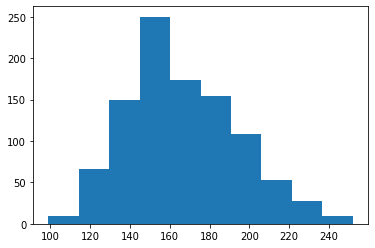

1187006
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182581    0.305203   
1            NaN             NaN NaN NaN  0.180284    0.340704   
2            NaN             NaN NaN NaN  0.276393    0.335825   
3            NaN             NaN NaN NaN  0.137097    0.302249   
4            NaN             NaN NaN NaN  0.163441    0.304075   
5            NaN             NaN NaN NaN  0.087702    0.330702   
6            NaN             NaN NaN NaN  0.130645    0.308140   
7            NaN             NaN NaN NaN  0.108561    0.276596   
8            NaN             NaN NaN NaN  0.027650    0.266129   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.181509        0.035956   0.181509  
1              0.200182        0.026479   0.200182  
2              0.297999        0.025000 

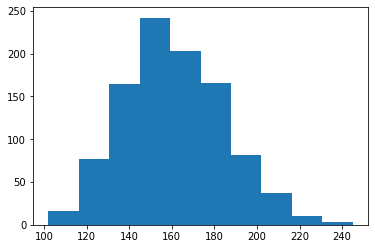

1187013
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.182581    0.305203   
2            NaN             NaN NaN NaN  0.215370    0.334660   
3            NaN             NaN NaN NaN  0.163441    0.304075   
4            NaN             NaN NaN NaN  0.137097    0.302249   
5            NaN             NaN NaN NaN  0.112903    0.341667   
6            NaN             NaN NaN NaN  0.130645    0.308140   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.027650    0.266129   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.181509        0.035956   0.181509  
2              0.233259        0.035563 

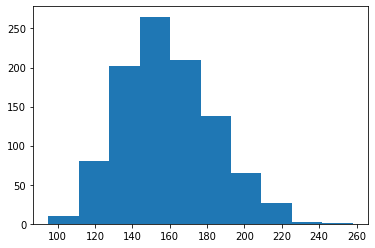

1187015
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.182581    0.305203   
2            NaN             NaN NaN NaN  0.215370    0.334660   
3            NaN             NaN NaN NaN  0.163441    0.304075   
4            NaN             NaN NaN NaN  0.137097    0.302249   
5            NaN             NaN NaN NaN  0.242884    0.304348   
6            NaN             NaN NaN NaN  0.112903    0.341667   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.027650    0.266129   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.181509        0.035956   0.181509  
2              0.233259        0.035563 

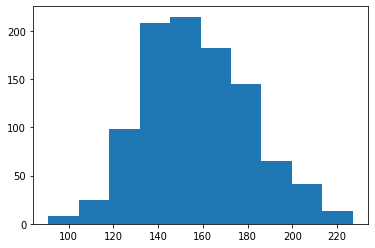

1187019
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.215370    0.334660   
2            NaN             NaN NaN NaN  0.112903    0.341667   
3            NaN             NaN NaN NaN  0.276393    0.335825   
4            NaN             NaN NaN NaN  0.137097    0.302249   
5            NaN             NaN NaN NaN  0.163441    0.304075   
6            NaN             NaN NaN NaN  0.108561    0.276596   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.027650    0.266129   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.233259        0.035563   0.233259  
2              0.128931        0.050000 

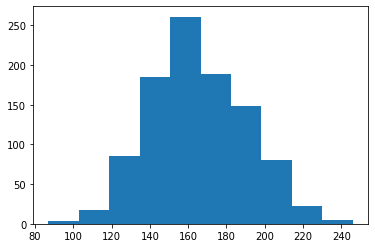

1187020
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.215370    0.334660   
2            NaN             NaN NaN NaN  0.137097    0.302249   
3            NaN             NaN NaN NaN  0.276393    0.335825   
4            NaN             NaN NaN NaN  0.137097    0.302249   
5            NaN             NaN NaN NaN  0.163441    0.304075   
6            NaN             NaN NaN NaN  0.108561    0.276596   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.027650    0.266129   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.233259        0.035563   0.233259  
2              0.136867        0.027778 

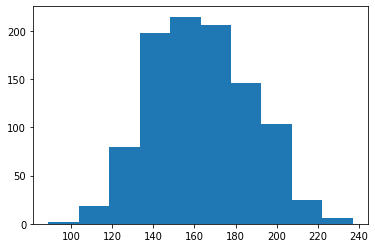

1187679
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.215370    0.334660   
2            NaN             NaN NaN NaN  0.112903    0.341667   
3            NaN             NaN NaN NaN  0.276393    0.335825   
4            NaN             NaN NaN NaN  0.163441    0.304075   
5            NaN             NaN NaN NaN  0.242884    0.304348   
6            NaN             NaN NaN NaN  0.108561    0.276596   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.027650    0.266129   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.233259        0.035563   0.233259  
2              0.128931        0.050000 

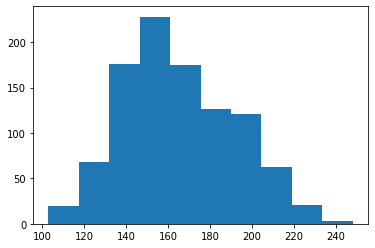

1187680
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.215370    0.334660   
1            NaN             NaN NaN NaN  0.074885    0.288194   
2            NaN             NaN NaN NaN  0.276393    0.335825   
3            NaN             NaN NaN NaN  0.163441    0.304075   
4            NaN             NaN NaN NaN  0.112903    0.341667   
5            NaN             NaN NaN NaN  0.242884    0.304348   
6            NaN             NaN NaN NaN  0.027650    0.266129   
7            NaN             NaN NaN NaN  0.141129    0.466216   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.233259        0.035563   0.233259  
1              0.074573        0.013889   0.074573  
2              0.297999        0.025000 

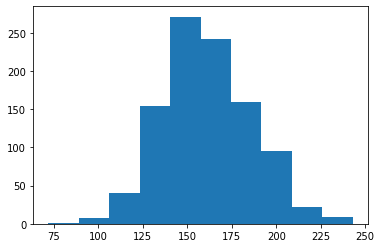

1187681
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.215370    0.334660   
1            NaN             NaN NaN NaN  0.074885    0.288194   
2            NaN             NaN NaN NaN  0.180284    0.340704   
3            NaN             NaN NaN NaN  0.163441    0.304075   
4            NaN             NaN NaN NaN  0.112903    0.341667   
5            NaN             NaN NaN NaN  0.242884    0.304348   
6            NaN             NaN NaN NaN  0.027650    0.266129   
7            NaN             NaN NaN NaN  0.141129    0.466216   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.233259        0.035563   0.233259  
1              0.074573        0.013889   0.074573  
2              0.200182        0.026479 

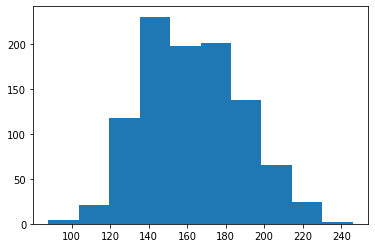

1188379
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  0.208669    0.256977   
4            NaN             NaN NaN NaN  0.153927    0.279762   
5            NaN             NaN NaN NaN  0.142473    0.372024   
6            NaN             NaN NaN NaN  0.122984    0.319231   
7            NaN             NaN NaN NaN  0.160282    0.310629   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.165386        0.038182 

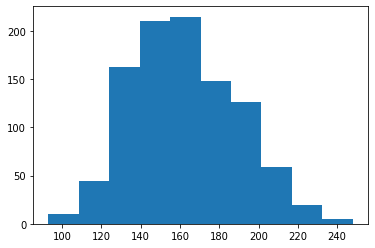

1188380
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  0.153927    0.279762   
4            NaN             NaN NaN NaN  0.142473    0.372024   
5            NaN             NaN NaN NaN  0.160282    0.310629   
6            NaN             NaN NaN NaN  0.122984    0.319231   
7            NaN             NaN NaN NaN  0.043011    0.197368   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.165386        0.038182 

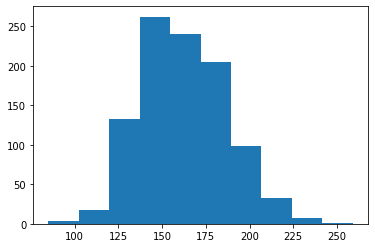

1191006
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.143548    0.272163   
1            NaN             NaN NaN NaN  0.156213    0.322727   
2            NaN             NaN NaN NaN  0.156298    0.322430   
3            NaN             NaN NaN NaN  0.160282    0.310629   
4            NaN             NaN NaN NaN  0.054839    0.237179   
5            NaN             NaN NaN NaN  0.122984    0.319231   
6            NaN             NaN NaN NaN  0.122984    0.319231   
7            NaN             NaN NaN NaN  0.043011    0.197368   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.128721        0.026596   0.128721  
1              0.165386        0.038182   0.165386  
2              0.165319        0.043224 

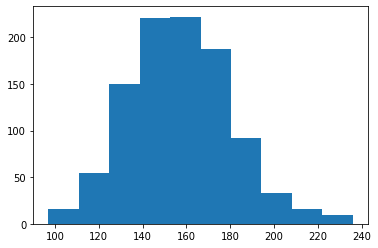

1191008
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.156298    0.322430   
1            NaN             NaN NaN NaN  0.143548    0.272163   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  0.122984    0.319231   
4            NaN             NaN NaN NaN  0.160282    0.310629   
5            NaN             NaN NaN NaN  0.080645    0.380682   
6            NaN             NaN NaN NaN  0.054839    0.237179   
7            NaN             NaN NaN NaN  0.043011    0.197368   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.165319        0.043224   0.165319  
1              0.128721        0.026596   0.128721  
2              0.165386        0.038182 

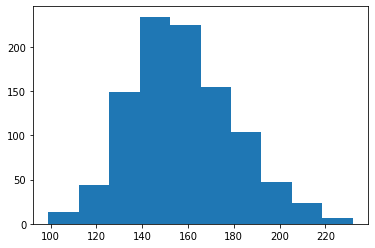

1197521
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  0.142473    0.372024   
4            NaN             NaN NaN NaN  0.122984    0.319231   
5            NaN             NaN NaN NaN  0.160282    0.310629   
6            NaN             NaN NaN NaN  0.080645    0.380682   
7            NaN             NaN NaN NaN  0.043011    0.197368   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.165386        0.038182 

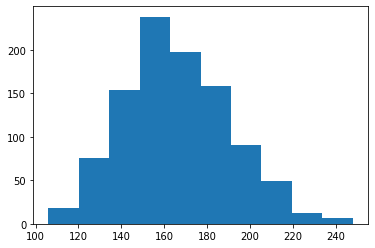

1197524
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.080645    0.380682   
3            NaN             NaN NaN NaN  0.160282    0.310629   
4            NaN             NaN NaN NaN  0.142473    0.372024   
5            NaN             NaN NaN NaN  0.122984    0.319231   
6            NaN             NaN NaN NaN  0.043011    0.197368   
7            NaN             NaN NaN NaN  0.038978    0.292857   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.105346        0.034091 

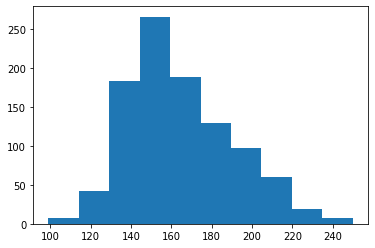

1197528
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.142473    0.372024   
3            NaN             NaN NaN NaN  0.160282    0.310629   
4            NaN             NaN NaN NaN  0.122984    0.319231   
5            NaN             NaN NaN NaN  0.122984    0.319231   
6            NaN             NaN NaN NaN  0.043011    0.197368   
7            NaN             NaN NaN NaN  0.038978    0.292857   
8            NaN             NaN NaN NaN  0.036290    0.113636   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.174703        0.029762 

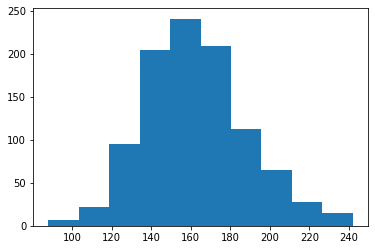

1198236
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.141726    0.337737   
1            NaN             NaN NaN NaN  0.082258    0.279018   
2            NaN             NaN NaN NaN  0.177611    0.374095   
3            NaN             NaN NaN NaN  0.127823    0.300445   
4            NaN             NaN NaN NaN  0.132488    0.329918   
5            NaN             NaN NaN NaN  0.161290    0.369919   
6            NaN             NaN NaN NaN  0.125000    0.272727   
7            NaN             NaN NaN NaN  0.061290    0.279070   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.157815        0.036391   0.157815  
1              0.078616        0.026786   0.078616  
2              0.216682        0.040331 

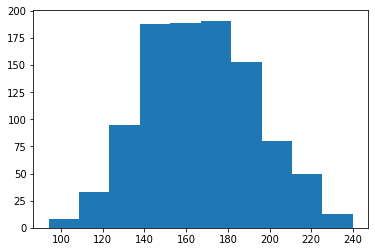

1198245
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.287634    0.309091   
1            NaN             NaN NaN NaN  0.144641    0.339438   
2            NaN             NaN NaN NaN  0.193044    0.288064   
3            NaN             NaN NaN NaN  0.198178    0.294895   
4            NaN             NaN NaN NaN  0.165323    0.279070   
5            NaN             NaN NaN NaN  0.161290    0.369919   
6            NaN             NaN NaN NaN  0.125000    0.272727   
7            NaN             NaN NaN NaN  0.061290    0.279070   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.285115        0.023106   0.285115  
1              0.161696        0.027257   0.161696  
2              0.180719        0.021930 

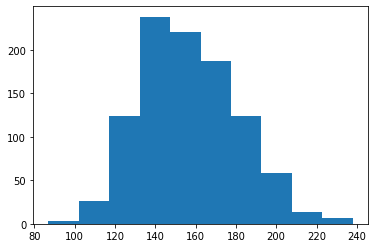

1198246
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.287634    0.309091   
1            NaN             NaN NaN NaN  0.144641    0.339438   
2            NaN             NaN NaN NaN  0.120296    0.328534   
3            NaN             NaN NaN NaN  0.193044    0.288064   
4            NaN             NaN NaN NaN  0.082258    0.303571   
5            NaN             NaN NaN NaN  0.085253    0.354938   
6            NaN             NaN NaN NaN  0.125000    0.272727   
7            NaN             NaN NaN NaN  0.061290    0.279070   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.285115        0.023106   0.285115  
1              0.161696        0.027257   0.161696  
2              0.131551        0.031414 

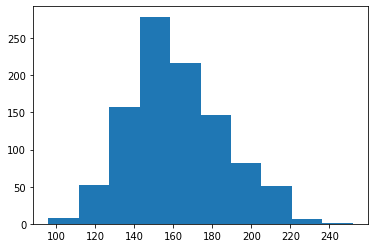

1199501
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  1.000000    0.318000   
4            NaN             NaN NaN NaN  0.142473    0.372024   
5            NaN             NaN NaN NaN  0.160282    0.310629   
6            NaN             NaN NaN NaN  0.125000    0.272727   
7            NaN             NaN NaN NaN  0.061290    0.279070   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.165386        0.038182 

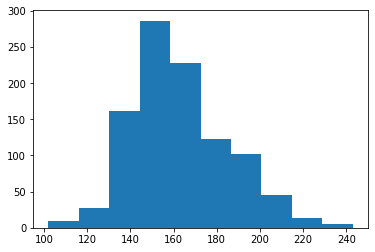

1199505
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.156298    0.322430   
1            NaN             NaN NaN NaN  0.056926    0.288321   
2            NaN             NaN NaN NaN  0.160282    0.310629   
3            NaN             NaN NaN NaN  1.000000    0.318000   
4            NaN             NaN NaN NaN  0.142473    0.372024   
5            NaN             NaN NaN NaN  0.160282    0.310629   
6            NaN             NaN NaN NaN  0.125000    0.272727   
7            NaN             NaN NaN NaN  0.061290    0.279070   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.165319        0.043224   0.165319  
1              0.058454        0.051095   0.058454  
2              0.163129        0.023952 

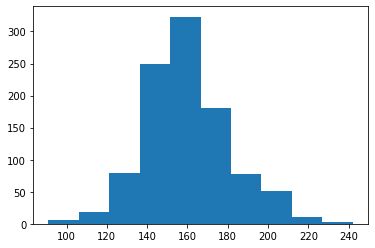

1199525
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  1.000000    0.318000   
4            NaN             NaN NaN NaN  0.160282    0.310629   
5            NaN             NaN NaN NaN  0.142473    0.372024   
6            NaN             NaN NaN NaN  0.122984    0.319231   
7            NaN             NaN NaN NaN  0.038018    0.312500   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.165386        0.038182 

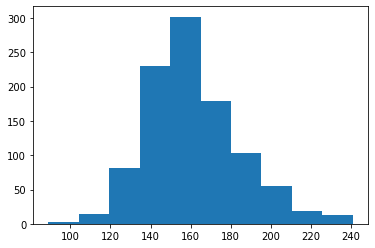

1200428
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.056926    0.288321   
1            NaN             NaN NaN NaN  0.156298    0.322430   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  0.160282    0.310629   
4            NaN             NaN NaN NaN  0.208669    0.256977   
5            NaN             NaN NaN NaN  0.122984    0.319231   
6            NaN             NaN NaN NaN  0.043011    0.197368   
7            NaN             NaN NaN NaN  0.038978    0.292857   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.058454        0.051095   0.058454  
1              0.165319        0.043224   0.165319  
2              0.165386        0.038182 

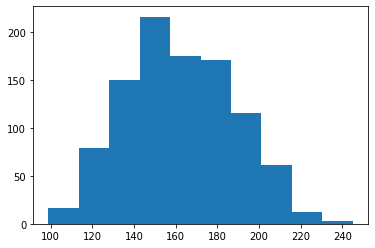

1201683
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.116935    0.289171   
1            NaN             NaN NaN NaN  0.100806    0.268519   
2            NaN             NaN NaN NaN  0.122581    0.302469   
3            NaN             NaN NaN NaN  0.073477    0.195055   
4            NaN             NaN NaN NaN  0.171083    0.277331   
5            NaN             NaN NaN NaN  0.103327    0.278281   
6            NaN             NaN NaN NaN  0.043011    0.197368   
7            NaN             NaN NaN NaN  0.038978    0.292857   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.112758        0.016129   0.112758  
1              0.091195        0.064815   0.091195  
2              0.123270        0.016461 

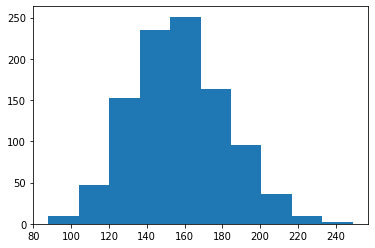

1202244
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.215370    0.334660   
1            NaN             NaN NaN NaN  0.182581    0.305203   
2            NaN             NaN NaN NaN  0.074885    0.288194   
3            NaN             NaN NaN NaN  0.242884    0.304348   
4            NaN             NaN NaN NaN  0.163441    0.304075   
5            NaN             NaN NaN NaN  0.276393    0.335825   
6            NaN             NaN NaN NaN  0.027650    0.266129   
7            NaN             NaN NaN NaN  0.141129    0.466216   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.233259        0.035563   0.233259  
1              0.181509        0.035956   0.181509  
2              0.074573        0.013889 

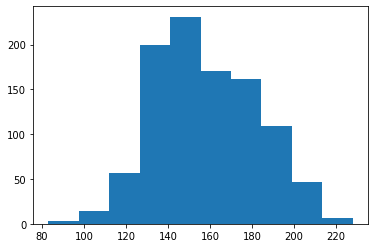

1214671
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.149194    0.250000   
1            NaN             NaN NaN NaN  0.153463    0.285609   
2            NaN             NaN NaN NaN  0.180242    0.232334   
3            NaN             NaN NaN NaN  0.122581    0.302469   
4            NaN             NaN NaN NaN  0.099042    0.271176   
5            NaN             NaN NaN NaN  0.103327    0.278281   
6            NaN             NaN NaN NaN  0.073477    0.195055   
7            NaN             NaN NaN NaN  0.154234    0.296584   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.122642        0.072650   0.122642  
1              0.143914        0.022761   0.143914  
2              0.136478        0.034261 

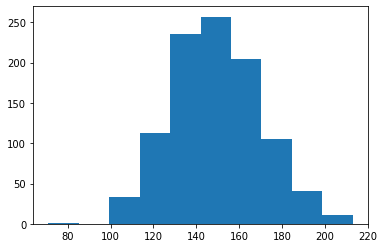

1223952
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.215370    0.334660   
1            NaN             NaN NaN NaN  0.182581    0.305203   
2            NaN             NaN NaN NaN  0.276393    0.335825   
3            NaN             NaN NaN NaN  0.074885    0.288194   
4            NaN             NaN NaN NaN  0.242884    0.304348   
5            NaN             NaN NaN NaN  0.087702    0.330702   
6            NaN             NaN NaN NaN  0.108561    0.276596   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.233259        0.035563   0.233259  
1              0.181509        0.035956   0.181509  
2              0.297999        0.025000 

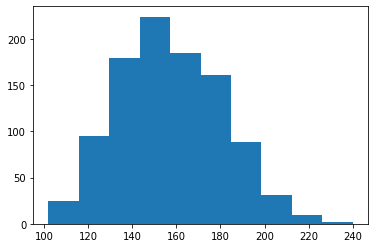

1223953
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.138889    0.307927   
1            NaN             NaN NaN NaN  0.221774    0.280702   
2            NaN             NaN NaN NaN  0.127823    0.300445   
3            NaN             NaN NaN NaN  0.161290    0.369919   
4            NaN             NaN NaN NaN  0.197581    0.331699   
5            NaN             NaN NaN NaN  0.132488    0.329918   
6            NaN             NaN NaN NaN  0.084677    0.586957   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.141160        0.035061   0.141160  
1              0.201258        0.034113   0.201258  
2              0.127358        0.023739 

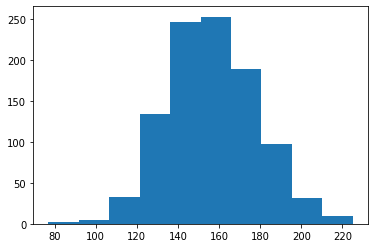

1223954
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.138889    0.307927   
1            NaN             NaN NaN NaN  0.177611    0.374095   
2            NaN             NaN NaN NaN  0.127823    0.300445   
3            NaN             NaN NaN NaN  0.161290    0.369919   
4            NaN             NaN NaN NaN  0.197581    0.331699   
5            NaN             NaN NaN NaN  0.132488    0.329918   
6            NaN             NaN NaN NaN  0.084677    0.586957   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.141160        0.035061   0.141160  
1              0.216682        0.040331   0.216682  
2              0.127358        0.023739 

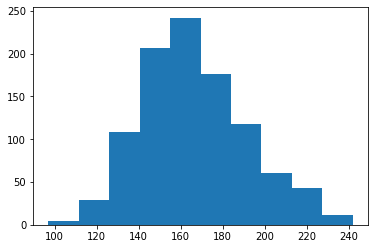

1233464
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.153463    0.285609   
1            NaN             NaN NaN NaN  0.133333    0.278992   
2            NaN             NaN NaN NaN  0.122581    0.302469   
3            NaN             NaN NaN NaN  0.154234    0.296584   
4            NaN             NaN NaN NaN  0.099042    0.271176   
5            NaN             NaN NaN NaN  0.171083    0.277331   
6            NaN             NaN NaN NaN  0.101944    0.327538   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.040323    0.145833   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.143914        0.022761   0.143914  
1              0.123061        0.038023   0.123061  
2              0.123270        0.016461 

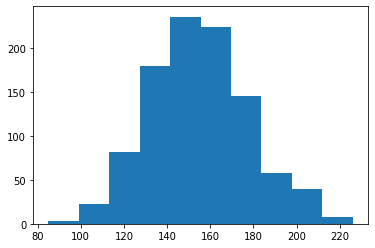

1233465
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.153463    0.285609   
1            NaN             NaN NaN NaN  0.133333    0.278992   
2            NaN             NaN NaN NaN  0.122581    0.302469   
3            NaN             NaN NaN NaN  0.154234    0.296584   
4            NaN             NaN NaN NaN  0.099042    0.271176   
5            NaN             NaN NaN NaN  0.171083    0.277331   
6            NaN             NaN NaN NaN  0.101944    0.327538   
7            NaN             NaN NaN NaN  0.135753    0.280374   
8            NaN             NaN NaN NaN  0.120968    0.223958   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.143914        0.022761   0.143914  
1              0.123061        0.038023   0.123061  
2              0.123270        0.016461 

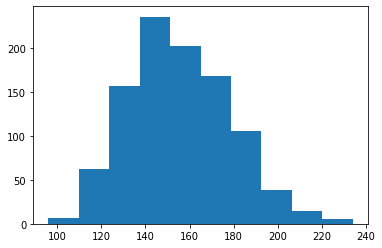

1233466
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.153463    0.285609   
1            NaN             NaN NaN NaN  0.133333    0.278992   
2            NaN             NaN NaN NaN  0.180242    0.232334   
3            NaN             NaN NaN NaN  0.154234    0.296584   
4            NaN             NaN NaN NaN  0.171083    0.277331   
5            NaN             NaN NaN NaN  0.101944    0.327538   
6            NaN             NaN NaN NaN  0.135753    0.280374   
7            NaN             NaN NaN NaN  0.084677    0.260870   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.143914        0.022761   0.143914  
1              0.123061        0.038023   0.123061  
2              0.136478        0.034261 

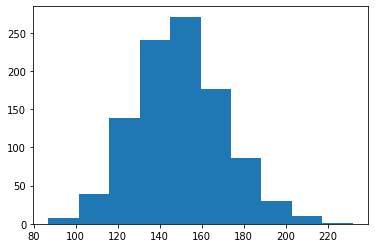

1233959
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.327285    0.327154   
1            NaN             NaN NaN NaN  0.120296    0.328534   
2            NaN             NaN NaN NaN  0.169355    0.277273   
3            NaN             NaN NaN NaN  0.082258    0.303571   
4            NaN             NaN NaN NaN  0.085253    0.354938   
5            NaN             NaN NaN NaN  0.069758    0.318653   
6            NaN             NaN NaN NaN  0.093750    0.314356   
7            NaN             NaN NaN NaN  0.084677    0.260870   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.342243        0.021042   0.342243  
1              0.131551        0.031414   0.131551  
2              0.153459        0.018182 

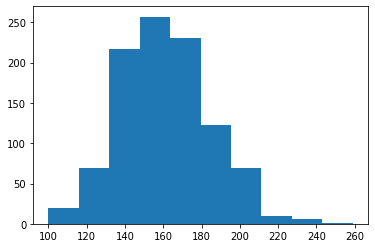

1233960
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.327285    0.327154   
1            NaN             NaN NaN NaN  0.120296    0.328534   
2            NaN             NaN NaN NaN  0.193044    0.288064   
3            NaN             NaN NaN NaN  0.082258    0.303571   
4            NaN             NaN NaN NaN  0.169355    0.277273   
5            NaN             NaN NaN NaN  0.069758    0.318653   
6            NaN             NaN NaN NaN  0.085253    0.354938   
7            NaN             NaN NaN NaN  0.084677    0.260870   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.342243        0.021042   0.342243  
1              0.131551        0.031414   0.131551  
2              0.180719        0.021930 

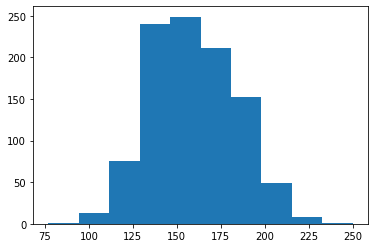

1233973
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.138889    0.307927   
1            NaN             NaN NaN NaN  0.177611    0.374095   
2            NaN             NaN NaN NaN  0.161290    0.369919   
3            NaN             NaN NaN NaN  0.132488    0.329918   
4            NaN             NaN NaN NaN  0.148746    0.277143   
5            NaN             NaN NaN NaN  0.069758    0.318653   
6            NaN             NaN NaN NaN  0.085253    0.354938   
7            NaN             NaN NaN NaN  0.084677    0.260870   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.141160        0.035061   0.141160  
1              0.216682        0.040331   0.216682  
2              0.195429        0.031940 

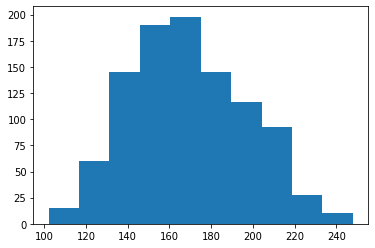

1233974
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.138889    0.307927   
1            NaN             NaN NaN NaN  0.177611    0.374095   
2            NaN             NaN NaN NaN  0.161290    0.369919   
3            NaN             NaN NaN NaN  0.132488    0.329918   
4            NaN             NaN NaN NaN  0.125000    0.272727   
5            NaN             NaN NaN NaN  0.148746    0.277143   
6            NaN             NaN NaN NaN  0.064516    0.388889   
7            NaN             NaN NaN NaN  0.084677    0.260870   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.141160        0.035061   0.141160  
1              0.216682        0.040331   0.216682  
2              0.195429        0.031940 

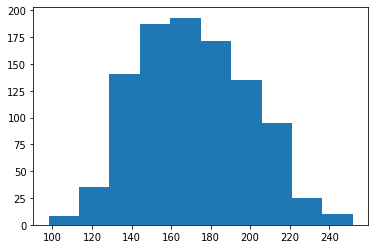

1233975
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.177611    0.374095   
1            NaN             NaN NaN NaN  0.138889    0.307927   
2            NaN             NaN NaN NaN  0.161290    0.369919   
3            NaN             NaN NaN NaN  0.132488    0.329918   
4            NaN             NaN NaN NaN  0.125000    0.272727   
5            NaN             NaN NaN NaN  0.148746    0.277143   
6            NaN             NaN NaN NaN  0.064516    0.388889   
7            NaN             NaN NaN NaN  0.084677    0.260870   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.216682        0.040331   0.216682  
1              0.141160        0.035061   0.141160  
2              0.195429        0.031940 

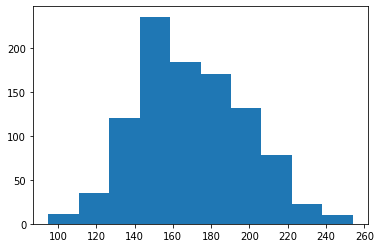

1243019
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.327285    0.327154   
1            NaN             NaN NaN NaN  0.287634    0.309091   
2            NaN             NaN NaN NaN  0.120296    0.328534   
3            NaN             NaN NaN NaN  0.159091    0.286184   
4            NaN             NaN NaN NaN  0.165323    0.279070   
5            NaN             NaN NaN NaN  0.169355    0.277273   
6            NaN             NaN NaN NaN  0.069758    0.318653   
7            NaN             NaN NaN NaN  0.095161    0.238281   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.342243        0.021042   0.342243  
1              0.285115        0.023106   0.285115  
2              0.131551        0.031414 

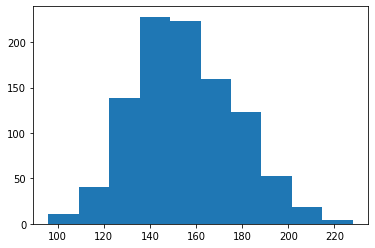

1243020
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.327285    0.327154   
1            NaN             NaN NaN NaN  0.287634    0.309091   
2            NaN             NaN NaN NaN  0.120296    0.328534   
3            NaN             NaN NaN NaN  0.159091    0.286184   
4            NaN             NaN NaN NaN  0.165323    0.279070   
5            NaN             NaN NaN NaN  0.169355    0.277273   
6            NaN             NaN NaN NaN  0.069758    0.318653   
7            NaN             NaN NaN NaN  0.095161    0.238281   
8            NaN             NaN NaN NaN  0.048387    0.125000   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.342243        0.021042   0.342243  
1              0.285115        0.023106   0.285115  
2              0.131551        0.031414 

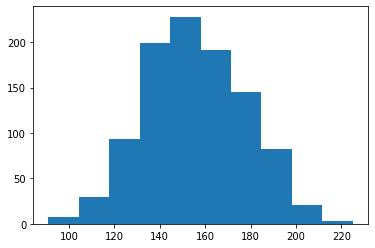

1243388
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.182581    0.305203   
1            NaN             NaN NaN NaN  0.215370    0.334660   
2            NaN             NaN NaN NaN  0.276393    0.335825   
3            NaN             NaN NaN NaN  0.137097    0.302249   
4            NaN             NaN NaN NaN  0.163441    0.304075   
5            NaN             NaN NaN NaN  0.087702    0.330702   
6            NaN             NaN NaN NaN  0.141129    0.466216   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.106855    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.181509        0.035956   0.181509  
1              0.233259        0.035563   0.233259  
2              0.297999        0.025000 

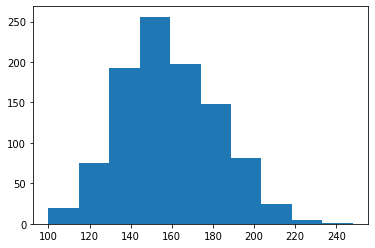

1243390
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.215370    0.334660   
2            NaN             NaN NaN NaN  0.276393    0.335825   
3            NaN             NaN NaN NaN  0.137097    0.302249   
4            NaN             NaN NaN NaN  0.163441    0.304075   
5            NaN             NaN NaN NaN  0.087702    0.330702   
6            NaN             NaN NaN NaN  0.141129    0.466216   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.106855    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.233259        0.035563   0.233259  
2              0.297999        0.025000 

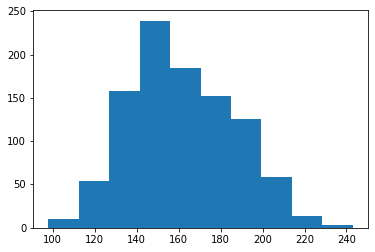

1243391
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.215370    0.334660   
2            NaN             NaN NaN NaN  0.276393    0.335825   
3            NaN             NaN NaN NaN  0.137097    0.302249   
4            NaN             NaN NaN NaN  0.163441    0.304075   
5            NaN             NaN NaN NaN  0.087702    0.330702   
6            NaN             NaN NaN NaN  0.141129    0.466216   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.106855    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.233259        0.035563   0.233259  
2              0.297999        0.025000 

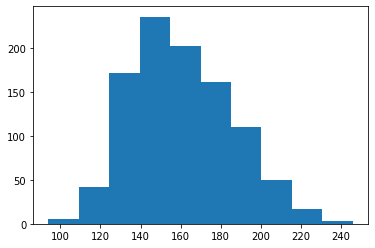

1243392
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.180284    0.340704   
1            NaN             NaN NaN NaN  0.276393    0.335825   
2            NaN             NaN NaN NaN  0.087702    0.330702   
3            NaN             NaN NaN NaN  0.137097    0.302249   
4            NaN             NaN NaN NaN  0.163441    0.304075   
5            NaN             NaN NaN NaN  0.087702    0.330702   
6            NaN             NaN NaN NaN  0.141129    0.466216   
7            NaN             NaN NaN NaN  0.027650    0.266129   
8            NaN             NaN NaN NaN  0.106855    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.200182        0.026479   0.200182  
1              0.297999        0.025000   0.297999  
2              0.098795        0.029825 

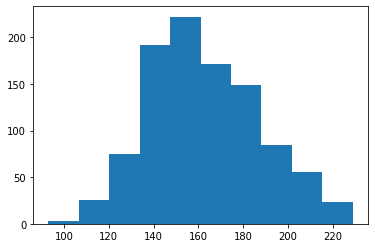

1251576
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.327285    0.327154   
1            NaN             NaN NaN NaN  0.132056    0.320144   
2            NaN             NaN NaN NaN  0.287634    0.309091   
3            NaN             NaN NaN NaN  0.193044    0.288064   
4            NaN             NaN NaN NaN  0.120296    0.328534   
5            NaN             NaN NaN NaN  0.069758    0.318653   
6            NaN             NaN NaN NaN  0.070968    0.469388   
7            NaN             NaN NaN NaN  0.095161    0.238281   
8            NaN             NaN NaN NaN  0.106855    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.342243        0.021042   0.342243  
1              0.139937        0.048561   0.139937  
2              0.285115        0.023106 

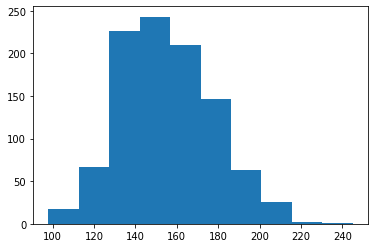

1257183
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.327285    0.327154   
1            NaN             NaN NaN NaN  0.287634    0.309091   
2            NaN             NaN NaN NaN  0.144641    0.339438   
3            NaN             NaN NaN NaN  0.193044    0.288064   
4            NaN             NaN NaN NaN  0.120296    0.328534   
5            NaN             NaN NaN NaN  0.069758    0.318653   
6            NaN             NaN NaN NaN  0.095161    0.238281   
7            NaN             NaN NaN NaN  0.095161    0.238281   
8            NaN             NaN NaN NaN  0.106855    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.342243        0.021042   0.342243  
1              0.285115        0.023106   0.285115  
2              0.161696        0.027257 

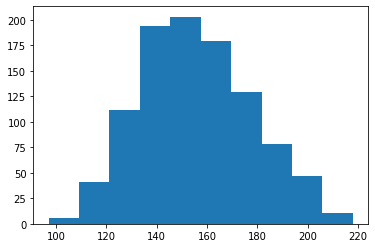

1257184
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.149194    0.250000   
1            NaN             NaN NaN NaN  0.153463    0.285609   
2            NaN             NaN NaN NaN  0.154234    0.296584   
3            NaN             NaN NaN NaN  0.171083    0.277331   
4            NaN             NaN NaN NaN  0.100806    0.268519   
5            NaN             NaN NaN NaN  0.109971    0.233766   
6            NaN             NaN NaN NaN  0.054032    0.260870   
7            NaN             NaN NaN NaN  0.084677    0.125000   
8            NaN             NaN NaN NaN  0.048387    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.122642        0.072650   0.122642  
1              0.143914        0.022761   0.143914  
2              0.150157        0.024845 

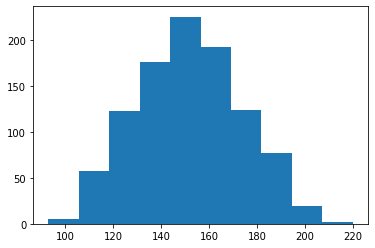

1257185
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.327285    0.327154   
1            NaN             NaN NaN NaN  0.132056    0.320144   
2            NaN             NaN NaN NaN  0.287634    0.309091   
3            NaN             NaN NaN NaN  0.144641    0.339438   
4            NaN             NaN NaN NaN  0.100806    0.268519   
5            NaN             NaN NaN NaN  0.109971    0.233766   
6            NaN             NaN NaN NaN  0.054032    0.260870   
7            NaN             NaN NaN NaN  0.084677    0.125000   
8            NaN             NaN NaN NaN  0.048387    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.342243        0.021042   0.342243  
1              0.139937        0.048561   0.139937  
2              0.285115        0.023106 

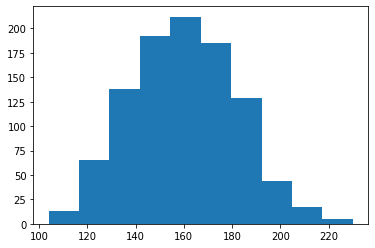

1257945
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.156298    0.322430   
1            NaN             NaN NaN NaN  0.122984    0.319231   
2            NaN             NaN NaN NaN  0.156213    0.322727   
3            NaN             NaN NaN NaN  0.208669    0.256977   
4            NaN             NaN NaN NaN  0.160282    0.310629   
5            NaN             NaN NaN NaN  0.080645    0.380682   
6            NaN             NaN NaN NaN  0.054032    0.260870   
7            NaN             NaN NaN NaN  0.084677    0.125000   
8            NaN             NaN NaN NaN  0.048387    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.165319        0.043224   0.165319  
1              0.130503        0.051282   0.130503  
2              0.165386        0.038182 

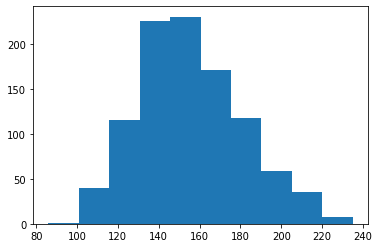

1257946
    balls_remain  wickets_remain  rr  sr       w_b  s_r_career  \
0            NaN             NaN NaN NaN  0.156298    0.322430   
1            NaN             NaN NaN NaN  0.056926    0.288321   
2            NaN             NaN NaN NaN  0.122984    0.319231   
3            NaN             NaN NaN NaN  0.156213    0.322727   
4            NaN             NaN NaN NaN  0.160282    0.310629   
5            NaN             NaN NaN NaN  0.080645    0.380682   
6            NaN             NaN NaN NaN  0.054032    0.260870   
7            NaN             NaN NaN NaN  0.084677    0.125000   
8            NaN             NaN NaN NaN  0.048387    0.328947   
9            NaN             NaN NaN NaN  0.043011    0.197368   
10           NaN             NaN NaN NaN  0.096774    0.243590   

    striker_performance  extras_striker  Av_career  
0              0.165319        0.043224   0.165319  
1              0.058454        0.051095   0.058454  
2              0.130503        0.051282 

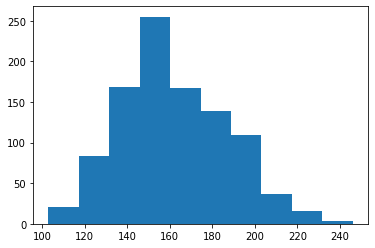

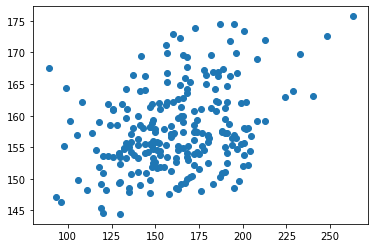

In [247]:
def test_match(t1="India",t2="South Africa"):
    pss=[]
    rss=[]
    stds=[]
    a=match_data[match_data.team_1.isin(["India","Netherlands","Pakistan","Australia","Zimbabwe"])].match_id#[match_data.team_2==t2]
    date_a=match_data[match_data.team_1==t1].start_date
    b=match_data[match_data.team_1==t2][match_data.team_2==t1].match_id
    s1=match_data[match_data.team_1.isin(["India","Netherlands","Pakistan","Australia","Zimbabwe"])].score_1.values
    print(s1)
    sai=pd.DataFrame()
    bai=pd.DataFrame()
    for c in ["balls_remain", "wickets_remain", "rr", "sr", "w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
        sai[c]=[np.nan for i in range(11)]
    for c in ["e_r_career","extras_bowler"]:
        bai[c]=[np.nan for i in range(11)]
    for i in range(len(a)):
        if not a.iloc[i] in g.match_id.values:
            continue
        print(a.iloc[i])
        for c in ["w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
            u=g[g.match_id==a.iloc[i]][g.innings==1][c].unique()
            sai[c].iloc[:len(u)]=u
            sai[c].fillna(np.nanmean(sai[c]),inplace=True)
        print(sai)
        for c in ["e_r_career","extras_bowler"]:
            u=g[g.match_id==a.iloc[i]][g.innings==1][c].unique()
            bai[c].iloc[:len(u)]=u
            bai[c].fillna(np.nanmean(bai[c]),inplace=True)
        print(bai)
        res=team_test(bai,sai,num_iter=1000)
        try:
            res=team_test(bai,sai,num_iter=1000)
            ps=np.mean(res)
            print(s1[i],ps)
            std=np.std(res)
            pss.append(ps)
            rss.append(s1[i])
            stds.append(std)
            plt.hist(res)
            plt.show()
        except:
            pss.append(0)
            stds.append(0)
            continue
    plt.scatter(rss,pss)
    #plt.xlim([100, 250])
    #plt.ylim([100, 250])
    plt.show()
    return rss,pss
rss,pss=test_match()

In [ ]:
plt.scatter(rss,pss)
plt.xlim([100, 250])
plt.ylim([100, 250])
plt.show()

In [14]:
game_table=pd.read_csv(args.d+"/stats/game_table.csv")
print(np.min(game_table.rr),np.max(game_table.rr))
print(np.min(game_table.sr),np.max(game_table.sr))
print(np.min(game_table.rrr),np.max(game_table.rrr))

0.0 3.6666666666666665
0.0 172.0
-0.3684210526315789 143.0


356010 [153 157 180 159 198 164]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 7, 6, 8, 9, 10]
[0, 1, 2, 3, 4, 6, 5, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 6, 7, 5, 8, 9, 10]
[0, 1, 2, 3, 4, 7, 5, 6, 8, 9, 10]
[0, 1, 2, 3, 4, 7, 6, 5, 8, 9, 10]
[0, 1, 2, 3, 5, 4, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 5, 4, 7, 6, 8, 9, 10]
[0, 1, 2, 3, 5, 6, 4, 7, 8, 9, 10]
[0, 1, 2, 3, 5, 6, 7, 4, 8, 9, 10]
[0, 1, 2, 3, 5, 7, 4, 6, 8, 9, 10]
[0, 1, 2, 3, 5, 7, 6, 4, 8, 9, 10]
[0, 1, 2, 3, 6, 4, 5, 7, 8, 9, 10]
[0, 1, 2, 3, 6, 4, 7, 5, 8, 9, 10]
[0, 1, 2, 3, 6, 5, 4, 7, 8, 9, 10]
[0, 1, 2, 3, 6, 5, 7, 4, 8, 9, 10]
[0, 1, 2, 3, 6, 7, 4, 5, 8, 9, 10]
[0, 1, 2, 3, 6, 7, 5, 4, 8, 9, 10]
[0, 1, 2, 3, 7, 4, 5, 6, 8, 9, 10]
[0, 1, 2, 3, 7, 4, 6, 5, 8, 9, 10]
[0, 1, 2, 3, 7, 5, 4, 6, 8, 9, 10]
[0, 1, 2, 3, 7, 5, 6, 4, 8, 9, 10]
[0, 1, 2, 3, 7, 6, 4, 5, 8, 9, 10]
[0, 1, 2, 3, 7, 6, 5, 4, 8, 9, 10]
[0, 1, 2, 4, 3, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 4, 3, 5, 7, 6, 8, 9, 10]
[0, 1, 2, 4, 3, 6, 5, 7, 8, 9, 10]
[0, 1, 2, 4, 3, 6, 7, 

[0, 1, 3, 7, 6, 2, 4, 5, 8, 9, 10]
[0, 1, 3, 7, 6, 2, 5, 4, 8, 9, 10]
[0, 1, 3, 7, 6, 4, 2, 5, 8, 9, 10]
[0, 1, 3, 7, 6, 4, 5, 2, 8, 9, 10]
[0, 1, 3, 7, 6, 5, 2, 4, 8, 9, 10]
[0, 1, 3, 7, 6, 5, 4, 2, 8, 9, 10]
[0, 1, 4, 2, 3, 5, 6, 7, 8, 9, 10]
[0, 1, 4, 2, 3, 5, 7, 6, 8, 9, 10]
[0, 1, 4, 2, 3, 6, 5, 7, 8, 9, 10]
[0, 1, 4, 2, 3, 6, 7, 5, 8, 9, 10]
[0, 1, 4, 2, 3, 7, 5, 6, 8, 9, 10]
[0, 1, 4, 2, 3, 7, 6, 5, 8, 9, 10]
[0, 1, 4, 2, 5, 3, 6, 7, 8, 9, 10]
[0, 1, 4, 2, 5, 3, 7, 6, 8, 9, 10]
[0, 1, 4, 2, 5, 6, 3, 7, 8, 9, 10]
[0, 1, 4, 2, 5, 6, 7, 3, 8, 9, 10]
[0, 1, 4, 2, 5, 7, 3, 6, 8, 9, 10]
[0, 1, 4, 2, 5, 7, 6, 3, 8, 9, 10]
[0, 1, 4, 2, 6, 3, 5, 7, 8, 9, 10]
[0, 1, 4, 2, 6, 3, 7, 5, 8, 9, 10]
[0, 1, 4, 2, 6, 5, 3, 7, 8, 9, 10]
[0, 1, 4, 2, 6, 5, 7, 3, 8, 9, 10]
[0, 1, 4, 2, 6, 7, 3, 5, 8, 9, 10]
[0, 1, 4, 2, 6, 7, 5, 3, 8, 9, 10]
[0, 1, 4, 2, 7, 3, 5, 6, 8, 9, 10]
[0, 1, 4, 2, 7, 3, 6, 5, 8, 9, 10]
[0, 1, 4, 2, 7, 5, 3, 6, 8, 9, 10]
[0, 1, 4, 2, 7, 5, 6, 3, 8, 9, 10]
[0, 1, 4, 2, 7, 6, 3

[0, 1, 5, 7, 4, 2, 6, 3, 8, 9, 10]
[0, 1, 5, 7, 4, 3, 2, 6, 8, 9, 10]
[0, 1, 5, 7, 4, 3, 6, 2, 8, 9, 10]
[0, 1, 5, 7, 4, 6, 2, 3, 8, 9, 10]
[0, 1, 5, 7, 4, 6, 3, 2, 8, 9, 10]
[0, 1, 5, 7, 6, 2, 3, 4, 8, 9, 10]
[0, 1, 5, 7, 6, 2, 4, 3, 8, 9, 10]
[0, 1, 5, 7, 6, 3, 2, 4, 8, 9, 10]
[0, 1, 5, 7, 6, 3, 4, 2, 8, 9, 10]
[0, 1, 5, 7, 6, 4, 2, 3, 8, 9, 10]
[0, 1, 5, 7, 6, 4, 3, 2, 8, 9, 10]
[0, 1, 6, 2, 3, 4, 5, 7, 8, 9, 10]
[0, 1, 6, 2, 3, 4, 7, 5, 8, 9, 10]
[0, 1, 6, 2, 3, 5, 4, 7, 8, 9, 10]
[0, 1, 6, 2, 3, 5, 7, 4, 8, 9, 10]
[0, 1, 6, 2, 3, 7, 4, 5, 8, 9, 10]
[0, 1, 6, 2, 3, 7, 5, 4, 8, 9, 10]
[0, 1, 6, 2, 4, 3, 5, 7, 8, 9, 10]
[0, 1, 6, 2, 4, 3, 7, 5, 8, 9, 10]
[0, 1, 6, 2, 4, 5, 3, 7, 8, 9, 10]
[0, 1, 6, 2, 4, 5, 7, 3, 8, 9, 10]
[0, 1, 6, 2, 4, 7, 3, 5, 8, 9, 10]
[0, 1, 6, 2, 4, 7, 5, 3, 8, 9, 10]
[0, 1, 6, 2, 5, 3, 4, 7, 8, 9, 10]
[0, 1, 6, 2, 5, 3, 7, 4, 8, 9, 10]
[0, 1, 6, 2, 5, 4, 3, 7, 8, 9, 10]
[0, 1, 6, 2, 5, 4, 7, 3, 8, 9, 10]
[0, 1, 6, 2, 5, 7, 3, 4, 8, 9, 10]
[0, 1, 6, 2, 5, 7, 4

[0, 1, 7, 6, 3, 4, 2, 5, 8, 9, 10]
[0, 1, 7, 6, 3, 4, 5, 2, 8, 9, 10]
[0, 1, 7, 6, 3, 5, 2, 4, 8, 9, 10]
[0, 1, 7, 6, 3, 5, 4, 2, 8, 9, 10]
[0, 1, 7, 6, 4, 2, 3, 5, 8, 9, 10]
[0, 1, 7, 6, 4, 2, 5, 3, 8, 9, 10]
[0, 1, 7, 6, 4, 3, 2, 5, 8, 9, 10]
[0, 1, 7, 6, 4, 3, 5, 2, 8, 9, 10]
[0, 1, 7, 6, 4, 5, 2, 3, 8, 9, 10]
[0, 1, 7, 6, 4, 5, 3, 2, 8, 9, 10]
[0, 1, 7, 6, 5, 2, 3, 4, 8, 9, 10]
[0, 1, 7, 6, 5, 2, 4, 3, 8, 9, 10]
[0, 1, 7, 6, 5, 3, 2, 4, 8, 9, 10]
[0, 1, 7, 6, 5, 3, 4, 2, 8, 9, 10]
[0, 1, 7, 6, 5, 4, 2, 3, 8, 9, 10]
[0, 1, 7, 6, 5, 4, 3, 2, 8, 9, 10]
[0, 2, 1, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 2, 1, 3, 4, 5, 7, 6, 8, 9, 10]
[0, 2, 1, 3, 4, 6, 5, 7, 8, 9, 10]
[0, 2, 1, 3, 4, 6, 7, 5, 8, 9, 10]
[0, 2, 1, 3, 4, 7, 5, 6, 8, 9, 10]
[0, 2, 1, 3, 4, 7, 6, 5, 8, 9, 10]
[0, 2, 1, 3, 5, 4, 6, 7, 8, 9, 10]
[0, 2, 1, 3, 5, 4, 7, 6, 8, 9, 10]
[0, 2, 1, 3, 5, 6, 4, 7, 8, 9, 10]
[0, 2, 1, 3, 5, 6, 7, 4, 8, 9, 10]
[0, 2, 1, 3, 5, 7, 4, 6, 8, 9, 10]
[0, 2, 1, 3, 5, 7, 6, 4, 8, 9, 10]
[0, 2, 1, 3, 6, 4, 5

[0, 2, 3, 7, 1, 5, 6, 4, 8, 9, 10]
[0, 2, 3, 7, 1, 6, 4, 5, 8, 9, 10]
[0, 2, 3, 7, 1, 6, 5, 4, 8, 9, 10]
[0, 2, 3, 7, 4, 1, 5, 6, 8, 9, 10]
[0, 2, 3, 7, 4, 1, 6, 5, 8, 9, 10]
[0, 2, 3, 7, 4, 5, 1, 6, 8, 9, 10]
[0, 2, 3, 7, 4, 5, 6, 1, 8, 9, 10]
[0, 2, 3, 7, 4, 6, 1, 5, 8, 9, 10]
[0, 2, 3, 7, 4, 6, 5, 1, 8, 9, 10]
[0, 2, 3, 7, 5, 1, 4, 6, 8, 9, 10]
[0, 2, 3, 7, 5, 1, 6, 4, 8, 9, 10]
[0, 2, 3, 7, 5, 4, 1, 6, 8, 9, 10]
[0, 2, 3, 7, 5, 4, 6, 1, 8, 9, 10]
[0, 2, 3, 7, 5, 6, 1, 4, 8, 9, 10]
[0, 2, 3, 7, 5, 6, 4, 1, 8, 9, 10]
[0, 2, 3, 7, 6, 1, 4, 5, 8, 9, 10]
[0, 2, 3, 7, 6, 1, 5, 4, 8, 9, 10]
[0, 2, 3, 7, 6, 4, 1, 5, 8, 9, 10]
[0, 2, 3, 7, 6, 4, 5, 1, 8, 9, 10]
[0, 2, 3, 7, 6, 5, 1, 4, 8, 9, 10]
[0, 2, 3, 7, 6, 5, 4, 1, 8, 9, 10]
[0, 2, 4, 1, 3, 5, 6, 7, 8, 9, 10]
[0, 2, 4, 1, 3, 5, 7, 6, 8, 9, 10]
[0, 2, 4, 1, 3, 6, 5, 7, 8, 9, 10]
[0, 2, 4, 1, 3, 6, 7, 5, 8, 9, 10]
[0, 2, 4, 1, 3, 7, 5, 6, 8, 9, 10]
[0, 2, 4, 1, 3, 7, 6, 5, 8, 9, 10]
[0, 2, 4, 1, 5, 3, 6, 7, 8, 9, 10]
[0, 2, 4, 1, 5, 3, 7

[0, 2, 5, 6, 7, 4, 1, 3, 8, 9, 10]
[0, 2, 5, 6, 7, 4, 3, 1, 8, 9, 10]
[0, 2, 5, 7, 1, 3, 4, 6, 8, 9, 10]
[0, 2, 5, 7, 1, 3, 6, 4, 8, 9, 10]
[0, 2, 5, 7, 1, 4, 3, 6, 8, 9, 10]
[0, 2, 5, 7, 1, 4, 6, 3, 8, 9, 10]
[0, 2, 5, 7, 1, 6, 3, 4, 8, 9, 10]
[0, 2, 5, 7, 1, 6, 4, 3, 8, 9, 10]
[0, 2, 5, 7, 3, 1, 4, 6, 8, 9, 10]
[0, 2, 5, 7, 3, 1, 6, 4, 8, 9, 10]
[0, 2, 5, 7, 3, 4, 1, 6, 8, 9, 10]
[0, 2, 5, 7, 3, 4, 6, 1, 8, 9, 10]
[0, 2, 5, 7, 3, 6, 1, 4, 8, 9, 10]
[0, 2, 5, 7, 3, 6, 4, 1, 8, 9, 10]
[0, 2, 5, 7, 4, 1, 3, 6, 8, 9, 10]
[0, 2, 5, 7, 4, 1, 6, 3, 8, 9, 10]
[0, 2, 5, 7, 4, 3, 1, 6, 8, 9, 10]
[0, 2, 5, 7, 4, 3, 6, 1, 8, 9, 10]
[0, 2, 5, 7, 4, 6, 1, 3, 8, 9, 10]
[0, 2, 5, 7, 4, 6, 3, 1, 8, 9, 10]
[0, 2, 5, 7, 6, 1, 3, 4, 8, 9, 10]
[0, 2, 5, 7, 6, 1, 4, 3, 8, 9, 10]
[0, 2, 5, 7, 6, 3, 1, 4, 8, 9, 10]
[0, 2, 5, 7, 6, 3, 4, 1, 8, 9, 10]
[0, 2, 5, 7, 6, 4, 1, 3, 8, 9, 10]
[0, 2, 5, 7, 6, 4, 3, 1, 8, 9, 10]
[0, 2, 6, 1, 3, 4, 5, 7, 8, 9, 10]
[0, 2, 6, 1, 3, 4, 7, 5, 8, 9, 10]
[0, 2, 6, 1, 3, 5, 4

[0, 2, 7, 5, 4, 6, 3, 1, 8, 9, 10]
[0, 2, 7, 5, 6, 1, 3, 4, 8, 9, 10]
[0, 2, 7, 5, 6, 1, 4, 3, 8, 9, 10]
[0, 2, 7, 5, 6, 3, 1, 4, 8, 9, 10]
[0, 2, 7, 5, 6, 3, 4, 1, 8, 9, 10]
[0, 2, 7, 5, 6, 4, 1, 3, 8, 9, 10]
[0, 2, 7, 5, 6, 4, 3, 1, 8, 9, 10]
[0, 2, 7, 6, 1, 3, 4, 5, 8, 9, 10]
[0, 2, 7, 6, 1, 3, 5, 4, 8, 9, 10]
[0, 2, 7, 6, 1, 4, 3, 5, 8, 9, 10]
[0, 2, 7, 6, 1, 4, 5, 3, 8, 9, 10]
[0, 2, 7, 6, 1, 5, 3, 4, 8, 9, 10]
[0, 2, 7, 6, 1, 5, 4, 3, 8, 9, 10]
[0, 2, 7, 6, 3, 1, 4, 5, 8, 9, 10]
[0, 2, 7, 6, 3, 1, 5, 4, 8, 9, 10]
[0, 2, 7, 6, 3, 4, 1, 5, 8, 9, 10]
[0, 2, 7, 6, 3, 4, 5, 1, 8, 9, 10]
[0, 2, 7, 6, 3, 5, 1, 4, 8, 9, 10]
[0, 2, 7, 6, 3, 5, 4, 1, 8, 9, 10]
[0, 2, 7, 6, 4, 1, 3, 5, 8, 9, 10]
[0, 2, 7, 6, 4, 1, 5, 3, 8, 9, 10]
[0, 2, 7, 6, 4, 3, 1, 5, 8, 9, 10]
[0, 2, 7, 6, 4, 3, 5, 1, 8, 9, 10]
[0, 2, 7, 6, 4, 5, 1, 3, 8, 9, 10]
[0, 2, 7, 6, 4, 5, 3, 1, 8, 9, 10]
[0, 2, 7, 6, 5, 1, 3, 4, 8, 9, 10]
[0, 2, 7, 6, 5, 1, 4, 3, 8, 9, 10]
[0, 2, 7, 6, 5, 3, 1, 4, 8, 9, 10]
[0, 2, 7, 6, 5, 3, 4

[0, 3, 2, 6, 5, 1, 4, 7, 8, 9, 10]
[0, 3, 2, 6, 5, 1, 7, 4, 8, 9, 10]
[0, 3, 2, 6, 5, 4, 1, 7, 8, 9, 10]
[0, 3, 2, 6, 5, 4, 7, 1, 8, 9, 10]
[0, 3, 2, 6, 5, 7, 1, 4, 8, 9, 10]
[0, 3, 2, 6, 5, 7, 4, 1, 8, 9, 10]
[0, 3, 2, 6, 7, 1, 4, 5, 8, 9, 10]
[0, 3, 2, 6, 7, 1, 5, 4, 8, 9, 10]
[0, 3, 2, 6, 7, 4, 1, 5, 8, 9, 10]
[0, 3, 2, 6, 7, 4, 5, 1, 8, 9, 10]
[0, 3, 2, 6, 7, 5, 1, 4, 8, 9, 10]
[0, 3, 2, 6, 7, 5, 4, 1, 8, 9, 10]
[0, 3, 2, 7, 1, 4, 5, 6, 8, 9, 10]
[0, 3, 2, 7, 1, 4, 6, 5, 8, 9, 10]
[0, 3, 2, 7, 1, 5, 4, 6, 8, 9, 10]
[0, 3, 2, 7, 1, 5, 6, 4, 8, 9, 10]
[0, 3, 2, 7, 1, 6, 4, 5, 8, 9, 10]
[0, 3, 2, 7, 1, 6, 5, 4, 8, 9, 10]
[0, 3, 2, 7, 4, 1, 5, 6, 8, 9, 10]
[0, 3, 2, 7, 4, 1, 6, 5, 8, 9, 10]
[0, 3, 2, 7, 4, 5, 1, 6, 8, 9, 10]
[0, 3, 2, 7, 4, 5, 6, 1, 8, 9, 10]
[0, 3, 2, 7, 4, 6, 1, 5, 8, 9, 10]
[0, 3, 2, 7, 4, 6, 5, 1, 8, 9, 10]
[0, 3, 2, 7, 5, 1, 4, 6, 8, 9, 10]
[0, 3, 2, 7, 5, 1, 6, 4, 8, 9, 10]
[0, 3, 2, 7, 5, 4, 1, 6, 8, 9, 10]
[0, 3, 2, 7, 5, 4, 6, 1, 8, 9, 10]
[0, 3, 2, 7, 5, 6, 1

[0, 3, 5, 6, 2, 1, 7, 4, 8, 9, 10]
[0, 3, 5, 6, 2, 4, 1, 7, 8, 9, 10]
[0, 3, 5, 6, 2, 4, 7, 1, 8, 9, 10]
[0, 3, 5, 6, 2, 7, 1, 4, 8, 9, 10]
[0, 3, 5, 6, 2, 7, 4, 1, 8, 9, 10]
[0, 3, 5, 6, 4, 1, 2, 7, 8, 9, 10]
[0, 3, 5, 6, 4, 1, 7, 2, 8, 9, 10]
[0, 3, 5, 6, 4, 2, 1, 7, 8, 9, 10]
[0, 3, 5, 6, 4, 2, 7, 1, 8, 9, 10]
[0, 3, 5, 6, 4, 7, 1, 2, 8, 9, 10]
[0, 3, 5, 6, 4, 7, 2, 1, 8, 9, 10]
[0, 3, 5, 6, 7, 1, 2, 4, 8, 9, 10]
[0, 3, 5, 6, 7, 1, 4, 2, 8, 9, 10]
[0, 3, 5, 6, 7, 2, 1, 4, 8, 9, 10]
[0, 3, 5, 6, 7, 2, 4, 1, 8, 9, 10]
[0, 3, 5, 6, 7, 4, 1, 2, 8, 9, 10]
[0, 3, 5, 6, 7, 4, 2, 1, 8, 9, 10]
[0, 3, 5, 7, 1, 2, 4, 6, 8, 9, 10]
[0, 3, 5, 7, 1, 2, 6, 4, 8, 9, 10]
[0, 3, 5, 7, 1, 4, 2, 6, 8, 9, 10]
[0, 3, 5, 7, 1, 4, 6, 2, 8, 9, 10]
[0, 3, 5, 7, 1, 6, 2, 4, 8, 9, 10]
[0, 3, 5, 7, 1, 6, 4, 2, 8, 9, 10]
[0, 3, 5, 7, 2, 1, 4, 6, 8, 9, 10]
[0, 3, 5, 7, 2, 1, 6, 4, 8, 9, 10]
[0, 3, 5, 7, 2, 4, 1, 6, 8, 9, 10]
[0, 3, 5, 7, 2, 4, 6, 1, 8, 9, 10]
[0, 3, 5, 7, 2, 6, 1, 4, 8, 9, 10]
[0, 3, 5, 7, 2, 6, 4

[0, 3, 7, 5, 1, 4, 2, 6, 8, 9, 10]
[0, 3, 7, 5, 1, 4, 6, 2, 8, 9, 10]
[0, 3, 7, 5, 1, 6, 2, 4, 8, 9, 10]
[0, 3, 7, 5, 1, 6, 4, 2, 8, 9, 10]
[0, 3, 7, 5, 2, 1, 4, 6, 8, 9, 10]
[0, 3, 7, 5, 2, 1, 6, 4, 8, 9, 10]
[0, 3, 7, 5, 2, 4, 1, 6, 8, 9, 10]
[0, 3, 7, 5, 2, 4, 6, 1, 8, 9, 10]
[0, 3, 7, 5, 2, 6, 1, 4, 8, 9, 10]
[0, 3, 7, 5, 2, 6, 4, 1, 8, 9, 10]
[0, 3, 7, 5, 4, 1, 2, 6, 8, 9, 10]
[0, 3, 7, 5, 4, 1, 6, 2, 8, 9, 10]
[0, 3, 7, 5, 4, 2, 1, 6, 8, 9, 10]
[0, 3, 7, 5, 4, 2, 6, 1, 8, 9, 10]
[0, 3, 7, 5, 4, 6, 1, 2, 8, 9, 10]
[0, 3, 7, 5, 4, 6, 2, 1, 8, 9, 10]
[0, 3, 7, 5, 6, 1, 2, 4, 8, 9, 10]
[0, 3, 7, 5, 6, 1, 4, 2, 8, 9, 10]
[0, 3, 7, 5, 6, 2, 1, 4, 8, 9, 10]
[0, 3, 7, 5, 6, 2, 4, 1, 8, 9, 10]
[0, 3, 7, 5, 6, 4, 1, 2, 8, 9, 10]
[0, 3, 7, 5, 6, 4, 2, 1, 8, 9, 10]
[0, 3, 7, 6, 1, 2, 4, 5, 8, 9, 10]
[0, 3, 7, 6, 1, 2, 5, 4, 8, 9, 10]
[0, 3, 7, 6, 1, 4, 2, 5, 8, 9, 10]
[0, 3, 7, 6, 1, 4, 5, 2, 8, 9, 10]
[0, 3, 7, 6, 1, 5, 2, 4, 8, 9, 10]
[0, 3, 7, 6, 1, 5, 4, 2, 8, 9, 10]
[0, 3, 7, 6, 2, 1, 4

[0, 4, 2, 5, 7, 3, 6, 1, 8, 9, 10]
[0, 4, 2, 5, 7, 6, 1, 3, 8, 9, 10]
[0, 4, 2, 5, 7, 6, 3, 1, 8, 9, 10]
[0, 4, 2, 6, 1, 3, 5, 7, 8, 9, 10]
[0, 4, 2, 6, 1, 3, 7, 5, 8, 9, 10]
[0, 4, 2, 6, 1, 5, 3, 7, 8, 9, 10]
[0, 4, 2, 6, 1, 5, 7, 3, 8, 9, 10]
[0, 4, 2, 6, 1, 7, 3, 5, 8, 9, 10]
[0, 4, 2, 6, 1, 7, 5, 3, 8, 9, 10]
[0, 4, 2, 6, 3, 1, 5, 7, 8, 9, 10]
[0, 4, 2, 6, 3, 1, 7, 5, 8, 9, 10]
[0, 4, 2, 6, 3, 5, 1, 7, 8, 9, 10]
[0, 4, 2, 6, 3, 5, 7, 1, 8, 9, 10]
[0, 4, 2, 6, 3, 7, 1, 5, 8, 9, 10]
[0, 4, 2, 6, 3, 7, 5, 1, 8, 9, 10]
[0, 4, 2, 6, 5, 1, 3, 7, 8, 9, 10]
[0, 4, 2, 6, 5, 1, 7, 3, 8, 9, 10]
[0, 4, 2, 6, 5, 3, 1, 7, 8, 9, 10]
[0, 4, 2, 6, 5, 3, 7, 1, 8, 9, 10]
[0, 4, 2, 6, 5, 7, 1, 3, 8, 9, 10]
[0, 4, 2, 6, 5, 7, 3, 1, 8, 9, 10]
[0, 4, 2, 6, 7, 1, 3, 5, 8, 9, 10]
[0, 4, 2, 6, 7, 1, 5, 3, 8, 9, 10]
[0, 4, 2, 6, 7, 3, 1, 5, 8, 9, 10]
[0, 4, 2, 6, 7, 3, 5, 1, 8, 9, 10]
[0, 4, 2, 6, 7, 5, 1, 3, 8, 9, 10]
[0, 4, 2, 6, 7, 5, 3, 1, 8, 9, 10]
[0, 4, 2, 7, 1, 3, 5, 6, 8, 9, 10]
[0, 4, 2, 7, 1, 3, 6

[0, 4, 5, 3, 6, 7, 1, 2, 8, 9, 10]
[0, 4, 5, 3, 6, 7, 2, 1, 8, 9, 10]
[0, 4, 5, 3, 7, 1, 2, 6, 8, 9, 10]
[0, 4, 5, 3, 7, 1, 6, 2, 8, 9, 10]
[0, 4, 5, 3, 7, 2, 1, 6, 8, 9, 10]
[0, 4, 5, 3, 7, 2, 6, 1, 8, 9, 10]
[0, 4, 5, 3, 7, 6, 1, 2, 8, 9, 10]
[0, 4, 5, 3, 7, 6, 2, 1, 8, 9, 10]
[0, 4, 5, 6, 1, 2, 3, 7, 8, 9, 10]
[0, 4, 5, 6, 1, 2, 7, 3, 8, 9, 10]
[0, 4, 5, 6, 1, 3, 2, 7, 8, 9, 10]
[0, 4, 5, 6, 1, 3, 7, 2, 8, 9, 10]
[0, 4, 5, 6, 1, 7, 2, 3, 8, 9, 10]
[0, 4, 5, 6, 1, 7, 3, 2, 8, 9, 10]
[0, 4, 5, 6, 2, 1, 3, 7, 8, 9, 10]
[0, 4, 5, 6, 2, 1, 7, 3, 8, 9, 10]
[0, 4, 5, 6, 2, 3, 1, 7, 8, 9, 10]
[0, 4, 5, 6, 2, 3, 7, 1, 8, 9, 10]
[0, 4, 5, 6, 2, 7, 1, 3, 8, 9, 10]
[0, 4, 5, 6, 2, 7, 3, 1, 8, 9, 10]
[0, 4, 5, 6, 3, 1, 2, 7, 8, 9, 10]
[0, 4, 5, 6, 3, 1, 7, 2, 8, 9, 10]
[0, 4, 5, 6, 3, 2, 1, 7, 8, 9, 10]
[0, 4, 5, 6, 3, 2, 7, 1, 8, 9, 10]
[0, 4, 5, 6, 3, 7, 1, 2, 8, 9, 10]
[0, 4, 5, 6, 3, 7, 2, 1, 8, 9, 10]
[0, 4, 5, 6, 7, 1, 2, 3, 8, 9, 10]
[0, 4, 5, 6, 7, 1, 3, 2, 8, 9, 10]
[0, 4, 5, 6, 7, 2, 1

[0, 4, 7, 3, 2, 6, 5, 1, 8, 9, 10]
[0, 4, 7, 3, 5, 1, 2, 6, 8, 9, 10]
[0, 4, 7, 3, 5, 1, 6, 2, 8, 9, 10]
[0, 4, 7, 3, 5, 2, 1, 6, 8, 9, 10]
[0, 4, 7, 3, 5, 2, 6, 1, 8, 9, 10]
[0, 4, 7, 3, 5, 6, 1, 2, 8, 9, 10]
[0, 4, 7, 3, 5, 6, 2, 1, 8, 9, 10]
[0, 4, 7, 3, 6, 1, 2, 5, 8, 9, 10]
[0, 4, 7, 3, 6, 1, 5, 2, 8, 9, 10]
[0, 4, 7, 3, 6, 2, 1, 5, 8, 9, 10]
[0, 4, 7, 3, 6, 2, 5, 1, 8, 9, 10]
[0, 4, 7, 3, 6, 5, 1, 2, 8, 9, 10]
[0, 4, 7, 3, 6, 5, 2, 1, 8, 9, 10]
[0, 4, 7, 5, 1, 2, 3, 6, 8, 9, 10]
[0, 4, 7, 5, 1, 2, 6, 3, 8, 9, 10]
[0, 4, 7, 5, 1, 3, 2, 6, 8, 9, 10]
[0, 4, 7, 5, 1, 3, 6, 2, 8, 9, 10]
[0, 4, 7, 5, 1, 6, 2, 3, 8, 9, 10]
[0, 4, 7, 5, 1, 6, 3, 2, 8, 9, 10]
[0, 4, 7, 5, 2, 1, 3, 6, 8, 9, 10]
[0, 4, 7, 5, 2, 1, 6, 3, 8, 9, 10]
[0, 4, 7, 5, 2, 3, 1, 6, 8, 9, 10]
[0, 4, 7, 5, 2, 3, 6, 1, 8, 9, 10]
[0, 4, 7, 5, 2, 6, 1, 3, 8, 9, 10]
[0, 4, 7, 5, 2, 6, 3, 1, 8, 9, 10]
[0, 4, 7, 5, 3, 1, 2, 6, 8, 9, 10]
[0, 4, 7, 5, 3, 1, 6, 2, 8, 9, 10]
[0, 4, 7, 5, 3, 2, 1, 6, 8, 9, 10]
[0, 4, 7, 5, 3, 2, 6

[0, 5, 2, 4, 3, 1, 6, 7, 8, 9, 10]
[0, 5, 2, 4, 3, 1, 7, 6, 8, 9, 10]
[0, 5, 2, 4, 3, 6, 1, 7, 8, 9, 10]
[0, 5, 2, 4, 3, 6, 7, 1, 8, 9, 10]
[0, 5, 2, 4, 3, 7, 1, 6, 8, 9, 10]
[0, 5, 2, 4, 3, 7, 6, 1, 8, 9, 10]
[0, 5, 2, 4, 6, 1, 3, 7, 8, 9, 10]
[0, 5, 2, 4, 6, 1, 7, 3, 8, 9, 10]
[0, 5, 2, 4, 6, 3, 1, 7, 8, 9, 10]
[0, 5, 2, 4, 6, 3, 7, 1, 8, 9, 10]
[0, 5, 2, 4, 6, 7, 1, 3, 8, 9, 10]
[0, 5, 2, 4, 6, 7, 3, 1, 8, 9, 10]
[0, 5, 2, 4, 7, 1, 3, 6, 8, 9, 10]
[0, 5, 2, 4, 7, 1, 6, 3, 8, 9, 10]
[0, 5, 2, 4, 7, 3, 1, 6, 8, 9, 10]
[0, 5, 2, 4, 7, 3, 6, 1, 8, 9, 10]
[0, 5, 2, 4, 7, 6, 1, 3, 8, 9, 10]
[0, 5, 2, 4, 7, 6, 3, 1, 8, 9, 10]
[0, 5, 2, 6, 1, 3, 4, 7, 8, 9, 10]
[0, 5, 2, 6, 1, 3, 7, 4, 8, 9, 10]
[0, 5, 2, 6, 1, 4, 3, 7, 8, 9, 10]
[0, 5, 2, 6, 1, 4, 7, 3, 8, 9, 10]
[0, 5, 2, 6, 1, 7, 3, 4, 8, 9, 10]
[0, 5, 2, 6, 1, 7, 4, 3, 8, 9, 10]
[0, 5, 2, 6, 3, 1, 4, 7, 8, 9, 10]
[0, 5, 2, 6, 3, 1, 7, 4, 8, 9, 10]
[0, 5, 2, 6, 3, 4, 1, 7, 8, 9, 10]
[0, 5, 2, 6, 3, 4, 7, 1, 8, 9, 10]
[0, 5, 2, 6, 3, 7, 1

[0, 5, 4, 3, 1, 2, 7, 6, 8, 9, 10]
[0, 5, 4, 3, 1, 6, 2, 7, 8, 9, 10]
[0, 5, 4, 3, 1, 6, 7, 2, 8, 9, 10]
[0, 5, 4, 3, 1, 7, 2, 6, 8, 9, 10]
[0, 5, 4, 3, 1, 7, 6, 2, 8, 9, 10]
[0, 5, 4, 3, 2, 1, 6, 7, 8, 9, 10]
[0, 5, 4, 3, 2, 1, 7, 6, 8, 9, 10]
[0, 5, 4, 3, 2, 6, 1, 7, 8, 9, 10]
[0, 5, 4, 3, 2, 6, 7, 1, 8, 9, 10]
[0, 5, 4, 3, 2, 7, 1, 6, 8, 9, 10]
[0, 5, 4, 3, 2, 7, 6, 1, 8, 9, 10]
[0, 5, 4, 3, 6, 1, 2, 7, 8, 9, 10]
[0, 5, 4, 3, 6, 1, 7, 2, 8, 9, 10]
[0, 5, 4, 3, 6, 2, 1, 7, 8, 9, 10]
[0, 5, 4, 3, 6, 2, 7, 1, 8, 9, 10]
[0, 5, 4, 3, 6, 7, 1, 2, 8, 9, 10]
[0, 5, 4, 3, 6, 7, 2, 1, 8, 9, 10]
[0, 5, 4, 3, 7, 1, 2, 6, 8, 9, 10]
[0, 5, 4, 3, 7, 1, 6, 2, 8, 9, 10]
[0, 5, 4, 3, 7, 2, 1, 6, 8, 9, 10]
[0, 5, 4, 3, 7, 2, 6, 1, 8, 9, 10]
[0, 5, 4, 3, 7, 6, 1, 2, 8, 9, 10]
[0, 5, 4, 3, 7, 6, 2, 1, 8, 9, 10]
[0, 5, 4, 6, 1, 2, 3, 7, 8, 9, 10]
[0, 5, 4, 6, 1, 2, 7, 3, 8, 9, 10]
[0, 5, 4, 6, 1, 3, 2, 7, 8, 9, 10]
[0, 5, 4, 6, 1, 3, 7, 2, 8, 9, 10]
[0, 5, 4, 6, 1, 7, 2, 3, 8, 9, 10]
[0, 5, 4, 6, 1, 7, 3

[0, 5, 7, 2, 6, 3, 1, 4, 8, 9, 10]
[0, 5, 7, 2, 6, 3, 4, 1, 8, 9, 10]
[0, 5, 7, 2, 6, 4, 1, 3, 8, 9, 10]
[0, 5, 7, 2, 6, 4, 3, 1, 8, 9, 10]
[0, 5, 7, 3, 1, 2, 4, 6, 8, 9, 10]
[0, 5, 7, 3, 1, 2, 6, 4, 8, 9, 10]
[0, 5, 7, 3, 1, 4, 2, 6, 8, 9, 10]
[0, 5, 7, 3, 1, 4, 6, 2, 8, 9, 10]
[0, 5, 7, 3, 1, 6, 2, 4, 8, 9, 10]
[0, 5, 7, 3, 1, 6, 4, 2, 8, 9, 10]
[0, 5, 7, 3, 2, 1, 4, 6, 8, 9, 10]
[0, 5, 7, 3, 2, 1, 6, 4, 8, 9, 10]
[0, 5, 7, 3, 2, 4, 1, 6, 8, 9, 10]
[0, 5, 7, 3, 2, 4, 6, 1, 8, 9, 10]
[0, 5, 7, 3, 2, 6, 1, 4, 8, 9, 10]
[0, 5, 7, 3, 2, 6, 4, 1, 8, 9, 10]
[0, 5, 7, 3, 4, 1, 2, 6, 8, 9, 10]
[0, 5, 7, 3, 4, 1, 6, 2, 8, 9, 10]
[0, 5, 7, 3, 4, 2, 1, 6, 8, 9, 10]
[0, 5, 7, 3, 4, 2, 6, 1, 8, 9, 10]
[0, 5, 7, 3, 4, 6, 1, 2, 8, 9, 10]
[0, 5, 7, 3, 4, 6, 2, 1, 8, 9, 10]
[0, 5, 7, 3, 6, 1, 2, 4, 8, 9, 10]
[0, 5, 7, 3, 6, 1, 4, 2, 8, 9, 10]
[0, 5, 7, 3, 6, 2, 1, 4, 8, 9, 10]
[0, 5, 7, 3, 6, 2, 4, 1, 8, 9, 10]
[0, 5, 7, 3, 6, 4, 1, 2, 8, 9, 10]
[0, 5, 7, 3, 6, 4, 2, 1, 8, 9, 10]
[0, 5, 7, 4, 1, 2, 3

[0, 6, 2, 3, 5, 4, 7, 1, 8, 9, 10]
[0, 6, 2, 3, 5, 7, 1, 4, 8, 9, 10]
[0, 6, 2, 3, 5, 7, 4, 1, 8, 9, 10]
[0, 6, 2, 3, 7, 1, 4, 5, 8, 9, 10]
[0, 6, 2, 3, 7, 1, 5, 4, 8, 9, 10]
[0, 6, 2, 3, 7, 4, 1, 5, 8, 9, 10]
[0, 6, 2, 3, 7, 4, 5, 1, 8, 9, 10]
[0, 6, 2, 3, 7, 5, 1, 4, 8, 9, 10]
[0, 6, 2, 3, 7, 5, 4, 1, 8, 9, 10]
[0, 6, 2, 4, 1, 3, 5, 7, 8, 9, 10]
[0, 6, 2, 4, 1, 3, 7, 5, 8, 9, 10]
[0, 6, 2, 4, 1, 5, 3, 7, 8, 9, 10]
[0, 6, 2, 4, 1, 5, 7, 3, 8, 9, 10]
[0, 6, 2, 4, 1, 7, 3, 5, 8, 9, 10]
[0, 6, 2, 4, 1, 7, 5, 3, 8, 9, 10]
[0, 6, 2, 4, 3, 1, 5, 7, 8, 9, 10]
[0, 6, 2, 4, 3, 1, 7, 5, 8, 9, 10]
[0, 6, 2, 4, 3, 5, 1, 7, 8, 9, 10]
[0, 6, 2, 4, 3, 5, 7, 1, 8, 9, 10]
[0, 6, 2, 4, 3, 7, 1, 5, 8, 9, 10]
[0, 6, 2, 4, 3, 7, 5, 1, 8, 9, 10]
[0, 6, 2, 4, 5, 1, 3, 7, 8, 9, 10]
[0, 6, 2, 4, 5, 1, 7, 3, 8, 9, 10]
[0, 6, 2, 4, 5, 3, 1, 7, 8, 9, 10]
[0, 6, 2, 4, 5, 3, 7, 1, 8, 9, 10]
[0, 6, 2, 4, 5, 7, 1, 3, 8, 9, 10]
[0, 6, 2, 4, 5, 7, 3, 1, 8, 9, 10]
[0, 6, 2, 4, 7, 1, 3, 5, 8, 9, 10]
[0, 6, 2, 4, 7, 1, 5

[0, 6, 4, 2, 3, 7, 1, 5, 8, 9, 10]
[0, 6, 4, 2, 3, 7, 5, 1, 8, 9, 10]
[0, 6, 4, 2, 5, 1, 3, 7, 8, 9, 10]
[0, 6, 4, 2, 5, 1, 7, 3, 8, 9, 10]
[0, 6, 4, 2, 5, 3, 1, 7, 8, 9, 10]
[0, 6, 4, 2, 5, 3, 7, 1, 8, 9, 10]
[0, 6, 4, 2, 5, 7, 1, 3, 8, 9, 10]
[0, 6, 4, 2, 5, 7, 3, 1, 8, 9, 10]
[0, 6, 4, 2, 7, 1, 3, 5, 8, 9, 10]
[0, 6, 4, 2, 7, 1, 5, 3, 8, 9, 10]
[0, 6, 4, 2, 7, 3, 1, 5, 8, 9, 10]
[0, 6, 4, 2, 7, 3, 5, 1, 8, 9, 10]
[0, 6, 4, 2, 7, 5, 1, 3, 8, 9, 10]
[0, 6, 4, 2, 7, 5, 3, 1, 8, 9, 10]
[0, 6, 4, 3, 1, 2, 5, 7, 8, 9, 10]
[0, 6, 4, 3, 1, 2, 7, 5, 8, 9, 10]
[0, 6, 4, 3, 1, 5, 2, 7, 8, 9, 10]
[0, 6, 4, 3, 1, 5, 7, 2, 8, 9, 10]
[0, 6, 4, 3, 1, 7, 2, 5, 8, 9, 10]
[0, 6, 4, 3, 1, 7, 5, 2, 8, 9, 10]
[0, 6, 4, 3, 2, 1, 5, 7, 8, 9, 10]
[0, 6, 4, 3, 2, 1, 7, 5, 8, 9, 10]
[0, 6, 4, 3, 2, 5, 1, 7, 8, 9, 10]
[0, 6, 4, 3, 2, 5, 7, 1, 8, 9, 10]
[0, 6, 4, 3, 2, 7, 1, 5, 8, 9, 10]
[0, 6, 4, 3, 2, 7, 5, 1, 8, 9, 10]
[0, 6, 4, 3, 5, 1, 2, 7, 8, 9, 10]
[0, 6, 4, 3, 5, 1, 7, 2, 8, 9, 10]
[0, 6, 4, 3, 5, 2, 1

[0, 6, 7, 2, 1, 5, 4, 3, 8, 9, 10]
[0, 6, 7, 2, 3, 1, 4, 5, 8, 9, 10]
[0, 6, 7, 2, 3, 1, 5, 4, 8, 9, 10]
[0, 6, 7, 2, 3, 4, 1, 5, 8, 9, 10]
[0, 6, 7, 2, 3, 4, 5, 1, 8, 9, 10]
[0, 6, 7, 2, 3, 5, 1, 4, 8, 9, 10]
[0, 6, 7, 2, 3, 5, 4, 1, 8, 9, 10]
[0, 6, 7, 2, 4, 1, 3, 5, 8, 9, 10]
[0, 6, 7, 2, 4, 1, 5, 3, 8, 9, 10]
[0, 6, 7, 2, 4, 3, 1, 5, 8, 9, 10]
[0, 6, 7, 2, 4, 3, 5, 1, 8, 9, 10]
[0, 6, 7, 2, 4, 5, 1, 3, 8, 9, 10]
[0, 6, 7, 2, 4, 5, 3, 1, 8, 9, 10]
[0, 6, 7, 2, 5, 1, 3, 4, 8, 9, 10]
[0, 6, 7, 2, 5, 1, 4, 3, 8, 9, 10]
[0, 6, 7, 2, 5, 3, 1, 4, 8, 9, 10]
[0, 6, 7, 2, 5, 3, 4, 1, 8, 9, 10]
[0, 6, 7, 2, 5, 4, 1, 3, 8, 9, 10]
[0, 6, 7, 2, 5, 4, 3, 1, 8, 9, 10]
[0, 6, 7, 3, 1, 2, 4, 5, 8, 9, 10]
[0, 6, 7, 3, 1, 2, 5, 4, 8, 9, 10]
[0, 6, 7, 3, 1, 4, 2, 5, 8, 9, 10]
[0, 6, 7, 3, 1, 4, 5, 2, 8, 9, 10]
[0, 6, 7, 3, 1, 5, 2, 4, 8, 9, 10]
[0, 6, 7, 3, 1, 5, 4, 2, 8, 9, 10]
[0, 6, 7, 3, 2, 1, 4, 5, 8, 9, 10]
[0, 6, 7, 3, 2, 1, 5, 4, 8, 9, 10]
[0, 6, 7, 3, 2, 4, 1, 5, 8, 9, 10]
[0, 6, 7, 3, 2, 4, 5

[0, 7, 2, 3, 1, 4, 5, 6, 8, 9, 10]
[0, 7, 2, 3, 1, 4, 6, 5, 8, 9, 10]
[0, 7, 2, 3, 1, 5, 4, 6, 8, 9, 10]
[0, 7, 2, 3, 1, 5, 6, 4, 8, 9, 10]
[0, 7, 2, 3, 1, 6, 4, 5, 8, 9, 10]
[0, 7, 2, 3, 1, 6, 5, 4, 8, 9, 10]
[0, 7, 2, 3, 4, 1, 5, 6, 8, 9, 10]
[0, 7, 2, 3, 4, 1, 6, 5, 8, 9, 10]
[0, 7, 2, 3, 4, 5, 1, 6, 8, 9, 10]
[0, 7, 2, 3, 4, 5, 6, 1, 8, 9, 10]
[0, 7, 2, 3, 4, 6, 1, 5, 8, 9, 10]
[0, 7, 2, 3, 4, 6, 5, 1, 8, 9, 10]
[0, 7, 2, 3, 5, 1, 4, 6, 8, 9, 10]
[0, 7, 2, 3, 5, 1, 6, 4, 8, 9, 10]
[0, 7, 2, 3, 5, 4, 1, 6, 8, 9, 10]
[0, 7, 2, 3, 5, 4, 6, 1, 8, 9, 10]
[0, 7, 2, 3, 5, 6, 1, 4, 8, 9, 10]
[0, 7, 2, 3, 5, 6, 4, 1, 8, 9, 10]
[0, 7, 2, 3, 6, 1, 4, 5, 8, 9, 10]
[0, 7, 2, 3, 6, 1, 5, 4, 8, 9, 10]
[0, 7, 2, 3, 6, 4, 1, 5, 8, 9, 10]
[0, 7, 2, 3, 6, 4, 5, 1, 8, 9, 10]
[0, 7, 2, 3, 6, 5, 1, 4, 8, 9, 10]
[0, 7, 2, 3, 6, 5, 4, 1, 8, 9, 10]
[0, 7, 2, 4, 1, 3, 5, 6, 8, 9, 10]
[0, 7, 2, 4, 1, 3, 6, 5, 8, 9, 10]
[0, 7, 2, 4, 1, 5, 3, 6, 8, 9, 10]
[0, 7, 2, 4, 1, 5, 6, 3, 8, 9, 10]
[0, 7, 2, 4, 1, 6, 3

[0, 7, 4, 1, 6, 2, 5, 3, 8, 9, 10]
[0, 7, 4, 1, 6, 3, 2, 5, 8, 9, 10]
[0, 7, 4, 1, 6, 3, 5, 2, 8, 9, 10]
[0, 7, 4, 1, 6, 5, 2, 3, 8, 9, 10]
[0, 7, 4, 1, 6, 5, 3, 2, 8, 9, 10]
[0, 7, 4, 2, 1, 3, 5, 6, 8, 9, 10]
[0, 7, 4, 2, 1, 3, 6, 5, 8, 9, 10]
[0, 7, 4, 2, 1, 5, 3, 6, 8, 9, 10]
[0, 7, 4, 2, 1, 5, 6, 3, 8, 9, 10]
[0, 7, 4, 2, 1, 6, 3, 5, 8, 9, 10]
[0, 7, 4, 2, 1, 6, 5, 3, 8, 9, 10]
[0, 7, 4, 2, 3, 1, 5, 6, 8, 9, 10]
[0, 7, 4, 2, 3, 1, 6, 5, 8, 9, 10]
[0, 7, 4, 2, 3, 5, 1, 6, 8, 9, 10]
[0, 7, 4, 2, 3, 5, 6, 1, 8, 9, 10]
[0, 7, 4, 2, 3, 6, 1, 5, 8, 9, 10]
[0, 7, 4, 2, 3, 6, 5, 1, 8, 9, 10]
[0, 7, 4, 2, 5, 1, 3, 6, 8, 9, 10]
[0, 7, 4, 2, 5, 1, 6, 3, 8, 9, 10]
[0, 7, 4, 2, 5, 3, 1, 6, 8, 9, 10]
[0, 7, 4, 2, 5, 3, 6, 1, 8, 9, 10]
[0, 7, 4, 2, 5, 6, 1, 3, 8, 9, 10]
[0, 7, 4, 2, 5, 6, 3, 1, 8, 9, 10]
[0, 7, 4, 2, 6, 1, 3, 5, 8, 9, 10]
[0, 7, 4, 2, 6, 1, 5, 3, 8, 9, 10]
[0, 7, 4, 2, 6, 3, 1, 5, 8, 9, 10]
[0, 7, 4, 2, 6, 3, 5, 1, 8, 9, 10]
[0, 7, 4, 2, 6, 5, 1, 3, 8, 9, 10]
[0, 7, 4, 2, 6, 5, 3

[0, 7, 6, 1, 4, 3, 2, 5, 8, 9, 10]
[0, 7, 6, 1, 4, 3, 5, 2, 8, 9, 10]
[0, 7, 6, 1, 4, 5, 2, 3, 8, 9, 10]
[0, 7, 6, 1, 4, 5, 3, 2, 8, 9, 10]
[0, 7, 6, 1, 5, 2, 3, 4, 8, 9, 10]
[0, 7, 6, 1, 5, 2, 4, 3, 8, 9, 10]
[0, 7, 6, 1, 5, 3, 2, 4, 8, 9, 10]
[0, 7, 6, 1, 5, 3, 4, 2, 8, 9, 10]
[0, 7, 6, 1, 5, 4, 2, 3, 8, 9, 10]
[0, 7, 6, 1, 5, 4, 3, 2, 8, 9, 10]
[0, 7, 6, 2, 1, 3, 4, 5, 8, 9, 10]
[0, 7, 6, 2, 1, 3, 5, 4, 8, 9, 10]
[0, 7, 6, 2, 1, 4, 3, 5, 8, 9, 10]
[0, 7, 6, 2, 1, 4, 5, 3, 8, 9, 10]
[0, 7, 6, 2, 1, 5, 3, 4, 8, 9, 10]
[0, 7, 6, 2, 1, 5, 4, 3, 8, 9, 10]
[0, 7, 6, 2, 3, 1, 4, 5, 8, 9, 10]
[0, 7, 6, 2, 3, 1, 5, 4, 8, 9, 10]
[0, 7, 6, 2, 3, 4, 1, 5, 8, 9, 10]
[0, 7, 6, 2, 3, 4, 5, 1, 8, 9, 10]
[0, 7, 6, 2, 3, 5, 1, 4, 8, 9, 10]
[0, 7, 6, 2, 3, 5, 4, 1, 8, 9, 10]
[0, 7, 6, 2, 4, 1, 3, 5, 8, 9, 10]
[0, 7, 6, 2, 4, 1, 5, 3, 8, 9, 10]
[0, 7, 6, 2, 4, 3, 1, 5, 8, 9, 10]
[0, 7, 6, 2, 4, 3, 5, 1, 8, 9, 10]
[0, 7, 6, 2, 4, 5, 1, 3, 8, 9, 10]
[0, 7, 6, 2, 4, 5, 3, 1, 8, 9, 10]
[0, 7, 6, 2, 5, 1, 3

[1, 0, 3, 2, 5, 6, 7, 4, 8, 9, 10]
[1, 0, 3, 2, 5, 7, 4, 6, 8, 9, 10]
[1, 0, 3, 2, 5, 7, 6, 4, 8, 9, 10]
[1, 0, 3, 2, 6, 4, 5, 7, 8, 9, 10]
[1, 0, 3, 2, 6, 4, 7, 5, 8, 9, 10]
[1, 0, 3, 2, 6, 5, 4, 7, 8, 9, 10]
[1, 0, 3, 2, 6, 5, 7, 4, 8, 9, 10]
[1, 0, 3, 2, 6, 7, 4, 5, 8, 9, 10]
[1, 0, 3, 2, 6, 7, 5, 4, 8, 9, 10]
[1, 0, 3, 2, 7, 4, 5, 6, 8, 9, 10]
[1, 0, 3, 2, 7, 4, 6, 5, 8, 9, 10]
[1, 0, 3, 2, 7, 5, 4, 6, 8, 9, 10]
[1, 0, 3, 2, 7, 5, 6, 4, 8, 9, 10]
[1, 0, 3, 2, 7, 6, 4, 5, 8, 9, 10]
[1, 0, 3, 2, 7, 6, 5, 4, 8, 9, 10]
[1, 0, 3, 4, 2, 5, 6, 7, 8, 9, 10]
[1, 0, 3, 4, 2, 5, 7, 6, 8, 9, 10]
[1, 0, 3, 4, 2, 6, 5, 7, 8, 9, 10]
[1, 0, 3, 4, 2, 6, 7, 5, 8, 9, 10]
[1, 0, 3, 4, 2, 7, 5, 6, 8, 9, 10]
[1, 0, 3, 4, 2, 7, 6, 5, 8, 9, 10]
[1, 0, 3, 4, 5, 2, 6, 7, 8, 9, 10]
[1, 0, 3, 4, 5, 2, 7, 6, 8, 9, 10]
[1, 0, 3, 4, 5, 6, 2, 7, 8, 9, 10]
[1, 0, 3, 4, 5, 6, 7, 2, 8, 9, 10]
[1, 0, 3, 4, 5, 7, 2, 6, 8, 9, 10]
[1, 0, 3, 4, 5, 7, 6, 2, 8, 9, 10]
[1, 0, 3, 4, 6, 2, 5, 7, 8, 9, 10]
[1, 0, 3, 4, 6, 2, 7

[1, 0, 5, 2, 3, 7, 4, 6, 8, 9, 10]
[1, 0, 5, 2, 3, 7, 6, 4, 8, 9, 10]
[1, 0, 5, 2, 4, 3, 6, 7, 8, 9, 10]
[1, 0, 5, 2, 4, 3, 7, 6, 8, 9, 10]
[1, 0, 5, 2, 4, 6, 3, 7, 8, 9, 10]
[1, 0, 5, 2, 4, 6, 7, 3, 8, 9, 10]
[1, 0, 5, 2, 4, 7, 3, 6, 8, 9, 10]
[1, 0, 5, 2, 4, 7, 6, 3, 8, 9, 10]
[1, 0, 5, 2, 6, 3, 4, 7, 8, 9, 10]
[1, 0, 5, 2, 6, 3, 7, 4, 8, 9, 10]
[1, 0, 5, 2, 6, 4, 3, 7, 8, 9, 10]
[1, 0, 5, 2, 6, 4, 7, 3, 8, 9, 10]
[1, 0, 5, 2, 6, 7, 3, 4, 8, 9, 10]
[1, 0, 5, 2, 6, 7, 4, 3, 8, 9, 10]
[1, 0, 5, 2, 7, 3, 4, 6, 8, 9, 10]
[1, 0, 5, 2, 7, 3, 6, 4, 8, 9, 10]
[1, 0, 5, 2, 7, 4, 3, 6, 8, 9, 10]
[1, 0, 5, 2, 7, 4, 6, 3, 8, 9, 10]
[1, 0, 5, 2, 7, 6, 3, 4, 8, 9, 10]
[1, 0, 5, 2, 7, 6, 4, 3, 8, 9, 10]
[1, 0, 5, 3, 2, 4, 6, 7, 8, 9, 10]
[1, 0, 5, 3, 2, 4, 7, 6, 8, 9, 10]
[1, 0, 5, 3, 2, 6, 4, 7, 8, 9, 10]
[1, 0, 5, 3, 2, 6, 7, 4, 8, 9, 10]
[1, 0, 5, 3, 2, 7, 4, 6, 8, 9, 10]
[1, 0, 5, 3, 2, 7, 6, 4, 8, 9, 10]
[1, 0, 5, 3, 4, 2, 6, 7, 8, 9, 10]
[1, 0, 5, 3, 4, 2, 7, 6, 8, 9, 10]
[1, 0, 5, 3, 4, 6, 2

[1, 0, 6, 7, 5, 4, 3, 2, 8, 9, 10]
[1, 0, 7, 2, 3, 4, 5, 6, 8, 9, 10]
[1, 0, 7, 2, 3, 4, 6, 5, 8, 9, 10]
[1, 0, 7, 2, 3, 5, 4, 6, 8, 9, 10]
[1, 0, 7, 2, 3, 5, 6, 4, 8, 9, 10]
[1, 0, 7, 2, 3, 6, 4, 5, 8, 9, 10]
[1, 0, 7, 2, 3, 6, 5, 4, 8, 9, 10]
[1, 0, 7, 2, 4, 3, 5, 6, 8, 9, 10]
[1, 0, 7, 2, 4, 3, 6, 5, 8, 9, 10]
[1, 0, 7, 2, 4, 5, 3, 6, 8, 9, 10]
[1, 0, 7, 2, 4, 5, 6, 3, 8, 9, 10]
[1, 0, 7, 2, 4, 6, 3, 5, 8, 9, 10]
[1, 0, 7, 2, 4, 6, 5, 3, 8, 9, 10]
[1, 0, 7, 2, 5, 3, 4, 6, 8, 9, 10]
[1, 0, 7, 2, 5, 3, 6, 4, 8, 9, 10]
[1, 0, 7, 2, 5, 4, 3, 6, 8, 9, 10]
[1, 0, 7, 2, 5, 4, 6, 3, 8, 9, 10]
[1, 0, 7, 2, 5, 6, 3, 4, 8, 9, 10]
[1, 0, 7, 2, 5, 6, 4, 3, 8, 9, 10]
[1, 0, 7, 2, 6, 3, 4, 5, 8, 9, 10]
[1, 0, 7, 2, 6, 3, 5, 4, 8, 9, 10]
[1, 0, 7, 2, 6, 4, 3, 5, 8, 9, 10]
[1, 0, 7, 2, 6, 4, 5, 3, 8, 9, 10]
[1, 0, 7, 2, 6, 5, 3, 4, 8, 9, 10]
[1, 0, 7, 2, 6, 5, 4, 3, 8, 9, 10]
[1, 0, 7, 3, 2, 4, 5, 6, 8, 9, 10]
[1, 0, 7, 3, 2, 4, 6, 5, 8, 9, 10]
[1, 0, 7, 3, 2, 5, 4, 6, 8, 9, 10]
[1, 0, 7, 3, 2, 5, 6

[1, 2, 0, 7, 6, 3, 4, 5, 8, 9, 10]
[1, 2, 0, 7, 6, 3, 5, 4, 8, 9, 10]
[1, 2, 0, 7, 6, 4, 3, 5, 8, 9, 10]
[1, 2, 0, 7, 6, 4, 5, 3, 8, 9, 10]
[1, 2, 0, 7, 6, 5, 3, 4, 8, 9, 10]
[1, 2, 0, 7, 6, 5, 4, 3, 8, 9, 10]
[1, 2, 3, 0, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 0, 4, 5, 7, 6, 8, 9, 10]
[1, 2, 3, 0, 4, 6, 5, 7, 8, 9, 10]
[1, 2, 3, 0, 4, 6, 7, 5, 8, 9, 10]
[1, 2, 3, 0, 4, 7, 5, 6, 8, 9, 10]
[1, 2, 3, 0, 4, 7, 6, 5, 8, 9, 10]
[1, 2, 3, 0, 5, 4, 6, 7, 8, 9, 10]
[1, 2, 3, 0, 5, 4, 7, 6, 8, 9, 10]
[1, 2, 3, 0, 5, 6, 4, 7, 8, 9, 10]
[1, 2, 3, 0, 5, 6, 7, 4, 8, 9, 10]
[1, 2, 3, 0, 5, 7, 4, 6, 8, 9, 10]
[1, 2, 3, 0, 5, 7, 6, 4, 8, 9, 10]
[1, 2, 3, 0, 6, 4, 5, 7, 8, 9, 10]
[1, 2, 3, 0, 6, 4, 7, 5, 8, 9, 10]
[1, 2, 3, 0, 6, 5, 4, 7, 8, 9, 10]
[1, 2, 3, 0, 6, 5, 7, 4, 8, 9, 10]
[1, 2, 3, 0, 6, 7, 4, 5, 8, 9, 10]
[1, 2, 3, 0, 6, 7, 5, 4, 8, 9, 10]
[1, 2, 3, 0, 7, 4, 5, 6, 8, 9, 10]
[1, 2, 3, 0, 7, 4, 6, 5, 8, 9, 10]
[1, 2, 3, 0, 7, 5, 4, 6, 8, 9, 10]
[1, 2, 3, 0, 7, 5, 6, 4, 8, 9, 10]
[1, 2, 3, 0, 7, 6, 4

[1, 2, 4, 7, 5, 0, 6, 3, 8, 9, 10]
[1, 2, 4, 7, 5, 3, 0, 6, 8, 9, 10]
[1, 2, 4, 7, 5, 3, 6, 0, 8, 9, 10]
[1, 2, 4, 7, 5, 6, 0, 3, 8, 9, 10]
[1, 2, 4, 7, 5, 6, 3, 0, 8, 9, 10]
[1, 2, 4, 7, 6, 0, 3, 5, 8, 9, 10]
[1, 2, 4, 7, 6, 0, 5, 3, 8, 9, 10]
[1, 2, 4, 7, 6, 3, 0, 5, 8, 9, 10]
[1, 2, 4, 7, 6, 3, 5, 0, 8, 9, 10]
[1, 2, 4, 7, 6, 5, 0, 3, 8, 9, 10]
[1, 2, 4, 7, 6, 5, 3, 0, 8, 9, 10]
[1, 2, 5, 0, 3, 4, 6, 7, 8, 9, 10]
[1, 2, 5, 0, 3, 4, 7, 6, 8, 9, 10]
[1, 2, 5, 0, 3, 6, 4, 7, 8, 9, 10]
[1, 2, 5, 0, 3, 6, 7, 4, 8, 9, 10]
[1, 2, 5, 0, 3, 7, 4, 6, 8, 9, 10]
[1, 2, 5, 0, 3, 7, 6, 4, 8, 9, 10]
[1, 2, 5, 0, 4, 3, 6, 7, 8, 9, 10]
[1, 2, 5, 0, 4, 3, 7, 6, 8, 9, 10]
[1, 2, 5, 0, 4, 6, 3, 7, 8, 9, 10]
[1, 2, 5, 0, 4, 6, 7, 3, 8, 9, 10]
[1, 2, 5, 0, 4, 7, 3, 6, 8, 9, 10]
[1, 2, 5, 0, 4, 7, 6, 3, 8, 9, 10]
[1, 2, 5, 0, 6, 3, 4, 7, 8, 9, 10]
[1, 2, 5, 0, 6, 3, 7, 4, 8, 9, 10]
[1, 2, 5, 0, 6, 4, 3, 7, 8, 9, 10]
[1, 2, 5, 0, 6, 4, 7, 3, 8, 9, 10]
[1, 2, 5, 0, 6, 7, 3, 4, 8, 9, 10]
[1, 2, 5, 0, 6, 7, 4

[1, 2, 6, 7, 3, 4, 0, 5, 8, 9, 10]
[1, 2, 6, 7, 3, 4, 5, 0, 8, 9, 10]
[1, 2, 6, 7, 3, 5, 0, 4, 8, 9, 10]
[1, 2, 6, 7, 3, 5, 4, 0, 8, 9, 10]
[1, 2, 6, 7, 4, 0, 3, 5, 8, 9, 10]
[1, 2, 6, 7, 4, 0, 5, 3, 8, 9, 10]
[1, 2, 6, 7, 4, 3, 0, 5, 8, 9, 10]
[1, 2, 6, 7, 4, 3, 5, 0, 8, 9, 10]
[1, 2, 6, 7, 4, 5, 0, 3, 8, 9, 10]
[1, 2, 6, 7, 4, 5, 3, 0, 8, 9, 10]
[1, 2, 6, 7, 5, 0, 3, 4, 8, 9, 10]
[1, 2, 6, 7, 5, 0, 4, 3, 8, 9, 10]
[1, 2, 6, 7, 5, 3, 0, 4, 8, 9, 10]
[1, 2, 6, 7, 5, 3, 4, 0, 8, 9, 10]
[1, 2, 6, 7, 5, 4, 0, 3, 8, 9, 10]
[1, 2, 6, 7, 5, 4, 3, 0, 8, 9, 10]
[1, 2, 7, 0, 3, 4, 5, 6, 8, 9, 10]
[1, 2, 7, 0, 3, 4, 6, 5, 8, 9, 10]
[1, 2, 7, 0, 3, 5, 4, 6, 8, 9, 10]
[1, 2, 7, 0, 3, 5, 6, 4, 8, 9, 10]
[1, 2, 7, 0, 3, 6, 4, 5, 8, 9, 10]
[1, 2, 7, 0, 3, 6, 5, 4, 8, 9, 10]
[1, 2, 7, 0, 4, 3, 5, 6, 8, 9, 10]
[1, 2, 7, 0, 4, 3, 6, 5, 8, 9, 10]
[1, 2, 7, 0, 4, 5, 3, 6, 8, 9, 10]
[1, 2, 7, 0, 4, 5, 6, 3, 8, 9, 10]
[1, 2, 7, 0, 4, 6, 3, 5, 8, 9, 10]
[1, 2, 7, 0, 4, 6, 5, 3, 8, 9, 10]
[1, 2, 7, 0, 5, 3, 4

[1, 3, 0, 7, 2, 5, 6, 4, 8, 9, 10]
[1, 3, 0, 7, 2, 6, 4, 5, 8, 9, 10]
[1, 3, 0, 7, 2, 6, 5, 4, 8, 9, 10]
[1, 3, 0, 7, 4, 2, 5, 6, 8, 9, 10]
[1, 3, 0, 7, 4, 2, 6, 5, 8, 9, 10]
[1, 3, 0, 7, 4, 5, 2, 6, 8, 9, 10]
[1, 3, 0, 7, 4, 5, 6, 2, 8, 9, 10]
[1, 3, 0, 7, 4, 6, 2, 5, 8, 9, 10]
[1, 3, 0, 7, 4, 6, 5, 2, 8, 9, 10]
[1, 3, 0, 7, 5, 2, 4, 6, 8, 9, 10]
[1, 3, 0, 7, 5, 2, 6, 4, 8, 9, 10]
[1, 3, 0, 7, 5, 4, 2, 6, 8, 9, 10]
[1, 3, 0, 7, 5, 4, 6, 2, 8, 9, 10]
[1, 3, 0, 7, 5, 6, 2, 4, 8, 9, 10]
[1, 3, 0, 7, 5, 6, 4, 2, 8, 9, 10]
[1, 3, 0, 7, 6, 2, 4, 5, 8, 9, 10]
[1, 3, 0, 7, 6, 2, 5, 4, 8, 9, 10]
[1, 3, 0, 7, 6, 4, 2, 5, 8, 9, 10]
[1, 3, 0, 7, 6, 4, 5, 2, 8, 9, 10]
[1, 3, 0, 7, 6, 5, 2, 4, 8, 9, 10]
[1, 3, 0, 7, 6, 5, 4, 2, 8, 9, 10]
[1, 3, 2, 0, 4, 5, 6, 7, 8, 9, 10]
[1, 3, 2, 0, 4, 5, 7, 6, 8, 9, 10]
[1, 3, 2, 0, 4, 6, 5, 7, 8, 9, 10]
[1, 3, 2, 0, 4, 6, 7, 5, 8, 9, 10]
[1, 3, 2, 0, 4, 7, 5, 6, 8, 9, 10]
[1, 3, 2, 0, 4, 7, 6, 5, 8, 9, 10]
[1, 3, 2, 0, 5, 4, 6, 7, 8, 9, 10]
[1, 3, 2, 0, 5, 4, 7

[1, 3, 4, 6, 7, 5, 0, 2, 8, 9, 10]
[1, 3, 4, 6, 7, 5, 2, 0, 8, 9, 10]
[1, 3, 4, 7, 0, 2, 5, 6, 8, 9, 10]
[1, 3, 4, 7, 0, 2, 6, 5, 8, 9, 10]
[1, 3, 4, 7, 0, 5, 2, 6, 8, 9, 10]
[1, 3, 4, 7, 0, 5, 6, 2, 8, 9, 10]
[1, 3, 4, 7, 0, 6, 2, 5, 8, 9, 10]
[1, 3, 4, 7, 0, 6, 5, 2, 8, 9, 10]
[1, 3, 4, 7, 2, 0, 5, 6, 8, 9, 10]
[1, 3, 4, 7, 2, 0, 6, 5, 8, 9, 10]
[1, 3, 4, 7, 2, 5, 0, 6, 8, 9, 10]
[1, 3, 4, 7, 2, 5, 6, 0, 8, 9, 10]
[1, 3, 4, 7, 2, 6, 0, 5, 8, 9, 10]
[1, 3, 4, 7, 2, 6, 5, 0, 8, 9, 10]
[1, 3, 4, 7, 5, 0, 2, 6, 8, 9, 10]
[1, 3, 4, 7, 5, 0, 6, 2, 8, 9, 10]
[1, 3, 4, 7, 5, 2, 0, 6, 8, 9, 10]
[1, 3, 4, 7, 5, 2, 6, 0, 8, 9, 10]
[1, 3, 4, 7, 5, 6, 0, 2, 8, 9, 10]
[1, 3, 4, 7, 5, 6, 2, 0, 8, 9, 10]
[1, 3, 4, 7, 6, 0, 2, 5, 8, 9, 10]
[1, 3, 4, 7, 6, 0, 5, 2, 8, 9, 10]
[1, 3, 4, 7, 6, 2, 0, 5, 8, 9, 10]
[1, 3, 4, 7, 6, 2, 5, 0, 8, 9, 10]
[1, 3, 4, 7, 6, 5, 0, 2, 8, 9, 10]
[1, 3, 4, 7, 6, 5, 2, 0, 8, 9, 10]
[1, 3, 5, 0, 2, 4, 6, 7, 8, 9, 10]
[1, 3, 5, 0, 2, 4, 7, 6, 8, 9, 10]
[1, 3, 5, 0, 2, 6, 4

[1, 3, 6, 5, 4, 7, 2, 0, 8, 9, 10]
[1, 3, 6, 5, 7, 0, 2, 4, 8, 9, 10]
[1, 3, 6, 5, 7, 0, 4, 2, 8, 9, 10]
[1, 3, 6, 5, 7, 2, 0, 4, 8, 9, 10]
[1, 3, 6, 5, 7, 2, 4, 0, 8, 9, 10]
[1, 3, 6, 5, 7, 4, 0, 2, 8, 9, 10]
[1, 3, 6, 5, 7, 4, 2, 0, 8, 9, 10]
[1, 3, 6, 7, 0, 2, 4, 5, 8, 9, 10]
[1, 3, 6, 7, 0, 2, 5, 4, 8, 9, 10]
[1, 3, 6, 7, 0, 4, 2, 5, 8, 9, 10]
[1, 3, 6, 7, 0, 4, 5, 2, 8, 9, 10]
[1, 3, 6, 7, 0, 5, 2, 4, 8, 9, 10]
[1, 3, 6, 7, 0, 5, 4, 2, 8, 9, 10]
[1, 3, 6, 7, 2, 0, 4, 5, 8, 9, 10]
[1, 3, 6, 7, 2, 0, 5, 4, 8, 9, 10]
[1, 3, 6, 7, 2, 4, 0, 5, 8, 9, 10]
[1, 3, 6, 7, 2, 4, 5, 0, 8, 9, 10]
[1, 3, 6, 7, 2, 5, 0, 4, 8, 9, 10]
[1, 3, 6, 7, 2, 5, 4, 0, 8, 9, 10]
[1, 3, 6, 7, 4, 0, 2, 5, 8, 9, 10]
[1, 3, 6, 7, 4, 0, 5, 2, 8, 9, 10]
[1, 3, 6, 7, 4, 2, 0, 5, 8, 9, 10]
[1, 3, 6, 7, 4, 2, 5, 0, 8, 9, 10]
[1, 3, 6, 7, 4, 5, 0, 2, 8, 9, 10]
[1, 3, 6, 7, 4, 5, 2, 0, 8, 9, 10]
[1, 3, 6, 7, 5, 0, 2, 4, 8, 9, 10]
[1, 3, 6, 7, 5, 0, 4, 2, 8, 9, 10]
[1, 3, 6, 7, 5, 2, 0, 4, 8, 9, 10]
[1, 3, 6, 7, 5, 2, 4

[1, 4, 0, 6, 5, 2, 3, 7, 8, 9, 10]
[1, 4, 0, 6, 5, 2, 7, 3, 8, 9, 10]
[1, 4, 0, 6, 5, 3, 2, 7, 8, 9, 10]
[1, 4, 0, 6, 5, 3, 7, 2, 8, 9, 10]
[1, 4, 0, 6, 5, 7, 2, 3, 8, 9, 10]
[1, 4, 0, 6, 5, 7, 3, 2, 8, 9, 10]
[1, 4, 0, 6, 7, 2, 3, 5, 8, 9, 10]
[1, 4, 0, 6, 7, 2, 5, 3, 8, 9, 10]
[1, 4, 0, 6, 7, 3, 2, 5, 8, 9, 10]
[1, 4, 0, 6, 7, 3, 5, 2, 8, 9, 10]
[1, 4, 0, 6, 7, 5, 2, 3, 8, 9, 10]
[1, 4, 0, 6, 7, 5, 3, 2, 8, 9, 10]
[1, 4, 0, 7, 2, 3, 5, 6, 8, 9, 10]
[1, 4, 0, 7, 2, 3, 6, 5, 8, 9, 10]
[1, 4, 0, 7, 2, 5, 3, 6, 8, 9, 10]
[1, 4, 0, 7, 2, 5, 6, 3, 8, 9, 10]
[1, 4, 0, 7, 2, 6, 3, 5, 8, 9, 10]
[1, 4, 0, 7, 2, 6, 5, 3, 8, 9, 10]
[1, 4, 0, 7, 3, 2, 5, 6, 8, 9, 10]
[1, 4, 0, 7, 3, 2, 6, 5, 8, 9, 10]
[1, 4, 0, 7, 3, 5, 2, 6, 8, 9, 10]
[1, 4, 0, 7, 3, 5, 6, 2, 8, 9, 10]
[1, 4, 0, 7, 3, 6, 2, 5, 8, 9, 10]
[1, 4, 0, 7, 3, 6, 5, 2, 8, 9, 10]
[1, 4, 0, 7, 5, 2, 3, 6, 8, 9, 10]
[1, 4, 0, 7, 5, 2, 6, 3, 8, 9, 10]
[1, 4, 0, 7, 5, 3, 2, 6, 8, 9, 10]
[1, 4, 0, 7, 5, 3, 6, 2, 8, 9, 10]
[1, 4, 0, 7, 5, 6, 2

[1, 4, 3, 6, 2, 0, 7, 5, 8, 9, 10]
[1, 4, 3, 6, 2, 5, 0, 7, 8, 9, 10]
[1, 4, 3, 6, 2, 5, 7, 0, 8, 9, 10]
[1, 4, 3, 6, 2, 7, 0, 5, 8, 9, 10]
[1, 4, 3, 6, 2, 7, 5, 0, 8, 9, 10]
[1, 4, 3, 6, 5, 0, 2, 7, 8, 9, 10]
[1, 4, 3, 6, 5, 0, 7, 2, 8, 9, 10]
[1, 4, 3, 6, 5, 2, 0, 7, 8, 9, 10]
[1, 4, 3, 6, 5, 2, 7, 0, 8, 9, 10]
[1, 4, 3, 6, 5, 7, 0, 2, 8, 9, 10]
[1, 4, 3, 6, 5, 7, 2, 0, 8, 9, 10]
[1, 4, 3, 6, 7, 0, 2, 5, 8, 9, 10]
[1, 4, 3, 6, 7, 0, 5, 2, 8, 9, 10]
[1, 4, 3, 6, 7, 2, 0, 5, 8, 9, 10]
[1, 4, 3, 6, 7, 2, 5, 0, 8, 9, 10]
[1, 4, 3, 6, 7, 5, 0, 2, 8, 9, 10]
[1, 4, 3, 6, 7, 5, 2, 0, 8, 9, 10]
[1, 4, 3, 7, 0, 2, 5, 6, 8, 9, 10]
[1, 4, 3, 7, 0, 2, 6, 5, 8, 9, 10]
[1, 4, 3, 7, 0, 5, 2, 6, 8, 9, 10]
[1, 4, 3, 7, 0, 5, 6, 2, 8, 9, 10]
[1, 4, 3, 7, 0, 6, 2, 5, 8, 9, 10]
[1, 4, 3, 7, 0, 6, 5, 2, 8, 9, 10]
[1, 4, 3, 7, 2, 0, 5, 6, 8, 9, 10]
[1, 4, 3, 7, 2, 0, 6, 5, 8, 9, 10]
[1, 4, 3, 7, 2, 5, 0, 6, 8, 9, 10]
[1, 4, 3, 7, 2, 5, 6, 0, 8, 9, 10]
[1, 4, 3, 7, 2, 6, 0, 5, 8, 9, 10]
[1, 4, 3, 7, 2, 6, 5

[1, 4, 6, 5, 0, 3, 2, 7, 8, 9, 10]
[1, 4, 6, 5, 0, 3, 7, 2, 8, 9, 10]
[1, 4, 6, 5, 0, 7, 2, 3, 8, 9, 10]
[1, 4, 6, 5, 0, 7, 3, 2, 8, 9, 10]
[1, 4, 6, 5, 2, 0, 3, 7, 8, 9, 10]
[1, 4, 6, 5, 2, 0, 7, 3, 8, 9, 10]
[1, 4, 6, 5, 2, 3, 0, 7, 8, 9, 10]
[1, 4, 6, 5, 2, 3, 7, 0, 8, 9, 10]
[1, 4, 6, 5, 2, 7, 0, 3, 8, 9, 10]
[1, 4, 6, 5, 2, 7, 3, 0, 8, 9, 10]
[1, 4, 6, 5, 3, 0, 2, 7, 8, 9, 10]
[1, 4, 6, 5, 3, 0, 7, 2, 8, 9, 10]
[1, 4, 6, 5, 3, 2, 0, 7, 8, 9, 10]
[1, 4, 6, 5, 3, 2, 7, 0, 8, 9, 10]
[1, 4, 6, 5, 3, 7, 0, 2, 8, 9, 10]
[1, 4, 6, 5, 3, 7, 2, 0, 8, 9, 10]
[1, 4, 6, 5, 7, 0, 2, 3, 8, 9, 10]
[1, 4, 6, 5, 7, 0, 3, 2, 8, 9, 10]
[1, 4, 6, 5, 7, 2, 0, 3, 8, 9, 10]
[1, 4, 6, 5, 7, 2, 3, 0, 8, 9, 10]
[1, 4, 6, 5, 7, 3, 0, 2, 8, 9, 10]
[1, 4, 6, 5, 7, 3, 2, 0, 8, 9, 10]
[1, 4, 6, 7, 0, 2, 3, 5, 8, 9, 10]
[1, 4, 6, 7, 0, 2, 5, 3, 8, 9, 10]
[1, 4, 6, 7, 0, 3, 2, 5, 8, 9, 10]
[1, 4, 6, 7, 0, 3, 5, 2, 8, 9, 10]
[1, 4, 6, 7, 0, 5, 2, 3, 8, 9, 10]
[1, 4, 6, 7, 0, 5, 3, 2, 8, 9, 10]
[1, 4, 6, 7, 2, 0, 3

[1, 5, 0, 4, 7, 3, 6, 2, 8, 9, 10]
[1, 5, 0, 4, 7, 6, 2, 3, 8, 9, 10]
[1, 5, 0, 4, 7, 6, 3, 2, 8, 9, 10]
[1, 5, 0, 6, 2, 3, 4, 7, 8, 9, 10]
[1, 5, 0, 6, 2, 3, 7, 4, 8, 9, 10]
[1, 5, 0, 6, 2, 4, 3, 7, 8, 9, 10]
[1, 5, 0, 6, 2, 4, 7, 3, 8, 9, 10]
[1, 5, 0, 6, 2, 7, 3, 4, 8, 9, 10]
[1, 5, 0, 6, 2, 7, 4, 3, 8, 9, 10]
[1, 5, 0, 6, 3, 2, 4, 7, 8, 9, 10]
[1, 5, 0, 6, 3, 2, 7, 4, 8, 9, 10]
[1, 5, 0, 6, 3, 4, 2, 7, 8, 9, 10]
[1, 5, 0, 6, 3, 4, 7, 2, 8, 9, 10]
[1, 5, 0, 6, 3, 7, 2, 4, 8, 9, 10]
[1, 5, 0, 6, 3, 7, 4, 2, 8, 9, 10]
[1, 5, 0, 6, 4, 2, 3, 7, 8, 9, 10]
[1, 5, 0, 6, 4, 2, 7, 3, 8, 9, 10]
[1, 5, 0, 6, 4, 3, 2, 7, 8, 9, 10]
[1, 5, 0, 6, 4, 3, 7, 2, 8, 9, 10]
[1, 5, 0, 6, 4, 7, 2, 3, 8, 9, 10]
[1, 5, 0, 6, 4, 7, 3, 2, 8, 9, 10]
[1, 5, 0, 6, 7, 2, 3, 4, 8, 9, 10]
[1, 5, 0, 6, 7, 2, 4, 3, 8, 9, 10]
[1, 5, 0, 6, 7, 3, 2, 4, 8, 9, 10]
[1, 5, 0, 6, 7, 3, 4, 2, 8, 9, 10]
[1, 5, 0, 6, 7, 4, 2, 3, 8, 9, 10]
[1, 5, 0, 6, 7, 4, 3, 2, 8, 9, 10]
[1, 5, 0, 7, 2, 3, 4, 6, 8, 9, 10]
[1, 5, 0, 7, 2, 3, 6

[1, 5, 3, 4, 6, 7, 0, 2, 8, 9, 10]
[1, 5, 3, 4, 6, 7, 2, 0, 8, 9, 10]
[1, 5, 3, 4, 7, 0, 2, 6, 8, 9, 10]
[1, 5, 3, 4, 7, 0, 6, 2, 8, 9, 10]
[1, 5, 3, 4, 7, 2, 0, 6, 8, 9, 10]
[1, 5, 3, 4, 7, 2, 6, 0, 8, 9, 10]
[1, 5, 3, 4, 7, 6, 0, 2, 8, 9, 10]
[1, 5, 3, 4, 7, 6, 2, 0, 8, 9, 10]
[1, 5, 3, 6, 0, 2, 4, 7, 8, 9, 10]
[1, 5, 3, 6, 0, 2, 7, 4, 8, 9, 10]
[1, 5, 3, 6, 0, 4, 2, 7, 8, 9, 10]
[1, 5, 3, 6, 0, 4, 7, 2, 8, 9, 10]
[1, 5, 3, 6, 0, 7, 2, 4, 8, 9, 10]
[1, 5, 3, 6, 0, 7, 4, 2, 8, 9, 10]
[1, 5, 3, 6, 2, 0, 4, 7, 8, 9, 10]
[1, 5, 3, 6, 2, 0, 7, 4, 8, 9, 10]
[1, 5, 3, 6, 2, 4, 0, 7, 8, 9, 10]
[1, 5, 3, 6, 2, 4, 7, 0, 8, 9, 10]
[1, 5, 3, 6, 2, 7, 0, 4, 8, 9, 10]
[1, 5, 3, 6, 2, 7, 4, 0, 8, 9, 10]
[1, 5, 3, 6, 4, 0, 2, 7, 8, 9, 10]
[1, 5, 3, 6, 4, 0, 7, 2, 8, 9, 10]
[1, 5, 3, 6, 4, 2, 0, 7, 8, 9, 10]
[1, 5, 3, 6, 4, 2, 7, 0, 8, 9, 10]
[1, 5, 3, 6, 4, 7, 0, 2, 8, 9, 10]
[1, 5, 3, 6, 4, 7, 2, 0, 8, 9, 10]
[1, 5, 3, 6, 7, 0, 2, 4, 8, 9, 10]
[1, 5, 3, 6, 7, 0, 4, 2, 8, 9, 10]
[1, 5, 3, 6, 7, 2, 0

[1, 5, 6, 3, 2, 7, 4, 0, 8, 9, 10]
[1, 5, 6, 3, 4, 0, 2, 7, 8, 9, 10]
[1, 5, 6, 3, 4, 0, 7, 2, 8, 9, 10]
[1, 5, 6, 3, 4, 2, 0, 7, 8, 9, 10]
[1, 5, 6, 3, 4, 2, 7, 0, 8, 9, 10]
[1, 5, 6, 3, 4, 7, 0, 2, 8, 9, 10]
[1, 5, 6, 3, 4, 7, 2, 0, 8, 9, 10]
[1, 5, 6, 3, 7, 0, 2, 4, 8, 9, 10]
[1, 5, 6, 3, 7, 0, 4, 2, 8, 9, 10]
[1, 5, 6, 3, 7, 2, 0, 4, 8, 9, 10]
[1, 5, 6, 3, 7, 2, 4, 0, 8, 9, 10]
[1, 5, 6, 3, 7, 4, 0, 2, 8, 9, 10]
[1, 5, 6, 3, 7, 4, 2, 0, 8, 9, 10]
[1, 5, 6, 4, 0, 2, 3, 7, 8, 9, 10]
[1, 5, 6, 4, 0, 2, 7, 3, 8, 9, 10]
[1, 5, 6, 4, 0, 3, 2, 7, 8, 9, 10]
[1, 5, 6, 4, 0, 3, 7, 2, 8, 9, 10]
[1, 5, 6, 4, 0, 7, 2, 3, 8, 9, 10]
[1, 5, 6, 4, 0, 7, 3, 2, 8, 9, 10]
[1, 5, 6, 4, 2, 0, 3, 7, 8, 9, 10]
[1, 5, 6, 4, 2, 0, 7, 3, 8, 9, 10]
[1, 5, 6, 4, 2, 3, 0, 7, 8, 9, 10]
[1, 5, 6, 4, 2, 3, 7, 0, 8, 9, 10]
[1, 5, 6, 4, 2, 7, 0, 3, 8, 9, 10]
[1, 5, 6, 4, 2, 7, 3, 0, 8, 9, 10]
[1, 5, 6, 4, 3, 0, 2, 7, 8, 9, 10]
[1, 5, 6, 4, 3, 0, 7, 2, 8, 9, 10]
[1, 5, 6, 4, 3, 2, 0, 7, 8, 9, 10]
[1, 5, 6, 4, 3, 2, 7

[1, 6, 0, 4, 3, 2, 5, 7, 8, 9, 10]
[1, 6, 0, 4, 3, 2, 7, 5, 8, 9, 10]
[1, 6, 0, 4, 3, 5, 2, 7, 8, 9, 10]
[1, 6, 0, 4, 3, 5, 7, 2, 8, 9, 10]
[1, 6, 0, 4, 3, 7, 2, 5, 8, 9, 10]
[1, 6, 0, 4, 3, 7, 5, 2, 8, 9, 10]
[1, 6, 0, 4, 5, 2, 3, 7, 8, 9, 10]
[1, 6, 0, 4, 5, 2, 7, 3, 8, 9, 10]
[1, 6, 0, 4, 5, 3, 2, 7, 8, 9, 10]
[1, 6, 0, 4, 5, 3, 7, 2, 8, 9, 10]
[1, 6, 0, 4, 5, 7, 2, 3, 8, 9, 10]
[1, 6, 0, 4, 5, 7, 3, 2, 8, 9, 10]
[1, 6, 0, 4, 7, 2, 3, 5, 8, 9, 10]
[1, 6, 0, 4, 7, 2, 5, 3, 8, 9, 10]
[1, 6, 0, 4, 7, 3, 2, 5, 8, 9, 10]
[1, 6, 0, 4, 7, 3, 5, 2, 8, 9, 10]
[1, 6, 0, 4, 7, 5, 2, 3, 8, 9, 10]
[1, 6, 0, 4, 7, 5, 3, 2, 8, 9, 10]
[1, 6, 0, 5, 2, 3, 4, 7, 8, 9, 10]
[1, 6, 0, 5, 2, 3, 7, 4, 8, 9, 10]
[1, 6, 0, 5, 2, 4, 3, 7, 8, 9, 10]
[1, 6, 0, 5, 2, 4, 7, 3, 8, 9, 10]
[1, 6, 0, 5, 2, 7, 3, 4, 8, 9, 10]
[1, 6, 0, 5, 2, 7, 4, 3, 8, 9, 10]
[1, 6, 0, 5, 3, 2, 4, 7, 8, 9, 10]
[1, 6, 0, 5, 3, 2, 7, 4, 8, 9, 10]
[1, 6, 0, 5, 3, 4, 2, 7, 8, 9, 10]
[1, 6, 0, 5, 3, 4, 7, 2, 8, 9, 10]
[1, 6, 0, 5, 3, 7, 2

[1, 6, 3, 4, 0, 2, 7, 5, 8, 9, 10]
[1, 6, 3, 4, 0, 5, 2, 7, 8, 9, 10]
[1, 6, 3, 4, 0, 5, 7, 2, 8, 9, 10]
[1, 6, 3, 4, 0, 7, 2, 5, 8, 9, 10]
[1, 6, 3, 4, 0, 7, 5, 2, 8, 9, 10]
[1, 6, 3, 4, 2, 0, 5, 7, 8, 9, 10]
[1, 6, 3, 4, 2, 0, 7, 5, 8, 9, 10]
[1, 6, 3, 4, 2, 5, 0, 7, 8, 9, 10]
[1, 6, 3, 4, 2, 5, 7, 0, 8, 9, 10]
[1, 6, 3, 4, 2, 7, 0, 5, 8, 9, 10]
[1, 6, 3, 4, 2, 7, 5, 0, 8, 9, 10]
[1, 6, 3, 4, 5, 0, 2, 7, 8, 9, 10]
[1, 6, 3, 4, 5, 0, 7, 2, 8, 9, 10]
[1, 6, 3, 4, 5, 2, 0, 7, 8, 9, 10]
[1, 6, 3, 4, 5, 2, 7, 0, 8, 9, 10]
[1, 6, 3, 4, 5, 7, 0, 2, 8, 9, 10]
[1, 6, 3, 4, 5, 7, 2, 0, 8, 9, 10]
[1, 6, 3, 4, 7, 0, 2, 5, 8, 9, 10]
[1, 6, 3, 4, 7, 0, 5, 2, 8, 9, 10]
[1, 6, 3, 4, 7, 2, 0, 5, 8, 9, 10]
[1, 6, 3, 4, 7, 2, 5, 0, 8, 9, 10]
[1, 6, 3, 4, 7, 5, 0, 2, 8, 9, 10]
[1, 6, 3, 4, 7, 5, 2, 0, 8, 9, 10]
[1, 6, 3, 5, 0, 2, 4, 7, 8, 9, 10]
[1, 6, 3, 5, 0, 2, 7, 4, 8, 9, 10]
[1, 6, 3, 5, 0, 4, 2, 7, 8, 9, 10]
[1, 6, 3, 5, 0, 4, 7, 2, 8, 9, 10]
[1, 6, 3, 5, 0, 7, 2, 4, 8, 9, 10]
[1, 6, 3, 5, 0, 7, 4

[1, 6, 5, 2, 7, 3, 0, 4, 8, 9, 10]
[1, 6, 5, 2, 7, 3, 4, 0, 8, 9, 10]
[1, 6, 5, 2, 7, 4, 0, 3, 8, 9, 10]
[1, 6, 5, 2, 7, 4, 3, 0, 8, 9, 10]
[1, 6, 5, 3, 0, 2, 4, 7, 8, 9, 10]
[1, 6, 5, 3, 0, 2, 7, 4, 8, 9, 10]
[1, 6, 5, 3, 0, 4, 2, 7, 8, 9, 10]
[1, 6, 5, 3, 0, 4, 7, 2, 8, 9, 10]
[1, 6, 5, 3, 0, 7, 2, 4, 8, 9, 10]
[1, 6, 5, 3, 0, 7, 4, 2, 8, 9, 10]
[1, 6, 5, 3, 2, 0, 4, 7, 8, 9, 10]
[1, 6, 5, 3, 2, 0, 7, 4, 8, 9, 10]
[1, 6, 5, 3, 2, 4, 0, 7, 8, 9, 10]
[1, 6, 5, 3, 2, 4, 7, 0, 8, 9, 10]
[1, 6, 5, 3, 2, 7, 0, 4, 8, 9, 10]
[1, 6, 5, 3, 2, 7, 4, 0, 8, 9, 10]
[1, 6, 5, 3, 4, 0, 2, 7, 8, 9, 10]
[1, 6, 5, 3, 4, 0, 7, 2, 8, 9, 10]
[1, 6, 5, 3, 4, 2, 0, 7, 8, 9, 10]
[1, 6, 5, 3, 4, 2, 7, 0, 8, 9, 10]
[1, 6, 5, 3, 4, 7, 0, 2, 8, 9, 10]
[1, 6, 5, 3, 4, 7, 2, 0, 8, 9, 10]
[1, 6, 5, 3, 7, 0, 2, 4, 8, 9, 10]
[1, 6, 5, 3, 7, 0, 4, 2, 8, 9, 10]
[1, 6, 5, 3, 7, 2, 0, 4, 8, 9, 10]
[1, 6, 5, 3, 7, 2, 4, 0, 8, 9, 10]
[1, 6, 5, 3, 7, 4, 0, 2, 8, 9, 10]
[1, 6, 5, 3, 7, 4, 2, 0, 8, 9, 10]
[1, 6, 5, 4, 0, 2, 3

[1, 7, 0, 3, 5, 4, 6, 2, 8, 9, 10]
[1, 7, 0, 3, 5, 6, 2, 4, 8, 9, 10]
[1, 7, 0, 3, 5, 6, 4, 2, 8, 9, 10]
[1, 7, 0, 3, 6, 2, 4, 5, 8, 9, 10]
[1, 7, 0, 3, 6, 2, 5, 4, 8, 9, 10]
[1, 7, 0, 3, 6, 4, 2, 5, 8, 9, 10]
[1, 7, 0, 3, 6, 4, 5, 2, 8, 9, 10]
[1, 7, 0, 3, 6, 5, 2, 4, 8, 9, 10]
[1, 7, 0, 3, 6, 5, 4, 2, 8, 9, 10]
[1, 7, 0, 4, 2, 3, 5, 6, 8, 9, 10]
[1, 7, 0, 4, 2, 3, 6, 5, 8, 9, 10]
[1, 7, 0, 4, 2, 5, 3, 6, 8, 9, 10]
[1, 7, 0, 4, 2, 5, 6, 3, 8, 9, 10]
[1, 7, 0, 4, 2, 6, 3, 5, 8, 9, 10]
[1, 7, 0, 4, 2, 6, 5, 3, 8, 9, 10]
[1, 7, 0, 4, 3, 2, 5, 6, 8, 9, 10]
[1, 7, 0, 4, 3, 2, 6, 5, 8, 9, 10]
[1, 7, 0, 4, 3, 5, 2, 6, 8, 9, 10]
[1, 7, 0, 4, 3, 5, 6, 2, 8, 9, 10]
[1, 7, 0, 4, 3, 6, 2, 5, 8, 9, 10]
[1, 7, 0, 4, 3, 6, 5, 2, 8, 9, 10]
[1, 7, 0, 4, 5, 2, 3, 6, 8, 9, 10]
[1, 7, 0, 4, 5, 2, 6, 3, 8, 9, 10]
[1, 7, 0, 4, 5, 3, 2, 6, 8, 9, 10]
[1, 7, 0, 4, 5, 3, 6, 2, 8, 9, 10]
[1, 7, 0, 4, 5, 6, 2, 3, 8, 9, 10]
[1, 7, 0, 4, 5, 6, 3, 2, 8, 9, 10]
[1, 7, 0, 4, 6, 2, 3, 5, 8, 9, 10]
[1, 7, 0, 4, 6, 2, 5

[1, 7, 3, 2, 4, 6, 0, 5, 8, 9, 10]
[1, 7, 3, 2, 4, 6, 5, 0, 8, 9, 10]
[1, 7, 3, 2, 5, 0, 4, 6, 8, 9, 10]
[1, 7, 3, 2, 5, 0, 6, 4, 8, 9, 10]
[1, 7, 3, 2, 5, 4, 0, 6, 8, 9, 10]
[1, 7, 3, 2, 5, 4, 6, 0, 8, 9, 10]
[1, 7, 3, 2, 5, 6, 0, 4, 8, 9, 10]
[1, 7, 3, 2, 5, 6, 4, 0, 8, 9, 10]
[1, 7, 3, 2, 6, 0, 4, 5, 8, 9, 10]
[1, 7, 3, 2, 6, 0, 5, 4, 8, 9, 10]
[1, 7, 3, 2, 6, 4, 0, 5, 8, 9, 10]
[1, 7, 3, 2, 6, 4, 5, 0, 8, 9, 10]
[1, 7, 3, 2, 6, 5, 0, 4, 8, 9, 10]
[1, 7, 3, 2, 6, 5, 4, 0, 8, 9, 10]
[1, 7, 3, 4, 0, 2, 5, 6, 8, 9, 10]
[1, 7, 3, 4, 0, 2, 6, 5, 8, 9, 10]
[1, 7, 3, 4, 0, 5, 2, 6, 8, 9, 10]
[1, 7, 3, 4, 0, 5, 6, 2, 8, 9, 10]
[1, 7, 3, 4, 0, 6, 2, 5, 8, 9, 10]
[1, 7, 3, 4, 0, 6, 5, 2, 8, 9, 10]
[1, 7, 3, 4, 2, 0, 5, 6, 8, 9, 10]
[1, 7, 3, 4, 2, 0, 6, 5, 8, 9, 10]
[1, 7, 3, 4, 2, 5, 0, 6, 8, 9, 10]
[1, 7, 3, 4, 2, 5, 6, 0, 8, 9, 10]
[1, 7, 3, 4, 2, 6, 0, 5, 8, 9, 10]
[1, 7, 3, 4, 2, 6, 5, 0, 8, 9, 10]
[1, 7, 3, 4, 5, 0, 2, 6, 8, 9, 10]
[1, 7, 3, 4, 5, 0, 6, 2, 8, 9, 10]
[1, 7, 3, 4, 5, 2, 0

[1, 7, 5, 2, 0, 6, 4, 3, 8, 9, 10]
[1, 7, 5, 2, 3, 0, 4, 6, 8, 9, 10]
[1, 7, 5, 2, 3, 0, 6, 4, 8, 9, 10]
[1, 7, 5, 2, 3, 4, 0, 6, 8, 9, 10]
[1, 7, 5, 2, 3, 4, 6, 0, 8, 9, 10]
[1, 7, 5, 2, 3, 6, 0, 4, 8, 9, 10]
[1, 7, 5, 2, 3, 6, 4, 0, 8, 9, 10]
[1, 7, 5, 2, 4, 0, 3, 6, 8, 9, 10]
[1, 7, 5, 2, 4, 0, 6, 3, 8, 9, 10]
[1, 7, 5, 2, 4, 3, 0, 6, 8, 9, 10]
[1, 7, 5, 2, 4, 3, 6, 0, 8, 9, 10]
[1, 7, 5, 2, 4, 6, 0, 3, 8, 9, 10]
[1, 7, 5, 2, 4, 6, 3, 0, 8, 9, 10]
[1, 7, 5, 2, 6, 0, 3, 4, 8, 9, 10]
[1, 7, 5, 2, 6, 0, 4, 3, 8, 9, 10]
[1, 7, 5, 2, 6, 3, 0, 4, 8, 9, 10]
[1, 7, 5, 2, 6, 3, 4, 0, 8, 9, 10]
[1, 7, 5, 2, 6, 4, 0, 3, 8, 9, 10]
[1, 7, 5, 2, 6, 4, 3, 0, 8, 9, 10]
[1, 7, 5, 3, 0, 2, 4, 6, 8, 9, 10]
[1, 7, 5, 3, 0, 2, 6, 4, 8, 9, 10]
[1, 7, 5, 3, 0, 4, 2, 6, 8, 9, 10]
[1, 7, 5, 3, 0, 4, 6, 2, 8, 9, 10]
[1, 7, 5, 3, 0, 6, 2, 4, 8, 9, 10]
[1, 7, 5, 3, 0, 6, 4, 2, 8, 9, 10]
[1, 7, 5, 3, 2, 0, 4, 6, 8, 9, 10]
[1, 7, 5, 3, 2, 0, 6, 4, 8, 9, 10]
[1, 7, 5, 3, 2, 4, 0, 6, 8, 9, 10]
[1, 7, 5, 3, 2, 4, 6

[2, 0, 1, 4, 3, 5, 6, 7, 8, 9, 10]
[2, 0, 1, 4, 3, 5, 7, 6, 8, 9, 10]
[2, 0, 1, 4, 3, 6, 5, 7, 8, 9, 10]
[2, 0, 1, 4, 3, 6, 7, 5, 8, 9, 10]
[2, 0, 1, 4, 3, 7, 5, 6, 8, 9, 10]
[2, 0, 1, 4, 3, 7, 6, 5, 8, 9, 10]
[2, 0, 1, 4, 5, 3, 6, 7, 8, 9, 10]
[2, 0, 1, 4, 5, 3, 7, 6, 8, 9, 10]
[2, 0, 1, 4, 5, 6, 3, 7, 8, 9, 10]
[2, 0, 1, 4, 5, 6, 7, 3, 8, 9, 10]
[2, 0, 1, 4, 5, 7, 3, 6, 8, 9, 10]
[2, 0, 1, 4, 5, 7, 6, 3, 8, 9, 10]
[2, 0, 1, 4, 6, 3, 5, 7, 8, 9, 10]
[2, 0, 1, 4, 6, 3, 7, 5, 8, 9, 10]
[2, 0, 1, 4, 6, 5, 3, 7, 8, 9, 10]
[2, 0, 1, 4, 6, 5, 7, 3, 8, 9, 10]
[2, 0, 1, 4, 6, 7, 3, 5, 8, 9, 10]
[2, 0, 1, 4, 6, 7, 5, 3, 8, 9, 10]
[2, 0, 1, 4, 7, 3, 5, 6, 8, 9, 10]
[2, 0, 1, 4, 7, 3, 6, 5, 8, 9, 10]
[2, 0, 1, 4, 7, 5, 3, 6, 8, 9, 10]
[2, 0, 1, 4, 7, 5, 6, 3, 8, 9, 10]
[2, 0, 1, 4, 7, 6, 3, 5, 8, 9, 10]
[2, 0, 1, 4, 7, 6, 5, 3, 8, 9, 10]
[2, 0, 1, 5, 3, 4, 6, 7, 8, 9, 10]
[2, 0, 1, 5, 3, 4, 7, 6, 8, 9, 10]
[2, 0, 1, 5, 3, 6, 4, 7, 8, 9, 10]
[2, 0, 1, 5, 3, 6, 7, 4, 8, 9, 10]
[2, 0, 1, 5, 3, 7, 4

[2, 0, 4, 1, 7, 3, 6, 5, 8, 9, 10]
[2, 0, 4, 1, 7, 5, 3, 6, 8, 9, 10]
[2, 0, 4, 1, 7, 5, 6, 3, 8, 9, 10]
[2, 0, 4, 1, 7, 6, 3, 5, 8, 9, 10]
[2, 0, 4, 1, 7, 6, 5, 3, 8, 9, 10]
[2, 0, 4, 3, 1, 5, 6, 7, 8, 9, 10]
[2, 0, 4, 3, 1, 5, 7, 6, 8, 9, 10]
[2, 0, 4, 3, 1, 6, 5, 7, 8, 9, 10]
[2, 0, 4, 3, 1, 6, 7, 5, 8, 9, 10]
[2, 0, 4, 3, 1, 7, 5, 6, 8, 9, 10]
[2, 0, 4, 3, 1, 7, 6, 5, 8, 9, 10]
[2, 0, 4, 3, 5, 1, 6, 7, 8, 9, 10]
[2, 0, 4, 3, 5, 1, 7, 6, 8, 9, 10]
[2, 0, 4, 3, 5, 6, 1, 7, 8, 9, 10]
[2, 0, 4, 3, 5, 6, 7, 1, 8, 9, 10]
[2, 0, 4, 3, 5, 7, 1, 6, 8, 9, 10]
[2, 0, 4, 3, 5, 7, 6, 1, 8, 9, 10]
[2, 0, 4, 3, 6, 1, 5, 7, 8, 9, 10]
[2, 0, 4, 3, 6, 1, 7, 5, 8, 9, 10]
[2, 0, 4, 3, 6, 5, 1, 7, 8, 9, 10]
[2, 0, 4, 3, 6, 5, 7, 1, 8, 9, 10]
[2, 0, 4, 3, 6, 7, 1, 5, 8, 9, 10]
[2, 0, 4, 3, 6, 7, 5, 1, 8, 9, 10]
[2, 0, 4, 3, 7, 1, 5, 6, 8, 9, 10]
[2, 0, 4, 3, 7, 1, 6, 5, 8, 9, 10]
[2, 0, 4, 3, 7, 5, 1, 6, 8, 9, 10]
[2, 0, 4, 3, 7, 5, 6, 1, 8, 9, 10]
[2, 0, 4, 3, 7, 6, 1, 5, 8, 9, 10]
[2, 0, 4, 3, 7, 6, 5

[2, 0, 6, 1, 5, 4, 3, 7, 8, 9, 10]
[2, 0, 6, 1, 5, 4, 7, 3, 8, 9, 10]
[2, 0, 6, 1, 5, 7, 3, 4, 8, 9, 10]
[2, 0, 6, 1, 5, 7, 4, 3, 8, 9, 10]
[2, 0, 6, 1, 7, 3, 4, 5, 8, 9, 10]
[2, 0, 6, 1, 7, 3, 5, 4, 8, 9, 10]
[2, 0, 6, 1, 7, 4, 3, 5, 8, 9, 10]
[2, 0, 6, 1, 7, 4, 5, 3, 8, 9, 10]
[2, 0, 6, 1, 7, 5, 3, 4, 8, 9, 10]
[2, 0, 6, 1, 7, 5, 4, 3, 8, 9, 10]
[2, 0, 6, 3, 1, 4, 5, 7, 8, 9, 10]
[2, 0, 6, 3, 1, 4, 7, 5, 8, 9, 10]
[2, 0, 6, 3, 1, 5, 4, 7, 8, 9, 10]
[2, 0, 6, 3, 1, 5, 7, 4, 8, 9, 10]
[2, 0, 6, 3, 1, 7, 4, 5, 8, 9, 10]
[2, 0, 6, 3, 1, 7, 5, 4, 8, 9, 10]
[2, 0, 6, 3, 4, 1, 5, 7, 8, 9, 10]
[2, 0, 6, 3, 4, 1, 7, 5, 8, 9, 10]
[2, 0, 6, 3, 4, 5, 1, 7, 8, 9, 10]
[2, 0, 6, 3, 4, 5, 7, 1, 8, 9, 10]
[2, 0, 6, 3, 4, 7, 1, 5, 8, 9, 10]
[2, 0, 6, 3, 4, 7, 5, 1, 8, 9, 10]
[2, 0, 6, 3, 5, 1, 4, 7, 8, 9, 10]
[2, 0, 6, 3, 5, 1, 7, 4, 8, 9, 10]
[2, 0, 6, 3, 5, 4, 1, 7, 8, 9, 10]
[2, 0, 6, 3, 5, 4, 7, 1, 8, 9, 10]
[2, 0, 6, 3, 5, 7, 1, 4, 8, 9, 10]
[2, 0, 6, 3, 5, 7, 4, 1, 8, 9, 10]
[2, 0, 6, 3, 7, 1, 4

[2, 1, 0, 3, 5, 6, 7, 4, 8, 9, 10]
[2, 1, 0, 3, 5, 7, 4, 6, 8, 9, 10]
[2, 1, 0, 3, 5, 7, 6, 4, 8, 9, 10]
[2, 1, 0, 3, 6, 4, 5, 7, 8, 9, 10]
[2, 1, 0, 3, 6, 4, 7, 5, 8, 9, 10]
[2, 1, 0, 3, 6, 5, 4, 7, 8, 9, 10]
[2, 1, 0, 3, 6, 5, 7, 4, 8, 9, 10]
[2, 1, 0, 3, 6, 7, 4, 5, 8, 9, 10]
[2, 1, 0, 3, 6, 7, 5, 4, 8, 9, 10]
[2, 1, 0, 3, 7, 4, 5, 6, 8, 9, 10]
[2, 1, 0, 3, 7, 4, 6, 5, 8, 9, 10]
[2, 1, 0, 3, 7, 5, 4, 6, 8, 9, 10]
[2, 1, 0, 3, 7, 5, 6, 4, 8, 9, 10]
[2, 1, 0, 3, 7, 6, 4, 5, 8, 9, 10]
[2, 1, 0, 3, 7, 6, 5, 4, 8, 9, 10]
[2, 1, 0, 4, 3, 5, 6, 7, 8, 9, 10]
[2, 1, 0, 4, 3, 5, 7, 6, 8, 9, 10]
[2, 1, 0, 4, 3, 6, 5, 7, 8, 9, 10]
[2, 1, 0, 4, 3, 6, 7, 5, 8, 9, 10]
[2, 1, 0, 4, 3, 7, 5, 6, 8, 9, 10]
[2, 1, 0, 4, 3, 7, 6, 5, 8, 9, 10]
[2, 1, 0, 4, 5, 3, 6, 7, 8, 9, 10]
[2, 1, 0, 4, 5, 3, 7, 6, 8, 9, 10]
[2, 1, 0, 4, 5, 6, 3, 7, 8, 9, 10]
[2, 1, 0, 4, 5, 6, 7, 3, 8, 9, 10]
[2, 1, 0, 4, 5, 7, 3, 6, 8, 9, 10]
[2, 1, 0, 4, 5, 7, 6, 3, 8, 9, 10]
[2, 1, 0, 4, 6, 3, 5, 7, 8, 9, 10]
[2, 1, 0, 4, 6, 3, 7

[2, 1, 4, 0, 3, 7, 5, 6, 8, 9, 10]
[2, 1, 4, 0, 3, 7, 6, 5, 8, 9, 10]
[2, 1, 4, 0, 5, 3, 6, 7, 8, 9, 10]
[2, 1, 4, 0, 5, 3, 7, 6, 8, 9, 10]
[2, 1, 4, 0, 5, 6, 3, 7, 8, 9, 10]
[2, 1, 4, 0, 5, 6, 7, 3, 8, 9, 10]
[2, 1, 4, 0, 5, 7, 3, 6, 8, 9, 10]
[2, 1, 4, 0, 5, 7, 6, 3, 8, 9, 10]
[2, 1, 4, 0, 6, 3, 5, 7, 8, 9, 10]
[2, 1, 4, 0, 6, 3, 7, 5, 8, 9, 10]
[2, 1, 4, 0, 6, 5, 3, 7, 8, 9, 10]
[2, 1, 4, 0, 6, 5, 7, 3, 8, 9, 10]
[2, 1, 4, 0, 6, 7, 3, 5, 8, 9, 10]
[2, 1, 4, 0, 6, 7, 5, 3, 8, 9, 10]
[2, 1, 4, 0, 7, 3, 5, 6, 8, 9, 10]
[2, 1, 4, 0, 7, 3, 6, 5, 8, 9, 10]
[2, 1, 4, 0, 7, 5, 3, 6, 8, 9, 10]
[2, 1, 4, 0, 7, 5, 6, 3, 8, 9, 10]
[2, 1, 4, 0, 7, 6, 3, 5, 8, 9, 10]
[2, 1, 4, 0, 7, 6, 5, 3, 8, 9, 10]
[2, 1, 4, 3, 0, 5, 6, 7, 8, 9, 10]
[2, 1, 4, 3, 0, 5, 7, 6, 8, 9, 10]
[2, 1, 4, 3, 0, 6, 5, 7, 8, 9, 10]
[2, 1, 4, 3, 0, 6, 7, 5, 8, 9, 10]
[2, 1, 4, 3, 0, 7, 5, 6, 8, 9, 10]
[2, 1, 4, 3, 0, 7, 6, 5, 8, 9, 10]
[2, 1, 4, 3, 5, 0, 6, 7, 8, 9, 10]
[2, 1, 4, 3, 5, 0, 7, 6, 8, 9, 10]
[2, 1, 4, 3, 5, 6, 0

[2, 1, 5, 7, 6, 4, 3, 0, 8, 9, 10]
[2, 1, 6, 0, 3, 4, 5, 7, 8, 9, 10]
[2, 1, 6, 0, 3, 4, 7, 5, 8, 9, 10]
[2, 1, 6, 0, 3, 5, 4, 7, 8, 9, 10]
[2, 1, 6, 0, 3, 5, 7, 4, 8, 9, 10]
[2, 1, 6, 0, 3, 7, 4, 5, 8, 9, 10]
[2, 1, 6, 0, 3, 7, 5, 4, 8, 9, 10]
[2, 1, 6, 0, 4, 3, 5, 7, 8, 9, 10]
[2, 1, 6, 0, 4, 3, 7, 5, 8, 9, 10]
[2, 1, 6, 0, 4, 5, 3, 7, 8, 9, 10]
[2, 1, 6, 0, 4, 5, 7, 3, 8, 9, 10]
[2, 1, 6, 0, 4, 7, 3, 5, 8, 9, 10]
[2, 1, 6, 0, 4, 7, 5, 3, 8, 9, 10]
[2, 1, 6, 0, 5, 3, 4, 7, 8, 9, 10]
[2, 1, 6, 0, 5, 3, 7, 4, 8, 9, 10]
[2, 1, 6, 0, 5, 4, 3, 7, 8, 9, 10]
[2, 1, 6, 0, 5, 4, 7, 3, 8, 9, 10]
[2, 1, 6, 0, 5, 7, 3, 4, 8, 9, 10]
[2, 1, 6, 0, 5, 7, 4, 3, 8, 9, 10]
[2, 1, 6, 0, 7, 3, 4, 5, 8, 9, 10]
[2, 1, 6, 0, 7, 3, 5, 4, 8, 9, 10]
[2, 1, 6, 0, 7, 4, 3, 5, 8, 9, 10]
[2, 1, 6, 0, 7, 4, 5, 3, 8, 9, 10]
[2, 1, 6, 0, 7, 5, 3, 4, 8, 9, 10]
[2, 1, 6, 0, 7, 5, 4, 3, 8, 9, 10]
[2, 1, 6, 3, 0, 4, 5, 7, 8, 9, 10]
[2, 1, 6, 3, 0, 4, 7, 5, 8, 9, 10]
[2, 1, 6, 3, 0, 5, 4, 7, 8, 9, 10]
[2, 1, 6, 3, 0, 5, 7

[2, 1, 7, 6, 5, 0, 3, 4, 8, 9, 10]
[2, 1, 7, 6, 5, 0, 4, 3, 8, 9, 10]
[2, 1, 7, 6, 5, 3, 0, 4, 8, 9, 10]
[2, 1, 7, 6, 5, 3, 4, 0, 8, 9, 10]
[2, 1, 7, 6, 5, 4, 0, 3, 8, 9, 10]
[2, 1, 7, 6, 5, 4, 3, 0, 8, 9, 10]
[2, 3, 0, 1, 4, 5, 6, 7, 8, 9, 10]
[2, 3, 0, 1, 4, 5, 7, 6, 8, 9, 10]
[2, 3, 0, 1, 4, 6, 5, 7, 8, 9, 10]
[2, 3, 0, 1, 4, 6, 7, 5, 8, 9, 10]
[2, 3, 0, 1, 4, 7, 5, 6, 8, 9, 10]
[2, 3, 0, 1, 4, 7, 6, 5, 8, 9, 10]
[2, 3, 0, 1, 5, 4, 6, 7, 8, 9, 10]
[2, 3, 0, 1, 5, 4, 7, 6, 8, 9, 10]
[2, 3, 0, 1, 5, 6, 4, 7, 8, 9, 10]
[2, 3, 0, 1, 5, 6, 7, 4, 8, 9, 10]
[2, 3, 0, 1, 5, 7, 4, 6, 8, 9, 10]
[2, 3, 0, 1, 5, 7, 6, 4, 8, 9, 10]
[2, 3, 0, 1, 6, 4, 5, 7, 8, 9, 10]
[2, 3, 0, 1, 6, 4, 7, 5, 8, 9, 10]
[2, 3, 0, 1, 6, 5, 4, 7, 8, 9, 10]
[2, 3, 0, 1, 6, 5, 7, 4, 8, 9, 10]
[2, 3, 0, 1, 6, 7, 4, 5, 8, 9, 10]
[2, 3, 0, 1, 6, 7, 5, 4, 8, 9, 10]
[2, 3, 0, 1, 7, 4, 5, 6, 8, 9, 10]
[2, 3, 0, 1, 7, 4, 6, 5, 8, 9, 10]
[2, 3, 0, 1, 7, 5, 4, 6, 8, 9, 10]
[2, 3, 0, 1, 7, 5, 6, 4, 8, 9, 10]
[2, 3, 0, 1, 7, 6, 4

[2, 3, 1, 7, 5, 0, 6, 4, 8, 9, 10]
[2, 3, 1, 7, 5, 4, 0, 6, 8, 9, 10]
[2, 3, 1, 7, 5, 4, 6, 0, 8, 9, 10]
[2, 3, 1, 7, 5, 6, 0, 4, 8, 9, 10]
[2, 3, 1, 7, 5, 6, 4, 0, 8, 9, 10]
[2, 3, 1, 7, 6, 0, 4, 5, 8, 9, 10]
[2, 3, 1, 7, 6, 0, 5, 4, 8, 9, 10]
[2, 3, 1, 7, 6, 4, 0, 5, 8, 9, 10]
[2, 3, 1, 7, 6, 4, 5, 0, 8, 9, 10]
[2, 3, 1, 7, 6, 5, 0, 4, 8, 9, 10]
[2, 3, 1, 7, 6, 5, 4, 0, 8, 9, 10]
[2, 3, 4, 0, 1, 5, 6, 7, 8, 9, 10]
[2, 3, 4, 0, 1, 5, 7, 6, 8, 9, 10]
[2, 3, 4, 0, 1, 6, 5, 7, 8, 9, 10]
[2, 3, 4, 0, 1, 6, 7, 5, 8, 9, 10]
[2, 3, 4, 0, 1, 7, 5, 6, 8, 9, 10]
[2, 3, 4, 0, 1, 7, 6, 5, 8, 9, 10]
[2, 3, 4, 0, 5, 1, 6, 7, 8, 9, 10]
[2, 3, 4, 0, 5, 1, 7, 6, 8, 9, 10]
[2, 3, 4, 0, 5, 6, 1, 7, 8, 9, 10]
[2, 3, 4, 0, 5, 6, 7, 1, 8, 9, 10]
[2, 3, 4, 0, 5, 7, 1, 6, 8, 9, 10]
[2, 3, 4, 0, 5, 7, 6, 1, 8, 9, 10]
[2, 3, 4, 0, 6, 1, 5, 7, 8, 9, 10]
[2, 3, 4, 0, 6, 1, 7, 5, 8, 9, 10]
[2, 3, 4, 0, 6, 5, 1, 7, 8, 9, 10]
[2, 3, 4, 0, 6, 5, 7, 1, 8, 9, 10]
[2, 3, 4, 0, 6, 7, 1, 5, 8, 9, 10]
[2, 3, 4, 0, 6, 7, 5

[2, 3, 5, 7, 1, 4, 0, 6, 8, 9, 10]
[2, 3, 5, 7, 1, 4, 6, 0, 8, 9, 10]
[2, 3, 5, 7, 1, 6, 0, 4, 8, 9, 10]
[2, 3, 5, 7, 1, 6, 4, 0, 8, 9, 10]
[2, 3, 5, 7, 4, 0, 1, 6, 8, 9, 10]
[2, 3, 5, 7, 4, 0, 6, 1, 8, 9, 10]
[2, 3, 5, 7, 4, 1, 0, 6, 8, 9, 10]
[2, 3, 5, 7, 4, 1, 6, 0, 8, 9, 10]
[2, 3, 5, 7, 4, 6, 0, 1, 8, 9, 10]
[2, 3, 5, 7, 4, 6, 1, 0, 8, 9, 10]
[2, 3, 5, 7, 6, 0, 1, 4, 8, 9, 10]
[2, 3, 5, 7, 6, 0, 4, 1, 8, 9, 10]
[2, 3, 5, 7, 6, 1, 0, 4, 8, 9, 10]
[2, 3, 5, 7, 6, 1, 4, 0, 8, 9, 10]
[2, 3, 5, 7, 6, 4, 0, 1, 8, 9, 10]
[2, 3, 5, 7, 6, 4, 1, 0, 8, 9, 10]
[2, 3, 6, 0, 1, 4, 5, 7, 8, 9, 10]
[2, 3, 6, 0, 1, 4, 7, 5, 8, 9, 10]
[2, 3, 6, 0, 1, 5, 4, 7, 8, 9, 10]
[2, 3, 6, 0, 1, 5, 7, 4, 8, 9, 10]
[2, 3, 6, 0, 1, 7, 4, 5, 8, 9, 10]
[2, 3, 6, 0, 1, 7, 5, 4, 8, 9, 10]
[2, 3, 6, 0, 4, 1, 5, 7, 8, 9, 10]
[2, 3, 6, 0, 4, 1, 7, 5, 8, 9, 10]
[2, 3, 6, 0, 4, 5, 1, 7, 8, 9, 10]
[2, 3, 6, 0, 4, 5, 7, 1, 8, 9, 10]
[2, 3, 6, 0, 4, 7, 1, 5, 8, 9, 10]
[2, 3, 6, 0, 4, 7, 5, 1, 8, 9, 10]
[2, 3, 6, 0, 5, 1, 4

[2, 3, 7, 6, 0, 4, 5, 1, 8, 9, 10]
[2, 3, 7, 6, 0, 5, 1, 4, 8, 9, 10]
[2, 3, 7, 6, 0, 5, 4, 1, 8, 9, 10]
[2, 3, 7, 6, 1, 0, 4, 5, 8, 9, 10]
[2, 3, 7, 6, 1, 0, 5, 4, 8, 9, 10]
[2, 3, 7, 6, 1, 4, 0, 5, 8, 9, 10]
[2, 3, 7, 6, 1, 4, 5, 0, 8, 9, 10]
[2, 3, 7, 6, 1, 5, 0, 4, 8, 9, 10]
[2, 3, 7, 6, 1, 5, 4, 0, 8, 9, 10]
[2, 3, 7, 6, 4, 0, 1, 5, 8, 9, 10]
[2, 3, 7, 6, 4, 0, 5, 1, 8, 9, 10]
[2, 3, 7, 6, 4, 1, 0, 5, 8, 9, 10]
[2, 3, 7, 6, 4, 1, 5, 0, 8, 9, 10]
[2, 3, 7, 6, 4, 5, 0, 1, 8, 9, 10]
[2, 3, 7, 6, 4, 5, 1, 0, 8, 9, 10]
[2, 3, 7, 6, 5, 0, 1, 4, 8, 9, 10]
[2, 3, 7, 6, 5, 0, 4, 1, 8, 9, 10]
[2, 3, 7, 6, 5, 1, 0, 4, 8, 9, 10]
[2, 3, 7, 6, 5, 1, 4, 0, 8, 9, 10]
[2, 3, 7, 6, 5, 4, 0, 1, 8, 9, 10]
[2, 3, 7, 6, 5, 4, 1, 0, 8, 9, 10]
[2, 4, 0, 1, 3, 5, 6, 7, 8, 9, 10]
[2, 4, 0, 1, 3, 5, 7, 6, 8, 9, 10]
[2, 4, 0, 1, 3, 6, 5, 7, 8, 9, 10]
[2, 4, 0, 1, 3, 6, 7, 5, 8, 9, 10]
[2, 4, 0, 1, 3, 7, 5, 6, 8, 9, 10]
[2, 4, 0, 1, 3, 7, 6, 5, 8, 9, 10]
[2, 4, 0, 1, 5, 3, 6, 7, 8, 9, 10]
[2, 4, 0, 1, 5, 3, 7

[2, 4, 1, 6, 7, 5, 0, 3, 8, 9, 10]
[2, 4, 1, 6, 7, 5, 3, 0, 8, 9, 10]
[2, 4, 1, 7, 0, 3, 5, 6, 8, 9, 10]
[2, 4, 1, 7, 0, 3, 6, 5, 8, 9, 10]
[2, 4, 1, 7, 0, 5, 3, 6, 8, 9, 10]
[2, 4, 1, 7, 0, 5, 6, 3, 8, 9, 10]
[2, 4, 1, 7, 0, 6, 3, 5, 8, 9, 10]
[2, 4, 1, 7, 0, 6, 5, 3, 8, 9, 10]
[2, 4, 1, 7, 3, 0, 5, 6, 8, 9, 10]
[2, 4, 1, 7, 3, 0, 6, 5, 8, 9, 10]
[2, 4, 1, 7, 3, 5, 0, 6, 8, 9, 10]
[2, 4, 1, 7, 3, 5, 6, 0, 8, 9, 10]
[2, 4, 1, 7, 3, 6, 0, 5, 8, 9, 10]
[2, 4, 1, 7, 3, 6, 5, 0, 8, 9, 10]
[2, 4, 1, 7, 5, 0, 3, 6, 8, 9, 10]
[2, 4, 1, 7, 5, 0, 6, 3, 8, 9, 10]
[2, 4, 1, 7, 5, 3, 0, 6, 8, 9, 10]
[2, 4, 1, 7, 5, 3, 6, 0, 8, 9, 10]
[2, 4, 1, 7, 5, 6, 0, 3, 8, 9, 10]
[2, 4, 1, 7, 5, 6, 3, 0, 8, 9, 10]
[2, 4, 1, 7, 6, 0, 3, 5, 8, 9, 10]
[2, 4, 1, 7, 6, 0, 5, 3, 8, 9, 10]
[2, 4, 1, 7, 6, 3, 0, 5, 8, 9, 10]
[2, 4, 1, 7, 6, 3, 5, 0, 8, 9, 10]
[2, 4, 1, 7, 6, 5, 0, 3, 8, 9, 10]
[2, 4, 1, 7, 6, 5, 3, 0, 8, 9, 10]
[2, 4, 3, 0, 1, 5, 6, 7, 8, 9, 10]
[2, 4, 3, 0, 1, 5, 7, 6, 8, 9, 10]
[2, 4, 3, 0, 1, 6, 5

[2, 4, 5, 6, 3, 7, 1, 0, 8, 9, 10]
[2, 4, 5, 6, 7, 0, 1, 3, 8, 9, 10]
[2, 4, 5, 6, 7, 0, 3, 1, 8, 9, 10]
[2, 4, 5, 6, 7, 1, 0, 3, 8, 9, 10]
[2, 4, 5, 6, 7, 1, 3, 0, 8, 9, 10]
[2, 4, 5, 6, 7, 3, 0, 1, 8, 9, 10]
[2, 4, 5, 6, 7, 3, 1, 0, 8, 9, 10]
[2, 4, 5, 7, 0, 1, 3, 6, 8, 9, 10]
[2, 4, 5, 7, 0, 1, 6, 3, 8, 9, 10]
[2, 4, 5, 7, 0, 3, 1, 6, 8, 9, 10]
[2, 4, 5, 7, 0, 3, 6, 1, 8, 9, 10]
[2, 4, 5, 7, 0, 6, 1, 3, 8, 9, 10]
[2, 4, 5, 7, 0, 6, 3, 1, 8, 9, 10]
[2, 4, 5, 7, 1, 0, 3, 6, 8, 9, 10]
[2, 4, 5, 7, 1, 0, 6, 3, 8, 9, 10]
[2, 4, 5, 7, 1, 3, 0, 6, 8, 9, 10]
[2, 4, 5, 7, 1, 3, 6, 0, 8, 9, 10]
[2, 4, 5, 7, 1, 6, 0, 3, 8, 9, 10]
[2, 4, 5, 7, 1, 6, 3, 0, 8, 9, 10]
[2, 4, 5, 7, 3, 0, 1, 6, 8, 9, 10]
[2, 4, 5, 7, 3, 0, 6, 1, 8, 9, 10]
[2, 4, 5, 7, 3, 1, 0, 6, 8, 9, 10]
[2, 4, 5, 7, 3, 1, 6, 0, 8, 9, 10]
[2, 4, 5, 7, 3, 6, 0, 1, 8, 9, 10]
[2, 4, 5, 7, 3, 6, 1, 0, 8, 9, 10]
[2, 4, 5, 7, 6, 0, 1, 3, 8, 9, 10]
[2, 4, 5, 7, 6, 0, 3, 1, 8, 9, 10]
[2, 4, 5, 7, 6, 1, 0, 3, 8, 9, 10]
[2, 4, 5, 7, 6, 1, 3

[2, 4, 7, 5, 3, 0, 1, 6, 8, 9, 10]
[2, 4, 7, 5, 3, 0, 6, 1, 8, 9, 10]
[2, 4, 7, 5, 3, 1, 0, 6, 8, 9, 10]
[2, 4, 7, 5, 3, 1, 6, 0, 8, 9, 10]
[2, 4, 7, 5, 3, 6, 0, 1, 8, 9, 10]
[2, 4, 7, 5, 3, 6, 1, 0, 8, 9, 10]
[2, 4, 7, 5, 6, 0, 1, 3, 8, 9, 10]
[2, 4, 7, 5, 6, 0, 3, 1, 8, 9, 10]
[2, 4, 7, 5, 6, 1, 0, 3, 8, 9, 10]
[2, 4, 7, 5, 6, 1, 3, 0, 8, 9, 10]
[2, 4, 7, 5, 6, 3, 0, 1, 8, 9, 10]
[2, 4, 7, 5, 6, 3, 1, 0, 8, 9, 10]
[2, 4, 7, 6, 0, 1, 3, 5, 8, 9, 10]
[2, 4, 7, 6, 0, 1, 5, 3, 8, 9, 10]
[2, 4, 7, 6, 0, 3, 1, 5, 8, 9, 10]
[2, 4, 7, 6, 0, 3, 5, 1, 8, 9, 10]
[2, 4, 7, 6, 0, 5, 1, 3, 8, 9, 10]
[2, 4, 7, 6, 0, 5, 3, 1, 8, 9, 10]
[2, 4, 7, 6, 1, 0, 3, 5, 8, 9, 10]
[2, 4, 7, 6, 1, 0, 5, 3, 8, 9, 10]
[2, 4, 7, 6, 1, 3, 0, 5, 8, 9, 10]
[2, 4, 7, 6, 1, 3, 5, 0, 8, 9, 10]
[2, 4, 7, 6, 1, 5, 0, 3, 8, 9, 10]
[2, 4, 7, 6, 1, 5, 3, 0, 8, 9, 10]
[2, 4, 7, 6, 3, 0, 1, 5, 8, 9, 10]
[2, 4, 7, 6, 3, 0, 5, 1, 8, 9, 10]
[2, 4, 7, 6, 3, 1, 0, 5, 8, 9, 10]
[2, 4, 7, 6, 3, 1, 5, 0, 8, 9, 10]
[2, 4, 7, 6, 3, 5, 0

[2, 5, 1, 6, 3, 0, 7, 4, 8, 9, 10]
[2, 5, 1, 6, 3, 4, 0, 7, 8, 9, 10]
[2, 5, 1, 6, 3, 4, 7, 0, 8, 9, 10]
[2, 5, 1, 6, 3, 7, 0, 4, 8, 9, 10]
[2, 5, 1, 6, 3, 7, 4, 0, 8, 9, 10]
[2, 5, 1, 6, 4, 0, 3, 7, 8, 9, 10]
[2, 5, 1, 6, 4, 0, 7, 3, 8, 9, 10]
[2, 5, 1, 6, 4, 3, 0, 7, 8, 9, 10]
[2, 5, 1, 6, 4, 3, 7, 0, 8, 9, 10]
[2, 5, 1, 6, 4, 7, 0, 3, 8, 9, 10]
[2, 5, 1, 6, 4, 7, 3, 0, 8, 9, 10]
[2, 5, 1, 6, 7, 0, 3, 4, 8, 9, 10]
[2, 5, 1, 6, 7, 0, 4, 3, 8, 9, 10]
[2, 5, 1, 6, 7, 3, 0, 4, 8, 9, 10]
[2, 5, 1, 6, 7, 3, 4, 0, 8, 9, 10]
[2, 5, 1, 6, 7, 4, 0, 3, 8, 9, 10]
[2, 5, 1, 6, 7, 4, 3, 0, 8, 9, 10]
[2, 5, 1, 7, 0, 3, 4, 6, 8, 9, 10]
[2, 5, 1, 7, 0, 3, 6, 4, 8, 9, 10]
[2, 5, 1, 7, 0, 4, 3, 6, 8, 9, 10]
[2, 5, 1, 7, 0, 4, 6, 3, 8, 9, 10]
[2, 5, 1, 7, 0, 6, 3, 4, 8, 9, 10]
[2, 5, 1, 7, 0, 6, 4, 3, 8, 9, 10]
[2, 5, 1, 7, 3, 0, 4, 6, 8, 9, 10]
[2, 5, 1, 7, 3, 0, 6, 4, 8, 9, 10]
[2, 5, 1, 7, 3, 4, 0, 6, 8, 9, 10]
[2, 5, 1, 7, 3, 4, 6, 0, 8, 9, 10]
[2, 5, 1, 7, 3, 6, 0, 4, 8, 9, 10]
[2, 5, 1, 7, 3, 6, 4

[2, 5, 4, 6, 0, 3, 1, 7, 8, 9, 10]
[2, 5, 4, 6, 0, 3, 7, 1, 8, 9, 10]
[2, 5, 4, 6, 0, 7, 1, 3, 8, 9, 10]
[2, 5, 4, 6, 0, 7, 3, 1, 8, 9, 10]
[2, 5, 4, 6, 1, 0, 3, 7, 8, 9, 10]
[2, 5, 4, 6, 1, 0, 7, 3, 8, 9, 10]
[2, 5, 4, 6, 1, 3, 0, 7, 8, 9, 10]
[2, 5, 4, 6, 1, 3, 7, 0, 8, 9, 10]
[2, 5, 4, 6, 1, 7, 0, 3, 8, 9, 10]
[2, 5, 4, 6, 1, 7, 3, 0, 8, 9, 10]
[2, 5, 4, 6, 3, 0, 1, 7, 8, 9, 10]
[2, 5, 4, 6, 3, 0, 7, 1, 8, 9, 10]
[2, 5, 4, 6, 3, 1, 0, 7, 8, 9, 10]
[2, 5, 4, 6, 3, 1, 7, 0, 8, 9, 10]
[2, 5, 4, 6, 3, 7, 0, 1, 8, 9, 10]
[2, 5, 4, 6, 3, 7, 1, 0, 8, 9, 10]
[2, 5, 4, 6, 7, 0, 1, 3, 8, 9, 10]
[2, 5, 4, 6, 7, 0, 3, 1, 8, 9, 10]
[2, 5, 4, 6, 7, 1, 0, 3, 8, 9, 10]
[2, 5, 4, 6, 7, 1, 3, 0, 8, 9, 10]
[2, 5, 4, 6, 7, 3, 0, 1, 8, 9, 10]
[2, 5, 4, 6, 7, 3, 1, 0, 8, 9, 10]
[2, 5, 4, 7, 0, 1, 3, 6, 8, 9, 10]
[2, 5, 4, 7, 0, 1, 6, 3, 8, 9, 10]
[2, 5, 4, 7, 0, 3, 1, 6, 8, 9, 10]
[2, 5, 4, 7, 0, 3, 6, 1, 8, 9, 10]
[2, 5, 4, 7, 0, 6, 1, 3, 8, 9, 10]
[2, 5, 4, 7, 0, 6, 3, 1, 8, 9, 10]
[2, 5, 4, 7, 1, 0, 3

[2, 5, 7, 3, 6, 1, 4, 0, 8, 9, 10]
[2, 5, 7, 3, 6, 4, 0, 1, 8, 9, 10]
[2, 5, 7, 3, 6, 4, 1, 0, 8, 9, 10]
[2, 5, 7, 4, 0, 1, 3, 6, 8, 9, 10]
[2, 5, 7, 4, 0, 1, 6, 3, 8, 9, 10]
[2, 5, 7, 4, 0, 3, 1, 6, 8, 9, 10]
[2, 5, 7, 4, 0, 3, 6, 1, 8, 9, 10]
[2, 5, 7, 4, 0, 6, 1, 3, 8, 9, 10]
[2, 5, 7, 4, 0, 6, 3, 1, 8, 9, 10]
[2, 5, 7, 4, 1, 0, 3, 6, 8, 9, 10]
[2, 5, 7, 4, 1, 0, 6, 3, 8, 9, 10]
[2, 5, 7, 4, 1, 3, 0, 6, 8, 9, 10]
[2, 5, 7, 4, 1, 3, 6, 0, 8, 9, 10]
[2, 5, 7, 4, 1, 6, 0, 3, 8, 9, 10]
[2, 5, 7, 4, 1, 6, 3, 0, 8, 9, 10]
[2, 5, 7, 4, 3, 0, 1, 6, 8, 9, 10]
[2, 5, 7, 4, 3, 0, 6, 1, 8, 9, 10]
[2, 5, 7, 4, 3, 1, 0, 6, 8, 9, 10]
[2, 5, 7, 4, 3, 1, 6, 0, 8, 9, 10]
[2, 5, 7, 4, 3, 6, 0, 1, 8, 9, 10]
[2, 5, 7, 4, 3, 6, 1, 0, 8, 9, 10]
[2, 5, 7, 4, 6, 0, 1, 3, 8, 9, 10]
[2, 5, 7, 4, 6, 0, 3, 1, 8, 9, 10]
[2, 5, 7, 4, 6, 1, 0, 3, 8, 9, 10]
[2, 5, 7, 4, 6, 1, 3, 0, 8, 9, 10]
[2, 5, 7, 4, 6, 3, 0, 1, 8, 9, 10]
[2, 5, 7, 4, 6, 3, 1, 0, 8, 9, 10]
[2, 5, 7, 6, 0, 1, 3, 4, 8, 9, 10]
[2, 5, 7, 6, 0, 1, 4

[2, 6, 1, 4, 5, 7, 0, 3, 8, 9, 10]
[2, 6, 1, 4, 5, 7, 3, 0, 8, 9, 10]
[2, 6, 1, 4, 7, 0, 3, 5, 8, 9, 10]
[2, 6, 1, 4, 7, 0, 5, 3, 8, 9, 10]
[2, 6, 1, 4, 7, 3, 0, 5, 8, 9, 10]
[2, 6, 1, 4, 7, 3, 5, 0, 8, 9, 10]
[2, 6, 1, 4, 7, 5, 0, 3, 8, 9, 10]
[2, 6, 1, 4, 7, 5, 3, 0, 8, 9, 10]
[2, 6, 1, 5, 0, 3, 4, 7, 8, 9, 10]
[2, 6, 1, 5, 0, 3, 7, 4, 8, 9, 10]
[2, 6, 1, 5, 0, 4, 3, 7, 8, 9, 10]
[2, 6, 1, 5, 0, 4, 7, 3, 8, 9, 10]
[2, 6, 1, 5, 0, 7, 3, 4, 8, 9, 10]
[2, 6, 1, 5, 0, 7, 4, 3, 8, 9, 10]
[2, 6, 1, 5, 3, 0, 4, 7, 8, 9, 10]
[2, 6, 1, 5, 3, 0, 7, 4, 8, 9, 10]
[2, 6, 1, 5, 3, 4, 0, 7, 8, 9, 10]
[2, 6, 1, 5, 3, 4, 7, 0, 8, 9, 10]
[2, 6, 1, 5, 3, 7, 0, 4, 8, 9, 10]
[2, 6, 1, 5, 3, 7, 4, 0, 8, 9, 10]
[2, 6, 1, 5, 4, 0, 3, 7, 8, 9, 10]
[2, 6, 1, 5, 4, 0, 7, 3, 8, 9, 10]
[2, 6, 1, 5, 4, 3, 0, 7, 8, 9, 10]
[2, 6, 1, 5, 4, 3, 7, 0, 8, 9, 10]
[2, 6, 1, 5, 4, 7, 0, 3, 8, 9, 10]
[2, 6, 1, 5, 4, 7, 3, 0, 8, 9, 10]
[2, 6, 1, 5, 7, 0, 3, 4, 8, 9, 10]
[2, 6, 1, 5, 7, 0, 4, 3, 8, 9, 10]
[2, 6, 1, 5, 7, 3, 0

[2, 6, 4, 3, 1, 7, 5, 0, 8, 9, 10]
[2, 6, 4, 3, 5, 0, 1, 7, 8, 9, 10]
[2, 6, 4, 3, 5, 0, 7, 1, 8, 9, 10]
[2, 6, 4, 3, 5, 1, 0, 7, 8, 9, 10]
[2, 6, 4, 3, 5, 1, 7, 0, 8, 9, 10]
[2, 6, 4, 3, 5, 7, 0, 1, 8, 9, 10]
[2, 6, 4, 3, 5, 7, 1, 0, 8, 9, 10]
[2, 6, 4, 3, 7, 0, 1, 5, 8, 9, 10]
[2, 6, 4, 3, 7, 0, 5, 1, 8, 9, 10]
[2, 6, 4, 3, 7, 1, 0, 5, 8, 9, 10]
[2, 6, 4, 3, 7, 1, 5, 0, 8, 9, 10]
[2, 6, 4, 3, 7, 5, 0, 1, 8, 9, 10]
[2, 6, 4, 3, 7, 5, 1, 0, 8, 9, 10]
[2, 6, 4, 5, 0, 1, 3, 7, 8, 9, 10]
[2, 6, 4, 5, 0, 1, 7, 3, 8, 9, 10]
[2, 6, 4, 5, 0, 3, 1, 7, 8, 9, 10]
[2, 6, 4, 5, 0, 3, 7, 1, 8, 9, 10]
[2, 6, 4, 5, 0, 7, 1, 3, 8, 9, 10]
[2, 6, 4, 5, 0, 7, 3, 1, 8, 9, 10]
[2, 6, 4, 5, 1, 0, 3, 7, 8, 9, 10]
[2, 6, 4, 5, 1, 0, 7, 3, 8, 9, 10]
[2, 6, 4, 5, 1, 3, 0, 7, 8, 9, 10]
[2, 6, 4, 5, 1, 3, 7, 0, 8, 9, 10]
[2, 6, 4, 5, 1, 7, 0, 3, 8, 9, 10]
[2, 6, 4, 5, 1, 7, 3, 0, 8, 9, 10]
[2, 6, 4, 5, 3, 0, 1, 7, 8, 9, 10]
[2, 6, 4, 5, 3, 0, 7, 1, 8, 9, 10]
[2, 6, 4, 5, 3, 1, 0, 7, 8, 9, 10]
[2, 6, 4, 5, 3, 1, 7

[2, 6, 7, 3, 1, 0, 4, 5, 8, 9, 10]
[2, 6, 7, 3, 1, 0, 5, 4, 8, 9, 10]
[2, 6, 7, 3, 1, 4, 0, 5, 8, 9, 10]
[2, 6, 7, 3, 1, 4, 5, 0, 8, 9, 10]
[2, 6, 7, 3, 1, 5, 0, 4, 8, 9, 10]
[2, 6, 7, 3, 1, 5, 4, 0, 8, 9, 10]
[2, 6, 7, 3, 4, 0, 1, 5, 8, 9, 10]
[2, 6, 7, 3, 4, 0, 5, 1, 8, 9, 10]
[2, 6, 7, 3, 4, 1, 0, 5, 8, 9, 10]
[2, 6, 7, 3, 4, 1, 5, 0, 8, 9, 10]
[2, 6, 7, 3, 4, 5, 0, 1, 8, 9, 10]
[2, 6, 7, 3, 4, 5, 1, 0, 8, 9, 10]
[2, 6, 7, 3, 5, 0, 1, 4, 8, 9, 10]
[2, 6, 7, 3, 5, 0, 4, 1, 8, 9, 10]
[2, 6, 7, 3, 5, 1, 0, 4, 8, 9, 10]
[2, 6, 7, 3, 5, 1, 4, 0, 8, 9, 10]
[2, 6, 7, 3, 5, 4, 0, 1, 8, 9, 10]
[2, 6, 7, 3, 5, 4, 1, 0, 8, 9, 10]
[2, 6, 7, 4, 0, 1, 3, 5, 8, 9, 10]
[2, 6, 7, 4, 0, 1, 5, 3, 8, 9, 10]
[2, 6, 7, 4, 0, 3, 1, 5, 8, 9, 10]
[2, 6, 7, 4, 0, 3, 5, 1, 8, 9, 10]
[2, 6, 7, 4, 0, 5, 1, 3, 8, 9, 10]
[2, 6, 7, 4, 0, 5, 3, 1, 8, 9, 10]
[2, 6, 7, 4, 1, 0, 3, 5, 8, 9, 10]
[2, 6, 7, 4, 1, 0, 5, 3, 8, 9, 10]
[2, 6, 7, 4, 1, 3, 0, 5, 8, 9, 10]
[2, 6, 7, 4, 1, 3, 5, 0, 8, 9, 10]
[2, 6, 7, 4, 1, 5, 0

[2, 7, 1, 4, 0, 3, 6, 5, 8, 9, 10]
[2, 7, 1, 4, 0, 5, 3, 6, 8, 9, 10]
[2, 7, 1, 4, 0, 5, 6, 3, 8, 9, 10]
[2, 7, 1, 4, 0, 6, 3, 5, 8, 9, 10]
[2, 7, 1, 4, 0, 6, 5, 3, 8, 9, 10]
[2, 7, 1, 4, 3, 0, 5, 6, 8, 9, 10]
[2, 7, 1, 4, 3, 0, 6, 5, 8, 9, 10]
[2, 7, 1, 4, 3, 5, 0, 6, 8, 9, 10]
[2, 7, 1, 4, 3, 5, 6, 0, 8, 9, 10]
[2, 7, 1, 4, 3, 6, 0, 5, 8, 9, 10]
[2, 7, 1, 4, 3, 6, 5, 0, 8, 9, 10]
[2, 7, 1, 4, 5, 0, 3, 6, 8, 9, 10]
[2, 7, 1, 4, 5, 0, 6, 3, 8, 9, 10]
[2, 7, 1, 4, 5, 3, 0, 6, 8, 9, 10]
[2, 7, 1, 4, 5, 3, 6, 0, 8, 9, 10]
[2, 7, 1, 4, 5, 6, 0, 3, 8, 9, 10]
[2, 7, 1, 4, 5, 6, 3, 0, 8, 9, 10]
[2, 7, 1, 4, 6, 0, 3, 5, 8, 9, 10]
[2, 7, 1, 4, 6, 0, 5, 3, 8, 9, 10]
[2, 7, 1, 4, 6, 3, 0, 5, 8, 9, 10]
[2, 7, 1, 4, 6, 3, 5, 0, 8, 9, 10]
[2, 7, 1, 4, 6, 5, 0, 3, 8, 9, 10]
[2, 7, 1, 4, 6, 5, 3, 0, 8, 9, 10]
[2, 7, 1, 5, 0, 3, 4, 6, 8, 9, 10]
[2, 7, 1, 5, 0, 3, 6, 4, 8, 9, 10]
[2, 7, 1, 5, 0, 4, 3, 6, 8, 9, 10]
[2, 7, 1, 5, 0, 4, 6, 3, 8, 9, 10]
[2, 7, 1, 5, 0, 6, 3, 4, 8, 9, 10]
[2, 7, 1, 5, 0, 6, 4

[2, 7, 4, 1, 6, 3, 0, 5, 8, 9, 10]
[2, 7, 4, 1, 6, 3, 5, 0, 8, 9, 10]
[2, 7, 4, 1, 6, 5, 0, 3, 8, 9, 10]
[2, 7, 4, 1, 6, 5, 3, 0, 8, 9, 10]
[2, 7, 4, 3, 0, 1, 5, 6, 8, 9, 10]
[2, 7, 4, 3, 0, 1, 6, 5, 8, 9, 10]
[2, 7, 4, 3, 0, 5, 1, 6, 8, 9, 10]
[2, 7, 4, 3, 0, 5, 6, 1, 8, 9, 10]
[2, 7, 4, 3, 0, 6, 1, 5, 8, 9, 10]
[2, 7, 4, 3, 0, 6, 5, 1, 8, 9, 10]
[2, 7, 4, 3, 1, 0, 5, 6, 8, 9, 10]
[2, 7, 4, 3, 1, 0, 6, 5, 8, 9, 10]
[2, 7, 4, 3, 1, 5, 0, 6, 8, 9, 10]
[2, 7, 4, 3, 1, 5, 6, 0, 8, 9, 10]
[2, 7, 4, 3, 1, 6, 0, 5, 8, 9, 10]
[2, 7, 4, 3, 1, 6, 5, 0, 8, 9, 10]
[2, 7, 4, 3, 5, 0, 1, 6, 8, 9, 10]
[2, 7, 4, 3, 5, 0, 6, 1, 8, 9, 10]
[2, 7, 4, 3, 5, 1, 0, 6, 8, 9, 10]
[2, 7, 4, 3, 5, 1, 6, 0, 8, 9, 10]
[2, 7, 4, 3, 5, 6, 0, 1, 8, 9, 10]
[2, 7, 4, 3, 5, 6, 1, 0, 8, 9, 10]
[2, 7, 4, 3, 6, 0, 1, 5, 8, 9, 10]
[2, 7, 4, 3, 6, 0, 5, 1, 8, 9, 10]
[2, 7, 4, 3, 6, 1, 0, 5, 8, 9, 10]
[2, 7, 4, 3, 6, 1, 5, 0, 8, 9, 10]
[2, 7, 4, 3, 6, 5, 0, 1, 8, 9, 10]
[2, 7, 4, 3, 6, 5, 1, 0, 8, 9, 10]
[2, 7, 4, 5, 0, 1, 3

[2, 7, 6, 1, 4, 3, 5, 0, 8, 9, 10]
[2, 7, 6, 1, 4, 5, 0, 3, 8, 9, 10]
[2, 7, 6, 1, 4, 5, 3, 0, 8, 9, 10]
[2, 7, 6, 1, 5, 0, 3, 4, 8, 9, 10]
[2, 7, 6, 1, 5, 0, 4, 3, 8, 9, 10]
[2, 7, 6, 1, 5, 3, 0, 4, 8, 9, 10]
[2, 7, 6, 1, 5, 3, 4, 0, 8, 9, 10]
[2, 7, 6, 1, 5, 4, 0, 3, 8, 9, 10]
[2, 7, 6, 1, 5, 4, 3, 0, 8, 9, 10]
[2, 7, 6, 3, 0, 1, 4, 5, 8, 9, 10]
[2, 7, 6, 3, 0, 1, 5, 4, 8, 9, 10]
[2, 7, 6, 3, 0, 4, 1, 5, 8, 9, 10]
[2, 7, 6, 3, 0, 4, 5, 1, 8, 9, 10]
[2, 7, 6, 3, 0, 5, 1, 4, 8, 9, 10]
[2, 7, 6, 3, 0, 5, 4, 1, 8, 9, 10]
[2, 7, 6, 3, 1, 0, 4, 5, 8, 9, 10]
[2, 7, 6, 3, 1, 0, 5, 4, 8, 9, 10]
[2, 7, 6, 3, 1, 4, 0, 5, 8, 9, 10]
[2, 7, 6, 3, 1, 4, 5, 0, 8, 9, 10]
[2, 7, 6, 3, 1, 5, 0, 4, 8, 9, 10]
[2, 7, 6, 3, 1, 5, 4, 0, 8, 9, 10]
[2, 7, 6, 3, 4, 0, 1, 5, 8, 9, 10]
[2, 7, 6, 3, 4, 0, 5, 1, 8, 9, 10]
[2, 7, 6, 3, 4, 1, 0, 5, 8, 9, 10]
[2, 7, 6, 3, 4, 1, 5, 0, 8, 9, 10]
[2, 7, 6, 3, 4, 5, 0, 1, 8, 9, 10]
[2, 7, 6, 3, 4, 5, 1, 0, 8, 9, 10]
[2, 7, 6, 3, 5, 0, 1, 4, 8, 9, 10]
[2, 7, 6, 3, 5, 0, 4

[3, 0, 2, 4, 5, 7, 1, 6, 8, 9, 10]
[3, 0, 2, 4, 5, 7, 6, 1, 8, 9, 10]
[3, 0, 2, 4, 6, 1, 5, 7, 8, 9, 10]
[3, 0, 2, 4, 6, 1, 7, 5, 8, 9, 10]
[3, 0, 2, 4, 6, 5, 1, 7, 8, 9, 10]
[3, 0, 2, 4, 6, 5, 7, 1, 8, 9, 10]
[3, 0, 2, 4, 6, 7, 1, 5, 8, 9, 10]
[3, 0, 2, 4, 6, 7, 5, 1, 8, 9, 10]
[3, 0, 2, 4, 7, 1, 5, 6, 8, 9, 10]
[3, 0, 2, 4, 7, 1, 6, 5, 8, 9, 10]
[3, 0, 2, 4, 7, 5, 1, 6, 8, 9, 10]
[3, 0, 2, 4, 7, 5, 6, 1, 8, 9, 10]
[3, 0, 2, 4, 7, 6, 1, 5, 8, 9, 10]
[3, 0, 2, 4, 7, 6, 5, 1, 8, 9, 10]
[3, 0, 2, 5, 1, 4, 6, 7, 8, 9, 10]
[3, 0, 2, 5, 1, 4, 7, 6, 8, 9, 10]
[3, 0, 2, 5, 1, 6, 4, 7, 8, 9, 10]
[3, 0, 2, 5, 1, 6, 7, 4, 8, 9, 10]
[3, 0, 2, 5, 1, 7, 4, 6, 8, 9, 10]
[3, 0, 2, 5, 1, 7, 6, 4, 8, 9, 10]
[3, 0, 2, 5, 4, 1, 6, 7, 8, 9, 10]
[3, 0, 2, 5, 4, 1, 7, 6, 8, 9, 10]
[3, 0, 2, 5, 4, 6, 1, 7, 8, 9, 10]
[3, 0, 2, 5, 4, 6, 7, 1, 8, 9, 10]
[3, 0, 2, 5, 4, 7, 1, 6, 8, 9, 10]
[3, 0, 2, 5, 4, 7, 6, 1, 8, 9, 10]
[3, 0, 2, 5, 6, 1, 4, 7, 8, 9, 10]
[3, 0, 2, 5, 6, 1, 7, 4, 8, 9, 10]
[3, 0, 2, 5, 6, 4, 1

[3, 0, 5, 2, 1, 7, 6, 4, 8, 9, 10]
[3, 0, 5, 2, 4, 1, 6, 7, 8, 9, 10]
[3, 0, 5, 2, 4, 1, 7, 6, 8, 9, 10]
[3, 0, 5, 2, 4, 6, 1, 7, 8, 9, 10]
[3, 0, 5, 2, 4, 6, 7, 1, 8, 9, 10]
[3, 0, 5, 2, 4, 7, 1, 6, 8, 9, 10]
[3, 0, 5, 2, 4, 7, 6, 1, 8, 9, 10]
[3, 0, 5, 2, 6, 1, 4, 7, 8, 9, 10]
[3, 0, 5, 2, 6, 1, 7, 4, 8, 9, 10]
[3, 0, 5, 2, 6, 4, 1, 7, 8, 9, 10]
[3, 0, 5, 2, 6, 4, 7, 1, 8, 9, 10]
[3, 0, 5, 2, 6, 7, 1, 4, 8, 9, 10]
[3, 0, 5, 2, 6, 7, 4, 1, 8, 9, 10]
[3, 0, 5, 2, 7, 1, 4, 6, 8, 9, 10]
[3, 0, 5, 2, 7, 1, 6, 4, 8, 9, 10]
[3, 0, 5, 2, 7, 4, 1, 6, 8, 9, 10]
[3, 0, 5, 2, 7, 4, 6, 1, 8, 9, 10]
[3, 0, 5, 2, 7, 6, 1, 4, 8, 9, 10]
[3, 0, 5, 2, 7, 6, 4, 1, 8, 9, 10]
[3, 0, 5, 4, 1, 2, 6, 7, 8, 9, 10]
[3, 0, 5, 4, 1, 2, 7, 6, 8, 9, 10]
[3, 0, 5, 4, 1, 6, 2, 7, 8, 9, 10]
[3, 0, 5, 4, 1, 6, 7, 2, 8, 9, 10]
[3, 0, 5, 4, 1, 7, 2, 6, 8, 9, 10]
[3, 0, 5, 4, 1, 7, 6, 2, 8, 9, 10]
[3, 0, 5, 4, 2, 1, 6, 7, 8, 9, 10]
[3, 0, 5, 4, 2, 1, 7, 6, 8, 9, 10]
[3, 0, 5, 4, 2, 6, 1, 7, 8, 9, 10]
[3, 0, 5, 4, 2, 6, 7

[3, 0, 7, 2, 1, 4, 5, 6, 8, 9, 10]
[3, 0, 7, 2, 1, 4, 6, 5, 8, 9, 10]
[3, 0, 7, 2, 1, 5, 4, 6, 8, 9, 10]
[3, 0, 7, 2, 1, 5, 6, 4, 8, 9, 10]
[3, 0, 7, 2, 1, 6, 4, 5, 8, 9, 10]
[3, 0, 7, 2, 1, 6, 5, 4, 8, 9, 10]
[3, 0, 7, 2, 4, 1, 5, 6, 8, 9, 10]
[3, 0, 7, 2, 4, 1, 6, 5, 8, 9, 10]
[3, 0, 7, 2, 4, 5, 1, 6, 8, 9, 10]
[3, 0, 7, 2, 4, 5, 6, 1, 8, 9, 10]
[3, 0, 7, 2, 4, 6, 1, 5, 8, 9, 10]
[3, 0, 7, 2, 4, 6, 5, 1, 8, 9, 10]
[3, 0, 7, 2, 5, 1, 4, 6, 8, 9, 10]
[3, 0, 7, 2, 5, 1, 6, 4, 8, 9, 10]
[3, 0, 7, 2, 5, 4, 1, 6, 8, 9, 10]
[3, 0, 7, 2, 5, 4, 6, 1, 8, 9, 10]
[3, 0, 7, 2, 5, 6, 1, 4, 8, 9, 10]
[3, 0, 7, 2, 5, 6, 4, 1, 8, 9, 10]
[3, 0, 7, 2, 6, 1, 4, 5, 8, 9, 10]
[3, 0, 7, 2, 6, 1, 5, 4, 8, 9, 10]
[3, 0, 7, 2, 6, 4, 1, 5, 8, 9, 10]
[3, 0, 7, 2, 6, 4, 5, 1, 8, 9, 10]
[3, 0, 7, 2, 6, 5, 1, 4, 8, 9, 10]
[3, 0, 7, 2, 6, 5, 4, 1, 8, 9, 10]
[3, 0, 7, 4, 1, 2, 5, 6, 8, 9, 10]
[3, 0, 7, 4, 1, 2, 6, 5, 8, 9, 10]
[3, 0, 7, 4, 1, 5, 2, 6, 8, 9, 10]
[3, 0, 7, 4, 1, 5, 6, 2, 8, 9, 10]
[3, 0, 7, 4, 1, 6, 2

[3, 1, 2, 0, 7, 4, 6, 5, 8, 9, 10]
[3, 1, 2, 0, 7, 5, 4, 6, 8, 9, 10]
[3, 1, 2, 0, 7, 5, 6, 4, 8, 9, 10]
[3, 1, 2, 0, 7, 6, 4, 5, 8, 9, 10]
[3, 1, 2, 0, 7, 6, 5, 4, 8, 9, 10]
[3, 1, 2, 4, 0, 5, 6, 7, 8, 9, 10]
[3, 1, 2, 4, 0, 5, 7, 6, 8, 9, 10]
[3, 1, 2, 4, 0, 6, 5, 7, 8, 9, 10]
[3, 1, 2, 4, 0, 6, 7, 5, 8, 9, 10]
[3, 1, 2, 4, 0, 7, 5, 6, 8, 9, 10]
[3, 1, 2, 4, 0, 7, 6, 5, 8, 9, 10]
[3, 1, 2, 4, 5, 0, 6, 7, 8, 9, 10]
[3, 1, 2, 4, 5, 0, 7, 6, 8, 9, 10]
[3, 1, 2, 4, 5, 6, 0, 7, 8, 9, 10]
[3, 1, 2, 4, 5, 6, 7, 0, 8, 9, 10]
[3, 1, 2, 4, 5, 7, 0, 6, 8, 9, 10]
[3, 1, 2, 4, 5, 7, 6, 0, 8, 9, 10]
[3, 1, 2, 4, 6, 0, 5, 7, 8, 9, 10]
[3, 1, 2, 4, 6, 0, 7, 5, 8, 9, 10]
[3, 1, 2, 4, 6, 5, 0, 7, 8, 9, 10]
[3, 1, 2, 4, 6, 5, 7, 0, 8, 9, 10]
[3, 1, 2, 4, 6, 7, 0, 5, 8, 9, 10]
[3, 1, 2, 4, 6, 7, 5, 0, 8, 9, 10]
[3, 1, 2, 4, 7, 0, 5, 6, 8, 9, 10]
[3, 1, 2, 4, 7, 0, 6, 5, 8, 9, 10]
[3, 1, 2, 4, 7, 5, 0, 6, 8, 9, 10]
[3, 1, 2, 4, 7, 5, 6, 0, 8, 9, 10]
[3, 1, 2, 4, 7, 6, 0, 5, 8, 9, 10]
[3, 1, 2, 4, 7, 6, 5

[3, 1, 5, 0, 6, 4, 2, 7, 8, 9, 10]
[3, 1, 5, 0, 6, 4, 7, 2, 8, 9, 10]
[3, 1, 5, 0, 6, 7, 2, 4, 8, 9, 10]
[3, 1, 5, 0, 6, 7, 4, 2, 8, 9, 10]
[3, 1, 5, 0, 7, 2, 4, 6, 8, 9, 10]
[3, 1, 5, 0, 7, 2, 6, 4, 8, 9, 10]
[3, 1, 5, 0, 7, 4, 2, 6, 8, 9, 10]
[3, 1, 5, 0, 7, 4, 6, 2, 8, 9, 10]
[3, 1, 5, 0, 7, 6, 2, 4, 8, 9, 10]
[3, 1, 5, 0, 7, 6, 4, 2, 8, 9, 10]
[3, 1, 5, 2, 0, 4, 6, 7, 8, 9, 10]
[3, 1, 5, 2, 0, 4, 7, 6, 8, 9, 10]
[3, 1, 5, 2, 0, 6, 4, 7, 8, 9, 10]
[3, 1, 5, 2, 0, 6, 7, 4, 8, 9, 10]
[3, 1, 5, 2, 0, 7, 4, 6, 8, 9, 10]
[3, 1, 5, 2, 0, 7, 6, 4, 8, 9, 10]
[3, 1, 5, 2, 4, 0, 6, 7, 8, 9, 10]
[3, 1, 5, 2, 4, 0, 7, 6, 8, 9, 10]
[3, 1, 5, 2, 4, 6, 0, 7, 8, 9, 10]
[3, 1, 5, 2, 4, 6, 7, 0, 8, 9, 10]
[3, 1, 5, 2, 4, 7, 0, 6, 8, 9, 10]
[3, 1, 5, 2, 4, 7, 6, 0, 8, 9, 10]
[3, 1, 5, 2, 6, 0, 4, 7, 8, 9, 10]
[3, 1, 5, 2, 6, 0, 7, 4, 8, 9, 10]
[3, 1, 5, 2, 6, 4, 0, 7, 8, 9, 10]
[3, 1, 5, 2, 6, 4, 7, 0, 8, 9, 10]
[3, 1, 5, 2, 6, 7, 0, 4, 8, 9, 10]
[3, 1, 5, 2, 6, 7, 4, 0, 8, 9, 10]
[3, 1, 5, 2, 7, 0, 4

[3, 1, 7, 0, 4, 5, 6, 2, 8, 9, 10]
[3, 1, 7, 0, 4, 6, 2, 5, 8, 9, 10]
[3, 1, 7, 0, 4, 6, 5, 2, 8, 9, 10]
[3, 1, 7, 0, 5, 2, 4, 6, 8, 9, 10]
[3, 1, 7, 0, 5, 2, 6, 4, 8, 9, 10]
[3, 1, 7, 0, 5, 4, 2, 6, 8, 9, 10]
[3, 1, 7, 0, 5, 4, 6, 2, 8, 9, 10]
[3, 1, 7, 0, 5, 6, 2, 4, 8, 9, 10]
[3, 1, 7, 0, 5, 6, 4, 2, 8, 9, 10]
[3, 1, 7, 0, 6, 2, 4, 5, 8, 9, 10]
[3, 1, 7, 0, 6, 2, 5, 4, 8, 9, 10]
[3, 1, 7, 0, 6, 4, 2, 5, 8, 9, 10]
[3, 1, 7, 0, 6, 4, 5, 2, 8, 9, 10]
[3, 1, 7, 0, 6, 5, 2, 4, 8, 9, 10]
[3, 1, 7, 0, 6, 5, 4, 2, 8, 9, 10]
[3, 1, 7, 2, 0, 4, 5, 6, 8, 9, 10]
[3, 1, 7, 2, 0, 4, 6, 5, 8, 9, 10]
[3, 1, 7, 2, 0, 5, 4, 6, 8, 9, 10]
[3, 1, 7, 2, 0, 5, 6, 4, 8, 9, 10]
[3, 1, 7, 2, 0, 6, 4, 5, 8, 9, 10]
[3, 1, 7, 2, 0, 6, 5, 4, 8, 9, 10]
[3, 1, 7, 2, 4, 0, 5, 6, 8, 9, 10]
[3, 1, 7, 2, 4, 0, 6, 5, 8, 9, 10]
[3, 1, 7, 2, 4, 5, 0, 6, 8, 9, 10]
[3, 1, 7, 2, 4, 5, 6, 0, 8, 9, 10]
[3, 1, 7, 2, 4, 6, 0, 5, 8, 9, 10]
[3, 1, 7, 2, 4, 6, 5, 0, 8, 9, 10]
[3, 1, 7, 2, 5, 0, 4, 6, 8, 9, 10]
[3, 1, 7, 2, 5, 0, 6

[3, 2, 1, 0, 4, 7, 5, 6, 8, 9, 10]
[3, 2, 1, 0, 4, 7, 6, 5, 8, 9, 10]
[3, 2, 1, 0, 5, 4, 6, 7, 8, 9, 10]
[3, 2, 1, 0, 5, 4, 7, 6, 8, 9, 10]
[3, 2, 1, 0, 5, 6, 4, 7, 8, 9, 10]
[3, 2, 1, 0, 5, 6, 7, 4, 8, 9, 10]
[3, 2, 1, 0, 5, 7, 4, 6, 8, 9, 10]
[3, 2, 1, 0, 5, 7, 6, 4, 8, 9, 10]
[3, 2, 1, 0, 6, 4, 5, 7, 8, 9, 10]
[3, 2, 1, 0, 6, 4, 7, 5, 8, 9, 10]
[3, 2, 1, 0, 6, 5, 4, 7, 8, 9, 10]
[3, 2, 1, 0, 6, 5, 7, 4, 8, 9, 10]
[3, 2, 1, 0, 6, 7, 4, 5, 8, 9, 10]
[3, 2, 1, 0, 6, 7, 5, 4, 8, 9, 10]
[3, 2, 1, 0, 7, 4, 5, 6, 8, 9, 10]
[3, 2, 1, 0, 7, 4, 6, 5, 8, 9, 10]
[3, 2, 1, 0, 7, 5, 4, 6, 8, 9, 10]
[3, 2, 1, 0, 7, 5, 6, 4, 8, 9, 10]
[3, 2, 1, 0, 7, 6, 4, 5, 8, 9, 10]
[3, 2, 1, 0, 7, 6, 5, 4, 8, 9, 10]
[3, 2, 1, 4, 0, 5, 6, 7, 8, 9, 10]
[3, 2, 1, 4, 0, 5, 7, 6, 8, 9, 10]
[3, 2, 1, 4, 0, 6, 5, 7, 8, 9, 10]
[3, 2, 1, 4, 0, 6, 7, 5, 8, 9, 10]
[3, 2, 1, 4, 0, 7, 5, 6, 8, 9, 10]
[3, 2, 1, 4, 0, 7, 6, 5, 8, 9, 10]
[3, 2, 1, 4, 5, 0, 6, 7, 8, 9, 10]
[3, 2, 1, 4, 5, 0, 7, 6, 8, 9, 10]
[3, 2, 1, 4, 5, 6, 0

[3, 2, 4, 7, 6, 5, 1, 0, 8, 9, 10]
[3, 2, 5, 0, 1, 4, 6, 7, 8, 9, 10]
[3, 2, 5, 0, 1, 4, 7, 6, 8, 9, 10]
[3, 2, 5, 0, 1, 6, 4, 7, 8, 9, 10]
[3, 2, 5, 0, 1, 6, 7, 4, 8, 9, 10]
[3, 2, 5, 0, 1, 7, 4, 6, 8, 9, 10]
[3, 2, 5, 0, 1, 7, 6, 4, 8, 9, 10]
[3, 2, 5, 0, 4, 1, 6, 7, 8, 9, 10]
[3, 2, 5, 0, 4, 1, 7, 6, 8, 9, 10]
[3, 2, 5, 0, 4, 6, 1, 7, 8, 9, 10]
[3, 2, 5, 0, 4, 6, 7, 1, 8, 9, 10]
[3, 2, 5, 0, 4, 7, 1, 6, 8, 9, 10]
[3, 2, 5, 0, 4, 7, 6, 1, 8, 9, 10]
[3, 2, 5, 0, 6, 1, 4, 7, 8, 9, 10]
[3, 2, 5, 0, 6, 1, 7, 4, 8, 9, 10]
[3, 2, 5, 0, 6, 4, 1, 7, 8, 9, 10]
[3, 2, 5, 0, 6, 4, 7, 1, 8, 9, 10]
[3, 2, 5, 0, 6, 7, 1, 4, 8, 9, 10]
[3, 2, 5, 0, 6, 7, 4, 1, 8, 9, 10]
[3, 2, 5, 0, 7, 1, 4, 6, 8, 9, 10]
[3, 2, 5, 0, 7, 1, 6, 4, 8, 9, 10]
[3, 2, 5, 0, 7, 4, 1, 6, 8, 9, 10]
[3, 2, 5, 0, 7, 4, 6, 1, 8, 9, 10]
[3, 2, 5, 0, 7, 6, 1, 4, 8, 9, 10]
[3, 2, 5, 0, 7, 6, 4, 1, 8, 9, 10]
[3, 2, 5, 1, 0, 4, 6, 7, 8, 9, 10]
[3, 2, 5, 1, 0, 4, 7, 6, 8, 9, 10]
[3, 2, 5, 1, 0, 6, 4, 7, 8, 9, 10]
[3, 2, 5, 1, 0, 6, 7

[3, 2, 6, 7, 5, 0, 1, 4, 8, 9, 10]
[3, 2, 6, 7, 5, 0, 4, 1, 8, 9, 10]
[3, 2, 6, 7, 5, 1, 0, 4, 8, 9, 10]
[3, 2, 6, 7, 5, 1, 4, 0, 8, 9, 10]
[3, 2, 6, 7, 5, 4, 0, 1, 8, 9, 10]
[3, 2, 6, 7, 5, 4, 1, 0, 8, 9, 10]
[3, 2, 7, 0, 1, 4, 5, 6, 8, 9, 10]
[3, 2, 7, 0, 1, 4, 6, 5, 8, 9, 10]
[3, 2, 7, 0, 1, 5, 4, 6, 8, 9, 10]
[3, 2, 7, 0, 1, 5, 6, 4, 8, 9, 10]
[3, 2, 7, 0, 1, 6, 4, 5, 8, 9, 10]
[3, 2, 7, 0, 1, 6, 5, 4, 8, 9, 10]
[3, 2, 7, 0, 4, 1, 5, 6, 8, 9, 10]
[3, 2, 7, 0, 4, 1, 6, 5, 8, 9, 10]
[3, 2, 7, 0, 4, 5, 1, 6, 8, 9, 10]
[3, 2, 7, 0, 4, 5, 6, 1, 8, 9, 10]
[3, 2, 7, 0, 4, 6, 1, 5, 8, 9, 10]
[3, 2, 7, 0, 4, 6, 5, 1, 8, 9, 10]
[3, 2, 7, 0, 5, 1, 4, 6, 8, 9, 10]
[3, 2, 7, 0, 5, 1, 6, 4, 8, 9, 10]
[3, 2, 7, 0, 5, 4, 1, 6, 8, 9, 10]
[3, 2, 7, 0, 5, 4, 6, 1, 8, 9, 10]
[3, 2, 7, 0, 5, 6, 1, 4, 8, 9, 10]
[3, 2, 7, 0, 5, 6, 4, 1, 8, 9, 10]
[3, 2, 7, 0, 6, 1, 4, 5, 8, 9, 10]
[3, 2, 7, 0, 6, 1, 5, 4, 8, 9, 10]
[3, 2, 7, 0, 6, 4, 1, 5, 8, 9, 10]
[3, 2, 7, 0, 6, 4, 5, 1, 8, 9, 10]
[3, 2, 7, 0, 6, 5, 1

[3, 4, 0, 7, 5, 1, 6, 2, 8, 9, 10]
[3, 4, 0, 7, 5, 2, 1, 6, 8, 9, 10]
[3, 4, 0, 7, 5, 2, 6, 1, 8, 9, 10]
[3, 4, 0, 7, 5, 6, 1, 2, 8, 9, 10]
[3, 4, 0, 7, 5, 6, 2, 1, 8, 9, 10]
[3, 4, 0, 7, 6, 1, 2, 5, 8, 9, 10]
[3, 4, 0, 7, 6, 1, 5, 2, 8, 9, 10]
[3, 4, 0, 7, 6, 2, 1, 5, 8, 9, 10]
[3, 4, 0, 7, 6, 2, 5, 1, 8, 9, 10]
[3, 4, 0, 7, 6, 5, 1, 2, 8, 9, 10]
[3, 4, 0, 7, 6, 5, 2, 1, 8, 9, 10]
[3, 4, 1, 0, 2, 5, 6, 7, 8, 9, 10]
[3, 4, 1, 0, 2, 5, 7, 6, 8, 9, 10]
[3, 4, 1, 0, 2, 6, 5, 7, 8, 9, 10]
[3, 4, 1, 0, 2, 6, 7, 5, 8, 9, 10]
[3, 4, 1, 0, 2, 7, 5, 6, 8, 9, 10]
[3, 4, 1, 0, 2, 7, 6, 5, 8, 9, 10]
[3, 4, 1, 0, 5, 2, 6, 7, 8, 9, 10]
[3, 4, 1, 0, 5, 2, 7, 6, 8, 9, 10]
[3, 4, 1, 0, 5, 6, 2, 7, 8, 9, 10]
[3, 4, 1, 0, 5, 6, 7, 2, 8, 9, 10]
[3, 4, 1, 0, 5, 7, 2, 6, 8, 9, 10]
[3, 4, 1, 0, 5, 7, 6, 2, 8, 9, 10]
[3, 4, 1, 0, 6, 2, 5, 7, 8, 9, 10]
[3, 4, 1, 0, 6, 2, 7, 5, 8, 9, 10]
[3, 4, 1, 0, 6, 5, 2, 7, 8, 9, 10]
[3, 4, 1, 0, 6, 5, 7, 2, 8, 9, 10]
[3, 4, 1, 0, 6, 7, 2, 5, 8, 9, 10]
[3, 4, 1, 0, 6, 7, 5

[3, 4, 2, 7, 1, 5, 0, 6, 8, 9, 10]
[3, 4, 2, 7, 1, 5, 6, 0, 8, 9, 10]
[3, 4, 2, 7, 1, 6, 0, 5, 8, 9, 10]
[3, 4, 2, 7, 1, 6, 5, 0, 8, 9, 10]
[3, 4, 2, 7, 5, 0, 1, 6, 8, 9, 10]
[3, 4, 2, 7, 5, 0, 6, 1, 8, 9, 10]
[3, 4, 2, 7, 5, 1, 0, 6, 8, 9, 10]
[3, 4, 2, 7, 5, 1, 6, 0, 8, 9, 10]
[3, 4, 2, 7, 5, 6, 0, 1, 8, 9, 10]
[3, 4, 2, 7, 5, 6, 1, 0, 8, 9, 10]
[3, 4, 2, 7, 6, 0, 1, 5, 8, 9, 10]
[3, 4, 2, 7, 6, 0, 5, 1, 8, 9, 10]
[3, 4, 2, 7, 6, 1, 0, 5, 8, 9, 10]
[3, 4, 2, 7, 6, 1, 5, 0, 8, 9, 10]
[3, 4, 2, 7, 6, 5, 0, 1, 8, 9, 10]
[3, 4, 2, 7, 6, 5, 1, 0, 8, 9, 10]
[3, 4, 5, 0, 1, 2, 6, 7, 8, 9, 10]
[3, 4, 5, 0, 1, 2, 7, 6, 8, 9, 10]
[3, 4, 5, 0, 1, 6, 2, 7, 8, 9, 10]
[3, 4, 5, 0, 1, 6, 7, 2, 8, 9, 10]
[3, 4, 5, 0, 1, 7, 2, 6, 8, 9, 10]
[3, 4, 5, 0, 1, 7, 6, 2, 8, 9, 10]
[3, 4, 5, 0, 2, 1, 6, 7, 8, 9, 10]
[3, 4, 5, 0, 2, 1, 7, 6, 8, 9, 10]
[3, 4, 5, 0, 2, 6, 1, 7, 8, 9, 10]
[3, 4, 5, 0, 2, 6, 7, 1, 8, 9, 10]
[3, 4, 5, 0, 2, 7, 1, 6, 8, 9, 10]
[3, 4, 5, 0, 2, 7, 6, 1, 8, 9, 10]
[3, 4, 5, 0, 6, 1, 2

[3, 4, 6, 7, 0, 2, 5, 1, 8, 9, 10]
[3, 4, 6, 7, 0, 5, 1, 2, 8, 9, 10]
[3, 4, 6, 7, 0, 5, 2, 1, 8, 9, 10]
[3, 4, 6, 7, 1, 0, 2, 5, 8, 9, 10]
[3, 4, 6, 7, 1, 0, 5, 2, 8, 9, 10]
[3, 4, 6, 7, 1, 2, 0, 5, 8, 9, 10]
[3, 4, 6, 7, 1, 2, 5, 0, 8, 9, 10]
[3, 4, 6, 7, 1, 5, 0, 2, 8, 9, 10]
[3, 4, 6, 7, 1, 5, 2, 0, 8, 9, 10]
[3, 4, 6, 7, 2, 0, 1, 5, 8, 9, 10]
[3, 4, 6, 7, 2, 0, 5, 1, 8, 9, 10]
[3, 4, 6, 7, 2, 1, 0, 5, 8, 9, 10]
[3, 4, 6, 7, 2, 1, 5, 0, 8, 9, 10]
[3, 4, 6, 7, 2, 5, 0, 1, 8, 9, 10]
[3, 4, 6, 7, 2, 5, 1, 0, 8, 9, 10]
[3, 4, 6, 7, 5, 0, 1, 2, 8, 9, 10]
[3, 4, 6, 7, 5, 0, 2, 1, 8, 9, 10]
[3, 4, 6, 7, 5, 1, 0, 2, 8, 9, 10]
[3, 4, 6, 7, 5, 1, 2, 0, 8, 9, 10]
[3, 4, 6, 7, 5, 2, 0, 1, 8, 9, 10]
[3, 4, 6, 7, 5, 2, 1, 0, 8, 9, 10]
[3, 4, 7, 0, 1, 2, 5, 6, 8, 9, 10]
[3, 4, 7, 0, 1, 2, 6, 5, 8, 9, 10]
[3, 4, 7, 0, 1, 5, 2, 6, 8, 9, 10]
[3, 4, 7, 0, 1, 5, 6, 2, 8, 9, 10]
[3, 4, 7, 0, 1, 6, 2, 5, 8, 9, 10]
[3, 4, 7, 0, 1, 6, 5, 2, 8, 9, 10]
[3, 4, 7, 0, 2, 1, 5, 6, 8, 9, 10]
[3, 4, 7, 0, 2, 1, 6

[3, 5, 0, 6, 7, 4, 1, 2, 8, 9, 10]
[3, 5, 0, 6, 7, 4, 2, 1, 8, 9, 10]
[3, 5, 0, 7, 1, 2, 4, 6, 8, 9, 10]
[3, 5, 0, 7, 1, 2, 6, 4, 8, 9, 10]
[3, 5, 0, 7, 1, 4, 2, 6, 8, 9, 10]
[3, 5, 0, 7, 1, 4, 6, 2, 8, 9, 10]
[3, 5, 0, 7, 1, 6, 2, 4, 8, 9, 10]
[3, 5, 0, 7, 1, 6, 4, 2, 8, 9, 10]
[3, 5, 0, 7, 2, 1, 4, 6, 8, 9, 10]
[3, 5, 0, 7, 2, 1, 6, 4, 8, 9, 10]
[3, 5, 0, 7, 2, 4, 1, 6, 8, 9, 10]
[3, 5, 0, 7, 2, 4, 6, 1, 8, 9, 10]
[3, 5, 0, 7, 2, 6, 1, 4, 8, 9, 10]
[3, 5, 0, 7, 2, 6, 4, 1, 8, 9, 10]
[3, 5, 0, 7, 4, 1, 2, 6, 8, 9, 10]
[3, 5, 0, 7, 4, 1, 6, 2, 8, 9, 10]
[3, 5, 0, 7, 4, 2, 1, 6, 8, 9, 10]
[3, 5, 0, 7, 4, 2, 6, 1, 8, 9, 10]
[3, 5, 0, 7, 4, 6, 1, 2, 8, 9, 10]
[3, 5, 0, 7, 4, 6, 2, 1, 8, 9, 10]
[3, 5, 0, 7, 6, 1, 2, 4, 8, 9, 10]
[3, 5, 0, 7, 6, 1, 4, 2, 8, 9, 10]
[3, 5, 0, 7, 6, 2, 1, 4, 8, 9, 10]
[3, 5, 0, 7, 6, 2, 4, 1, 8, 9, 10]
[3, 5, 0, 7, 6, 4, 1, 2, 8, 9, 10]
[3, 5, 0, 7, 6, 4, 2, 1, 8, 9, 10]
[3, 5, 1, 0, 2, 4, 6, 7, 8, 9, 10]
[3, 5, 1, 0, 2, 4, 7, 6, 8, 9, 10]
[3, 5, 1, 0, 2, 6, 4

[3, 5, 2, 6, 4, 7, 1, 0, 8, 9, 10]
[3, 5, 2, 6, 7, 0, 1, 4, 8, 9, 10]
[3, 5, 2, 6, 7, 0, 4, 1, 8, 9, 10]
[3, 5, 2, 6, 7, 1, 0, 4, 8, 9, 10]
[3, 5, 2, 6, 7, 1, 4, 0, 8, 9, 10]
[3, 5, 2, 6, 7, 4, 0, 1, 8, 9, 10]
[3, 5, 2, 6, 7, 4, 1, 0, 8, 9, 10]
[3, 5, 2, 7, 0, 1, 4, 6, 8, 9, 10]
[3, 5, 2, 7, 0, 1, 6, 4, 8, 9, 10]
[3, 5, 2, 7, 0, 4, 1, 6, 8, 9, 10]
[3, 5, 2, 7, 0, 4, 6, 1, 8, 9, 10]
[3, 5, 2, 7, 0, 6, 1, 4, 8, 9, 10]
[3, 5, 2, 7, 0, 6, 4, 1, 8, 9, 10]
[3, 5, 2, 7, 1, 0, 4, 6, 8, 9, 10]
[3, 5, 2, 7, 1, 0, 6, 4, 8, 9, 10]
[3, 5, 2, 7, 1, 4, 0, 6, 8, 9, 10]
[3, 5, 2, 7, 1, 4, 6, 0, 8, 9, 10]
[3, 5, 2, 7, 1, 6, 0, 4, 8, 9, 10]
[3, 5, 2, 7, 1, 6, 4, 0, 8, 9, 10]
[3, 5, 2, 7, 4, 0, 1, 6, 8, 9, 10]
[3, 5, 2, 7, 4, 0, 6, 1, 8, 9, 10]
[3, 5, 2, 7, 4, 1, 0, 6, 8, 9, 10]
[3, 5, 2, 7, 4, 1, 6, 0, 8, 9, 10]
[3, 5, 2, 7, 4, 6, 0, 1, 8, 9, 10]
[3, 5, 2, 7, 4, 6, 1, 0, 8, 9, 10]
[3, 5, 2, 7, 6, 0, 1, 4, 8, 9, 10]
[3, 5, 2, 7, 6, 0, 4, 1, 8, 9, 10]
[3, 5, 2, 7, 6, 1, 0, 4, 8, 9, 10]
[3, 5, 2, 7, 6, 1, 4

[3, 5, 6, 4, 2, 0, 1, 7, 8, 9, 10]
[3, 5, 6, 4, 2, 0, 7, 1, 8, 9, 10]
[3, 5, 6, 4, 2, 1, 0, 7, 8, 9, 10]
[3, 5, 6, 4, 2, 1, 7, 0, 8, 9, 10]
[3, 5, 6, 4, 2, 7, 0, 1, 8, 9, 10]
[3, 5, 6, 4, 2, 7, 1, 0, 8, 9, 10]
[3, 5, 6, 4, 7, 0, 1, 2, 8, 9, 10]
[3, 5, 6, 4, 7, 0, 2, 1, 8, 9, 10]
[3, 5, 6, 4, 7, 1, 0, 2, 8, 9, 10]
[3, 5, 6, 4, 7, 1, 2, 0, 8, 9, 10]
[3, 5, 6, 4, 7, 2, 0, 1, 8, 9, 10]
[3, 5, 6, 4, 7, 2, 1, 0, 8, 9, 10]
[3, 5, 6, 7, 0, 1, 2, 4, 8, 9, 10]
[3, 5, 6, 7, 0, 1, 4, 2, 8, 9, 10]
[3, 5, 6, 7, 0, 2, 1, 4, 8, 9, 10]
[3, 5, 6, 7, 0, 2, 4, 1, 8, 9, 10]
[3, 5, 6, 7, 0, 4, 1, 2, 8, 9, 10]
[3, 5, 6, 7, 0, 4, 2, 1, 8, 9, 10]
[3, 5, 6, 7, 1, 0, 2, 4, 8, 9, 10]
[3, 5, 6, 7, 1, 0, 4, 2, 8, 9, 10]
[3, 5, 6, 7, 1, 2, 0, 4, 8, 9, 10]
[3, 5, 6, 7, 1, 2, 4, 0, 8, 9, 10]
[3, 5, 6, 7, 1, 4, 0, 2, 8, 9, 10]
[3, 5, 6, 7, 1, 4, 2, 0, 8, 9, 10]
[3, 5, 6, 7, 2, 0, 1, 4, 8, 9, 10]
[3, 5, 6, 7, 2, 0, 4, 1, 8, 9, 10]
[3, 5, 6, 7, 2, 1, 0, 4, 8, 9, 10]
[3, 5, 6, 7, 2, 1, 4, 0, 8, 9, 10]
[3, 5, 6, 7, 2, 4, 0

[3, 6, 0, 5, 2, 1, 7, 4, 8, 9, 10]
[3, 6, 0, 5, 2, 4, 1, 7, 8, 9, 10]
[3, 6, 0, 5, 2, 4, 7, 1, 8, 9, 10]
[3, 6, 0, 5, 2, 7, 1, 4, 8, 9, 10]
[3, 6, 0, 5, 2, 7, 4, 1, 8, 9, 10]
[3, 6, 0, 5, 4, 1, 2, 7, 8, 9, 10]
[3, 6, 0, 5, 4, 1, 7, 2, 8, 9, 10]
[3, 6, 0, 5, 4, 2, 1, 7, 8, 9, 10]
[3, 6, 0, 5, 4, 2, 7, 1, 8, 9, 10]
[3, 6, 0, 5, 4, 7, 1, 2, 8, 9, 10]
[3, 6, 0, 5, 4, 7, 2, 1, 8, 9, 10]
[3, 6, 0, 5, 7, 1, 2, 4, 8, 9, 10]
[3, 6, 0, 5, 7, 1, 4, 2, 8, 9, 10]
[3, 6, 0, 5, 7, 2, 1, 4, 8, 9, 10]
[3, 6, 0, 5, 7, 2, 4, 1, 8, 9, 10]
[3, 6, 0, 5, 7, 4, 1, 2, 8, 9, 10]
[3, 6, 0, 5, 7, 4, 2, 1, 8, 9, 10]
[3, 6, 0, 7, 1, 2, 4, 5, 8, 9, 10]
[3, 6, 0, 7, 1, 2, 5, 4, 8, 9, 10]
[3, 6, 0, 7, 1, 4, 2, 5, 8, 9, 10]
[3, 6, 0, 7, 1, 4, 5, 2, 8, 9, 10]
[3, 6, 0, 7, 1, 5, 2, 4, 8, 9, 10]
[3, 6, 0, 7, 1, 5, 4, 2, 8, 9, 10]
[3, 6, 0, 7, 2, 1, 4, 5, 8, 9, 10]
[3, 6, 0, 7, 2, 1, 5, 4, 8, 9, 10]
[3, 6, 0, 7, 2, 4, 1, 5, 8, 9, 10]
[3, 6, 0, 7, 2, 4, 5, 1, 8, 9, 10]
[3, 6, 0, 7, 2, 5, 1, 4, 8, 9, 10]
[3, 6, 0, 7, 2, 5, 4

[3, 6, 2, 5, 0, 4, 1, 7, 8, 9, 10]
[3, 6, 2, 5, 0, 4, 7, 1, 8, 9, 10]
[3, 6, 2, 5, 0, 7, 1, 4, 8, 9, 10]
[3, 6, 2, 5, 0, 7, 4, 1, 8, 9, 10]
[3, 6, 2, 5, 1, 0, 4, 7, 8, 9, 10]
[3, 6, 2, 5, 1, 0, 7, 4, 8, 9, 10]
[3, 6, 2, 5, 1, 4, 0, 7, 8, 9, 10]
[3, 6, 2, 5, 1, 4, 7, 0, 8, 9, 10]
[3, 6, 2, 5, 1, 7, 0, 4, 8, 9, 10]
[3, 6, 2, 5, 1, 7, 4, 0, 8, 9, 10]
[3, 6, 2, 5, 4, 0, 1, 7, 8, 9, 10]
[3, 6, 2, 5, 4, 0, 7, 1, 8, 9, 10]
[3, 6, 2, 5, 4, 1, 0, 7, 8, 9, 10]
[3, 6, 2, 5, 4, 1, 7, 0, 8, 9, 10]
[3, 6, 2, 5, 4, 7, 0, 1, 8, 9, 10]
[3, 6, 2, 5, 4, 7, 1, 0, 8, 9, 10]
[3, 6, 2, 5, 7, 0, 1, 4, 8, 9, 10]
[3, 6, 2, 5, 7, 0, 4, 1, 8, 9, 10]
[3, 6, 2, 5, 7, 1, 0, 4, 8, 9, 10]
[3, 6, 2, 5, 7, 1, 4, 0, 8, 9, 10]
[3, 6, 2, 5, 7, 4, 0, 1, 8, 9, 10]
[3, 6, 2, 5, 7, 4, 1, 0, 8, 9, 10]
[3, 6, 2, 7, 0, 1, 4, 5, 8, 9, 10]
[3, 6, 2, 7, 0, 1, 5, 4, 8, 9, 10]
[3, 6, 2, 7, 0, 4, 1, 5, 8, 9, 10]
[3, 6, 2, 7, 0, 4, 5, 1, 8, 9, 10]
[3, 6, 2, 7, 0, 5, 1, 4, 8, 9, 10]
[3, 6, 2, 7, 0, 5, 4, 1, 8, 9, 10]
[3, 6, 2, 7, 1, 0, 4

[3, 6, 5, 2, 7, 1, 4, 0, 8, 9, 10]
[3, 6, 5, 2, 7, 4, 0, 1, 8, 9, 10]
[3, 6, 5, 2, 7, 4, 1, 0, 8, 9, 10]
[3, 6, 5, 4, 0, 1, 2, 7, 8, 9, 10]
[3, 6, 5, 4, 0, 1, 7, 2, 8, 9, 10]
[3, 6, 5, 4, 0, 2, 1, 7, 8, 9, 10]
[3, 6, 5, 4, 0, 2, 7, 1, 8, 9, 10]
[3, 6, 5, 4, 0, 7, 1, 2, 8, 9, 10]
[3, 6, 5, 4, 0, 7, 2, 1, 8, 9, 10]
[3, 6, 5, 4, 1, 0, 2, 7, 8, 9, 10]
[3, 6, 5, 4, 1, 0, 7, 2, 8, 9, 10]
[3, 6, 5, 4, 1, 2, 0, 7, 8, 9, 10]
[3, 6, 5, 4, 1, 2, 7, 0, 8, 9, 10]
[3, 6, 5, 4, 1, 7, 0, 2, 8, 9, 10]
[3, 6, 5, 4, 1, 7, 2, 0, 8, 9, 10]
[3, 6, 5, 4, 2, 0, 1, 7, 8, 9, 10]
[3, 6, 5, 4, 2, 0, 7, 1, 8, 9, 10]
[3, 6, 5, 4, 2, 1, 0, 7, 8, 9, 10]
[3, 6, 5, 4, 2, 1, 7, 0, 8, 9, 10]
[3, 6, 5, 4, 2, 7, 0, 1, 8, 9, 10]
[3, 6, 5, 4, 2, 7, 1, 0, 8, 9, 10]
[3, 6, 5, 4, 7, 0, 1, 2, 8, 9, 10]
[3, 6, 5, 4, 7, 0, 2, 1, 8, 9, 10]
[3, 6, 5, 4, 7, 1, 0, 2, 8, 9, 10]
[3, 6, 5, 4, 7, 1, 2, 0, 8, 9, 10]
[3, 6, 5, 4, 7, 2, 0, 1, 8, 9, 10]
[3, 6, 5, 4, 7, 2, 1, 0, 8, 9, 10]
[3, 6, 5, 7, 0, 1, 2, 4, 8, 9, 10]
[3, 6, 5, 7, 0, 1, 4

[3, 7, 0, 4, 5, 6, 1, 2, 8, 9, 10]
[3, 7, 0, 4, 5, 6, 2, 1, 8, 9, 10]
[3, 7, 0, 4, 6, 1, 2, 5, 8, 9, 10]
[3, 7, 0, 4, 6, 1, 5, 2, 8, 9, 10]
[3, 7, 0, 4, 6, 2, 1, 5, 8, 9, 10]
[3, 7, 0, 4, 6, 2, 5, 1, 8, 9, 10]
[3, 7, 0, 4, 6, 5, 1, 2, 8, 9, 10]
[3, 7, 0, 4, 6, 5, 2, 1, 8, 9, 10]
[3, 7, 0, 5, 1, 2, 4, 6, 8, 9, 10]
[3, 7, 0, 5, 1, 2, 6, 4, 8, 9, 10]
[3, 7, 0, 5, 1, 4, 2, 6, 8, 9, 10]
[3, 7, 0, 5, 1, 4, 6, 2, 8, 9, 10]
[3, 7, 0, 5, 1, 6, 2, 4, 8, 9, 10]
[3, 7, 0, 5, 1, 6, 4, 2, 8, 9, 10]
[3, 7, 0, 5, 2, 1, 4, 6, 8, 9, 10]
[3, 7, 0, 5, 2, 1, 6, 4, 8, 9, 10]
[3, 7, 0, 5, 2, 4, 1, 6, 8, 9, 10]
[3, 7, 0, 5, 2, 4, 6, 1, 8, 9, 10]
[3, 7, 0, 5, 2, 6, 1, 4, 8, 9, 10]
[3, 7, 0, 5, 2, 6, 4, 1, 8, 9, 10]
[3, 7, 0, 5, 4, 1, 2, 6, 8, 9, 10]
[3, 7, 0, 5, 4, 1, 6, 2, 8, 9, 10]
[3, 7, 0, 5, 4, 2, 1, 6, 8, 9, 10]
[3, 7, 0, 5, 4, 2, 6, 1, 8, 9, 10]
[3, 7, 0, 5, 4, 6, 1, 2, 8, 9, 10]
[3, 7, 0, 5, 4, 6, 2, 1, 8, 9, 10]
[3, 7, 0, 5, 6, 1, 2, 4, 8, 9, 10]
[3, 7, 0, 5, 6, 1, 4, 2, 8, 9, 10]
[3, 7, 0, 5, 6, 2, 1

[3, 7, 2, 4, 1, 6, 5, 0, 8, 9, 10]
[3, 7, 2, 4, 5, 0, 1, 6, 8, 9, 10]
[3, 7, 2, 4, 5, 0, 6, 1, 8, 9, 10]
[3, 7, 2, 4, 5, 1, 0, 6, 8, 9, 10]
[3, 7, 2, 4, 5, 1, 6, 0, 8, 9, 10]
[3, 7, 2, 4, 5, 6, 0, 1, 8, 9, 10]
[3, 7, 2, 4, 5, 6, 1, 0, 8, 9, 10]
[3, 7, 2, 4, 6, 0, 1, 5, 8, 9, 10]
[3, 7, 2, 4, 6, 0, 5, 1, 8, 9, 10]
[3, 7, 2, 4, 6, 1, 0, 5, 8, 9, 10]
[3, 7, 2, 4, 6, 1, 5, 0, 8, 9, 10]
[3, 7, 2, 4, 6, 5, 0, 1, 8, 9, 10]
[3, 7, 2, 4, 6, 5, 1, 0, 8, 9, 10]
[3, 7, 2, 5, 0, 1, 4, 6, 8, 9, 10]
[3, 7, 2, 5, 0, 1, 6, 4, 8, 9, 10]
[3, 7, 2, 5, 0, 4, 1, 6, 8, 9, 10]
[3, 7, 2, 5, 0, 4, 6, 1, 8, 9, 10]
[3, 7, 2, 5, 0, 6, 1, 4, 8, 9, 10]
[3, 7, 2, 5, 0, 6, 4, 1, 8, 9, 10]
[3, 7, 2, 5, 1, 0, 4, 6, 8, 9, 10]
[3, 7, 2, 5, 1, 0, 6, 4, 8, 9, 10]
[3, 7, 2, 5, 1, 4, 0, 6, 8, 9, 10]
[3, 7, 2, 5, 1, 4, 6, 0, 8, 9, 10]
[3, 7, 2, 5, 1, 6, 0, 4, 8, 9, 10]
[3, 7, 2, 5, 1, 6, 4, 0, 8, 9, 10]
[3, 7, 2, 5, 4, 0, 1, 6, 8, 9, 10]
[3, 7, 2, 5, 4, 0, 6, 1, 8, 9, 10]
[3, 7, 2, 5, 4, 1, 0, 6, 8, 9, 10]
[3, 7, 2, 5, 4, 1, 6

[3, 7, 5, 2, 1, 0, 4, 6, 8, 9, 10]
[3, 7, 5, 2, 1, 0, 6, 4, 8, 9, 10]
[3, 7, 5, 2, 1, 4, 0, 6, 8, 9, 10]
[3, 7, 5, 2, 1, 4, 6, 0, 8, 9, 10]
[3, 7, 5, 2, 1, 6, 0, 4, 8, 9, 10]
[3, 7, 5, 2, 1, 6, 4, 0, 8, 9, 10]
[3, 7, 5, 2, 4, 0, 1, 6, 8, 9, 10]
[3, 7, 5, 2, 4, 0, 6, 1, 8, 9, 10]
[3, 7, 5, 2, 4, 1, 0, 6, 8, 9, 10]
[3, 7, 5, 2, 4, 1, 6, 0, 8, 9, 10]
[3, 7, 5, 2, 4, 6, 0, 1, 8, 9, 10]
[3, 7, 5, 2, 4, 6, 1, 0, 8, 9, 10]
[3, 7, 5, 2, 6, 0, 1, 4, 8, 9, 10]
[3, 7, 5, 2, 6, 0, 4, 1, 8, 9, 10]
[3, 7, 5, 2, 6, 1, 0, 4, 8, 9, 10]
[3, 7, 5, 2, 6, 1, 4, 0, 8, 9, 10]
[3, 7, 5, 2, 6, 4, 0, 1, 8, 9, 10]
[3, 7, 5, 2, 6, 4, 1, 0, 8, 9, 10]
[3, 7, 5, 4, 0, 1, 2, 6, 8, 9, 10]
[3, 7, 5, 4, 0, 1, 6, 2, 8, 9, 10]
[3, 7, 5, 4, 0, 2, 1, 6, 8, 9, 10]
[3, 7, 5, 4, 0, 2, 6, 1, 8, 9, 10]
[3, 7, 5, 4, 0, 6, 1, 2, 8, 9, 10]
[3, 7, 5, 4, 0, 6, 2, 1, 8, 9, 10]
[3, 7, 5, 4, 1, 0, 2, 6, 8, 9, 10]
[3, 7, 5, 4, 1, 0, 6, 2, 8, 9, 10]
[3, 7, 5, 4, 1, 2, 0, 6, 8, 9, 10]
[3, 7, 5, 4, 1, 2, 6, 0, 8, 9, 10]
[3, 7, 5, 4, 1, 6, 0

[4, 0, 1, 5, 2, 3, 7, 6, 8, 9, 10]
[4, 0, 1, 5, 2, 6, 3, 7, 8, 9, 10]
[4, 0, 1, 5, 2, 6, 7, 3, 8, 9, 10]
[4, 0, 1, 5, 2, 7, 3, 6, 8, 9, 10]
[4, 0, 1, 5, 2, 7, 6, 3, 8, 9, 10]
[4, 0, 1, 5, 3, 2, 6, 7, 8, 9, 10]
[4, 0, 1, 5, 3, 2, 7, 6, 8, 9, 10]
[4, 0, 1, 5, 3, 6, 2, 7, 8, 9, 10]
[4, 0, 1, 5, 3, 6, 7, 2, 8, 9, 10]
[4, 0, 1, 5, 3, 7, 2, 6, 8, 9, 10]
[4, 0, 1, 5, 3, 7, 6, 2, 8, 9, 10]
[4, 0, 1, 5, 6, 2, 3, 7, 8, 9, 10]
[4, 0, 1, 5, 6, 2, 7, 3, 8, 9, 10]
[4, 0, 1, 5, 6, 3, 2, 7, 8, 9, 10]
[4, 0, 1, 5, 6, 3, 7, 2, 8, 9, 10]
[4, 0, 1, 5, 6, 7, 2, 3, 8, 9, 10]
[4, 0, 1, 5, 6, 7, 3, 2, 8, 9, 10]
[4, 0, 1, 5, 7, 2, 3, 6, 8, 9, 10]
[4, 0, 1, 5, 7, 2, 6, 3, 8, 9, 10]
[4, 0, 1, 5, 7, 3, 2, 6, 8, 9, 10]
[4, 0, 1, 5, 7, 3, 6, 2, 8, 9, 10]
[4, 0, 1, 5, 7, 6, 2, 3, 8, 9, 10]
[4, 0, 1, 5, 7, 6, 3, 2, 8, 9, 10]
[4, 0, 1, 6, 2, 3, 5, 7, 8, 9, 10]
[4, 0, 1, 6, 2, 3, 7, 5, 8, 9, 10]
[4, 0, 1, 6, 2, 5, 3, 7, 8, 9, 10]
[4, 0, 1, 6, 2, 5, 7, 3, 8, 9, 10]
[4, 0, 1, 6, 2, 7, 3, 5, 8, 9, 10]
[4, 0, 1, 6, 2, 7, 5

[4, 0, 3, 2, 7, 5, 1, 6, 8, 9, 10]
[4, 0, 3, 2, 7, 5, 6, 1, 8, 9, 10]
[4, 0, 3, 2, 7, 6, 1, 5, 8, 9, 10]
[4, 0, 3, 2, 7, 6, 5, 1, 8, 9, 10]
[4, 0, 3, 5, 1, 2, 6, 7, 8, 9, 10]
[4, 0, 3, 5, 1, 2, 7, 6, 8, 9, 10]
[4, 0, 3, 5, 1, 6, 2, 7, 8, 9, 10]
[4, 0, 3, 5, 1, 6, 7, 2, 8, 9, 10]
[4, 0, 3, 5, 1, 7, 2, 6, 8, 9, 10]
[4, 0, 3, 5, 1, 7, 6, 2, 8, 9, 10]
[4, 0, 3, 5, 2, 1, 6, 7, 8, 9, 10]
[4, 0, 3, 5, 2, 1, 7, 6, 8, 9, 10]
[4, 0, 3, 5, 2, 6, 1, 7, 8, 9, 10]
[4, 0, 3, 5, 2, 6, 7, 1, 8, 9, 10]
[4, 0, 3, 5, 2, 7, 1, 6, 8, 9, 10]
[4, 0, 3, 5, 2, 7, 6, 1, 8, 9, 10]
[4, 0, 3, 5, 6, 1, 2, 7, 8, 9, 10]
[4, 0, 3, 5, 6, 1, 7, 2, 8, 9, 10]
[4, 0, 3, 5, 6, 2, 1, 7, 8, 9, 10]
[4, 0, 3, 5, 6, 2, 7, 1, 8, 9, 10]
[4, 0, 3, 5, 6, 7, 1, 2, 8, 9, 10]
[4, 0, 3, 5, 6, 7, 2, 1, 8, 9, 10]
[4, 0, 3, 5, 7, 1, 2, 6, 8, 9, 10]
[4, 0, 3, 5, 7, 1, 6, 2, 8, 9, 10]
[4, 0, 3, 5, 7, 2, 1, 6, 8, 9, 10]
[4, 0, 3, 5, 7, 2, 6, 1, 8, 9, 10]
[4, 0, 3, 5, 7, 6, 1, 2, 8, 9, 10]
[4, 0, 3, 5, 7, 6, 2, 1, 8, 9, 10]
[4, 0, 3, 6, 1, 2, 5

[4, 0, 6, 2, 5, 3, 7, 1, 8, 9, 10]
[4, 0, 6, 2, 5, 7, 1, 3, 8, 9, 10]
[4, 0, 6, 2, 5, 7, 3, 1, 8, 9, 10]
[4, 0, 6, 2, 7, 1, 3, 5, 8, 9, 10]
[4, 0, 6, 2, 7, 1, 5, 3, 8, 9, 10]
[4, 0, 6, 2, 7, 3, 1, 5, 8, 9, 10]
[4, 0, 6, 2, 7, 3, 5, 1, 8, 9, 10]
[4, 0, 6, 2, 7, 5, 1, 3, 8, 9, 10]
[4, 0, 6, 2, 7, 5, 3, 1, 8, 9, 10]
[4, 0, 6, 3, 1, 2, 5, 7, 8, 9, 10]
[4, 0, 6, 3, 1, 2, 7, 5, 8, 9, 10]
[4, 0, 6, 3, 1, 5, 2, 7, 8, 9, 10]
[4, 0, 6, 3, 1, 5, 7, 2, 8, 9, 10]
[4, 0, 6, 3, 1, 7, 2, 5, 8, 9, 10]
[4, 0, 6, 3, 1, 7, 5, 2, 8, 9, 10]
[4, 0, 6, 3, 2, 1, 5, 7, 8, 9, 10]
[4, 0, 6, 3, 2, 1, 7, 5, 8, 9, 10]
[4, 0, 6, 3, 2, 5, 1, 7, 8, 9, 10]
[4, 0, 6, 3, 2, 5, 7, 1, 8, 9, 10]
[4, 0, 6, 3, 2, 7, 1, 5, 8, 9, 10]
[4, 0, 6, 3, 2, 7, 5, 1, 8, 9, 10]
[4, 0, 6, 3, 5, 1, 2, 7, 8, 9, 10]
[4, 0, 6, 3, 5, 1, 7, 2, 8, 9, 10]
[4, 0, 6, 3, 5, 2, 1, 7, 8, 9, 10]
[4, 0, 6, 3, 5, 2, 7, 1, 8, 9, 10]
[4, 0, 6, 3, 5, 7, 1, 2, 8, 9, 10]
[4, 0, 6, 3, 5, 7, 2, 1, 8, 9, 10]
[4, 0, 6, 3, 7, 1, 2, 5, 8, 9, 10]
[4, 0, 6, 3, 7, 1, 5

[4, 1, 0, 3, 5, 7, 2, 6, 8, 9, 10]
[4, 1, 0, 3, 5, 7, 6, 2, 8, 9, 10]
[4, 1, 0, 3, 6, 2, 5, 7, 8, 9, 10]
[4, 1, 0, 3, 6, 2, 7, 5, 8, 9, 10]
[4, 1, 0, 3, 6, 5, 2, 7, 8, 9, 10]
[4, 1, 0, 3, 6, 5, 7, 2, 8, 9, 10]
[4, 1, 0, 3, 6, 7, 2, 5, 8, 9, 10]
[4, 1, 0, 3, 6, 7, 5, 2, 8, 9, 10]
[4, 1, 0, 3, 7, 2, 5, 6, 8, 9, 10]
[4, 1, 0, 3, 7, 2, 6, 5, 8, 9, 10]
[4, 1, 0, 3, 7, 5, 2, 6, 8, 9, 10]
[4, 1, 0, 3, 7, 5, 6, 2, 8, 9, 10]
[4, 1, 0, 3, 7, 6, 2, 5, 8, 9, 10]
[4, 1, 0, 3, 7, 6, 5, 2, 8, 9, 10]
[4, 1, 0, 5, 2, 3, 6, 7, 8, 9, 10]
[4, 1, 0, 5, 2, 3, 7, 6, 8, 9, 10]
[4, 1, 0, 5, 2, 6, 3, 7, 8, 9, 10]
[4, 1, 0, 5, 2, 6, 7, 3, 8, 9, 10]
[4, 1, 0, 5, 2, 7, 3, 6, 8, 9, 10]
[4, 1, 0, 5, 2, 7, 6, 3, 8, 9, 10]
[4, 1, 0, 5, 3, 2, 6, 7, 8, 9, 10]
[4, 1, 0, 5, 3, 2, 7, 6, 8, 9, 10]
[4, 1, 0, 5, 3, 6, 2, 7, 8, 9, 10]
[4, 1, 0, 5, 3, 6, 7, 2, 8, 9, 10]
[4, 1, 0, 5, 3, 7, 2, 6, 8, 9, 10]
[4, 1, 0, 5, 3, 7, 6, 2, 8, 9, 10]
[4, 1, 0, 5, 6, 2, 3, 7, 8, 9, 10]
[4, 1, 0, 5, 6, 2, 7, 3, 8, 9, 10]
[4, 1, 0, 5, 6, 3, 2

[4, 1, 3, 2, 0, 7, 6, 5, 8, 9, 10]
[4, 1, 3, 2, 5, 0, 6, 7, 8, 9, 10]
[4, 1, 3, 2, 5, 0, 7, 6, 8, 9, 10]
[4, 1, 3, 2, 5, 6, 0, 7, 8, 9, 10]
[4, 1, 3, 2, 5, 6, 7, 0, 8, 9, 10]
[4, 1, 3, 2, 5, 7, 0, 6, 8, 9, 10]
[4, 1, 3, 2, 5, 7, 6, 0, 8, 9, 10]
[4, 1, 3, 2, 6, 0, 5, 7, 8, 9, 10]
[4, 1, 3, 2, 6, 0, 7, 5, 8, 9, 10]
[4, 1, 3, 2, 6, 5, 0, 7, 8, 9, 10]
[4, 1, 3, 2, 6, 5, 7, 0, 8, 9, 10]
[4, 1, 3, 2, 6, 7, 0, 5, 8, 9, 10]
[4, 1, 3, 2, 6, 7, 5, 0, 8, 9, 10]
[4, 1, 3, 2, 7, 0, 5, 6, 8, 9, 10]
[4, 1, 3, 2, 7, 0, 6, 5, 8, 9, 10]
[4, 1, 3, 2, 7, 5, 0, 6, 8, 9, 10]
[4, 1, 3, 2, 7, 5, 6, 0, 8, 9, 10]
[4, 1, 3, 2, 7, 6, 0, 5, 8, 9, 10]
[4, 1, 3, 2, 7, 6, 5, 0, 8, 9, 10]
[4, 1, 3, 5, 0, 2, 6, 7, 8, 9, 10]
[4, 1, 3, 5, 0, 2, 7, 6, 8, 9, 10]
[4, 1, 3, 5, 0, 6, 2, 7, 8, 9, 10]
[4, 1, 3, 5, 0, 6, 7, 2, 8, 9, 10]
[4, 1, 3, 5, 0, 7, 2, 6, 8, 9, 10]
[4, 1, 3, 5, 0, 7, 6, 2, 8, 9, 10]
[4, 1, 3, 5, 2, 0, 6, 7, 8, 9, 10]
[4, 1, 3, 5, 2, 0, 7, 6, 8, 9, 10]
[4, 1, 3, 5, 2, 6, 0, 7, 8, 9, 10]
[4, 1, 3, 5, 2, 6, 7

[4, 1, 6, 2, 0, 3, 5, 7, 8, 9, 10]
[4, 1, 6, 2, 0, 3, 7, 5, 8, 9, 10]
[4, 1, 6, 2, 0, 5, 3, 7, 8, 9, 10]
[4, 1, 6, 2, 0, 5, 7, 3, 8, 9, 10]
[4, 1, 6, 2, 0, 7, 3, 5, 8, 9, 10]
[4, 1, 6, 2, 0, 7, 5, 3, 8, 9, 10]
[4, 1, 6, 2, 3, 0, 5, 7, 8, 9, 10]
[4, 1, 6, 2, 3, 0, 7, 5, 8, 9, 10]
[4, 1, 6, 2, 3, 5, 0, 7, 8, 9, 10]
[4, 1, 6, 2, 3, 5, 7, 0, 8, 9, 10]
[4, 1, 6, 2, 3, 7, 0, 5, 8, 9, 10]
[4, 1, 6, 2, 3, 7, 5, 0, 8, 9, 10]
[4, 1, 6, 2, 5, 0, 3, 7, 8, 9, 10]
[4, 1, 6, 2, 5, 0, 7, 3, 8, 9, 10]
[4, 1, 6, 2, 5, 3, 0, 7, 8, 9, 10]
[4, 1, 6, 2, 5, 3, 7, 0, 8, 9, 10]
[4, 1, 6, 2, 5, 7, 0, 3, 8, 9, 10]
[4, 1, 6, 2, 5, 7, 3, 0, 8, 9, 10]
[4, 1, 6, 2, 7, 0, 3, 5, 8, 9, 10]
[4, 1, 6, 2, 7, 0, 5, 3, 8, 9, 10]
[4, 1, 6, 2, 7, 3, 0, 5, 8, 9, 10]
[4, 1, 6, 2, 7, 3, 5, 0, 8, 9, 10]
[4, 1, 6, 2, 7, 5, 0, 3, 8, 9, 10]
[4, 1, 6, 2, 7, 5, 3, 0, 8, 9, 10]
[4, 1, 6, 3, 0, 2, 5, 7, 8, 9, 10]
[4, 1, 6, 3, 0, 2, 7, 5, 8, 9, 10]
[4, 1, 6, 3, 0, 5, 2, 7, 8, 9, 10]
[4, 1, 6, 3, 0, 5, 7, 2, 8, 9, 10]
[4, 1, 6, 3, 0, 7, 2

[4, 2, 0, 1, 7, 3, 6, 5, 8, 9, 10]
[4, 2, 0, 1, 7, 5, 3, 6, 8, 9, 10]
[4, 2, 0, 1, 7, 5, 6, 3, 8, 9, 10]
[4, 2, 0, 1, 7, 6, 3, 5, 8, 9, 10]
[4, 2, 0, 1, 7, 6, 5, 3, 8, 9, 10]
[4, 2, 0, 3, 1, 5, 6, 7, 8, 9, 10]
[4, 2, 0, 3, 1, 5, 7, 6, 8, 9, 10]
[4, 2, 0, 3, 1, 6, 5, 7, 8, 9, 10]
[4, 2, 0, 3, 1, 6, 7, 5, 8, 9, 10]
[4, 2, 0, 3, 1, 7, 5, 6, 8, 9, 10]
[4, 2, 0, 3, 1, 7, 6, 5, 8, 9, 10]
[4, 2, 0, 3, 5, 1, 6, 7, 8, 9, 10]
[4, 2, 0, 3, 5, 1, 7, 6, 8, 9, 10]
[4, 2, 0, 3, 5, 6, 1, 7, 8, 9, 10]
[4, 2, 0, 3, 5, 6, 7, 1, 8, 9, 10]
[4, 2, 0, 3, 5, 7, 1, 6, 8, 9, 10]
[4, 2, 0, 3, 5, 7, 6, 1, 8, 9, 10]
[4, 2, 0, 3, 6, 1, 5, 7, 8, 9, 10]
[4, 2, 0, 3, 6, 1, 7, 5, 8, 9, 10]
[4, 2, 0, 3, 6, 5, 1, 7, 8, 9, 10]
[4, 2, 0, 3, 6, 5, 7, 1, 8, 9, 10]
[4, 2, 0, 3, 6, 7, 1, 5, 8, 9, 10]
[4, 2, 0, 3, 6, 7, 5, 1, 8, 9, 10]
[4, 2, 0, 3, 7, 1, 5, 6, 8, 9, 10]
[4, 2, 0, 3, 7, 1, 6, 5, 8, 9, 10]
[4, 2, 0, 3, 7, 5, 1, 6, 8, 9, 10]
[4, 2, 0, 3, 7, 5, 6, 1, 8, 9, 10]
[4, 2, 0, 3, 7, 6, 1, 5, 8, 9, 10]
[4, 2, 0, 3, 7, 6, 5

[4, 2, 3, 0, 6, 5, 1, 7, 8, 9, 10]
[4, 2, 3, 0, 6, 5, 7, 1, 8, 9, 10]
[4, 2, 3, 0, 6, 7, 1, 5, 8, 9, 10]
[4, 2, 3, 0, 6, 7, 5, 1, 8, 9, 10]
[4, 2, 3, 0, 7, 1, 5, 6, 8, 9, 10]
[4, 2, 3, 0, 7, 1, 6, 5, 8, 9, 10]
[4, 2, 3, 0, 7, 5, 1, 6, 8, 9, 10]
[4, 2, 3, 0, 7, 5, 6, 1, 8, 9, 10]
[4, 2, 3, 0, 7, 6, 1, 5, 8, 9, 10]
[4, 2, 3, 0, 7, 6, 5, 1, 8, 9, 10]
[4, 2, 3, 1, 0, 5, 6, 7, 8, 9, 10]
[4, 2, 3, 1, 0, 5, 7, 6, 8, 9, 10]
[4, 2, 3, 1, 0, 6, 5, 7, 8, 9, 10]
[4, 2, 3, 1, 0, 6, 7, 5, 8, 9, 10]
[4, 2, 3, 1, 0, 7, 5, 6, 8, 9, 10]
[4, 2, 3, 1, 0, 7, 6, 5, 8, 9, 10]
[4, 2, 3, 1, 5, 0, 6, 7, 8, 9, 10]
[4, 2, 3, 1, 5, 0, 7, 6, 8, 9, 10]
[4, 2, 3, 1, 5, 6, 0, 7, 8, 9, 10]
[4, 2, 3, 1, 5, 6, 7, 0, 8, 9, 10]
[4, 2, 3, 1, 5, 7, 0, 6, 8, 9, 10]
[4, 2, 3, 1, 5, 7, 6, 0, 8, 9, 10]
[4, 2, 3, 1, 6, 0, 5, 7, 8, 9, 10]
[4, 2, 3, 1, 6, 0, 7, 5, 8, 9, 10]
[4, 2, 3, 1, 6, 5, 0, 7, 8, 9, 10]
[4, 2, 3, 1, 6, 5, 7, 0, 8, 9, 10]
[4, 2, 3, 1, 6, 7, 0, 5, 8, 9, 10]
[4, 2, 3, 1, 6, 7, 5, 0, 8, 9, 10]
[4, 2, 3, 1, 7, 0, 5

[4, 2, 6, 0, 3, 5, 7, 1, 8, 9, 10]
[4, 2, 6, 0, 3, 7, 1, 5, 8, 9, 10]
[4, 2, 6, 0, 3, 7, 5, 1, 8, 9, 10]
[4, 2, 6, 0, 5, 1, 3, 7, 8, 9, 10]
[4, 2, 6, 0, 5, 1, 7, 3, 8, 9, 10]
[4, 2, 6, 0, 5, 3, 1, 7, 8, 9, 10]
[4, 2, 6, 0, 5, 3, 7, 1, 8, 9, 10]
[4, 2, 6, 0, 5, 7, 1, 3, 8, 9, 10]
[4, 2, 6, 0, 5, 7, 3, 1, 8, 9, 10]
[4, 2, 6, 0, 7, 1, 3, 5, 8, 9, 10]
[4, 2, 6, 0, 7, 1, 5, 3, 8, 9, 10]
[4, 2, 6, 0, 7, 3, 1, 5, 8, 9, 10]
[4, 2, 6, 0, 7, 3, 5, 1, 8, 9, 10]
[4, 2, 6, 0, 7, 5, 1, 3, 8, 9, 10]
[4, 2, 6, 0, 7, 5, 3, 1, 8, 9, 10]
[4, 2, 6, 1, 0, 3, 5, 7, 8, 9, 10]
[4, 2, 6, 1, 0, 3, 7, 5, 8, 9, 10]
[4, 2, 6, 1, 0, 5, 3, 7, 8, 9, 10]
[4, 2, 6, 1, 0, 5, 7, 3, 8, 9, 10]
[4, 2, 6, 1, 0, 7, 3, 5, 8, 9, 10]
[4, 2, 6, 1, 0, 7, 5, 3, 8, 9, 10]
[4, 2, 6, 1, 3, 0, 5, 7, 8, 9, 10]
[4, 2, 6, 1, 3, 0, 7, 5, 8, 9, 10]
[4, 2, 6, 1, 3, 5, 0, 7, 8, 9, 10]
[4, 2, 6, 1, 3, 5, 7, 0, 8, 9, 10]
[4, 2, 6, 1, 3, 7, 0, 5, 8, 9, 10]
[4, 2, 6, 1, 3, 7, 5, 0, 8, 9, 10]
[4, 2, 6, 1, 5, 0, 3, 7, 8, 9, 10]
[4, 2, 6, 1, 5, 0, 7

[4, 3, 0, 1, 2, 7, 5, 6, 8, 9, 10]
[4, 3, 0, 1, 2, 7, 6, 5, 8, 9, 10]
[4, 3, 0, 1, 5, 2, 6, 7, 8, 9, 10]
[4, 3, 0, 1, 5, 2, 7, 6, 8, 9, 10]
[4, 3, 0, 1, 5, 6, 2, 7, 8, 9, 10]
[4, 3, 0, 1, 5, 6, 7, 2, 8, 9, 10]
[4, 3, 0, 1, 5, 7, 2, 6, 8, 9, 10]
[4, 3, 0, 1, 5, 7, 6, 2, 8, 9, 10]
[4, 3, 0, 1, 6, 2, 5, 7, 8, 9, 10]
[4, 3, 0, 1, 6, 2, 7, 5, 8, 9, 10]
[4, 3, 0, 1, 6, 5, 2, 7, 8, 9, 10]
[4, 3, 0, 1, 6, 5, 7, 2, 8, 9, 10]
[4, 3, 0, 1, 6, 7, 2, 5, 8, 9, 10]
[4, 3, 0, 1, 6, 7, 5, 2, 8, 9, 10]
[4, 3, 0, 1, 7, 2, 5, 6, 8, 9, 10]
[4, 3, 0, 1, 7, 2, 6, 5, 8, 9, 10]
[4, 3, 0, 1, 7, 5, 2, 6, 8, 9, 10]
[4, 3, 0, 1, 7, 5, 6, 2, 8, 9, 10]
[4, 3, 0, 1, 7, 6, 2, 5, 8, 9, 10]
[4, 3, 0, 1, 7, 6, 5, 2, 8, 9, 10]
[4, 3, 0, 2, 1, 5, 6, 7, 8, 9, 10]
[4, 3, 0, 2, 1, 5, 7, 6, 8, 9, 10]
[4, 3, 0, 2, 1, 6, 5, 7, 8, 9, 10]
[4, 3, 0, 2, 1, 6, 7, 5, 8, 9, 10]
[4, 3, 0, 2, 1, 7, 5, 6, 8, 9, 10]
[4, 3, 0, 2, 1, 7, 6, 5, 8, 9, 10]
[4, 3, 0, 2, 5, 1, 6, 7, 8, 9, 10]
[4, 3, 0, 2, 5, 1, 7, 6, 8, 9, 10]
[4, 3, 0, 2, 5, 6, 1

[4, 3, 1, 7, 6, 5, 2, 0, 8, 9, 10]
[4, 3, 2, 0, 1, 5, 6, 7, 8, 9, 10]
[4, 3, 2, 0, 1, 5, 7, 6, 8, 9, 10]
[4, 3, 2, 0, 1, 6, 5, 7, 8, 9, 10]
[4, 3, 2, 0, 1, 6, 7, 5, 8, 9, 10]
[4, 3, 2, 0, 1, 7, 5, 6, 8, 9, 10]
[4, 3, 2, 0, 1, 7, 6, 5, 8, 9, 10]
[4, 3, 2, 0, 5, 1, 6, 7, 8, 9, 10]
[4, 3, 2, 0, 5, 1, 7, 6, 8, 9, 10]
[4, 3, 2, 0, 5, 6, 1, 7, 8, 9, 10]
[4, 3, 2, 0, 5, 6, 7, 1, 8, 9, 10]
[4, 3, 2, 0, 5, 7, 1, 6, 8, 9, 10]
[4, 3, 2, 0, 5, 7, 6, 1, 8, 9, 10]
[4, 3, 2, 0, 6, 1, 5, 7, 8, 9, 10]
[4, 3, 2, 0, 6, 1, 7, 5, 8, 9, 10]
[4, 3, 2, 0, 6, 5, 1, 7, 8, 9, 10]
[4, 3, 2, 0, 6, 5, 7, 1, 8, 9, 10]
[4, 3, 2, 0, 6, 7, 1, 5, 8, 9, 10]
[4, 3, 2, 0, 6, 7, 5, 1, 8, 9, 10]
[4, 3, 2, 0, 7, 1, 5, 6, 8, 9, 10]
[4, 3, 2, 0, 7, 1, 6, 5, 8, 9, 10]
[4, 3, 2, 0, 7, 5, 1, 6, 8, 9, 10]
[4, 3, 2, 0, 7, 5, 6, 1, 8, 9, 10]
[4, 3, 2, 0, 7, 6, 1, 5, 8, 9, 10]
[4, 3, 2, 0, 7, 6, 5, 1, 8, 9, 10]
[4, 3, 2, 1, 0, 5, 6, 7, 8, 9, 10]
[4, 3, 2, 1, 0, 5, 7, 6, 8, 9, 10]
[4, 3, 2, 1, 0, 6, 5, 7, 8, 9, 10]
[4, 3, 2, 1, 0, 6, 7

[4, 3, 5, 7, 6, 0, 1, 2, 8, 9, 10]
[4, 3, 5, 7, 6, 0, 2, 1, 8, 9, 10]
[4, 3, 5, 7, 6, 1, 0, 2, 8, 9, 10]
[4, 3, 5, 7, 6, 1, 2, 0, 8, 9, 10]
[4, 3, 5, 7, 6, 2, 0, 1, 8, 9, 10]
[4, 3, 5, 7, 6, 2, 1, 0, 8, 9, 10]
[4, 3, 6, 0, 1, 2, 5, 7, 8, 9, 10]
[4, 3, 6, 0, 1, 2, 7, 5, 8, 9, 10]
[4, 3, 6, 0, 1, 5, 2, 7, 8, 9, 10]
[4, 3, 6, 0, 1, 5, 7, 2, 8, 9, 10]
[4, 3, 6, 0, 1, 7, 2, 5, 8, 9, 10]
[4, 3, 6, 0, 1, 7, 5, 2, 8, 9, 10]
[4, 3, 6, 0, 2, 1, 5, 7, 8, 9, 10]
[4, 3, 6, 0, 2, 1, 7, 5, 8, 9, 10]
[4, 3, 6, 0, 2, 5, 1, 7, 8, 9, 10]
[4, 3, 6, 0, 2, 5, 7, 1, 8, 9, 10]
[4, 3, 6, 0, 2, 7, 1, 5, 8, 9, 10]
[4, 3, 6, 0, 2, 7, 5, 1, 8, 9, 10]
[4, 3, 6, 0, 5, 1, 2, 7, 8, 9, 10]
[4, 3, 6, 0, 5, 1, 7, 2, 8, 9, 10]
[4, 3, 6, 0, 5, 2, 1, 7, 8, 9, 10]
[4, 3, 6, 0, 5, 2, 7, 1, 8, 9, 10]
[4, 3, 6, 0, 5, 7, 1, 2, 8, 9, 10]
[4, 3, 6, 0, 5, 7, 2, 1, 8, 9, 10]
[4, 3, 6, 0, 7, 1, 2, 5, 8, 9, 10]
[4, 3, 6, 0, 7, 1, 5, 2, 8, 9, 10]
[4, 3, 6, 0, 7, 2, 1, 5, 8, 9, 10]
[4, 3, 6, 0, 7, 2, 5, 1, 8, 9, 10]
[4, 3, 6, 0, 7, 5, 1

[4, 3, 7, 6, 2, 0, 5, 1, 8, 9, 10]
[4, 3, 7, 6, 2, 1, 0, 5, 8, 9, 10]
[4, 3, 7, 6, 2, 1, 5, 0, 8, 9, 10]
[4, 3, 7, 6, 2, 5, 0, 1, 8, 9, 10]
[4, 3, 7, 6, 2, 5, 1, 0, 8, 9, 10]
[4, 3, 7, 6, 5, 0, 1, 2, 8, 9, 10]
[4, 3, 7, 6, 5, 0, 2, 1, 8, 9, 10]
[4, 3, 7, 6, 5, 1, 0, 2, 8, 9, 10]
[4, 3, 7, 6, 5, 1, 2, 0, 8, 9, 10]
[4, 3, 7, 6, 5, 2, 0, 1, 8, 9, 10]
[4, 3, 7, 6, 5, 2, 1, 0, 8, 9, 10]
[4, 5, 0, 1, 2, 3, 6, 7, 8, 9, 10]
[4, 5, 0, 1, 2, 3, 7, 6, 8, 9, 10]
[4, 5, 0, 1, 2, 6, 3, 7, 8, 9, 10]
[4, 5, 0, 1, 2, 6, 7, 3, 8, 9, 10]
[4, 5, 0, 1, 2, 7, 3, 6, 8, 9, 10]
[4, 5, 0, 1, 2, 7, 6, 3, 8, 9, 10]
[4, 5, 0, 1, 3, 2, 6, 7, 8, 9, 10]
[4, 5, 0, 1, 3, 2, 7, 6, 8, 9, 10]
[4, 5, 0, 1, 3, 6, 2, 7, 8, 9, 10]
[4, 5, 0, 1, 3, 6, 7, 2, 8, 9, 10]
[4, 5, 0, 1, 3, 7, 2, 6, 8, 9, 10]
[4, 5, 0, 1, 3, 7, 6, 2, 8, 9, 10]
[4, 5, 0, 1, 6, 2, 3, 7, 8, 9, 10]
[4, 5, 0, 1, 6, 2, 7, 3, 8, 9, 10]
[4, 5, 0, 1, 6, 3, 2, 7, 8, 9, 10]
[4, 5, 0, 1, 6, 3, 7, 2, 8, 9, 10]
[4, 5, 0, 1, 6, 7, 2, 3, 8, 9, 10]
[4, 5, 0, 1, 6, 7, 3

[4, 5, 1, 7, 2, 3, 0, 6, 8, 9, 10]
[4, 5, 1, 7, 2, 3, 6, 0, 8, 9, 10]
[4, 5, 1, 7, 2, 6, 0, 3, 8, 9, 10]
[4, 5, 1, 7, 2, 6, 3, 0, 8, 9, 10]
[4, 5, 1, 7, 3, 0, 2, 6, 8, 9, 10]
[4, 5, 1, 7, 3, 0, 6, 2, 8, 9, 10]
[4, 5, 1, 7, 3, 2, 0, 6, 8, 9, 10]
[4, 5, 1, 7, 3, 2, 6, 0, 8, 9, 10]
[4, 5, 1, 7, 3, 6, 0, 2, 8, 9, 10]
[4, 5, 1, 7, 3, 6, 2, 0, 8, 9, 10]
[4, 5, 1, 7, 6, 0, 2, 3, 8, 9, 10]
[4, 5, 1, 7, 6, 0, 3, 2, 8, 9, 10]
[4, 5, 1, 7, 6, 2, 0, 3, 8, 9, 10]
[4, 5, 1, 7, 6, 2, 3, 0, 8, 9, 10]
[4, 5, 1, 7, 6, 3, 0, 2, 8, 9, 10]
[4, 5, 1, 7, 6, 3, 2, 0, 8, 9, 10]
[4, 5, 2, 0, 1, 3, 6, 7, 8, 9, 10]
[4, 5, 2, 0, 1, 3, 7, 6, 8, 9, 10]
[4, 5, 2, 0, 1, 6, 3, 7, 8, 9, 10]
[4, 5, 2, 0, 1, 6, 7, 3, 8, 9, 10]
[4, 5, 2, 0, 1, 7, 3, 6, 8, 9, 10]
[4, 5, 2, 0, 1, 7, 6, 3, 8, 9, 10]
[4, 5, 2, 0, 3, 1, 6, 7, 8, 9, 10]
[4, 5, 2, 0, 3, 1, 7, 6, 8, 9, 10]
[4, 5, 2, 0, 3, 6, 1, 7, 8, 9, 10]
[4, 5, 2, 0, 3, 6, 7, 1, 8, 9, 10]
[4, 5, 2, 0, 3, 7, 1, 6, 8, 9, 10]
[4, 5, 2, 0, 3, 7, 6, 1, 8, 9, 10]
[4, 5, 2, 0, 6, 1, 3

[4, 5, 3, 7, 0, 2, 6, 1, 8, 9, 10]
[4, 5, 3, 7, 0, 6, 1, 2, 8, 9, 10]
[4, 5, 3, 7, 0, 6, 2, 1, 8, 9, 10]
[4, 5, 3, 7, 1, 0, 2, 6, 8, 9, 10]
[4, 5, 3, 7, 1, 0, 6, 2, 8, 9, 10]
[4, 5, 3, 7, 1, 2, 0, 6, 8, 9, 10]
[4, 5, 3, 7, 1, 2, 6, 0, 8, 9, 10]
[4, 5, 3, 7, 1, 6, 0, 2, 8, 9, 10]
[4, 5, 3, 7, 1, 6, 2, 0, 8, 9, 10]
[4, 5, 3, 7, 2, 0, 1, 6, 8, 9, 10]
[4, 5, 3, 7, 2, 0, 6, 1, 8, 9, 10]
[4, 5, 3, 7, 2, 1, 0, 6, 8, 9, 10]
[4, 5, 3, 7, 2, 1, 6, 0, 8, 9, 10]
[4, 5, 3, 7, 2, 6, 0, 1, 8, 9, 10]
[4, 5, 3, 7, 2, 6, 1, 0, 8, 9, 10]
[4, 5, 3, 7, 6, 0, 1, 2, 8, 9, 10]
[4, 5, 3, 7, 6, 0, 2, 1, 8, 9, 10]
[4, 5, 3, 7, 6, 1, 0, 2, 8, 9, 10]
[4, 5, 3, 7, 6, 1, 2, 0, 8, 9, 10]
[4, 5, 3, 7, 6, 2, 0, 1, 8, 9, 10]
[4, 5, 3, 7, 6, 2, 1, 0, 8, 9, 10]
[4, 5, 6, 0, 1, 2, 3, 7, 8, 9, 10]
[4, 5, 6, 0, 1, 2, 7, 3, 8, 9, 10]
[4, 5, 6, 0, 1, 3, 2, 7, 8, 9, 10]
[4, 5, 6, 0, 1, 3, 7, 2, 8, 9, 10]
[4, 5, 6, 0, 1, 7, 2, 3, 8, 9, 10]
[4, 5, 6, 0, 1, 7, 3, 2, 8, 9, 10]
[4, 5, 6, 0, 2, 1, 3, 7, 8, 9, 10]
[4, 5, 6, 0, 2, 1, 7

[4, 5, 7, 3, 6, 2, 0, 1, 8, 9, 10]
[4, 5, 7, 3, 6, 2, 1, 0, 8, 9, 10]
[4, 5, 7, 6, 0, 1, 2, 3, 8, 9, 10]
[4, 5, 7, 6, 0, 1, 3, 2, 8, 9, 10]
[4, 5, 7, 6, 0, 2, 1, 3, 8, 9, 10]
[4, 5, 7, 6, 0, 2, 3, 1, 8, 9, 10]
[4, 5, 7, 6, 0, 3, 1, 2, 8, 9, 10]
[4, 5, 7, 6, 0, 3, 2, 1, 8, 9, 10]
[4, 5, 7, 6, 1, 0, 2, 3, 8, 9, 10]
[4, 5, 7, 6, 1, 0, 3, 2, 8, 9, 10]
[4, 5, 7, 6, 1, 2, 0, 3, 8, 9, 10]
[4, 5, 7, 6, 1, 2, 3, 0, 8, 9, 10]
[4, 5, 7, 6, 1, 3, 0, 2, 8, 9, 10]
[4, 5, 7, 6, 1, 3, 2, 0, 8, 9, 10]
[4, 5, 7, 6, 2, 0, 1, 3, 8, 9, 10]
[4, 5, 7, 6, 2, 0, 3, 1, 8, 9, 10]
[4, 5, 7, 6, 2, 1, 0, 3, 8, 9, 10]
[4, 5, 7, 6, 2, 1, 3, 0, 8, 9, 10]
[4, 5, 7, 6, 2, 3, 0, 1, 8, 9, 10]
[4, 5, 7, 6, 2, 3, 1, 0, 8, 9, 10]
[4, 5, 7, 6, 3, 0, 1, 2, 8, 9, 10]
[4, 5, 7, 6, 3, 0, 2, 1, 8, 9, 10]
[4, 5, 7, 6, 3, 1, 0, 2, 8, 9, 10]
[4, 5, 7, 6, 3, 1, 2, 0, 8, 9, 10]
[4, 5, 7, 6, 3, 2, 0, 1, 8, 9, 10]
[4, 5, 7, 6, 3, 2, 1, 0, 8, 9, 10]
[4, 6, 0, 1, 2, 3, 5, 7, 8, 9, 10]
[4, 6, 0, 1, 2, 3, 7, 5, 8, 9, 10]
[4, 6, 0, 1, 2, 5, 3

[4, 6, 1, 5, 3, 7, 2, 0, 8, 9, 10]
[4, 6, 1, 5, 7, 0, 2, 3, 8, 9, 10]
[4, 6, 1, 5, 7, 0, 3, 2, 8, 9, 10]
[4, 6, 1, 5, 7, 2, 0, 3, 8, 9, 10]
[4, 6, 1, 5, 7, 2, 3, 0, 8, 9, 10]
[4, 6, 1, 5, 7, 3, 0, 2, 8, 9, 10]
[4, 6, 1, 5, 7, 3, 2, 0, 8, 9, 10]
[4, 6, 1, 7, 0, 2, 3, 5, 8, 9, 10]
[4, 6, 1, 7, 0, 2, 5, 3, 8, 9, 10]
[4, 6, 1, 7, 0, 3, 2, 5, 8, 9, 10]
[4, 6, 1, 7, 0, 3, 5, 2, 8, 9, 10]
[4, 6, 1, 7, 0, 5, 2, 3, 8, 9, 10]
[4, 6, 1, 7, 0, 5, 3, 2, 8, 9, 10]
[4, 6, 1, 7, 2, 0, 3, 5, 8, 9, 10]
[4, 6, 1, 7, 2, 0, 5, 3, 8, 9, 10]
[4, 6, 1, 7, 2, 3, 0, 5, 8, 9, 10]
[4, 6, 1, 7, 2, 3, 5, 0, 8, 9, 10]
[4, 6, 1, 7, 2, 5, 0, 3, 8, 9, 10]
[4, 6, 1, 7, 2, 5, 3, 0, 8, 9, 10]
[4, 6, 1, 7, 3, 0, 2, 5, 8, 9, 10]
[4, 6, 1, 7, 3, 0, 5, 2, 8, 9, 10]
[4, 6, 1, 7, 3, 2, 0, 5, 8, 9, 10]
[4, 6, 1, 7, 3, 2, 5, 0, 8, 9, 10]
[4, 6, 1, 7, 3, 5, 0, 2, 8, 9, 10]
[4, 6, 1, 7, 3, 5, 2, 0, 8, 9, 10]
[4, 6, 1, 7, 5, 0, 2, 3, 8, 9, 10]
[4, 6, 1, 7, 5, 0, 3, 2, 8, 9, 10]
[4, 6, 1, 7, 5, 2, 0, 3, 8, 9, 10]
[4, 6, 1, 7, 5, 2, 3

[4, 6, 3, 5, 2, 0, 1, 7, 8, 9, 10]
[4, 6, 3, 5, 2, 0, 7, 1, 8, 9, 10]
[4, 6, 3, 5, 2, 1, 0, 7, 8, 9, 10]
[4, 6, 3, 5, 2, 1, 7, 0, 8, 9, 10]
[4, 6, 3, 5, 2, 7, 0, 1, 8, 9, 10]
[4, 6, 3, 5, 2, 7, 1, 0, 8, 9, 10]
[4, 6, 3, 5, 7, 0, 1, 2, 8, 9, 10]
[4, 6, 3, 5, 7, 0, 2, 1, 8, 9, 10]
[4, 6, 3, 5, 7, 1, 0, 2, 8, 9, 10]
[4, 6, 3, 5, 7, 1, 2, 0, 8, 9, 10]
[4, 6, 3, 5, 7, 2, 0, 1, 8, 9, 10]
[4, 6, 3, 5, 7, 2, 1, 0, 8, 9, 10]
[4, 6, 3, 7, 0, 1, 2, 5, 8, 9, 10]
[4, 6, 3, 7, 0, 1, 5, 2, 8, 9, 10]
[4, 6, 3, 7, 0, 2, 1, 5, 8, 9, 10]
[4, 6, 3, 7, 0, 2, 5, 1, 8, 9, 10]
[4, 6, 3, 7, 0, 5, 1, 2, 8, 9, 10]
[4, 6, 3, 7, 0, 5, 2, 1, 8, 9, 10]
[4, 6, 3, 7, 1, 0, 2, 5, 8, 9, 10]
[4, 6, 3, 7, 1, 0, 5, 2, 8, 9, 10]
[4, 6, 3, 7, 1, 2, 0, 5, 8, 9, 10]
[4, 6, 3, 7, 1, 2, 5, 0, 8, 9, 10]
[4, 6, 3, 7, 1, 5, 0, 2, 8, 9, 10]
[4, 6, 3, 7, 1, 5, 2, 0, 8, 9, 10]
[4, 6, 3, 7, 2, 0, 1, 5, 8, 9, 10]
[4, 6, 3, 7, 2, 0, 5, 1, 8, 9, 10]
[4, 6, 3, 7, 2, 1, 0, 5, 8, 9, 10]
[4, 6, 3, 7, 2, 1, 5, 0, 8, 9, 10]
[4, 6, 3, 7, 2, 5, 0

[4, 6, 7, 3, 1, 0, 5, 2, 8, 9, 10]
[4, 6, 7, 3, 1, 2, 0, 5, 8, 9, 10]
[4, 6, 7, 3, 1, 2, 5, 0, 8, 9, 10]
[4, 6, 7, 3, 1, 5, 0, 2, 8, 9, 10]
[4, 6, 7, 3, 1, 5, 2, 0, 8, 9, 10]
[4, 6, 7, 3, 2, 0, 1, 5, 8, 9, 10]
[4, 6, 7, 3, 2, 0, 5, 1, 8, 9, 10]
[4, 6, 7, 3, 2, 1, 0, 5, 8, 9, 10]
[4, 6, 7, 3, 2, 1, 5, 0, 8, 9, 10]
[4, 6, 7, 3, 2, 5, 0, 1, 8, 9, 10]
[4, 6, 7, 3, 2, 5, 1, 0, 8, 9, 10]
[4, 6, 7, 3, 5, 0, 1, 2, 8, 9, 10]
[4, 6, 7, 3, 5, 0, 2, 1, 8, 9, 10]
[4, 6, 7, 3, 5, 1, 0, 2, 8, 9, 10]
[4, 6, 7, 3, 5, 1, 2, 0, 8, 9, 10]
[4, 6, 7, 3, 5, 2, 0, 1, 8, 9, 10]
[4, 6, 7, 3, 5, 2, 1, 0, 8, 9, 10]
[4, 6, 7, 5, 0, 1, 2, 3, 8, 9, 10]
[4, 6, 7, 5, 0, 1, 3, 2, 8, 9, 10]
[4, 6, 7, 5, 0, 2, 1, 3, 8, 9, 10]
[4, 6, 7, 5, 0, 2, 3, 1, 8, 9, 10]
[4, 6, 7, 5, 0, 3, 1, 2, 8, 9, 10]
[4, 6, 7, 5, 0, 3, 2, 1, 8, 9, 10]
[4, 6, 7, 5, 1, 0, 2, 3, 8, 9, 10]
[4, 6, 7, 5, 1, 0, 3, 2, 8, 9, 10]
[4, 6, 7, 5, 1, 2, 0, 3, 8, 9, 10]
[4, 6, 7, 5, 1, 2, 3, 0, 8, 9, 10]
[4, 6, 7, 5, 1, 3, 0, 2, 8, 9, 10]
[4, 6, 7, 5, 1, 3, 2

[4, 7, 1, 5, 0, 3, 2, 6, 8, 9, 10]
[4, 7, 1, 5, 0, 3, 6, 2, 8, 9, 10]
[4, 7, 1, 5, 0, 6, 2, 3, 8, 9, 10]
[4, 7, 1, 5, 0, 6, 3, 2, 8, 9, 10]
[4, 7, 1, 5, 2, 0, 3, 6, 8, 9, 10]
[4, 7, 1, 5, 2, 0, 6, 3, 8, 9, 10]
[4, 7, 1, 5, 2, 3, 0, 6, 8, 9, 10]
[4, 7, 1, 5, 2, 3, 6, 0, 8, 9, 10]
[4, 7, 1, 5, 2, 6, 0, 3, 8, 9, 10]
[4, 7, 1, 5, 2, 6, 3, 0, 8, 9, 10]
[4, 7, 1, 5, 3, 0, 2, 6, 8, 9, 10]
[4, 7, 1, 5, 3, 0, 6, 2, 8, 9, 10]
[4, 7, 1, 5, 3, 2, 0, 6, 8, 9, 10]
[4, 7, 1, 5, 3, 2, 6, 0, 8, 9, 10]
[4, 7, 1, 5, 3, 6, 0, 2, 8, 9, 10]
[4, 7, 1, 5, 3, 6, 2, 0, 8, 9, 10]
[4, 7, 1, 5, 6, 0, 2, 3, 8, 9, 10]
[4, 7, 1, 5, 6, 0, 3, 2, 8, 9, 10]
[4, 7, 1, 5, 6, 2, 0, 3, 8, 9, 10]
[4, 7, 1, 5, 6, 2, 3, 0, 8, 9, 10]
[4, 7, 1, 5, 6, 3, 0, 2, 8, 9, 10]
[4, 7, 1, 5, 6, 3, 2, 0, 8, 9, 10]
[4, 7, 1, 6, 0, 2, 3, 5, 8, 9, 10]
[4, 7, 1, 6, 0, 2, 5, 3, 8, 9, 10]
[4, 7, 1, 6, 0, 3, 2, 5, 8, 9, 10]
[4, 7, 1, 6, 0, 3, 5, 2, 8, 9, 10]
[4, 7, 1, 6, 0, 5, 2, 3, 8, 9, 10]
[4, 7, 1, 6, 0, 5, 3, 2, 8, 9, 10]
[4, 7, 1, 6, 2, 0, 3

[4, 7, 3, 2, 6, 1, 5, 0, 8, 9, 10]
[4, 7, 3, 2, 6, 5, 0, 1, 8, 9, 10]
[4, 7, 3, 2, 6, 5, 1, 0, 8, 9, 10]
[4, 7, 3, 5, 0, 1, 2, 6, 8, 9, 10]
[4, 7, 3, 5, 0, 1, 6, 2, 8, 9, 10]
[4, 7, 3, 5, 0, 2, 1, 6, 8, 9, 10]
[4, 7, 3, 5, 0, 2, 6, 1, 8, 9, 10]
[4, 7, 3, 5, 0, 6, 1, 2, 8, 9, 10]
[4, 7, 3, 5, 0, 6, 2, 1, 8, 9, 10]
[4, 7, 3, 5, 1, 0, 2, 6, 8, 9, 10]
[4, 7, 3, 5, 1, 0, 6, 2, 8, 9, 10]
[4, 7, 3, 5, 1, 2, 0, 6, 8, 9, 10]
[4, 7, 3, 5, 1, 2, 6, 0, 8, 9, 10]
[4, 7, 3, 5, 1, 6, 0, 2, 8, 9, 10]
[4, 7, 3, 5, 1, 6, 2, 0, 8, 9, 10]
[4, 7, 3, 5, 2, 0, 1, 6, 8, 9, 10]
[4, 7, 3, 5, 2, 0, 6, 1, 8, 9, 10]
[4, 7, 3, 5, 2, 1, 0, 6, 8, 9, 10]
[4, 7, 3, 5, 2, 1, 6, 0, 8, 9, 10]
[4, 7, 3, 5, 2, 6, 0, 1, 8, 9, 10]
[4, 7, 3, 5, 2, 6, 1, 0, 8, 9, 10]
[4, 7, 3, 5, 6, 0, 1, 2, 8, 9, 10]
[4, 7, 3, 5, 6, 0, 2, 1, 8, 9, 10]
[4, 7, 3, 5, 6, 1, 0, 2, 8, 9, 10]
[4, 7, 3, 5, 6, 1, 2, 0, 8, 9, 10]
[4, 7, 3, 5, 6, 2, 0, 1, 8, 9, 10]
[4, 7, 3, 5, 6, 2, 1, 0, 8, 9, 10]
[4, 7, 3, 6, 0, 1, 2, 5, 8, 9, 10]
[4, 7, 3, 6, 0, 1, 5

[4, 7, 6, 2, 3, 5, 0, 1, 8, 9, 10]
[4, 7, 6, 2, 3, 5, 1, 0, 8, 9, 10]
[4, 7, 6, 2, 5, 0, 1, 3, 8, 9, 10]
[4, 7, 6, 2, 5, 0, 3, 1, 8, 9, 10]
[4, 7, 6, 2, 5, 1, 0, 3, 8, 9, 10]
[4, 7, 6, 2, 5, 1, 3, 0, 8, 9, 10]
[4, 7, 6, 2, 5, 3, 0, 1, 8, 9, 10]
[4, 7, 6, 2, 5, 3, 1, 0, 8, 9, 10]
[4, 7, 6, 3, 0, 1, 2, 5, 8, 9, 10]
[4, 7, 6, 3, 0, 1, 5, 2, 8, 9, 10]
[4, 7, 6, 3, 0, 2, 1, 5, 8, 9, 10]
[4, 7, 6, 3, 0, 2, 5, 1, 8, 9, 10]
[4, 7, 6, 3, 0, 5, 1, 2, 8, 9, 10]
[4, 7, 6, 3, 0, 5, 2, 1, 8, 9, 10]
[4, 7, 6, 3, 1, 0, 2, 5, 8, 9, 10]
[4, 7, 6, 3, 1, 0, 5, 2, 8, 9, 10]
[4, 7, 6, 3, 1, 2, 0, 5, 8, 9, 10]
[4, 7, 6, 3, 1, 2, 5, 0, 8, 9, 10]
[4, 7, 6, 3, 1, 5, 0, 2, 8, 9, 10]
[4, 7, 6, 3, 1, 5, 2, 0, 8, 9, 10]
[4, 7, 6, 3, 2, 0, 1, 5, 8, 9, 10]
[4, 7, 6, 3, 2, 0, 5, 1, 8, 9, 10]
[4, 7, 6, 3, 2, 1, 0, 5, 8, 9, 10]
[4, 7, 6, 3, 2, 1, 5, 0, 8, 9, 10]
[4, 7, 6, 3, 2, 5, 0, 1, 8, 9, 10]
[4, 7, 6, 3, 2, 5, 1, 0, 8, 9, 10]
[4, 7, 6, 3, 5, 0, 1, 2, 8, 9, 10]
[4, 7, 6, 3, 5, 0, 2, 1, 8, 9, 10]
[4, 7, 6, 3, 5, 1, 0

[5, 0, 2, 4, 3, 7, 6, 1, 8, 9, 10]
[5, 0, 2, 4, 6, 1, 3, 7, 8, 9, 10]
[5, 0, 2, 4, 6, 1, 7, 3, 8, 9, 10]
[5, 0, 2, 4, 6, 3, 1, 7, 8, 9, 10]
[5, 0, 2, 4, 6, 3, 7, 1, 8, 9, 10]
[5, 0, 2, 4, 6, 7, 1, 3, 8, 9, 10]
[5, 0, 2, 4, 6, 7, 3, 1, 8, 9, 10]
[5, 0, 2, 4, 7, 1, 3, 6, 8, 9, 10]
[5, 0, 2, 4, 7, 1, 6, 3, 8, 9, 10]
[5, 0, 2, 4, 7, 3, 1, 6, 8, 9, 10]
[5, 0, 2, 4, 7, 3, 6, 1, 8, 9, 10]
[5, 0, 2, 4, 7, 6, 1, 3, 8, 9, 10]
[5, 0, 2, 4, 7, 6, 3, 1, 8, 9, 10]
[5, 0, 2, 6, 1, 3, 4, 7, 8, 9, 10]
[5, 0, 2, 6, 1, 3, 7, 4, 8, 9, 10]
[5, 0, 2, 6, 1, 4, 3, 7, 8, 9, 10]
[5, 0, 2, 6, 1, 4, 7, 3, 8, 9, 10]
[5, 0, 2, 6, 1, 7, 3, 4, 8, 9, 10]
[5, 0, 2, 6, 1, 7, 4, 3, 8, 9, 10]
[5, 0, 2, 6, 3, 1, 4, 7, 8, 9, 10]
[5, 0, 2, 6, 3, 1, 7, 4, 8, 9, 10]
[5, 0, 2, 6, 3, 4, 1, 7, 8, 9, 10]
[5, 0, 2, 6, 3, 4, 7, 1, 8, 9, 10]
[5, 0, 2, 6, 3, 7, 1, 4, 8, 9, 10]
[5, 0, 2, 6, 3, 7, 4, 1, 8, 9, 10]
[5, 0, 2, 6, 4, 1, 3, 7, 8, 9, 10]
[5, 0, 2, 6, 4, 1, 7, 3, 8, 9, 10]
[5, 0, 2, 6, 4, 3, 1, 7, 8, 9, 10]
[5, 0, 2, 6, 4, 3, 7

[5, 0, 4, 3, 2, 1, 6, 7, 8, 9, 10]
[5, 0, 4, 3, 2, 1, 7, 6, 8, 9, 10]
[5, 0, 4, 3, 2, 6, 1, 7, 8, 9, 10]
[5, 0, 4, 3, 2, 6, 7, 1, 8, 9, 10]
[5, 0, 4, 3, 2, 7, 1, 6, 8, 9, 10]
[5, 0, 4, 3, 2, 7, 6, 1, 8, 9, 10]
[5, 0, 4, 3, 6, 1, 2, 7, 8, 9, 10]
[5, 0, 4, 3, 6, 1, 7, 2, 8, 9, 10]
[5, 0, 4, 3, 6, 2, 1, 7, 8, 9, 10]
[5, 0, 4, 3, 6, 2, 7, 1, 8, 9, 10]
[5, 0, 4, 3, 6, 7, 1, 2, 8, 9, 10]
[5, 0, 4, 3, 6, 7, 2, 1, 8, 9, 10]
[5, 0, 4, 3, 7, 1, 2, 6, 8, 9, 10]
[5, 0, 4, 3, 7, 1, 6, 2, 8, 9, 10]
[5, 0, 4, 3, 7, 2, 1, 6, 8, 9, 10]
[5, 0, 4, 3, 7, 2, 6, 1, 8, 9, 10]
[5, 0, 4, 3, 7, 6, 1, 2, 8, 9, 10]
[5, 0, 4, 3, 7, 6, 2, 1, 8, 9, 10]
[5, 0, 4, 6, 1, 2, 3, 7, 8, 9, 10]
[5, 0, 4, 6, 1, 2, 7, 3, 8, 9, 10]
[5, 0, 4, 6, 1, 3, 2, 7, 8, 9, 10]
[5, 0, 4, 6, 1, 3, 7, 2, 8, 9, 10]
[5, 0, 4, 6, 1, 7, 2, 3, 8, 9, 10]
[5, 0, 4, 6, 1, 7, 3, 2, 8, 9, 10]
[5, 0, 4, 6, 2, 1, 3, 7, 8, 9, 10]
[5, 0, 4, 6, 2, 1, 7, 3, 8, 9, 10]
[5, 0, 4, 6, 2, 3, 1, 7, 8, 9, 10]
[5, 0, 4, 6, 2, 3, 7, 1, 8, 9, 10]
[5, 0, 4, 6, 2, 7, 1

[5, 0, 7, 3, 1, 2, 6, 4, 8, 9, 10]
[5, 0, 7, 3, 1, 4, 2, 6, 8, 9, 10]
[5, 0, 7, 3, 1, 4, 6, 2, 8, 9, 10]
[5, 0, 7, 3, 1, 6, 2, 4, 8, 9, 10]
[5, 0, 7, 3, 1, 6, 4, 2, 8, 9, 10]
[5, 0, 7, 3, 2, 1, 4, 6, 8, 9, 10]
[5, 0, 7, 3, 2, 1, 6, 4, 8, 9, 10]
[5, 0, 7, 3, 2, 4, 1, 6, 8, 9, 10]
[5, 0, 7, 3, 2, 4, 6, 1, 8, 9, 10]
[5, 0, 7, 3, 2, 6, 1, 4, 8, 9, 10]
[5, 0, 7, 3, 2, 6, 4, 1, 8, 9, 10]
[5, 0, 7, 3, 4, 1, 2, 6, 8, 9, 10]
[5, 0, 7, 3, 4, 1, 6, 2, 8, 9, 10]
[5, 0, 7, 3, 4, 2, 1, 6, 8, 9, 10]
[5, 0, 7, 3, 4, 2, 6, 1, 8, 9, 10]
[5, 0, 7, 3, 4, 6, 1, 2, 8, 9, 10]
[5, 0, 7, 3, 4, 6, 2, 1, 8, 9, 10]
[5, 0, 7, 3, 6, 1, 2, 4, 8, 9, 10]
[5, 0, 7, 3, 6, 1, 4, 2, 8, 9, 10]
[5, 0, 7, 3, 6, 2, 1, 4, 8, 9, 10]
[5, 0, 7, 3, 6, 2, 4, 1, 8, 9, 10]
[5, 0, 7, 3, 6, 4, 1, 2, 8, 9, 10]
[5, 0, 7, 3, 6, 4, 2, 1, 8, 9, 10]
[5, 0, 7, 4, 1, 2, 3, 6, 8, 9, 10]
[5, 0, 7, 4, 1, 2, 6, 3, 8, 9, 10]
[5, 0, 7, 4, 1, 3, 2, 6, 8, 9, 10]
[5, 0, 7, 4, 1, 3, 6, 2, 8, 9, 10]
[5, 0, 7, 4, 1, 6, 2, 3, 8, 9, 10]
[5, 0, 7, 4, 1, 6, 3

[5, 1, 2, 3, 7, 4, 0, 6, 8, 9, 10]
[5, 1, 2, 3, 7, 4, 6, 0, 8, 9, 10]
[5, 1, 2, 3, 7, 6, 0, 4, 8, 9, 10]
[5, 1, 2, 3, 7, 6, 4, 0, 8, 9, 10]
[5, 1, 2, 4, 0, 3, 6, 7, 8, 9, 10]
[5, 1, 2, 4, 0, 3, 7, 6, 8, 9, 10]
[5, 1, 2, 4, 0, 6, 3, 7, 8, 9, 10]
[5, 1, 2, 4, 0, 6, 7, 3, 8, 9, 10]
[5, 1, 2, 4, 0, 7, 3, 6, 8, 9, 10]
[5, 1, 2, 4, 0, 7, 6, 3, 8, 9, 10]
[5, 1, 2, 4, 3, 0, 6, 7, 8, 9, 10]
[5, 1, 2, 4, 3, 0, 7, 6, 8, 9, 10]
[5, 1, 2, 4, 3, 6, 0, 7, 8, 9, 10]
[5, 1, 2, 4, 3, 6, 7, 0, 8, 9, 10]
[5, 1, 2, 4, 3, 7, 0, 6, 8, 9, 10]
[5, 1, 2, 4, 3, 7, 6, 0, 8, 9, 10]
[5, 1, 2, 4, 6, 0, 3, 7, 8, 9, 10]
[5, 1, 2, 4, 6, 0, 7, 3, 8, 9, 10]
[5, 1, 2, 4, 6, 3, 0, 7, 8, 9, 10]
[5, 1, 2, 4, 6, 3, 7, 0, 8, 9, 10]
[5, 1, 2, 4, 6, 7, 0, 3, 8, 9, 10]
[5, 1, 2, 4, 6, 7, 3, 0, 8, 9, 10]
[5, 1, 2, 4, 7, 0, 3, 6, 8, 9, 10]
[5, 1, 2, 4, 7, 0, 6, 3, 8, 9, 10]
[5, 1, 2, 4, 7, 3, 0, 6, 8, 9, 10]
[5, 1, 2, 4, 7, 3, 6, 0, 8, 9, 10]
[5, 1, 2, 4, 7, 6, 0, 3, 8, 9, 10]
[5, 1, 2, 4, 7, 6, 3, 0, 8, 9, 10]
[5, 1, 2, 6, 0, 3, 4

[5, 1, 4, 2, 6, 3, 7, 0, 8, 9, 10]
[5, 1, 4, 2, 6, 7, 0, 3, 8, 9, 10]
[5, 1, 4, 2, 6, 7, 3, 0, 8, 9, 10]
[5, 1, 4, 2, 7, 0, 3, 6, 8, 9, 10]
[5, 1, 4, 2, 7, 0, 6, 3, 8, 9, 10]
[5, 1, 4, 2, 7, 3, 0, 6, 8, 9, 10]
[5, 1, 4, 2, 7, 3, 6, 0, 8, 9, 10]
[5, 1, 4, 2, 7, 6, 0, 3, 8, 9, 10]
[5, 1, 4, 2, 7, 6, 3, 0, 8, 9, 10]
[5, 1, 4, 3, 0, 2, 6, 7, 8, 9, 10]
[5, 1, 4, 3, 0, 2, 7, 6, 8, 9, 10]
[5, 1, 4, 3, 0, 6, 2, 7, 8, 9, 10]
[5, 1, 4, 3, 0, 6, 7, 2, 8, 9, 10]
[5, 1, 4, 3, 0, 7, 2, 6, 8, 9, 10]
[5, 1, 4, 3, 0, 7, 6, 2, 8, 9, 10]
[5, 1, 4, 3, 2, 0, 6, 7, 8, 9, 10]
[5, 1, 4, 3, 2, 0, 7, 6, 8, 9, 10]
[5, 1, 4, 3, 2, 6, 0, 7, 8, 9, 10]
[5, 1, 4, 3, 2, 6, 7, 0, 8, 9, 10]
[5, 1, 4, 3, 2, 7, 0, 6, 8, 9, 10]
[5, 1, 4, 3, 2, 7, 6, 0, 8, 9, 10]
[5, 1, 4, 3, 6, 0, 2, 7, 8, 9, 10]
[5, 1, 4, 3, 6, 0, 7, 2, 8, 9, 10]
[5, 1, 4, 3, 6, 2, 0, 7, 8, 9, 10]
[5, 1, 4, 3, 6, 2, 7, 0, 8, 9, 10]
[5, 1, 4, 3, 6, 7, 0, 2, 8, 9, 10]
[5, 1, 4, 3, 6, 7, 2, 0, 8, 9, 10]
[5, 1, 4, 3, 7, 0, 2, 6, 8, 9, 10]
[5, 1, 4, 3, 7, 0, 6

[5, 1, 7, 2, 3, 6, 0, 4, 8, 9, 10]
[5, 1, 7, 2, 3, 6, 4, 0, 8, 9, 10]
[5, 1, 7, 2, 4, 0, 3, 6, 8, 9, 10]
[5, 1, 7, 2, 4, 0, 6, 3, 8, 9, 10]
[5, 1, 7, 2, 4, 3, 0, 6, 8, 9, 10]
[5, 1, 7, 2, 4, 3, 6, 0, 8, 9, 10]
[5, 1, 7, 2, 4, 6, 0, 3, 8, 9, 10]
[5, 1, 7, 2, 4, 6, 3, 0, 8, 9, 10]
[5, 1, 7, 2, 6, 0, 3, 4, 8, 9, 10]
[5, 1, 7, 2, 6, 0, 4, 3, 8, 9, 10]
[5, 1, 7, 2, 6, 3, 0, 4, 8, 9, 10]
[5, 1, 7, 2, 6, 3, 4, 0, 8, 9, 10]
[5, 1, 7, 2, 6, 4, 0, 3, 8, 9, 10]
[5, 1, 7, 2, 6, 4, 3, 0, 8, 9, 10]
[5, 1, 7, 3, 0, 2, 4, 6, 8, 9, 10]
[5, 1, 7, 3, 0, 2, 6, 4, 8, 9, 10]
[5, 1, 7, 3, 0, 4, 2, 6, 8, 9, 10]
[5, 1, 7, 3, 0, 4, 6, 2, 8, 9, 10]
[5, 1, 7, 3, 0, 6, 2, 4, 8, 9, 10]
[5, 1, 7, 3, 0, 6, 4, 2, 8, 9, 10]
[5, 1, 7, 3, 2, 0, 4, 6, 8, 9, 10]
[5, 1, 7, 3, 2, 0, 6, 4, 8, 9, 10]
[5, 1, 7, 3, 2, 4, 0, 6, 8, 9, 10]
[5, 1, 7, 3, 2, 4, 6, 0, 8, 9, 10]
[5, 1, 7, 3, 2, 6, 0, 4, 8, 9, 10]
[5, 1, 7, 3, 2, 6, 4, 0, 8, 9, 10]
[5, 1, 7, 3, 4, 0, 2, 6, 8, 9, 10]
[5, 1, 7, 3, 4, 0, 6, 2, 8, 9, 10]
[5, 1, 7, 3, 4, 2, 0

[5, 2, 1, 3, 0, 7, 6, 4, 8, 9, 10]
[5, 2, 1, 3, 4, 0, 6, 7, 8, 9, 10]
[5, 2, 1, 3, 4, 0, 7, 6, 8, 9, 10]
[5, 2, 1, 3, 4, 6, 0, 7, 8, 9, 10]
[5, 2, 1, 3, 4, 6, 7, 0, 8, 9, 10]
[5, 2, 1, 3, 4, 7, 0, 6, 8, 9, 10]
[5, 2, 1, 3, 4, 7, 6, 0, 8, 9, 10]
[5, 2, 1, 3, 6, 0, 4, 7, 8, 9, 10]
[5, 2, 1, 3, 6, 0, 7, 4, 8, 9, 10]
[5, 2, 1, 3, 6, 4, 0, 7, 8, 9, 10]
[5, 2, 1, 3, 6, 4, 7, 0, 8, 9, 10]
[5, 2, 1, 3, 6, 7, 0, 4, 8, 9, 10]
[5, 2, 1, 3, 6, 7, 4, 0, 8, 9, 10]
[5, 2, 1, 3, 7, 0, 4, 6, 8, 9, 10]
[5, 2, 1, 3, 7, 0, 6, 4, 8, 9, 10]
[5, 2, 1, 3, 7, 4, 0, 6, 8, 9, 10]
[5, 2, 1, 3, 7, 4, 6, 0, 8, 9, 10]
[5, 2, 1, 3, 7, 6, 0, 4, 8, 9, 10]
[5, 2, 1, 3, 7, 6, 4, 0, 8, 9, 10]
[5, 2, 1, 4, 0, 3, 6, 7, 8, 9, 10]
[5, 2, 1, 4, 0, 3, 7, 6, 8, 9, 10]
[5, 2, 1, 4, 0, 6, 3, 7, 8, 9, 10]
[5, 2, 1, 4, 0, 6, 7, 3, 8, 9, 10]
[5, 2, 1, 4, 0, 7, 3, 6, 8, 9, 10]
[5, 2, 1, 4, 0, 7, 6, 3, 8, 9, 10]
[5, 2, 1, 4, 3, 0, 6, 7, 8, 9, 10]
[5, 2, 1, 4, 3, 0, 7, 6, 8, 9, 10]
[5, 2, 1, 4, 3, 6, 0, 7, 8, 9, 10]
[5, 2, 1, 4, 3, 6, 7

[5, 2, 4, 1, 0, 3, 6, 7, 8, 9, 10]
[5, 2, 4, 1, 0, 3, 7, 6, 8, 9, 10]
[5, 2, 4, 1, 0, 6, 3, 7, 8, 9, 10]
[5, 2, 4, 1, 0, 6, 7, 3, 8, 9, 10]
[5, 2, 4, 1, 0, 7, 3, 6, 8, 9, 10]
[5, 2, 4, 1, 0, 7, 6, 3, 8, 9, 10]
[5, 2, 4, 1, 3, 0, 6, 7, 8, 9, 10]
[5, 2, 4, 1, 3, 0, 7, 6, 8, 9, 10]
[5, 2, 4, 1, 3, 6, 0, 7, 8, 9, 10]
[5, 2, 4, 1, 3, 6, 7, 0, 8, 9, 10]
[5, 2, 4, 1, 3, 7, 0, 6, 8, 9, 10]
[5, 2, 4, 1, 3, 7, 6, 0, 8, 9, 10]
[5, 2, 4, 1, 6, 0, 3, 7, 8, 9, 10]
[5, 2, 4, 1, 6, 0, 7, 3, 8, 9, 10]
[5, 2, 4, 1, 6, 3, 0, 7, 8, 9, 10]
[5, 2, 4, 1, 6, 3, 7, 0, 8, 9, 10]
[5, 2, 4, 1, 6, 7, 0, 3, 8, 9, 10]
[5, 2, 4, 1, 6, 7, 3, 0, 8, 9, 10]
[5, 2, 4, 1, 7, 0, 3, 6, 8, 9, 10]
[5, 2, 4, 1, 7, 0, 6, 3, 8, 9, 10]
[5, 2, 4, 1, 7, 3, 0, 6, 8, 9, 10]
[5, 2, 4, 1, 7, 3, 6, 0, 8, 9, 10]
[5, 2, 4, 1, 7, 6, 0, 3, 8, 9, 10]
[5, 2, 4, 1, 7, 6, 3, 0, 8, 9, 10]
[5, 2, 4, 3, 0, 1, 6, 7, 8, 9, 10]
[5, 2, 4, 3, 0, 1, 7, 6, 8, 9, 10]
[5, 2, 4, 3, 0, 6, 1, 7, 8, 9, 10]
[5, 2, 4, 3, 0, 6, 7, 1, 8, 9, 10]
[5, 2, 4, 3, 0, 7, 1

[5, 2, 7, 0, 6, 1, 4, 3, 8, 9, 10]
[5, 2, 7, 0, 6, 3, 1, 4, 8, 9, 10]
[5, 2, 7, 0, 6, 3, 4, 1, 8, 9, 10]
[5, 2, 7, 0, 6, 4, 1, 3, 8, 9, 10]
[5, 2, 7, 0, 6, 4, 3, 1, 8, 9, 10]
[5, 2, 7, 1, 0, 3, 4, 6, 8, 9, 10]
[5, 2, 7, 1, 0, 3, 6, 4, 8, 9, 10]
[5, 2, 7, 1, 0, 4, 3, 6, 8, 9, 10]
[5, 2, 7, 1, 0, 4, 6, 3, 8, 9, 10]
[5, 2, 7, 1, 0, 6, 3, 4, 8, 9, 10]
[5, 2, 7, 1, 0, 6, 4, 3, 8, 9, 10]
[5, 2, 7, 1, 3, 0, 4, 6, 8, 9, 10]
[5, 2, 7, 1, 3, 0, 6, 4, 8, 9, 10]
[5, 2, 7, 1, 3, 4, 0, 6, 8, 9, 10]
[5, 2, 7, 1, 3, 4, 6, 0, 8, 9, 10]
[5, 2, 7, 1, 3, 6, 0, 4, 8, 9, 10]
[5, 2, 7, 1, 3, 6, 4, 0, 8, 9, 10]
[5, 2, 7, 1, 4, 0, 3, 6, 8, 9, 10]
[5, 2, 7, 1, 4, 0, 6, 3, 8, 9, 10]
[5, 2, 7, 1, 4, 3, 0, 6, 8, 9, 10]
[5, 2, 7, 1, 4, 3, 6, 0, 8, 9, 10]
[5, 2, 7, 1, 4, 6, 0, 3, 8, 9, 10]
[5, 2, 7, 1, 4, 6, 3, 0, 8, 9, 10]
[5, 2, 7, 1, 6, 0, 3, 4, 8, 9, 10]
[5, 2, 7, 1, 6, 0, 4, 3, 8, 9, 10]
[5, 2, 7, 1, 6, 3, 0, 4, 8, 9, 10]
[5, 2, 7, 1, 6, 3, 4, 0, 8, 9, 10]
[5, 2, 7, 1, 6, 4, 0, 3, 8, 9, 10]
[5, 2, 7, 1, 6, 4, 3

[5, 3, 1, 0, 6, 4, 2, 7, 8, 9, 10]
[5, 3, 1, 0, 6, 4, 7, 2, 8, 9, 10]
[5, 3, 1, 0, 6, 7, 2, 4, 8, 9, 10]
[5, 3, 1, 0, 6, 7, 4, 2, 8, 9, 10]
[5, 3, 1, 0, 7, 2, 4, 6, 8, 9, 10]
[5, 3, 1, 0, 7, 2, 6, 4, 8, 9, 10]
[5, 3, 1, 0, 7, 4, 2, 6, 8, 9, 10]
[5, 3, 1, 0, 7, 4, 6, 2, 8, 9, 10]
[5, 3, 1, 0, 7, 6, 2, 4, 8, 9, 10]
[5, 3, 1, 0, 7, 6, 4, 2, 8, 9, 10]
[5, 3, 1, 2, 0, 4, 6, 7, 8, 9, 10]
[5, 3, 1, 2, 0, 4, 7, 6, 8, 9, 10]
[5, 3, 1, 2, 0, 6, 4, 7, 8, 9, 10]
[5, 3, 1, 2, 0, 6, 7, 4, 8, 9, 10]
[5, 3, 1, 2, 0, 7, 4, 6, 8, 9, 10]
[5, 3, 1, 2, 0, 7, 6, 4, 8, 9, 10]
[5, 3, 1, 2, 4, 0, 6, 7, 8, 9, 10]
[5, 3, 1, 2, 4, 0, 7, 6, 8, 9, 10]
[5, 3, 1, 2, 4, 6, 0, 7, 8, 9, 10]
[5, 3, 1, 2, 4, 6, 7, 0, 8, 9, 10]
[5, 3, 1, 2, 4, 7, 0, 6, 8, 9, 10]
[5, 3, 1, 2, 4, 7, 6, 0, 8, 9, 10]
[5, 3, 1, 2, 6, 0, 4, 7, 8, 9, 10]
[5, 3, 1, 2, 6, 0, 7, 4, 8, 9, 10]
[5, 3, 1, 2, 6, 4, 0, 7, 8, 9, 10]
[5, 3, 1, 2, 6, 4, 7, 0, 8, 9, 10]
[5, 3, 1, 2, 6, 7, 0, 4, 8, 9, 10]
[5, 3, 1, 2, 6, 7, 4, 0, 8, 9, 10]
[5, 3, 1, 2, 7, 0, 4

[5, 3, 4, 0, 2, 6, 7, 1, 8, 9, 10]
[5, 3, 4, 0, 2, 7, 1, 6, 8, 9, 10]
[5, 3, 4, 0, 2, 7, 6, 1, 8, 9, 10]
[5, 3, 4, 0, 6, 1, 2, 7, 8, 9, 10]
[5, 3, 4, 0, 6, 1, 7, 2, 8, 9, 10]
[5, 3, 4, 0, 6, 2, 1, 7, 8, 9, 10]
[5, 3, 4, 0, 6, 2, 7, 1, 8, 9, 10]
[5, 3, 4, 0, 6, 7, 1, 2, 8, 9, 10]
[5, 3, 4, 0, 6, 7, 2, 1, 8, 9, 10]
[5, 3, 4, 0, 7, 1, 2, 6, 8, 9, 10]
[5, 3, 4, 0, 7, 1, 6, 2, 8, 9, 10]
[5, 3, 4, 0, 7, 2, 1, 6, 8, 9, 10]
[5, 3, 4, 0, 7, 2, 6, 1, 8, 9, 10]
[5, 3, 4, 0, 7, 6, 1, 2, 8, 9, 10]
[5, 3, 4, 0, 7, 6, 2, 1, 8, 9, 10]
[5, 3, 4, 1, 0, 2, 6, 7, 8, 9, 10]
[5, 3, 4, 1, 0, 2, 7, 6, 8, 9, 10]
[5, 3, 4, 1, 0, 6, 2, 7, 8, 9, 10]
[5, 3, 4, 1, 0, 6, 7, 2, 8, 9, 10]
[5, 3, 4, 1, 0, 7, 2, 6, 8, 9, 10]
[5, 3, 4, 1, 0, 7, 6, 2, 8, 9, 10]
[5, 3, 4, 1, 2, 0, 6, 7, 8, 9, 10]
[5, 3, 4, 1, 2, 0, 7, 6, 8, 9, 10]
[5, 3, 4, 1, 2, 6, 0, 7, 8, 9, 10]
[5, 3, 4, 1, 2, 6, 7, 0, 8, 9, 10]
[5, 3, 4, 1, 2, 7, 0, 6, 8, 9, 10]
[5, 3, 4, 1, 2, 7, 6, 0, 8, 9, 10]
[5, 3, 4, 1, 6, 0, 2, 7, 8, 9, 10]
[5, 3, 4, 1, 6, 0, 7

[5, 3, 7, 0, 1, 6, 2, 4, 8, 9, 10]
[5, 3, 7, 0, 1, 6, 4, 2, 8, 9, 10]
[5, 3, 7, 0, 2, 1, 4, 6, 8, 9, 10]
[5, 3, 7, 0, 2, 1, 6, 4, 8, 9, 10]
[5, 3, 7, 0, 2, 4, 1, 6, 8, 9, 10]
[5, 3, 7, 0, 2, 4, 6, 1, 8, 9, 10]
[5, 3, 7, 0, 2, 6, 1, 4, 8, 9, 10]
[5, 3, 7, 0, 2, 6, 4, 1, 8, 9, 10]
[5, 3, 7, 0, 4, 1, 2, 6, 8, 9, 10]
[5, 3, 7, 0, 4, 1, 6, 2, 8, 9, 10]
[5, 3, 7, 0, 4, 2, 1, 6, 8, 9, 10]
[5, 3, 7, 0, 4, 2, 6, 1, 8, 9, 10]
[5, 3, 7, 0, 4, 6, 1, 2, 8, 9, 10]
[5, 3, 7, 0, 4, 6, 2, 1, 8, 9, 10]
[5, 3, 7, 0, 6, 1, 2, 4, 8, 9, 10]
[5, 3, 7, 0, 6, 1, 4, 2, 8, 9, 10]
[5, 3, 7, 0, 6, 2, 1, 4, 8, 9, 10]
[5, 3, 7, 0, 6, 2, 4, 1, 8, 9, 10]
[5, 3, 7, 0, 6, 4, 1, 2, 8, 9, 10]
[5, 3, 7, 0, 6, 4, 2, 1, 8, 9, 10]
[5, 3, 7, 1, 0, 2, 4, 6, 8, 9, 10]
[5, 3, 7, 1, 0, 2, 6, 4, 8, 9, 10]
[5, 3, 7, 1, 0, 4, 2, 6, 8, 9, 10]
[5, 3, 7, 1, 0, 4, 6, 2, 8, 9, 10]
[5, 3, 7, 1, 0, 6, 2, 4, 8, 9, 10]
[5, 3, 7, 1, 0, 6, 4, 2, 8, 9, 10]
[5, 3, 7, 1, 2, 0, 4, 6, 8, 9, 10]
[5, 3, 7, 1, 2, 0, 6, 4, 8, 9, 10]
[5, 3, 7, 1, 2, 4, 0

[5, 4, 0, 7, 6, 3, 2, 1, 8, 9, 10]
[5, 4, 1, 0, 2, 3, 6, 7, 8, 9, 10]
[5, 4, 1, 0, 2, 3, 7, 6, 8, 9, 10]
[5, 4, 1, 0, 2, 6, 3, 7, 8, 9, 10]
[5, 4, 1, 0, 2, 6, 7, 3, 8, 9, 10]
[5, 4, 1, 0, 2, 7, 3, 6, 8, 9, 10]
[5, 4, 1, 0, 2, 7, 6, 3, 8, 9, 10]
[5, 4, 1, 0, 3, 2, 6, 7, 8, 9, 10]
[5, 4, 1, 0, 3, 2, 7, 6, 8, 9, 10]
[5, 4, 1, 0, 3, 6, 2, 7, 8, 9, 10]
[5, 4, 1, 0, 3, 6, 7, 2, 8, 9, 10]
[5, 4, 1, 0, 3, 7, 2, 6, 8, 9, 10]
[5, 4, 1, 0, 3, 7, 6, 2, 8, 9, 10]
[5, 4, 1, 0, 6, 2, 3, 7, 8, 9, 10]
[5, 4, 1, 0, 6, 2, 7, 3, 8, 9, 10]
[5, 4, 1, 0, 6, 3, 2, 7, 8, 9, 10]
[5, 4, 1, 0, 6, 3, 7, 2, 8, 9, 10]
[5, 4, 1, 0, 6, 7, 2, 3, 8, 9, 10]
[5, 4, 1, 0, 6, 7, 3, 2, 8, 9, 10]
[5, 4, 1, 0, 7, 2, 3, 6, 8, 9, 10]
[5, 4, 1, 0, 7, 2, 6, 3, 8, 9, 10]
[5, 4, 1, 0, 7, 3, 2, 6, 8, 9, 10]
[5, 4, 1, 0, 7, 3, 6, 2, 8, 9, 10]
[5, 4, 1, 0, 7, 6, 2, 3, 8, 9, 10]
[5, 4, 1, 0, 7, 6, 3, 2, 8, 9, 10]
[5, 4, 1, 2, 0, 3, 6, 7, 8, 9, 10]
[5, 4, 1, 2, 0, 3, 7, 6, 8, 9, 10]
[5, 4, 1, 2, 0, 6, 3, 7, 8, 9, 10]
[5, 4, 1, 2, 0, 6, 7

[5, 4, 2, 7, 6, 0, 1, 3, 8, 9, 10]
[5, 4, 2, 7, 6, 0, 3, 1, 8, 9, 10]
[5, 4, 2, 7, 6, 1, 0, 3, 8, 9, 10]
[5, 4, 2, 7, 6, 1, 3, 0, 8, 9, 10]
[5, 4, 2, 7, 6, 3, 0, 1, 8, 9, 10]
[5, 4, 2, 7, 6, 3, 1, 0, 8, 9, 10]
[5, 4, 3, 0, 1, 2, 6, 7, 8, 9, 10]
[5, 4, 3, 0, 1, 2, 7, 6, 8, 9, 10]
[5, 4, 3, 0, 1, 6, 2, 7, 8, 9, 10]
[5, 4, 3, 0, 1, 6, 7, 2, 8, 9, 10]
[5, 4, 3, 0, 1, 7, 2, 6, 8, 9, 10]
[5, 4, 3, 0, 1, 7, 6, 2, 8, 9, 10]
[5, 4, 3, 0, 2, 1, 6, 7, 8, 9, 10]
[5, 4, 3, 0, 2, 1, 7, 6, 8, 9, 10]
[5, 4, 3, 0, 2, 6, 1, 7, 8, 9, 10]
[5, 4, 3, 0, 2, 6, 7, 1, 8, 9, 10]
[5, 4, 3, 0, 2, 7, 1, 6, 8, 9, 10]
[5, 4, 3, 0, 2, 7, 6, 1, 8, 9, 10]
[5, 4, 3, 0, 6, 1, 2, 7, 8, 9, 10]
[5, 4, 3, 0, 6, 1, 7, 2, 8, 9, 10]
[5, 4, 3, 0, 6, 2, 1, 7, 8, 9, 10]
[5, 4, 3, 0, 6, 2, 7, 1, 8, 9, 10]
[5, 4, 3, 0, 6, 7, 1, 2, 8, 9, 10]
[5, 4, 3, 0, 6, 7, 2, 1, 8, 9, 10]
[5, 4, 3, 0, 7, 1, 2, 6, 8, 9, 10]
[5, 4, 3, 0, 7, 1, 6, 2, 8, 9, 10]
[5, 4, 3, 0, 7, 2, 1, 6, 8, 9, 10]
[5, 4, 3, 0, 7, 2, 6, 1, 8, 9, 10]
[5, 4, 3, 0, 7, 6, 1

[5, 4, 6, 7, 2, 0, 3, 1, 8, 9, 10]
[5, 4, 6, 7, 2, 1, 0, 3, 8, 9, 10]
[5, 4, 6, 7, 2, 1, 3, 0, 8, 9, 10]
[5, 4, 6, 7, 2, 3, 0, 1, 8, 9, 10]
[5, 4, 6, 7, 2, 3, 1, 0, 8, 9, 10]
[5, 4, 6, 7, 3, 0, 1, 2, 8, 9, 10]
[5, 4, 6, 7, 3, 0, 2, 1, 8, 9, 10]
[5, 4, 6, 7, 3, 1, 0, 2, 8, 9, 10]
[5, 4, 6, 7, 3, 1, 2, 0, 8, 9, 10]
[5, 4, 6, 7, 3, 2, 0, 1, 8, 9, 10]
[5, 4, 6, 7, 3, 2, 1, 0, 8, 9, 10]
[5, 4, 7, 0, 1, 2, 3, 6, 8, 9, 10]
[5, 4, 7, 0, 1, 2, 6, 3, 8, 9, 10]
[5, 4, 7, 0, 1, 3, 2, 6, 8, 9, 10]
[5, 4, 7, 0, 1, 3, 6, 2, 8, 9, 10]
[5, 4, 7, 0, 1, 6, 2, 3, 8, 9, 10]
[5, 4, 7, 0, 1, 6, 3, 2, 8, 9, 10]
[5, 4, 7, 0, 2, 1, 3, 6, 8, 9, 10]
[5, 4, 7, 0, 2, 1, 6, 3, 8, 9, 10]
[5, 4, 7, 0, 2, 3, 1, 6, 8, 9, 10]
[5, 4, 7, 0, 2, 3, 6, 1, 8, 9, 10]
[5, 4, 7, 0, 2, 6, 1, 3, 8, 9, 10]
[5, 4, 7, 0, 2, 6, 3, 1, 8, 9, 10]
[5, 4, 7, 0, 3, 1, 2, 6, 8, 9, 10]
[5, 4, 7, 0, 3, 1, 6, 2, 8, 9, 10]
[5, 4, 7, 0, 3, 2, 1, 6, 8, 9, 10]
[5, 4, 7, 0, 3, 2, 6, 1, 8, 9, 10]
[5, 4, 7, 0, 3, 6, 1, 2, 8, 9, 10]
[5, 4, 7, 0, 3, 6, 2

[5, 6, 0, 7, 2, 3, 1, 4, 8, 9, 10]
[5, 6, 0, 7, 2, 3, 4, 1, 8, 9, 10]
[5, 6, 0, 7, 2, 4, 1, 3, 8, 9, 10]
[5, 6, 0, 7, 2, 4, 3, 1, 8, 9, 10]
[5, 6, 0, 7, 3, 1, 2, 4, 8, 9, 10]
[5, 6, 0, 7, 3, 1, 4, 2, 8, 9, 10]
[5, 6, 0, 7, 3, 2, 1, 4, 8, 9, 10]
[5, 6, 0, 7, 3, 2, 4, 1, 8, 9, 10]
[5, 6, 0, 7, 3, 4, 1, 2, 8, 9, 10]
[5, 6, 0, 7, 3, 4, 2, 1, 8, 9, 10]
[5, 6, 0, 7, 4, 1, 2, 3, 8, 9, 10]
[5, 6, 0, 7, 4, 1, 3, 2, 8, 9, 10]
[5, 6, 0, 7, 4, 2, 1, 3, 8, 9, 10]
[5, 6, 0, 7, 4, 2, 3, 1, 8, 9, 10]
[5, 6, 0, 7, 4, 3, 1, 2, 8, 9, 10]
[5, 6, 0, 7, 4, 3, 2, 1, 8, 9, 10]
[5, 6, 1, 0, 2, 3, 4, 7, 8, 9, 10]
[5, 6, 1, 0, 2, 3, 7, 4, 8, 9, 10]
[5, 6, 1, 0, 2, 4, 3, 7, 8, 9, 10]
[5, 6, 1, 0, 2, 4, 7, 3, 8, 9, 10]
[5, 6, 1, 0, 2, 7, 3, 4, 8, 9, 10]
[5, 6, 1, 0, 2, 7, 4, 3, 8, 9, 10]
[5, 6, 1, 0, 3, 2, 4, 7, 8, 9, 10]
[5, 6, 1, 0, 3, 2, 7, 4, 8, 9, 10]
[5, 6, 1, 0, 3, 4, 2, 7, 8, 9, 10]
[5, 6, 1, 0, 3, 4, 7, 2, 8, 9, 10]
[5, 6, 1, 0, 3, 7, 2, 4, 8, 9, 10]
[5, 6, 1, 0, 3, 7, 4, 2, 8, 9, 10]
[5, 6, 1, 0, 4, 2, 3

[5, 6, 2, 7, 0, 3, 4, 1, 8, 9, 10]
[5, 6, 2, 7, 0, 4, 1, 3, 8, 9, 10]
[5, 6, 2, 7, 0, 4, 3, 1, 8, 9, 10]
[5, 6, 2, 7, 1, 0, 3, 4, 8, 9, 10]
[5, 6, 2, 7, 1, 0, 4, 3, 8, 9, 10]
[5, 6, 2, 7, 1, 3, 0, 4, 8, 9, 10]
[5, 6, 2, 7, 1, 3, 4, 0, 8, 9, 10]
[5, 6, 2, 7, 1, 4, 0, 3, 8, 9, 10]
[5, 6, 2, 7, 1, 4, 3, 0, 8, 9, 10]
[5, 6, 2, 7, 3, 0, 1, 4, 8, 9, 10]
[5, 6, 2, 7, 3, 0, 4, 1, 8, 9, 10]
[5, 6, 2, 7, 3, 1, 0, 4, 8, 9, 10]
[5, 6, 2, 7, 3, 1, 4, 0, 8, 9, 10]
[5, 6, 2, 7, 3, 4, 0, 1, 8, 9, 10]
[5, 6, 2, 7, 3, 4, 1, 0, 8, 9, 10]
[5, 6, 2, 7, 4, 0, 1, 3, 8, 9, 10]
[5, 6, 2, 7, 4, 0, 3, 1, 8, 9, 10]
[5, 6, 2, 7, 4, 1, 0, 3, 8, 9, 10]
[5, 6, 2, 7, 4, 1, 3, 0, 8, 9, 10]
[5, 6, 2, 7, 4, 3, 0, 1, 8, 9, 10]
[5, 6, 2, 7, 4, 3, 1, 0, 8, 9, 10]
[5, 6, 3, 0, 1, 2, 4, 7, 8, 9, 10]
[5, 6, 3, 0, 1, 2, 7, 4, 8, 9, 10]
[5, 6, 3, 0, 1, 4, 2, 7, 8, 9, 10]
[5, 6, 3, 0, 1, 4, 7, 2, 8, 9, 10]
[5, 6, 3, 0, 1, 7, 2, 4, 8, 9, 10]
[5, 6, 3, 0, 1, 7, 4, 2, 8, 9, 10]
[5, 6, 3, 0, 2, 1, 4, 7, 8, 9, 10]
[5, 6, 3, 0, 2, 1, 7

[5, 6, 4, 3, 7, 2, 0, 1, 8, 9, 10]
[5, 6, 4, 3, 7, 2, 1, 0, 8, 9, 10]
[5, 6, 4, 7, 0, 1, 2, 3, 8, 9, 10]
[5, 6, 4, 7, 0, 1, 3, 2, 8, 9, 10]
[5, 6, 4, 7, 0, 2, 1, 3, 8, 9, 10]
[5, 6, 4, 7, 0, 2, 3, 1, 8, 9, 10]
[5, 6, 4, 7, 0, 3, 1, 2, 8, 9, 10]
[5, 6, 4, 7, 0, 3, 2, 1, 8, 9, 10]
[5, 6, 4, 7, 1, 0, 2, 3, 8, 9, 10]
[5, 6, 4, 7, 1, 0, 3, 2, 8, 9, 10]
[5, 6, 4, 7, 1, 2, 0, 3, 8, 9, 10]
[5, 6, 4, 7, 1, 2, 3, 0, 8, 9, 10]
[5, 6, 4, 7, 1, 3, 0, 2, 8, 9, 10]
[5, 6, 4, 7, 1, 3, 2, 0, 8, 9, 10]
[5, 6, 4, 7, 2, 0, 1, 3, 8, 9, 10]
[5, 6, 4, 7, 2, 0, 3, 1, 8, 9, 10]
[5, 6, 4, 7, 2, 1, 0, 3, 8, 9, 10]
[5, 6, 4, 7, 2, 1, 3, 0, 8, 9, 10]
[5, 6, 4, 7, 2, 3, 0, 1, 8, 9, 10]
[5, 6, 4, 7, 2, 3, 1, 0, 8, 9, 10]
[5, 6, 4, 7, 3, 0, 1, 2, 8, 9, 10]
[5, 6, 4, 7, 3, 0, 2, 1, 8, 9, 10]
[5, 6, 4, 7, 3, 1, 0, 2, 8, 9, 10]
[5, 6, 4, 7, 3, 1, 2, 0, 8, 9, 10]
[5, 6, 4, 7, 3, 2, 0, 1, 8, 9, 10]
[5, 6, 4, 7, 3, 2, 1, 0, 8, 9, 10]
[5, 6, 7, 0, 1, 2, 3, 4, 8, 9, 10]
[5, 6, 7, 0, 1, 2, 4, 3, 8, 9, 10]
[5, 6, 7, 0, 1, 3, 2

[5, 7, 0, 4, 3, 6, 2, 1, 8, 9, 10]
[5, 7, 0, 4, 6, 1, 2, 3, 8, 9, 10]
[5, 7, 0, 4, 6, 1, 3, 2, 8, 9, 10]
[5, 7, 0, 4, 6, 2, 1, 3, 8, 9, 10]
[5, 7, 0, 4, 6, 2, 3, 1, 8, 9, 10]
[5, 7, 0, 4, 6, 3, 1, 2, 8, 9, 10]
[5, 7, 0, 4, 6, 3, 2, 1, 8, 9, 10]
[5, 7, 0, 6, 1, 2, 3, 4, 8, 9, 10]
[5, 7, 0, 6, 1, 2, 4, 3, 8, 9, 10]
[5, 7, 0, 6, 1, 3, 2, 4, 8, 9, 10]
[5, 7, 0, 6, 1, 3, 4, 2, 8, 9, 10]
[5, 7, 0, 6, 1, 4, 2, 3, 8, 9, 10]
[5, 7, 0, 6, 1, 4, 3, 2, 8, 9, 10]
[5, 7, 0, 6, 2, 1, 3, 4, 8, 9, 10]
[5, 7, 0, 6, 2, 1, 4, 3, 8, 9, 10]
[5, 7, 0, 6, 2, 3, 1, 4, 8, 9, 10]
[5, 7, 0, 6, 2, 3, 4, 1, 8, 9, 10]
[5, 7, 0, 6, 2, 4, 1, 3, 8, 9, 10]
[5, 7, 0, 6, 2, 4, 3, 1, 8, 9, 10]
[5, 7, 0, 6, 3, 1, 2, 4, 8, 9, 10]
[5, 7, 0, 6, 3, 1, 4, 2, 8, 9, 10]
[5, 7, 0, 6, 3, 2, 1, 4, 8, 9, 10]
[5, 7, 0, 6, 3, 2, 4, 1, 8, 9, 10]
[5, 7, 0, 6, 3, 4, 1, 2, 8, 9, 10]
[5, 7, 0, 6, 3, 4, 2, 1, 8, 9, 10]
[5, 7, 0, 6, 4, 1, 2, 3, 8, 9, 10]
[5, 7, 0, 6, 4, 1, 3, 2, 8, 9, 10]
[5, 7, 0, 6, 4, 2, 1, 3, 8, 9, 10]
[5, 7, 0, 6, 4, 2, 3

[5, 7, 2, 4, 3, 0, 1, 6, 8, 9, 10]
[5, 7, 2, 4, 3, 0, 6, 1, 8, 9, 10]
[5, 7, 2, 4, 3, 1, 0, 6, 8, 9, 10]
[5, 7, 2, 4, 3, 1, 6, 0, 8, 9, 10]
[5, 7, 2, 4, 3, 6, 0, 1, 8, 9, 10]
[5, 7, 2, 4, 3, 6, 1, 0, 8, 9, 10]
[5, 7, 2, 4, 6, 0, 1, 3, 8, 9, 10]
[5, 7, 2, 4, 6, 0, 3, 1, 8, 9, 10]
[5, 7, 2, 4, 6, 1, 0, 3, 8, 9, 10]
[5, 7, 2, 4, 6, 1, 3, 0, 8, 9, 10]
[5, 7, 2, 4, 6, 3, 0, 1, 8, 9, 10]
[5, 7, 2, 4, 6, 3, 1, 0, 8, 9, 10]
[5, 7, 2, 6, 0, 1, 3, 4, 8, 9, 10]
[5, 7, 2, 6, 0, 1, 4, 3, 8, 9, 10]
[5, 7, 2, 6, 0, 3, 1, 4, 8, 9, 10]
[5, 7, 2, 6, 0, 3, 4, 1, 8, 9, 10]
[5, 7, 2, 6, 0, 4, 1, 3, 8, 9, 10]
[5, 7, 2, 6, 0, 4, 3, 1, 8, 9, 10]
[5, 7, 2, 6, 1, 0, 3, 4, 8, 9, 10]
[5, 7, 2, 6, 1, 0, 4, 3, 8, 9, 10]
[5, 7, 2, 6, 1, 3, 0, 4, 8, 9, 10]
[5, 7, 2, 6, 1, 3, 4, 0, 8, 9, 10]
[5, 7, 2, 6, 1, 4, 0, 3, 8, 9, 10]
[5, 7, 2, 6, 1, 4, 3, 0, 8, 9, 10]
[5, 7, 2, 6, 3, 0, 1, 4, 8, 9, 10]
[5, 7, 2, 6, 3, 0, 4, 1, 8, 9, 10]
[5, 7, 2, 6, 3, 1, 0, 4, 8, 9, 10]
[5, 7, 2, 6, 3, 1, 4, 0, 8, 9, 10]
[5, 7, 2, 6, 3, 4, 0

[5, 7, 4, 3, 1, 0, 6, 2, 8, 9, 10]
[5, 7, 4, 3, 1, 2, 0, 6, 8, 9, 10]
[5, 7, 4, 3, 1, 2, 6, 0, 8, 9, 10]
[5, 7, 4, 3, 1, 6, 0, 2, 8, 9, 10]
[5, 7, 4, 3, 1, 6, 2, 0, 8, 9, 10]
[5, 7, 4, 3, 2, 0, 1, 6, 8, 9, 10]
[5, 7, 4, 3, 2, 0, 6, 1, 8, 9, 10]
[5, 7, 4, 3, 2, 1, 0, 6, 8, 9, 10]
[5, 7, 4, 3, 2, 1, 6, 0, 8, 9, 10]
[5, 7, 4, 3, 2, 6, 0, 1, 8, 9, 10]
[5, 7, 4, 3, 2, 6, 1, 0, 8, 9, 10]
[5, 7, 4, 3, 6, 0, 1, 2, 8, 9, 10]
[5, 7, 4, 3, 6, 0, 2, 1, 8, 9, 10]
[5, 7, 4, 3, 6, 1, 0, 2, 8, 9, 10]
[5, 7, 4, 3, 6, 1, 2, 0, 8, 9, 10]
[5, 7, 4, 3, 6, 2, 0, 1, 8, 9, 10]
[5, 7, 4, 3, 6, 2, 1, 0, 8, 9, 10]
[5, 7, 4, 6, 0, 1, 2, 3, 8, 9, 10]
[5, 7, 4, 6, 0, 1, 3, 2, 8, 9, 10]
[5, 7, 4, 6, 0, 2, 1, 3, 8, 9, 10]
[5, 7, 4, 6, 0, 2, 3, 1, 8, 9, 10]
[5, 7, 4, 6, 0, 3, 1, 2, 8, 9, 10]
[5, 7, 4, 6, 0, 3, 2, 1, 8, 9, 10]
[5, 7, 4, 6, 1, 0, 2, 3, 8, 9, 10]
[5, 7, 4, 6, 1, 0, 3, 2, 8, 9, 10]
[5, 7, 4, 6, 1, 2, 0, 3, 8, 9, 10]
[5, 7, 4, 6, 1, 2, 3, 0, 8, 9, 10]
[5, 7, 4, 6, 1, 3, 0, 2, 8, 9, 10]
[5, 7, 4, 6, 1, 3, 2

[6, 0, 1, 5, 2, 4, 3, 7, 8, 9, 10]
[6, 0, 1, 5, 2, 4, 7, 3, 8, 9, 10]
[6, 0, 1, 5, 2, 7, 3, 4, 8, 9, 10]
[6, 0, 1, 5, 2, 7, 4, 3, 8, 9, 10]
[6, 0, 1, 5, 3, 2, 4, 7, 8, 9, 10]
[6, 0, 1, 5, 3, 2, 7, 4, 8, 9, 10]
[6, 0, 1, 5, 3, 4, 2, 7, 8, 9, 10]
[6, 0, 1, 5, 3, 4, 7, 2, 8, 9, 10]
[6, 0, 1, 5, 3, 7, 2, 4, 8, 9, 10]
[6, 0, 1, 5, 3, 7, 4, 2, 8, 9, 10]
[6, 0, 1, 5, 4, 2, 3, 7, 8, 9, 10]
[6, 0, 1, 5, 4, 2, 7, 3, 8, 9, 10]
[6, 0, 1, 5, 4, 3, 2, 7, 8, 9, 10]
[6, 0, 1, 5, 4, 3, 7, 2, 8, 9, 10]
[6, 0, 1, 5, 4, 7, 2, 3, 8, 9, 10]
[6, 0, 1, 5, 4, 7, 3, 2, 8, 9, 10]
[6, 0, 1, 5, 7, 2, 3, 4, 8, 9, 10]
[6, 0, 1, 5, 7, 2, 4, 3, 8, 9, 10]
[6, 0, 1, 5, 7, 3, 2, 4, 8, 9, 10]
[6, 0, 1, 5, 7, 3, 4, 2, 8, 9, 10]
[6, 0, 1, 5, 7, 4, 2, 3, 8, 9, 10]
[6, 0, 1, 5, 7, 4, 3, 2, 8, 9, 10]
[6, 0, 1, 7, 2, 3, 4, 5, 8, 9, 10]
[6, 0, 1, 7, 2, 3, 5, 4, 8, 9, 10]
[6, 0, 1, 7, 2, 4, 3, 5, 8, 9, 10]
[6, 0, 1, 7, 2, 4, 5, 3, 8, 9, 10]
[6, 0, 1, 7, 2, 5, 3, 4, 8, 9, 10]
[6, 0, 1, 7, 2, 5, 4, 3, 8, 9, 10]
[6, 0, 1, 7, 3, 2, 4

[6, 0, 3, 4, 7, 2, 5, 1, 8, 9, 10]
[6, 0, 3, 4, 7, 5, 1, 2, 8, 9, 10]
[6, 0, 3, 4, 7, 5, 2, 1, 8, 9, 10]
[6, 0, 3, 5, 1, 2, 4, 7, 8, 9, 10]
[6, 0, 3, 5, 1, 2, 7, 4, 8, 9, 10]
[6, 0, 3, 5, 1, 4, 2, 7, 8, 9, 10]
[6, 0, 3, 5, 1, 4, 7, 2, 8, 9, 10]
[6, 0, 3, 5, 1, 7, 2, 4, 8, 9, 10]
[6, 0, 3, 5, 1, 7, 4, 2, 8, 9, 10]
[6, 0, 3, 5, 2, 1, 4, 7, 8, 9, 10]
[6, 0, 3, 5, 2, 1, 7, 4, 8, 9, 10]
[6, 0, 3, 5, 2, 4, 1, 7, 8, 9, 10]
[6, 0, 3, 5, 2, 4, 7, 1, 8, 9, 10]
[6, 0, 3, 5, 2, 7, 1, 4, 8, 9, 10]
[6, 0, 3, 5, 2, 7, 4, 1, 8, 9, 10]
[6, 0, 3, 5, 4, 1, 2, 7, 8, 9, 10]
[6, 0, 3, 5, 4, 1, 7, 2, 8, 9, 10]
[6, 0, 3, 5, 4, 2, 1, 7, 8, 9, 10]
[6, 0, 3, 5, 4, 2, 7, 1, 8, 9, 10]
[6, 0, 3, 5, 4, 7, 1, 2, 8, 9, 10]
[6, 0, 3, 5, 4, 7, 2, 1, 8, 9, 10]
[6, 0, 3, 5, 7, 1, 2, 4, 8, 9, 10]
[6, 0, 3, 5, 7, 1, 4, 2, 8, 9, 10]
[6, 0, 3, 5, 7, 2, 1, 4, 8, 9, 10]
[6, 0, 3, 5, 7, 2, 4, 1, 8, 9, 10]
[6, 0, 3, 5, 7, 4, 1, 2, 8, 9, 10]
[6, 0, 3, 5, 7, 4, 2, 1, 8, 9, 10]
[6, 0, 3, 7, 1, 2, 4, 5, 8, 9, 10]
[6, 0, 3, 7, 1, 2, 5

[6, 0, 5, 3, 4, 7, 1, 2, 8, 9, 10]
[6, 0, 5, 3, 4, 7, 2, 1, 8, 9, 10]
[6, 0, 5, 3, 7, 1, 2, 4, 8, 9, 10]
[6, 0, 5, 3, 7, 1, 4, 2, 8, 9, 10]
[6, 0, 5, 3, 7, 2, 1, 4, 8, 9, 10]
[6, 0, 5, 3, 7, 2, 4, 1, 8, 9, 10]
[6, 0, 5, 3, 7, 4, 1, 2, 8, 9, 10]
[6, 0, 5, 3, 7, 4, 2, 1, 8, 9, 10]
[6, 0, 5, 4, 1, 2, 3, 7, 8, 9, 10]
[6, 0, 5, 4, 1, 2, 7, 3, 8, 9, 10]
[6, 0, 5, 4, 1, 3, 2, 7, 8, 9, 10]
[6, 0, 5, 4, 1, 3, 7, 2, 8, 9, 10]
[6, 0, 5, 4, 1, 7, 2, 3, 8, 9, 10]
[6, 0, 5, 4, 1, 7, 3, 2, 8, 9, 10]
[6, 0, 5, 4, 2, 1, 3, 7, 8, 9, 10]
[6, 0, 5, 4, 2, 1, 7, 3, 8, 9, 10]
[6, 0, 5, 4, 2, 3, 1, 7, 8, 9, 10]
[6, 0, 5, 4, 2, 3, 7, 1, 8, 9, 10]
[6, 0, 5, 4, 2, 7, 1, 3, 8, 9, 10]
[6, 0, 5, 4, 2, 7, 3, 1, 8, 9, 10]
[6, 0, 5, 4, 3, 1, 2, 7, 8, 9, 10]
[6, 0, 5, 4, 3, 1, 7, 2, 8, 9, 10]
[6, 0, 5, 4, 3, 2, 1, 7, 8, 9, 10]
[6, 0, 5, 4, 3, 2, 7, 1, 8, 9, 10]
[6, 0, 5, 4, 3, 7, 1, 2, 8, 9, 10]
[6, 0, 5, 4, 3, 7, 2, 1, 8, 9, 10]
[6, 0, 5, 4, 7, 1, 2, 3, 8, 9, 10]
[6, 0, 5, 4, 7, 1, 3, 2, 8, 9, 10]
[6, 0, 5, 4, 7, 2, 1

[6, 1, 0, 4, 3, 7, 5, 2, 8, 9, 10]
[6, 1, 0, 4, 5, 2, 3, 7, 8, 9, 10]
[6, 1, 0, 4, 5, 2, 7, 3, 8, 9, 10]
[6, 1, 0, 4, 5, 3, 2, 7, 8, 9, 10]
[6, 1, 0, 4, 5, 3, 7, 2, 8, 9, 10]
[6, 1, 0, 4, 5, 7, 2, 3, 8, 9, 10]
[6, 1, 0, 4, 5, 7, 3, 2, 8, 9, 10]
[6, 1, 0, 4, 7, 2, 3, 5, 8, 9, 10]
[6, 1, 0, 4, 7, 2, 5, 3, 8, 9, 10]
[6, 1, 0, 4, 7, 3, 2, 5, 8, 9, 10]
[6, 1, 0, 4, 7, 3, 5, 2, 8, 9, 10]
[6, 1, 0, 4, 7, 5, 2, 3, 8, 9, 10]
[6, 1, 0, 4, 7, 5, 3, 2, 8, 9, 10]
[6, 1, 0, 5, 2, 3, 4, 7, 8, 9, 10]
[6, 1, 0, 5, 2, 3, 7, 4, 8, 9, 10]
[6, 1, 0, 5, 2, 4, 3, 7, 8, 9, 10]
[6, 1, 0, 5, 2, 4, 7, 3, 8, 9, 10]
[6, 1, 0, 5, 2, 7, 3, 4, 8, 9, 10]
[6, 1, 0, 5, 2, 7, 4, 3, 8, 9, 10]
[6, 1, 0, 5, 3, 2, 4, 7, 8, 9, 10]
[6, 1, 0, 5, 3, 2, 7, 4, 8, 9, 10]
[6, 1, 0, 5, 3, 4, 2, 7, 8, 9, 10]
[6, 1, 0, 5, 3, 4, 7, 2, 8, 9, 10]
[6, 1, 0, 5, 3, 7, 2, 4, 8, 9, 10]
[6, 1, 0, 5, 3, 7, 4, 2, 8, 9, 10]
[6, 1, 0, 5, 4, 2, 3, 7, 8, 9, 10]
[6, 1, 0, 5, 4, 2, 7, 3, 8, 9, 10]
[6, 1, 0, 5, 4, 3, 2, 7, 8, 9, 10]
[6, 1, 0, 5, 4, 3, 7

[6, 1, 3, 4, 2, 0, 5, 7, 8, 9, 10]
[6, 1, 3, 4, 2, 0, 7, 5, 8, 9, 10]
[6, 1, 3, 4, 2, 5, 0, 7, 8, 9, 10]
[6, 1, 3, 4, 2, 5, 7, 0, 8, 9, 10]
[6, 1, 3, 4, 2, 7, 0, 5, 8, 9, 10]
[6, 1, 3, 4, 2, 7, 5, 0, 8, 9, 10]
[6, 1, 3, 4, 5, 0, 2, 7, 8, 9, 10]
[6, 1, 3, 4, 5, 0, 7, 2, 8, 9, 10]
[6, 1, 3, 4, 5, 2, 0, 7, 8, 9, 10]
[6, 1, 3, 4, 5, 2, 7, 0, 8, 9, 10]
[6, 1, 3, 4, 5, 7, 0, 2, 8, 9, 10]
[6, 1, 3, 4, 5, 7, 2, 0, 8, 9, 10]
[6, 1, 3, 4, 7, 0, 2, 5, 8, 9, 10]
[6, 1, 3, 4, 7, 0, 5, 2, 8, 9, 10]
[6, 1, 3, 4, 7, 2, 0, 5, 8, 9, 10]
[6, 1, 3, 4, 7, 2, 5, 0, 8, 9, 10]
[6, 1, 3, 4, 7, 5, 0, 2, 8, 9, 10]
[6, 1, 3, 4, 7, 5, 2, 0, 8, 9, 10]
[6, 1, 3, 5, 0, 2, 4, 7, 8, 9, 10]
[6, 1, 3, 5, 0, 2, 7, 4, 8, 9, 10]
[6, 1, 3, 5, 0, 4, 2, 7, 8, 9, 10]
[6, 1, 3, 5, 0, 4, 7, 2, 8, 9, 10]
[6, 1, 3, 5, 0, 7, 2, 4, 8, 9, 10]
[6, 1, 3, 5, 0, 7, 4, 2, 8, 9, 10]
[6, 1, 3, 5, 2, 0, 4, 7, 8, 9, 10]
[6, 1, 3, 5, 2, 0, 7, 4, 8, 9, 10]
[6, 1, 3, 5, 2, 4, 0, 7, 8, 9, 10]
[6, 1, 3, 5, 2, 4, 7, 0, 8, 9, 10]
[6, 1, 3, 5, 2, 7, 0

[6, 1, 5, 3, 0, 2, 7, 4, 8, 9, 10]
[6, 1, 5, 3, 0, 4, 2, 7, 8, 9, 10]
[6, 1, 5, 3, 0, 4, 7, 2, 8, 9, 10]
[6, 1, 5, 3, 0, 7, 2, 4, 8, 9, 10]
[6, 1, 5, 3, 0, 7, 4, 2, 8, 9, 10]
[6, 1, 5, 3, 2, 0, 4, 7, 8, 9, 10]
[6, 1, 5, 3, 2, 0, 7, 4, 8, 9, 10]
[6, 1, 5, 3, 2, 4, 0, 7, 8, 9, 10]
[6, 1, 5, 3, 2, 4, 7, 0, 8, 9, 10]
[6, 1, 5, 3, 2, 7, 0, 4, 8, 9, 10]
[6, 1, 5, 3, 2, 7, 4, 0, 8, 9, 10]
[6, 1, 5, 3, 4, 0, 2, 7, 8, 9, 10]
[6, 1, 5, 3, 4, 0, 7, 2, 8, 9, 10]
[6, 1, 5, 3, 4, 2, 0, 7, 8, 9, 10]
[6, 1, 5, 3, 4, 2, 7, 0, 8, 9, 10]
[6, 1, 5, 3, 4, 7, 0, 2, 8, 9, 10]
[6, 1, 5, 3, 4, 7, 2, 0, 8, 9, 10]
[6, 1, 5, 3, 7, 0, 2, 4, 8, 9, 10]
[6, 1, 5, 3, 7, 0, 4, 2, 8, 9, 10]
[6, 1, 5, 3, 7, 2, 0, 4, 8, 9, 10]
[6, 1, 5, 3, 7, 2, 4, 0, 8, 9, 10]
[6, 1, 5, 3, 7, 4, 0, 2, 8, 9, 10]
[6, 1, 5, 3, 7, 4, 2, 0, 8, 9, 10]
[6, 1, 5, 4, 0, 2, 3, 7, 8, 9, 10]
[6, 1, 5, 4, 0, 2, 7, 3, 8, 9, 10]
[6, 1, 5, 4, 0, 3, 2, 7, 8, 9, 10]
[6, 1, 5, 4, 0, 3, 7, 2, 8, 9, 10]
[6, 1, 5, 4, 0, 7, 2, 3, 8, 9, 10]
[6, 1, 5, 4, 0, 7, 3

[6, 2, 0, 3, 7, 4, 1, 5, 8, 9, 10]
[6, 2, 0, 3, 7, 4, 5, 1, 8, 9, 10]
[6, 2, 0, 3, 7, 5, 1, 4, 8, 9, 10]
[6, 2, 0, 3, 7, 5, 4, 1, 8, 9, 10]
[6, 2, 0, 4, 1, 3, 5, 7, 8, 9, 10]
[6, 2, 0, 4, 1, 3, 7, 5, 8, 9, 10]
[6, 2, 0, 4, 1, 5, 3, 7, 8, 9, 10]
[6, 2, 0, 4, 1, 5, 7, 3, 8, 9, 10]
[6, 2, 0, 4, 1, 7, 3, 5, 8, 9, 10]
[6, 2, 0, 4, 1, 7, 5, 3, 8, 9, 10]
[6, 2, 0, 4, 3, 1, 5, 7, 8, 9, 10]
[6, 2, 0, 4, 3, 1, 7, 5, 8, 9, 10]
[6, 2, 0, 4, 3, 5, 1, 7, 8, 9, 10]
[6, 2, 0, 4, 3, 5, 7, 1, 8, 9, 10]
[6, 2, 0, 4, 3, 7, 1, 5, 8, 9, 10]
[6, 2, 0, 4, 3, 7, 5, 1, 8, 9, 10]
[6, 2, 0, 4, 5, 1, 3, 7, 8, 9, 10]
[6, 2, 0, 4, 5, 1, 7, 3, 8, 9, 10]
[6, 2, 0, 4, 5, 3, 1, 7, 8, 9, 10]
[6, 2, 0, 4, 5, 3, 7, 1, 8, 9, 10]
[6, 2, 0, 4, 5, 7, 1, 3, 8, 9, 10]
[6, 2, 0, 4, 5, 7, 3, 1, 8, 9, 10]
[6, 2, 0, 4, 7, 1, 3, 5, 8, 9, 10]
[6, 2, 0, 4, 7, 1, 5, 3, 8, 9, 10]
[6, 2, 0, 4, 7, 3, 1, 5, 8, 9, 10]
[6, 2, 0, 4, 7, 3, 5, 1, 8, 9, 10]
[6, 2, 0, 4, 7, 5, 1, 3, 8, 9, 10]
[6, 2, 0, 4, 7, 5, 3, 1, 8, 9, 10]
[6, 2, 0, 5, 1, 3, 4

[6, 2, 3, 1, 5, 4, 7, 0, 8, 9, 10]
[6, 2, 3, 1, 5, 7, 0, 4, 8, 9, 10]
[6, 2, 3, 1, 5, 7, 4, 0, 8, 9, 10]
[6, 2, 3, 1, 7, 0, 4, 5, 8, 9, 10]
[6, 2, 3, 1, 7, 0, 5, 4, 8, 9, 10]
[6, 2, 3, 1, 7, 4, 0, 5, 8, 9, 10]
[6, 2, 3, 1, 7, 4, 5, 0, 8, 9, 10]
[6, 2, 3, 1, 7, 5, 0, 4, 8, 9, 10]
[6, 2, 3, 1, 7, 5, 4, 0, 8, 9, 10]
[6, 2, 3, 4, 0, 1, 5, 7, 8, 9, 10]
[6, 2, 3, 4, 0, 1, 7, 5, 8, 9, 10]
[6, 2, 3, 4, 0, 5, 1, 7, 8, 9, 10]
[6, 2, 3, 4, 0, 5, 7, 1, 8, 9, 10]
[6, 2, 3, 4, 0, 7, 1, 5, 8, 9, 10]
[6, 2, 3, 4, 0, 7, 5, 1, 8, 9, 10]
[6, 2, 3, 4, 1, 0, 5, 7, 8, 9, 10]
[6, 2, 3, 4, 1, 0, 7, 5, 8, 9, 10]
[6, 2, 3, 4, 1, 5, 0, 7, 8, 9, 10]
[6, 2, 3, 4, 1, 5, 7, 0, 8, 9, 10]
[6, 2, 3, 4, 1, 7, 0, 5, 8, 9, 10]
[6, 2, 3, 4, 1, 7, 5, 0, 8, 9, 10]
[6, 2, 3, 4, 5, 0, 1, 7, 8, 9, 10]
[6, 2, 3, 4, 5, 0, 7, 1, 8, 9, 10]
[6, 2, 3, 4, 5, 1, 0, 7, 8, 9, 10]
[6, 2, 3, 4, 5, 1, 7, 0, 8, 9, 10]
[6, 2, 3, 4, 5, 7, 0, 1, 8, 9, 10]
[6, 2, 3, 4, 5, 7, 1, 0, 8, 9, 10]
[6, 2, 3, 4, 7, 0, 1, 5, 8, 9, 10]
[6, 2, 3, 4, 7, 0, 5

[6, 2, 5, 1, 3, 7, 0, 4, 8, 9, 10]
[6, 2, 5, 1, 3, 7, 4, 0, 8, 9, 10]
[6, 2, 5, 1, 4, 0, 3, 7, 8, 9, 10]
[6, 2, 5, 1, 4, 0, 7, 3, 8, 9, 10]
[6, 2, 5, 1, 4, 3, 0, 7, 8, 9, 10]
[6, 2, 5, 1, 4, 3, 7, 0, 8, 9, 10]
[6, 2, 5, 1, 4, 7, 0, 3, 8, 9, 10]
[6, 2, 5, 1, 4, 7, 3, 0, 8, 9, 10]
[6, 2, 5, 1, 7, 0, 3, 4, 8, 9, 10]
[6, 2, 5, 1, 7, 0, 4, 3, 8, 9, 10]
[6, 2, 5, 1, 7, 3, 0, 4, 8, 9, 10]
[6, 2, 5, 1, 7, 3, 4, 0, 8, 9, 10]
[6, 2, 5, 1, 7, 4, 0, 3, 8, 9, 10]
[6, 2, 5, 1, 7, 4, 3, 0, 8, 9, 10]
[6, 2, 5, 3, 0, 1, 4, 7, 8, 9, 10]
[6, 2, 5, 3, 0, 1, 7, 4, 8, 9, 10]
[6, 2, 5, 3, 0, 4, 1, 7, 8, 9, 10]
[6, 2, 5, 3, 0, 4, 7, 1, 8, 9, 10]
[6, 2, 5, 3, 0, 7, 1, 4, 8, 9, 10]
[6, 2, 5, 3, 0, 7, 4, 1, 8, 9, 10]
[6, 2, 5, 3, 1, 0, 4, 7, 8, 9, 10]
[6, 2, 5, 3, 1, 0, 7, 4, 8, 9, 10]
[6, 2, 5, 3, 1, 4, 0, 7, 8, 9, 10]
[6, 2, 5, 3, 1, 4, 7, 0, 8, 9, 10]
[6, 2, 5, 3, 1, 7, 0, 4, 8, 9, 10]
[6, 2, 5, 3, 1, 7, 4, 0, 8, 9, 10]
[6, 2, 5, 3, 4, 0, 1, 7, 8, 9, 10]
[6, 2, 5, 3, 4, 0, 7, 1, 8, 9, 10]
[6, 2, 5, 3, 4, 1, 0

[6, 3, 0, 2, 1, 7, 5, 4, 8, 9, 10]
[6, 3, 0, 2, 4, 1, 5, 7, 8, 9, 10]
[6, 3, 0, 2, 4, 1, 7, 5, 8, 9, 10]
[6, 3, 0, 2, 4, 5, 1, 7, 8, 9, 10]
[6, 3, 0, 2, 4, 5, 7, 1, 8, 9, 10]
[6, 3, 0, 2, 4, 7, 1, 5, 8, 9, 10]
[6, 3, 0, 2, 4, 7, 5, 1, 8, 9, 10]
[6, 3, 0, 2, 5, 1, 4, 7, 8, 9, 10]
[6, 3, 0, 2, 5, 1, 7, 4, 8, 9, 10]
[6, 3, 0, 2, 5, 4, 1, 7, 8, 9, 10]
[6, 3, 0, 2, 5, 4, 7, 1, 8, 9, 10]
[6, 3, 0, 2, 5, 7, 1, 4, 8, 9, 10]
[6, 3, 0, 2, 5, 7, 4, 1, 8, 9, 10]
[6, 3, 0, 2, 7, 1, 4, 5, 8, 9, 10]
[6, 3, 0, 2, 7, 1, 5, 4, 8, 9, 10]
[6, 3, 0, 2, 7, 4, 1, 5, 8, 9, 10]
[6, 3, 0, 2, 7, 4, 5, 1, 8, 9, 10]
[6, 3, 0, 2, 7, 5, 1, 4, 8, 9, 10]
[6, 3, 0, 2, 7, 5, 4, 1, 8, 9, 10]
[6, 3, 0, 4, 1, 2, 5, 7, 8, 9, 10]
[6, 3, 0, 4, 1, 2, 7, 5, 8, 9, 10]
[6, 3, 0, 4, 1, 5, 2, 7, 8, 9, 10]
[6, 3, 0, 4, 1, 5, 7, 2, 8, 9, 10]
[6, 3, 0, 4, 1, 7, 2, 5, 8, 9, 10]
[6, 3, 0, 4, 1, 7, 5, 2, 8, 9, 10]
[6, 3, 0, 4, 2, 1, 5, 7, 8, 9, 10]
[6, 3, 0, 4, 2, 1, 7, 5, 8, 9, 10]
[6, 3, 0, 4, 2, 5, 1, 7, 8, 9, 10]
[6, 3, 0, 4, 2, 5, 7

[6, 3, 2, 1, 0, 4, 5, 7, 8, 9, 10]
[6, 3, 2, 1, 0, 4, 7, 5, 8, 9, 10]
[6, 3, 2, 1, 0, 5, 4, 7, 8, 9, 10]
[6, 3, 2, 1, 0, 5, 7, 4, 8, 9, 10]
[6, 3, 2, 1, 0, 7, 4, 5, 8, 9, 10]
[6, 3, 2, 1, 0, 7, 5, 4, 8, 9, 10]
[6, 3, 2, 1, 4, 0, 5, 7, 8, 9, 10]
[6, 3, 2, 1, 4, 0, 7, 5, 8, 9, 10]
[6, 3, 2, 1, 4, 5, 0, 7, 8, 9, 10]
[6, 3, 2, 1, 4, 5, 7, 0, 8, 9, 10]
[6, 3, 2, 1, 4, 7, 0, 5, 8, 9, 10]
[6, 3, 2, 1, 4, 7, 5, 0, 8, 9, 10]
[6, 3, 2, 1, 5, 0, 4, 7, 8, 9, 10]
[6, 3, 2, 1, 5, 0, 7, 4, 8, 9, 10]
[6, 3, 2, 1, 5, 4, 0, 7, 8, 9, 10]
[6, 3, 2, 1, 5, 4, 7, 0, 8, 9, 10]
[6, 3, 2, 1, 5, 7, 0, 4, 8, 9, 10]
[6, 3, 2, 1, 5, 7, 4, 0, 8, 9, 10]
[6, 3, 2, 1, 7, 0, 4, 5, 8, 9, 10]
[6, 3, 2, 1, 7, 0, 5, 4, 8, 9, 10]
[6, 3, 2, 1, 7, 4, 0, 5, 8, 9, 10]
[6, 3, 2, 1, 7, 4, 5, 0, 8, 9, 10]
[6, 3, 2, 1, 7, 5, 0, 4, 8, 9, 10]
[6, 3, 2, 1, 7, 5, 4, 0, 8, 9, 10]
[6, 3, 2, 4, 0, 1, 5, 7, 8, 9, 10]
[6, 3, 2, 4, 0, 1, 7, 5, 8, 9, 10]
[6, 3, 2, 4, 0, 5, 1, 7, 8, 9, 10]
[6, 3, 2, 4, 0, 5, 7, 1, 8, 9, 10]
[6, 3, 2, 4, 0, 7, 1

[6, 3, 5, 0, 7, 1, 4, 2, 8, 9, 10]
[6, 3, 5, 0, 7, 2, 1, 4, 8, 9, 10]
[6, 3, 5, 0, 7, 2, 4, 1, 8, 9, 10]
[6, 3, 5, 0, 7, 4, 1, 2, 8, 9, 10]
[6, 3, 5, 0, 7, 4, 2, 1, 8, 9, 10]
[6, 3, 5, 1, 0, 2, 4, 7, 8, 9, 10]
[6, 3, 5, 1, 0, 2, 7, 4, 8, 9, 10]
[6, 3, 5, 1, 0, 4, 2, 7, 8, 9, 10]
[6, 3, 5, 1, 0, 4, 7, 2, 8, 9, 10]
[6, 3, 5, 1, 0, 7, 2, 4, 8, 9, 10]
[6, 3, 5, 1, 0, 7, 4, 2, 8, 9, 10]
[6, 3, 5, 1, 2, 0, 4, 7, 8, 9, 10]
[6, 3, 5, 1, 2, 0, 7, 4, 8, 9, 10]
[6, 3, 5, 1, 2, 4, 0, 7, 8, 9, 10]
[6, 3, 5, 1, 2, 4, 7, 0, 8, 9, 10]
[6, 3, 5, 1, 2, 7, 0, 4, 8, 9, 10]
[6, 3, 5, 1, 2, 7, 4, 0, 8, 9, 10]
[6, 3, 5, 1, 4, 0, 2, 7, 8, 9, 10]
[6, 3, 5, 1, 4, 0, 7, 2, 8, 9, 10]
[6, 3, 5, 1, 4, 2, 0, 7, 8, 9, 10]
[6, 3, 5, 1, 4, 2, 7, 0, 8, 9, 10]
[6, 3, 5, 1, 4, 7, 0, 2, 8, 9, 10]
[6, 3, 5, 1, 4, 7, 2, 0, 8, 9, 10]
[6, 3, 5, 1, 7, 0, 2, 4, 8, 9, 10]
[6, 3, 5, 1, 7, 0, 4, 2, 8, 9, 10]
[6, 3, 5, 1, 7, 2, 0, 4, 8, 9, 10]
[6, 3, 5, 1, 7, 2, 4, 0, 8, 9, 10]
[6, 3, 5, 1, 7, 4, 0, 2, 8, 9, 10]
[6, 3, 5, 1, 7, 4, 2

[6, 4, 0, 1, 5, 3, 2, 7, 8, 9, 10]
[6, 4, 0, 1, 5, 3, 7, 2, 8, 9, 10]
[6, 4, 0, 1, 5, 7, 2, 3, 8, 9, 10]
[6, 4, 0, 1, 5, 7, 3, 2, 8, 9, 10]
[6, 4, 0, 1, 7, 2, 3, 5, 8, 9, 10]
[6, 4, 0, 1, 7, 2, 5, 3, 8, 9, 10]
[6, 4, 0, 1, 7, 3, 2, 5, 8, 9, 10]
[6, 4, 0, 1, 7, 3, 5, 2, 8, 9, 10]
[6, 4, 0, 1, 7, 5, 2, 3, 8, 9, 10]
[6, 4, 0, 1, 7, 5, 3, 2, 8, 9, 10]
[6, 4, 0, 2, 1, 3, 5, 7, 8, 9, 10]
[6, 4, 0, 2, 1, 3, 7, 5, 8, 9, 10]
[6, 4, 0, 2, 1, 5, 3, 7, 8, 9, 10]
[6, 4, 0, 2, 1, 5, 7, 3, 8, 9, 10]
[6, 4, 0, 2, 1, 7, 3, 5, 8, 9, 10]
[6, 4, 0, 2, 1, 7, 5, 3, 8, 9, 10]
[6, 4, 0, 2, 3, 1, 5, 7, 8, 9, 10]
[6, 4, 0, 2, 3, 1, 7, 5, 8, 9, 10]
[6, 4, 0, 2, 3, 5, 1, 7, 8, 9, 10]
[6, 4, 0, 2, 3, 5, 7, 1, 8, 9, 10]
[6, 4, 0, 2, 3, 7, 1, 5, 8, 9, 10]
[6, 4, 0, 2, 3, 7, 5, 1, 8, 9, 10]
[6, 4, 0, 2, 5, 1, 3, 7, 8, 9, 10]
[6, 4, 0, 2, 5, 1, 7, 3, 8, 9, 10]
[6, 4, 0, 2, 5, 3, 1, 7, 8, 9, 10]
[6, 4, 0, 2, 5, 3, 7, 1, 8, 9, 10]
[6, 4, 0, 2, 5, 7, 1, 3, 8, 9, 10]
[6, 4, 0, 2, 5, 7, 3, 1, 8, 9, 10]
[6, 4, 0, 2, 7, 1, 3

[6, 4, 2, 0, 3, 5, 7, 1, 8, 9, 10]
[6, 4, 2, 0, 3, 7, 1, 5, 8, 9, 10]
[6, 4, 2, 0, 3, 7, 5, 1, 8, 9, 10]
[6, 4, 2, 0, 5, 1, 3, 7, 8, 9, 10]
[6, 4, 2, 0, 5, 1, 7, 3, 8, 9, 10]
[6, 4, 2, 0, 5, 3, 1, 7, 8, 9, 10]
[6, 4, 2, 0, 5, 3, 7, 1, 8, 9, 10]
[6, 4, 2, 0, 5, 7, 1, 3, 8, 9, 10]
[6, 4, 2, 0, 5, 7, 3, 1, 8, 9, 10]
[6, 4, 2, 0, 7, 1, 3, 5, 8, 9, 10]
[6, 4, 2, 0, 7, 1, 5, 3, 8, 9, 10]
[6, 4, 2, 0, 7, 3, 1, 5, 8, 9, 10]
[6, 4, 2, 0, 7, 3, 5, 1, 8, 9, 10]
[6, 4, 2, 0, 7, 5, 1, 3, 8, 9, 10]
[6, 4, 2, 0, 7, 5, 3, 1, 8, 9, 10]
[6, 4, 2, 1, 0, 3, 5, 7, 8, 9, 10]
[6, 4, 2, 1, 0, 3, 7, 5, 8, 9, 10]
[6, 4, 2, 1, 0, 5, 3, 7, 8, 9, 10]
[6, 4, 2, 1, 0, 5, 7, 3, 8, 9, 10]
[6, 4, 2, 1, 0, 7, 3, 5, 8, 9, 10]
[6, 4, 2, 1, 0, 7, 5, 3, 8, 9, 10]
[6, 4, 2, 1, 3, 0, 5, 7, 8, 9, 10]
[6, 4, 2, 1, 3, 0, 7, 5, 8, 9, 10]
[6, 4, 2, 1, 3, 5, 0, 7, 8, 9, 10]
[6, 4, 2, 1, 3, 5, 7, 0, 8, 9, 10]
[6, 4, 2, 1, 3, 7, 0, 5, 8, 9, 10]
[6, 4, 2, 1, 3, 7, 5, 0, 8, 9, 10]
[6, 4, 2, 1, 5, 0, 3, 7, 8, 9, 10]
[6, 4, 2, 1, 5, 0, 7

[6, 4, 5, 0, 1, 7, 2, 3, 8, 9, 10]
[6, 4, 5, 0, 1, 7, 3, 2, 8, 9, 10]
[6, 4, 5, 0, 2, 1, 3, 7, 8, 9, 10]
[6, 4, 5, 0, 2, 1, 7, 3, 8, 9, 10]
[6, 4, 5, 0, 2, 3, 1, 7, 8, 9, 10]
[6, 4, 5, 0, 2, 3, 7, 1, 8, 9, 10]
[6, 4, 5, 0, 2, 7, 1, 3, 8, 9, 10]
[6, 4, 5, 0, 2, 7, 3, 1, 8, 9, 10]
[6, 4, 5, 0, 3, 1, 2, 7, 8, 9, 10]
[6, 4, 5, 0, 3, 1, 7, 2, 8, 9, 10]
[6, 4, 5, 0, 3, 2, 1, 7, 8, 9, 10]
[6, 4, 5, 0, 3, 2, 7, 1, 8, 9, 10]
[6, 4, 5, 0, 3, 7, 1, 2, 8, 9, 10]
[6, 4, 5, 0, 3, 7, 2, 1, 8, 9, 10]
[6, 4, 5, 0, 7, 1, 2, 3, 8, 9, 10]
[6, 4, 5, 0, 7, 1, 3, 2, 8, 9, 10]
[6, 4, 5, 0, 7, 2, 1, 3, 8, 9, 10]
[6, 4, 5, 0, 7, 2, 3, 1, 8, 9, 10]
[6, 4, 5, 0, 7, 3, 1, 2, 8, 9, 10]
[6, 4, 5, 0, 7, 3, 2, 1, 8, 9, 10]
[6, 4, 5, 1, 0, 2, 3, 7, 8, 9, 10]
[6, 4, 5, 1, 0, 2, 7, 3, 8, 9, 10]
[6, 4, 5, 1, 0, 3, 2, 7, 8, 9, 10]
[6, 4, 5, 1, 0, 3, 7, 2, 8, 9, 10]
[6, 4, 5, 1, 0, 7, 2, 3, 8, 9, 10]
[6, 4, 5, 1, 0, 7, 3, 2, 8, 9, 10]
[6, 4, 5, 1, 2, 0, 3, 7, 8, 9, 10]
[6, 4, 5, 1, 2, 0, 7, 3, 8, 9, 10]
[6, 4, 5, 1, 2, 3, 0

[6, 4, 7, 5, 3, 2, 1, 0, 8, 9, 10]
[6, 5, 0, 1, 2, 3, 4, 7, 8, 9, 10]
[6, 5, 0, 1, 2, 3, 7, 4, 8, 9, 10]
[6, 5, 0, 1, 2, 4, 3, 7, 8, 9, 10]
[6, 5, 0, 1, 2, 4, 7, 3, 8, 9, 10]
[6, 5, 0, 1, 2, 7, 3, 4, 8, 9, 10]
[6, 5, 0, 1, 2, 7, 4, 3, 8, 9, 10]
[6, 5, 0, 1, 3, 2, 4, 7, 8, 9, 10]
[6, 5, 0, 1, 3, 2, 7, 4, 8, 9, 10]
[6, 5, 0, 1, 3, 4, 2, 7, 8, 9, 10]
[6, 5, 0, 1, 3, 4, 7, 2, 8, 9, 10]
[6, 5, 0, 1, 3, 7, 2, 4, 8, 9, 10]
[6, 5, 0, 1, 3, 7, 4, 2, 8, 9, 10]
[6, 5, 0, 1, 4, 2, 3, 7, 8, 9, 10]
[6, 5, 0, 1, 4, 2, 7, 3, 8, 9, 10]
[6, 5, 0, 1, 4, 3, 2, 7, 8, 9, 10]
[6, 5, 0, 1, 4, 3, 7, 2, 8, 9, 10]
[6, 5, 0, 1, 4, 7, 2, 3, 8, 9, 10]
[6, 5, 0, 1, 4, 7, 3, 2, 8, 9, 10]
[6, 5, 0, 1, 7, 2, 3, 4, 8, 9, 10]
[6, 5, 0, 1, 7, 2, 4, 3, 8, 9, 10]
[6, 5, 0, 1, 7, 3, 2, 4, 8, 9, 10]
[6, 5, 0, 1, 7, 3, 4, 2, 8, 9, 10]
[6, 5, 0, 1, 7, 4, 2, 3, 8, 9, 10]
[6, 5, 0, 1, 7, 4, 3, 2, 8, 9, 10]
[6, 5, 0, 2, 1, 3, 4, 7, 8, 9, 10]
[6, 5, 0, 2, 1, 3, 7, 4, 8, 9, 10]
[6, 5, 0, 2, 1, 4, 3, 7, 8, 9, 10]
[6, 5, 0, 2, 1, 4, 7

[6, 5, 1, 7, 4, 0, 2, 3, 8, 9, 10]
[6, 5, 1, 7, 4, 0, 3, 2, 8, 9, 10]
[6, 5, 1, 7, 4, 2, 0, 3, 8, 9, 10]
[6, 5, 1, 7, 4, 2, 3, 0, 8, 9, 10]
[6, 5, 1, 7, 4, 3, 0, 2, 8, 9, 10]
[6, 5, 1, 7, 4, 3, 2, 0, 8, 9, 10]
[6, 5, 2, 0, 1, 3, 4, 7, 8, 9, 10]
[6, 5, 2, 0, 1, 3, 7, 4, 8, 9, 10]
[6, 5, 2, 0, 1, 4, 3, 7, 8, 9, 10]
[6, 5, 2, 0, 1, 4, 7, 3, 8, 9, 10]
[6, 5, 2, 0, 1, 7, 3, 4, 8, 9, 10]
[6, 5, 2, 0, 1, 7, 4, 3, 8, 9, 10]
[6, 5, 2, 0, 3, 1, 4, 7, 8, 9, 10]
[6, 5, 2, 0, 3, 1, 7, 4, 8, 9, 10]
[6, 5, 2, 0, 3, 4, 1, 7, 8, 9, 10]
[6, 5, 2, 0, 3, 4, 7, 1, 8, 9, 10]
[6, 5, 2, 0, 3, 7, 1, 4, 8, 9, 10]
[6, 5, 2, 0, 3, 7, 4, 1, 8, 9, 10]
[6, 5, 2, 0, 4, 1, 3, 7, 8, 9, 10]
[6, 5, 2, 0, 4, 1, 7, 3, 8, 9, 10]
[6, 5, 2, 0, 4, 3, 1, 7, 8, 9, 10]
[6, 5, 2, 0, 4, 3, 7, 1, 8, 9, 10]
[6, 5, 2, 0, 4, 7, 1, 3, 8, 9, 10]
[6, 5, 2, 0, 4, 7, 3, 1, 8, 9, 10]
[6, 5, 2, 0, 7, 1, 3, 4, 8, 9, 10]
[6, 5, 2, 0, 7, 1, 4, 3, 8, 9, 10]
[6, 5, 2, 0, 7, 3, 1, 4, 8, 9, 10]
[6, 5, 2, 0, 7, 3, 4, 1, 8, 9, 10]
[6, 5, 2, 0, 7, 4, 1

[6, 5, 3, 7, 2, 0, 4, 1, 8, 9, 10]
[6, 5, 3, 7, 2, 1, 0, 4, 8, 9, 10]
[6, 5, 3, 7, 2, 1, 4, 0, 8, 9, 10]
[6, 5, 3, 7, 2, 4, 0, 1, 8, 9, 10]
[6, 5, 3, 7, 2, 4, 1, 0, 8, 9, 10]
[6, 5, 3, 7, 4, 0, 1, 2, 8, 9, 10]
[6, 5, 3, 7, 4, 0, 2, 1, 8, 9, 10]
[6, 5, 3, 7, 4, 1, 0, 2, 8, 9, 10]
[6, 5, 3, 7, 4, 1, 2, 0, 8, 9, 10]
[6, 5, 3, 7, 4, 2, 0, 1, 8, 9, 10]
[6, 5, 3, 7, 4, 2, 1, 0, 8, 9, 10]
[6, 5, 4, 0, 1, 2, 3, 7, 8, 9, 10]
[6, 5, 4, 0, 1, 2, 7, 3, 8, 9, 10]
[6, 5, 4, 0, 1, 3, 2, 7, 8, 9, 10]
[6, 5, 4, 0, 1, 3, 7, 2, 8, 9, 10]
[6, 5, 4, 0, 1, 7, 2, 3, 8, 9, 10]
[6, 5, 4, 0, 1, 7, 3, 2, 8, 9, 10]
[6, 5, 4, 0, 2, 1, 3, 7, 8, 9, 10]
[6, 5, 4, 0, 2, 1, 7, 3, 8, 9, 10]
[6, 5, 4, 0, 2, 3, 1, 7, 8, 9, 10]
[6, 5, 4, 0, 2, 3, 7, 1, 8, 9, 10]
[6, 5, 4, 0, 2, 7, 1, 3, 8, 9, 10]
[6, 5, 4, 0, 2, 7, 3, 1, 8, 9, 10]
[6, 5, 4, 0, 3, 1, 2, 7, 8, 9, 10]
[6, 5, 4, 0, 3, 1, 7, 2, 8, 9, 10]
[6, 5, 4, 0, 3, 2, 1, 7, 8, 9, 10]
[6, 5, 4, 0, 3, 2, 7, 1, 8, 9, 10]
[6, 5, 4, 0, 3, 7, 1, 2, 8, 9, 10]
[6, 5, 4, 0, 3, 7, 2

[6, 5, 7, 4, 1, 2, 0, 3, 8, 9, 10]
[6, 5, 7, 4, 1, 2, 3, 0, 8, 9, 10]
[6, 5, 7, 4, 1, 3, 0, 2, 8, 9, 10]
[6, 5, 7, 4, 1, 3, 2, 0, 8, 9, 10]
[6, 5, 7, 4, 2, 0, 1, 3, 8, 9, 10]
[6, 5, 7, 4, 2, 0, 3, 1, 8, 9, 10]
[6, 5, 7, 4, 2, 1, 0, 3, 8, 9, 10]
[6, 5, 7, 4, 2, 1, 3, 0, 8, 9, 10]
[6, 5, 7, 4, 2, 3, 0, 1, 8, 9, 10]
[6, 5, 7, 4, 2, 3, 1, 0, 8, 9, 10]
[6, 5, 7, 4, 3, 0, 1, 2, 8, 9, 10]
[6, 5, 7, 4, 3, 0, 2, 1, 8, 9, 10]
[6, 5, 7, 4, 3, 1, 0, 2, 8, 9, 10]
[6, 5, 7, 4, 3, 1, 2, 0, 8, 9, 10]
[6, 5, 7, 4, 3, 2, 0, 1, 8, 9, 10]
[6, 5, 7, 4, 3, 2, 1, 0, 8, 9, 10]
[6, 7, 0, 1, 2, 3, 4, 5, 8, 9, 10]
[6, 7, 0, 1, 2, 3, 5, 4, 8, 9, 10]
[6, 7, 0, 1, 2, 4, 3, 5, 8, 9, 10]
[6, 7, 0, 1, 2, 4, 5, 3, 8, 9, 10]
[6, 7, 0, 1, 2, 5, 3, 4, 8, 9, 10]
[6, 7, 0, 1, 2, 5, 4, 3, 8, 9, 10]
[6, 7, 0, 1, 3, 2, 4, 5, 8, 9, 10]
[6, 7, 0, 1, 3, 2, 5, 4, 8, 9, 10]
[6, 7, 0, 1, 3, 4, 2, 5, 8, 9, 10]
[6, 7, 0, 1, 3, 4, 5, 2, 8, 9, 10]
[6, 7, 0, 1, 3, 5, 2, 4, 8, 9, 10]
[6, 7, 0, 1, 3, 5, 4, 2, 8, 9, 10]
[6, 7, 0, 1, 4, 2, 3

[6, 7, 1, 5, 0, 3, 4, 2, 8, 9, 10]
[6, 7, 1, 5, 0, 4, 2, 3, 8, 9, 10]
[6, 7, 1, 5, 0, 4, 3, 2, 8, 9, 10]
[6, 7, 1, 5, 2, 0, 3, 4, 8, 9, 10]
[6, 7, 1, 5, 2, 0, 4, 3, 8, 9, 10]
[6, 7, 1, 5, 2, 3, 0, 4, 8, 9, 10]
[6, 7, 1, 5, 2, 3, 4, 0, 8, 9, 10]
[6, 7, 1, 5, 2, 4, 0, 3, 8, 9, 10]
[6, 7, 1, 5, 2, 4, 3, 0, 8, 9, 10]
[6, 7, 1, 5, 3, 0, 2, 4, 8, 9, 10]
[6, 7, 1, 5, 3, 0, 4, 2, 8, 9, 10]
[6, 7, 1, 5, 3, 2, 0, 4, 8, 9, 10]
[6, 7, 1, 5, 3, 2, 4, 0, 8, 9, 10]
[6, 7, 1, 5, 3, 4, 0, 2, 8, 9, 10]
[6, 7, 1, 5, 3, 4, 2, 0, 8, 9, 10]
[6, 7, 1, 5, 4, 0, 2, 3, 8, 9, 10]
[6, 7, 1, 5, 4, 0, 3, 2, 8, 9, 10]
[6, 7, 1, 5, 4, 2, 0, 3, 8, 9, 10]
[6, 7, 1, 5, 4, 2, 3, 0, 8, 9, 10]
[6, 7, 1, 5, 4, 3, 0, 2, 8, 9, 10]
[6, 7, 1, 5, 4, 3, 2, 0, 8, 9, 10]
[6, 7, 2, 0, 1, 3, 4, 5, 8, 9, 10]
[6, 7, 2, 0, 1, 3, 5, 4, 8, 9, 10]
[6, 7, 2, 0, 1, 4, 3, 5, 8, 9, 10]
[6, 7, 2, 0, 1, 4, 5, 3, 8, 9, 10]
[6, 7, 2, 0, 1, 5, 3, 4, 8, 9, 10]
[6, 7, 2, 0, 1, 5, 4, 3, 8, 9, 10]
[6, 7, 2, 0, 3, 1, 4, 5, 8, 9, 10]
[6, 7, 2, 0, 3, 1, 5

[6, 7, 3, 4, 5, 2, 0, 1, 8, 9, 10]
[6, 7, 3, 4, 5, 2, 1, 0, 8, 9, 10]
[6, 7, 3, 5, 0, 1, 2, 4, 8, 9, 10]
[6, 7, 3, 5, 0, 1, 4, 2, 8, 9, 10]
[6, 7, 3, 5, 0, 2, 1, 4, 8, 9, 10]
[6, 7, 3, 5, 0, 2, 4, 1, 8, 9, 10]
[6, 7, 3, 5, 0, 4, 1, 2, 8, 9, 10]
[6, 7, 3, 5, 0, 4, 2, 1, 8, 9, 10]
[6, 7, 3, 5, 1, 0, 2, 4, 8, 9, 10]
[6, 7, 3, 5, 1, 0, 4, 2, 8, 9, 10]
[6, 7, 3, 5, 1, 2, 0, 4, 8, 9, 10]
[6, 7, 3, 5, 1, 2, 4, 0, 8, 9, 10]
[6, 7, 3, 5, 1, 4, 0, 2, 8, 9, 10]
[6, 7, 3, 5, 1, 4, 2, 0, 8, 9, 10]
[6, 7, 3, 5, 2, 0, 1, 4, 8, 9, 10]
[6, 7, 3, 5, 2, 0, 4, 1, 8, 9, 10]
[6, 7, 3, 5, 2, 1, 0, 4, 8, 9, 10]
[6, 7, 3, 5, 2, 1, 4, 0, 8, 9, 10]
[6, 7, 3, 5, 2, 4, 0, 1, 8, 9, 10]
[6, 7, 3, 5, 2, 4, 1, 0, 8, 9, 10]
[6, 7, 3, 5, 4, 0, 1, 2, 8, 9, 10]
[6, 7, 3, 5, 4, 0, 2, 1, 8, 9, 10]
[6, 7, 3, 5, 4, 1, 0, 2, 8, 9, 10]
[6, 7, 3, 5, 4, 1, 2, 0, 8, 9, 10]
[6, 7, 3, 5, 4, 2, 0, 1, 8, 9, 10]
[6, 7, 3, 5, 4, 2, 1, 0, 8, 9, 10]
[6, 7, 4, 0, 1, 2, 3, 5, 8, 9, 10]
[6, 7, 4, 0, 1, 2, 5, 3, 8, 9, 10]
[6, 7, 4, 0, 1, 3, 2

[6, 7, 5, 3, 2, 4, 1, 0, 8, 9, 10]
[6, 7, 5, 3, 4, 0, 1, 2, 8, 9, 10]
[6, 7, 5, 3, 4, 0, 2, 1, 8, 9, 10]
[6, 7, 5, 3, 4, 1, 0, 2, 8, 9, 10]
[6, 7, 5, 3, 4, 1, 2, 0, 8, 9, 10]
[6, 7, 5, 3, 4, 2, 0, 1, 8, 9, 10]
[6, 7, 5, 3, 4, 2, 1, 0, 8, 9, 10]
[6, 7, 5, 4, 0, 1, 2, 3, 8, 9, 10]
[6, 7, 5, 4, 0, 1, 3, 2, 8, 9, 10]
[6, 7, 5, 4, 0, 2, 1, 3, 8, 9, 10]
[6, 7, 5, 4, 0, 2, 3, 1, 8, 9, 10]
[6, 7, 5, 4, 0, 3, 1, 2, 8, 9, 10]
[6, 7, 5, 4, 0, 3, 2, 1, 8, 9, 10]
[6, 7, 5, 4, 1, 0, 2, 3, 8, 9, 10]
[6, 7, 5, 4, 1, 0, 3, 2, 8, 9, 10]
[6, 7, 5, 4, 1, 2, 0, 3, 8, 9, 10]
[6, 7, 5, 4, 1, 2, 3, 0, 8, 9, 10]
[6, 7, 5, 4, 1, 3, 0, 2, 8, 9, 10]
[6, 7, 5, 4, 1, 3, 2, 0, 8, 9, 10]
[6, 7, 5, 4, 2, 0, 1, 3, 8, 9, 10]
[6, 7, 5, 4, 2, 0, 3, 1, 8, 9, 10]
[6, 7, 5, 4, 2, 1, 0, 3, 8, 9, 10]
[6, 7, 5, 4, 2, 1, 3, 0, 8, 9, 10]
[6, 7, 5, 4, 2, 3, 0, 1, 8, 9, 10]
[6, 7, 5, 4, 2, 3, 1, 0, 8, 9, 10]
[6, 7, 5, 4, 3, 0, 1, 2, 8, 9, 10]
[6, 7, 5, 4, 3, 0, 2, 1, 8, 9, 10]
[6, 7, 5, 4, 3, 1, 0, 2, 8, 9, 10]
[6, 7, 5, 4, 3, 1, 2

[7, 0, 2, 5, 4, 1, 3, 6, 8, 9, 10]
[7, 0, 2, 5, 4, 1, 6, 3, 8, 9, 10]
[7, 0, 2, 5, 4, 3, 1, 6, 8, 9, 10]
[7, 0, 2, 5, 4, 3, 6, 1, 8, 9, 10]
[7, 0, 2, 5, 4, 6, 1, 3, 8, 9, 10]
[7, 0, 2, 5, 4, 6, 3, 1, 8, 9, 10]
[7, 0, 2, 5, 6, 1, 3, 4, 8, 9, 10]
[7, 0, 2, 5, 6, 1, 4, 3, 8, 9, 10]
[7, 0, 2, 5, 6, 3, 1, 4, 8, 9, 10]
[7, 0, 2, 5, 6, 3, 4, 1, 8, 9, 10]
[7, 0, 2, 5, 6, 4, 1, 3, 8, 9, 10]
[7, 0, 2, 5, 6, 4, 3, 1, 8, 9, 10]
[7, 0, 2, 6, 1, 3, 4, 5, 8, 9, 10]
[7, 0, 2, 6, 1, 3, 5, 4, 8, 9, 10]
[7, 0, 2, 6, 1, 4, 3, 5, 8, 9, 10]
[7, 0, 2, 6, 1, 4, 5, 3, 8, 9, 10]
[7, 0, 2, 6, 1, 5, 3, 4, 8, 9, 10]
[7, 0, 2, 6, 1, 5, 4, 3, 8, 9, 10]
[7, 0, 2, 6, 3, 1, 4, 5, 8, 9, 10]
[7, 0, 2, 6, 3, 1, 5, 4, 8, 9, 10]
[7, 0, 2, 6, 3, 4, 1, 5, 8, 9, 10]
[7, 0, 2, 6, 3, 4, 5, 1, 8, 9, 10]
[7, 0, 2, 6, 3, 5, 1, 4, 8, 9, 10]
[7, 0, 2, 6, 3, 5, 4, 1, 8, 9, 10]
[7, 0, 2, 6, 4, 1, 3, 5, 8, 9, 10]
[7, 0, 2, 6, 4, 1, 5, 3, 8, 9, 10]
[7, 0, 2, 6, 4, 3, 1, 5, 8, 9, 10]
[7, 0, 2, 6, 4, 3, 5, 1, 8, 9, 10]
[7, 0, 2, 6, 4, 5, 1

[7, 0, 4, 5, 2, 1, 6, 3, 8, 9, 10]
[7, 0, 4, 5, 2, 3, 1, 6, 8, 9, 10]
[7, 0, 4, 5, 2, 3, 6, 1, 8, 9, 10]
[7, 0, 4, 5, 2, 6, 1, 3, 8, 9, 10]
[7, 0, 4, 5, 2, 6, 3, 1, 8, 9, 10]
[7, 0, 4, 5, 3, 1, 2, 6, 8, 9, 10]
[7, 0, 4, 5, 3, 1, 6, 2, 8, 9, 10]
[7, 0, 4, 5, 3, 2, 1, 6, 8, 9, 10]
[7, 0, 4, 5, 3, 2, 6, 1, 8, 9, 10]
[7, 0, 4, 5, 3, 6, 1, 2, 8, 9, 10]
[7, 0, 4, 5, 3, 6, 2, 1, 8, 9, 10]
[7, 0, 4, 5, 6, 1, 2, 3, 8, 9, 10]
[7, 0, 4, 5, 6, 1, 3, 2, 8, 9, 10]
[7, 0, 4, 5, 6, 2, 1, 3, 8, 9, 10]
[7, 0, 4, 5, 6, 2, 3, 1, 8, 9, 10]
[7, 0, 4, 5, 6, 3, 1, 2, 8, 9, 10]
[7, 0, 4, 5, 6, 3, 2, 1, 8, 9, 10]
[7, 0, 4, 6, 1, 2, 3, 5, 8, 9, 10]
[7, 0, 4, 6, 1, 2, 5, 3, 8, 9, 10]
[7, 0, 4, 6, 1, 3, 2, 5, 8, 9, 10]
[7, 0, 4, 6, 1, 3, 5, 2, 8, 9, 10]
[7, 0, 4, 6, 1, 5, 2, 3, 8, 9, 10]
[7, 0, 4, 6, 1, 5, 3, 2, 8, 9, 10]
[7, 0, 4, 6, 2, 1, 3, 5, 8, 9, 10]
[7, 0, 4, 6, 2, 1, 5, 3, 8, 9, 10]
[7, 0, 4, 6, 2, 3, 1, 5, 8, 9, 10]
[7, 0, 4, 6, 2, 3, 5, 1, 8, 9, 10]
[7, 0, 4, 6, 2, 5, 1, 3, 8, 9, 10]
[7, 0, 4, 6, 2, 5, 3

[7, 0, 6, 4, 1, 3, 2, 5, 8, 9, 10]
[7, 0, 6, 4, 1, 3, 5, 2, 8, 9, 10]
[7, 0, 6, 4, 1, 5, 2, 3, 8, 9, 10]
[7, 0, 6, 4, 1, 5, 3, 2, 8, 9, 10]
[7, 0, 6, 4, 2, 1, 3, 5, 8, 9, 10]
[7, 0, 6, 4, 2, 1, 5, 3, 8, 9, 10]
[7, 0, 6, 4, 2, 3, 1, 5, 8, 9, 10]
[7, 0, 6, 4, 2, 3, 5, 1, 8, 9, 10]
[7, 0, 6, 4, 2, 5, 1, 3, 8, 9, 10]
[7, 0, 6, 4, 2, 5, 3, 1, 8, 9, 10]
[7, 0, 6, 4, 3, 1, 2, 5, 8, 9, 10]
[7, 0, 6, 4, 3, 1, 5, 2, 8, 9, 10]
[7, 0, 6, 4, 3, 2, 1, 5, 8, 9, 10]
[7, 0, 6, 4, 3, 2, 5, 1, 8, 9, 10]
[7, 0, 6, 4, 3, 5, 1, 2, 8, 9, 10]
[7, 0, 6, 4, 3, 5, 2, 1, 8, 9, 10]
[7, 0, 6, 4, 5, 1, 2, 3, 8, 9, 10]
[7, 0, 6, 4, 5, 1, 3, 2, 8, 9, 10]
[7, 0, 6, 4, 5, 2, 1, 3, 8, 9, 10]
[7, 0, 6, 4, 5, 2, 3, 1, 8, 9, 10]
[7, 0, 6, 4, 5, 3, 1, 2, 8, 9, 10]
[7, 0, 6, 4, 5, 3, 2, 1, 8, 9, 10]
[7, 0, 6, 5, 1, 2, 3, 4, 8, 9, 10]
[7, 0, 6, 5, 1, 2, 4, 3, 8, 9, 10]
[7, 0, 6, 5, 1, 3, 2, 4, 8, 9, 10]
[7, 0, 6, 5, 1, 3, 4, 2, 8, 9, 10]
[7, 0, 6, 5, 1, 4, 2, 3, 8, 9, 10]
[7, 0, 6, 5, 1, 4, 3, 2, 8, 9, 10]
[7, 0, 6, 5, 2, 1, 3

[7, 1, 2, 4, 6, 3, 5, 0, 8, 9, 10]
[7, 1, 2, 4, 6, 5, 0, 3, 8, 9, 10]
[7, 1, 2, 4, 6, 5, 3, 0, 8, 9, 10]
[7, 1, 2, 5, 0, 3, 4, 6, 8, 9, 10]
[7, 1, 2, 5, 0, 3, 6, 4, 8, 9, 10]
[7, 1, 2, 5, 0, 4, 3, 6, 8, 9, 10]
[7, 1, 2, 5, 0, 4, 6, 3, 8, 9, 10]
[7, 1, 2, 5, 0, 6, 3, 4, 8, 9, 10]
[7, 1, 2, 5, 0, 6, 4, 3, 8, 9, 10]
[7, 1, 2, 5, 3, 0, 4, 6, 8, 9, 10]
[7, 1, 2, 5, 3, 0, 6, 4, 8, 9, 10]
[7, 1, 2, 5, 3, 4, 0, 6, 8, 9, 10]
[7, 1, 2, 5, 3, 4, 6, 0, 8, 9, 10]
[7, 1, 2, 5, 3, 6, 0, 4, 8, 9, 10]
[7, 1, 2, 5, 3, 6, 4, 0, 8, 9, 10]
[7, 1, 2, 5, 4, 0, 3, 6, 8, 9, 10]
[7, 1, 2, 5, 4, 0, 6, 3, 8, 9, 10]
[7, 1, 2, 5, 4, 3, 0, 6, 8, 9, 10]
[7, 1, 2, 5, 4, 3, 6, 0, 8, 9, 10]
[7, 1, 2, 5, 4, 6, 0, 3, 8, 9, 10]
[7, 1, 2, 5, 4, 6, 3, 0, 8, 9, 10]
[7, 1, 2, 5, 6, 0, 3, 4, 8, 9, 10]
[7, 1, 2, 5, 6, 0, 4, 3, 8, 9, 10]
[7, 1, 2, 5, 6, 3, 0, 4, 8, 9, 10]
[7, 1, 2, 5, 6, 3, 4, 0, 8, 9, 10]
[7, 1, 2, 5, 6, 4, 0, 3, 8, 9, 10]
[7, 1, 2, 5, 6, 4, 3, 0, 8, 9, 10]
[7, 1, 2, 6, 0, 3, 4, 5, 8, 9, 10]
[7, 1, 2, 6, 0, 3, 5

[7, 1, 4, 3, 5, 6, 0, 2, 8, 9, 10]
[7, 1, 4, 3, 5, 6, 2, 0, 8, 9, 10]
[7, 1, 4, 3, 6, 0, 2, 5, 8, 9, 10]
[7, 1, 4, 3, 6, 0, 5, 2, 8, 9, 10]
[7, 1, 4, 3, 6, 2, 0, 5, 8, 9, 10]
[7, 1, 4, 3, 6, 2, 5, 0, 8, 9, 10]
[7, 1, 4, 3, 6, 5, 0, 2, 8, 9, 10]
[7, 1, 4, 3, 6, 5, 2, 0, 8, 9, 10]
[7, 1, 4, 5, 0, 2, 3, 6, 8, 9, 10]
[7, 1, 4, 5, 0, 2, 6, 3, 8, 9, 10]
[7, 1, 4, 5, 0, 3, 2, 6, 8, 9, 10]
[7, 1, 4, 5, 0, 3, 6, 2, 8, 9, 10]
[7, 1, 4, 5, 0, 6, 2, 3, 8, 9, 10]
[7, 1, 4, 5, 0, 6, 3, 2, 8, 9, 10]
[7, 1, 4, 5, 2, 0, 3, 6, 8, 9, 10]
[7, 1, 4, 5, 2, 0, 6, 3, 8, 9, 10]
[7, 1, 4, 5, 2, 3, 0, 6, 8, 9, 10]
[7, 1, 4, 5, 2, 3, 6, 0, 8, 9, 10]
[7, 1, 4, 5, 2, 6, 0, 3, 8, 9, 10]
[7, 1, 4, 5, 2, 6, 3, 0, 8, 9, 10]
[7, 1, 4, 5, 3, 0, 2, 6, 8, 9, 10]
[7, 1, 4, 5, 3, 0, 6, 2, 8, 9, 10]
[7, 1, 4, 5, 3, 2, 0, 6, 8, 9, 10]
[7, 1, 4, 5, 3, 2, 6, 0, 8, 9, 10]
[7, 1, 4, 5, 3, 6, 0, 2, 8, 9, 10]
[7, 1, 4, 5, 3, 6, 2, 0, 8, 9, 10]
[7, 1, 4, 5, 6, 0, 2, 3, 8, 9, 10]
[7, 1, 4, 5, 6, 0, 3, 2, 8, 9, 10]
[7, 1, 4, 5, 6, 2, 0

[7, 1, 6, 3, 2, 5, 4, 0, 8, 9, 10]
[7, 1, 6, 3, 4, 0, 2, 5, 8, 9, 10]
[7, 1, 6, 3, 4, 0, 5, 2, 8, 9, 10]
[7, 1, 6, 3, 4, 2, 0, 5, 8, 9, 10]
[7, 1, 6, 3, 4, 2, 5, 0, 8, 9, 10]
[7, 1, 6, 3, 4, 5, 0, 2, 8, 9, 10]
[7, 1, 6, 3, 4, 5, 2, 0, 8, 9, 10]
[7, 1, 6, 3, 5, 0, 2, 4, 8, 9, 10]
[7, 1, 6, 3, 5, 0, 4, 2, 8, 9, 10]
[7, 1, 6, 3, 5, 2, 0, 4, 8, 9, 10]
[7, 1, 6, 3, 5, 2, 4, 0, 8, 9, 10]
[7, 1, 6, 3, 5, 4, 0, 2, 8, 9, 10]
[7, 1, 6, 3, 5, 4, 2, 0, 8, 9, 10]
[7, 1, 6, 4, 0, 2, 3, 5, 8, 9, 10]
[7, 1, 6, 4, 0, 2, 5, 3, 8, 9, 10]
[7, 1, 6, 4, 0, 3, 2, 5, 8, 9, 10]
[7, 1, 6, 4, 0, 3, 5, 2, 8, 9, 10]
[7, 1, 6, 4, 0, 5, 2, 3, 8, 9, 10]
[7, 1, 6, 4, 0, 5, 3, 2, 8, 9, 10]
[7, 1, 6, 4, 2, 0, 3, 5, 8, 9, 10]
[7, 1, 6, 4, 2, 0, 5, 3, 8, 9, 10]
[7, 1, 6, 4, 2, 3, 0, 5, 8, 9, 10]
[7, 1, 6, 4, 2, 3, 5, 0, 8, 9, 10]
[7, 1, 6, 4, 2, 5, 0, 3, 8, 9, 10]
[7, 1, 6, 4, 2, 5, 3, 0, 8, 9, 10]
[7, 1, 6, 4, 3, 0, 2, 5, 8, 9, 10]
[7, 1, 6, 4, 3, 0, 5, 2, 8, 9, 10]
[7, 1, 6, 4, 3, 2, 0, 5, 8, 9, 10]
[7, 1, 6, 4, 3, 2, 5

[7, 2, 1, 4, 3, 0, 5, 6, 8, 9, 10]
[7, 2, 1, 4, 3, 0, 6, 5, 8, 9, 10]
[7, 2, 1, 4, 3, 5, 0, 6, 8, 9, 10]
[7, 2, 1, 4, 3, 5, 6, 0, 8, 9, 10]
[7, 2, 1, 4, 3, 6, 0, 5, 8, 9, 10]
[7, 2, 1, 4, 3, 6, 5, 0, 8, 9, 10]
[7, 2, 1, 4, 5, 0, 3, 6, 8, 9, 10]
[7, 2, 1, 4, 5, 0, 6, 3, 8, 9, 10]
[7, 2, 1, 4, 5, 3, 0, 6, 8, 9, 10]
[7, 2, 1, 4, 5, 3, 6, 0, 8, 9, 10]
[7, 2, 1, 4, 5, 6, 0, 3, 8, 9, 10]
[7, 2, 1, 4, 5, 6, 3, 0, 8, 9, 10]
[7, 2, 1, 4, 6, 0, 3, 5, 8, 9, 10]
[7, 2, 1, 4, 6, 0, 5, 3, 8, 9, 10]
[7, 2, 1, 4, 6, 3, 0, 5, 8, 9, 10]
[7, 2, 1, 4, 6, 3, 5, 0, 8, 9, 10]
[7, 2, 1, 4, 6, 5, 0, 3, 8, 9, 10]
[7, 2, 1, 4, 6, 5, 3, 0, 8, 9, 10]
[7, 2, 1, 5, 0, 3, 4, 6, 8, 9, 10]
[7, 2, 1, 5, 0, 3, 6, 4, 8, 9, 10]
[7, 2, 1, 5, 0, 4, 3, 6, 8, 9, 10]
[7, 2, 1, 5, 0, 4, 6, 3, 8, 9, 10]
[7, 2, 1, 5, 0, 6, 3, 4, 8, 9, 10]
[7, 2, 1, 5, 0, 6, 4, 3, 8, 9, 10]
[7, 2, 1, 5, 3, 0, 4, 6, 8, 9, 10]
[7, 2, 1, 5, 3, 0, 6, 4, 8, 9, 10]
[7, 2, 1, 5, 3, 4, 0, 6, 8, 9, 10]
[7, 2, 1, 5, 3, 4, 6, 0, 8, 9, 10]
[7, 2, 1, 5, 3, 6, 0

[7, 2, 4, 3, 0, 1, 6, 5, 8, 9, 10]
[7, 2, 4, 3, 0, 5, 1, 6, 8, 9, 10]
[7, 2, 4, 3, 0, 5, 6, 1, 8, 9, 10]
[7, 2, 4, 3, 0, 6, 1, 5, 8, 9, 10]
[7, 2, 4, 3, 0, 6, 5, 1, 8, 9, 10]
[7, 2, 4, 3, 1, 0, 5, 6, 8, 9, 10]
[7, 2, 4, 3, 1, 0, 6, 5, 8, 9, 10]
[7, 2, 4, 3, 1, 5, 0, 6, 8, 9, 10]
[7, 2, 4, 3, 1, 5, 6, 0, 8, 9, 10]
[7, 2, 4, 3, 1, 6, 0, 5, 8, 9, 10]
[7, 2, 4, 3, 1, 6, 5, 0, 8, 9, 10]
[7, 2, 4, 3, 5, 0, 1, 6, 8, 9, 10]
[7, 2, 4, 3, 5, 0, 6, 1, 8, 9, 10]
[7, 2, 4, 3, 5, 1, 0, 6, 8, 9, 10]
[7, 2, 4, 3, 5, 1, 6, 0, 8, 9, 10]
[7, 2, 4, 3, 5, 6, 0, 1, 8, 9, 10]
[7, 2, 4, 3, 5, 6, 1, 0, 8, 9, 10]
[7, 2, 4, 3, 6, 0, 1, 5, 8, 9, 10]
[7, 2, 4, 3, 6, 0, 5, 1, 8, 9, 10]
[7, 2, 4, 3, 6, 1, 0, 5, 8, 9, 10]
[7, 2, 4, 3, 6, 1, 5, 0, 8, 9, 10]
[7, 2, 4, 3, 6, 5, 0, 1, 8, 9, 10]
[7, 2, 4, 3, 6, 5, 1, 0, 8, 9, 10]
[7, 2, 4, 5, 0, 1, 3, 6, 8, 9, 10]
[7, 2, 4, 5, 0, 1, 6, 3, 8, 9, 10]
[7, 2, 4, 5, 0, 3, 1, 6, 8, 9, 10]
[7, 2, 4, 5, 0, 3, 6, 1, 8, 9, 10]
[7, 2, 4, 5, 0, 6, 1, 3, 8, 9, 10]
[7, 2, 4, 5, 0, 6, 3

[7, 2, 6, 1, 5, 3, 0, 4, 8, 9, 10]
[7, 2, 6, 1, 5, 3, 4, 0, 8, 9, 10]
[7, 2, 6, 1, 5, 4, 0, 3, 8, 9, 10]
[7, 2, 6, 1, 5, 4, 3, 0, 8, 9, 10]
[7, 2, 6, 3, 0, 1, 4, 5, 8, 9, 10]
[7, 2, 6, 3, 0, 1, 5, 4, 8, 9, 10]
[7, 2, 6, 3, 0, 4, 1, 5, 8, 9, 10]
[7, 2, 6, 3, 0, 4, 5, 1, 8, 9, 10]
[7, 2, 6, 3, 0, 5, 1, 4, 8, 9, 10]
[7, 2, 6, 3, 0, 5, 4, 1, 8, 9, 10]
[7, 2, 6, 3, 1, 0, 4, 5, 8, 9, 10]
[7, 2, 6, 3, 1, 0, 5, 4, 8, 9, 10]
[7, 2, 6, 3, 1, 4, 0, 5, 8, 9, 10]
[7, 2, 6, 3, 1, 4, 5, 0, 8, 9, 10]
[7, 2, 6, 3, 1, 5, 0, 4, 8, 9, 10]
[7, 2, 6, 3, 1, 5, 4, 0, 8, 9, 10]
[7, 2, 6, 3, 4, 0, 1, 5, 8, 9, 10]
[7, 2, 6, 3, 4, 0, 5, 1, 8, 9, 10]
[7, 2, 6, 3, 4, 1, 0, 5, 8, 9, 10]
[7, 2, 6, 3, 4, 1, 5, 0, 8, 9, 10]
[7, 2, 6, 3, 4, 5, 0, 1, 8, 9, 10]
[7, 2, 6, 3, 4, 5, 1, 0, 8, 9, 10]
[7, 2, 6, 3, 5, 0, 1, 4, 8, 9, 10]
[7, 2, 6, 3, 5, 0, 4, 1, 8, 9, 10]
[7, 2, 6, 3, 5, 1, 0, 4, 8, 9, 10]
[7, 2, 6, 3, 5, 1, 4, 0, 8, 9, 10]
[7, 2, 6, 3, 5, 4, 0, 1, 8, 9, 10]
[7, 2, 6, 3, 5, 4, 1, 0, 8, 9, 10]
[7, 2, 6, 4, 0, 1, 3

[7, 3, 1, 2, 5, 4, 6, 0, 8, 9, 10]
[7, 3, 1, 2, 5, 6, 0, 4, 8, 9, 10]
[7, 3, 1, 2, 5, 6, 4, 0, 8, 9, 10]
[7, 3, 1, 2, 6, 0, 4, 5, 8, 9, 10]
[7, 3, 1, 2, 6, 0, 5, 4, 8, 9, 10]
[7, 3, 1, 2, 6, 4, 0, 5, 8, 9, 10]
[7, 3, 1, 2, 6, 4, 5, 0, 8, 9, 10]
[7, 3, 1, 2, 6, 5, 0, 4, 8, 9, 10]
[7, 3, 1, 2, 6, 5, 4, 0, 8, 9, 10]
[7, 3, 1, 4, 0, 2, 5, 6, 8, 9, 10]
[7, 3, 1, 4, 0, 2, 6, 5, 8, 9, 10]
[7, 3, 1, 4, 0, 5, 2, 6, 8, 9, 10]
[7, 3, 1, 4, 0, 5, 6, 2, 8, 9, 10]
[7, 3, 1, 4, 0, 6, 2, 5, 8, 9, 10]
[7, 3, 1, 4, 0, 6, 5, 2, 8, 9, 10]
[7, 3, 1, 4, 2, 0, 5, 6, 8, 9, 10]
[7, 3, 1, 4, 2, 0, 6, 5, 8, 9, 10]
[7, 3, 1, 4, 2, 5, 0, 6, 8, 9, 10]
[7, 3, 1, 4, 2, 5, 6, 0, 8, 9, 10]
[7, 3, 1, 4, 2, 6, 0, 5, 8, 9, 10]
[7, 3, 1, 4, 2, 6, 5, 0, 8, 9, 10]
[7, 3, 1, 4, 5, 0, 2, 6, 8, 9, 10]
[7, 3, 1, 4, 5, 0, 6, 2, 8, 9, 10]
[7, 3, 1, 4, 5, 2, 0, 6, 8, 9, 10]
[7, 3, 1, 4, 5, 2, 6, 0, 8, 9, 10]
[7, 3, 1, 4, 5, 6, 0, 2, 8, 9, 10]
[7, 3, 1, 4, 5, 6, 2, 0, 8, 9, 10]
[7, 3, 1, 4, 6, 0, 2, 5, 8, 9, 10]
[7, 3, 1, 4, 6, 0, 5

[7, 3, 4, 1, 2, 6, 0, 5, 8, 9, 10]
[7, 3, 4, 1, 2, 6, 5, 0, 8, 9, 10]
[7, 3, 4, 1, 5, 0, 2, 6, 8, 9, 10]
[7, 3, 4, 1, 5, 0, 6, 2, 8, 9, 10]
[7, 3, 4, 1, 5, 2, 0, 6, 8, 9, 10]
[7, 3, 4, 1, 5, 2, 6, 0, 8, 9, 10]
[7, 3, 4, 1, 5, 6, 0, 2, 8, 9, 10]
[7, 3, 4, 1, 5, 6, 2, 0, 8, 9, 10]
[7, 3, 4, 1, 6, 0, 2, 5, 8, 9, 10]
[7, 3, 4, 1, 6, 0, 5, 2, 8, 9, 10]
[7, 3, 4, 1, 6, 2, 0, 5, 8, 9, 10]
[7, 3, 4, 1, 6, 2, 5, 0, 8, 9, 10]
[7, 3, 4, 1, 6, 5, 0, 2, 8, 9, 10]
[7, 3, 4, 1, 6, 5, 2, 0, 8, 9, 10]
[7, 3, 4, 2, 0, 1, 5, 6, 8, 9, 10]
[7, 3, 4, 2, 0, 1, 6, 5, 8, 9, 10]
[7, 3, 4, 2, 0, 5, 1, 6, 8, 9, 10]
[7, 3, 4, 2, 0, 5, 6, 1, 8, 9, 10]
[7, 3, 4, 2, 0, 6, 1, 5, 8, 9, 10]
[7, 3, 4, 2, 0, 6, 5, 1, 8, 9, 10]
[7, 3, 4, 2, 1, 0, 5, 6, 8, 9, 10]
[7, 3, 4, 2, 1, 0, 6, 5, 8, 9, 10]
[7, 3, 4, 2, 1, 5, 0, 6, 8, 9, 10]
[7, 3, 4, 2, 1, 5, 6, 0, 8, 9, 10]
[7, 3, 4, 2, 1, 6, 0, 5, 8, 9, 10]
[7, 3, 4, 2, 1, 6, 5, 0, 8, 9, 10]
[7, 3, 4, 2, 5, 0, 1, 6, 8, 9, 10]
[7, 3, 4, 2, 5, 0, 6, 1, 8, 9, 10]
[7, 3, 4, 2, 5, 1, 0

[7, 3, 6, 1, 0, 5, 4, 2, 8, 9, 10]
[7, 3, 6, 1, 2, 0, 4, 5, 8, 9, 10]
[7, 3, 6, 1, 2, 0, 5, 4, 8, 9, 10]
[7, 3, 6, 1, 2, 4, 0, 5, 8, 9, 10]
[7, 3, 6, 1, 2, 4, 5, 0, 8, 9, 10]
[7, 3, 6, 1, 2, 5, 0, 4, 8, 9, 10]
[7, 3, 6, 1, 2, 5, 4, 0, 8, 9, 10]
[7, 3, 6, 1, 4, 0, 2, 5, 8, 9, 10]
[7, 3, 6, 1, 4, 0, 5, 2, 8, 9, 10]
[7, 3, 6, 1, 4, 2, 0, 5, 8, 9, 10]
[7, 3, 6, 1, 4, 2, 5, 0, 8, 9, 10]
[7, 3, 6, 1, 4, 5, 0, 2, 8, 9, 10]
[7, 3, 6, 1, 4, 5, 2, 0, 8, 9, 10]
[7, 3, 6, 1, 5, 0, 2, 4, 8, 9, 10]
[7, 3, 6, 1, 5, 0, 4, 2, 8, 9, 10]
[7, 3, 6, 1, 5, 2, 0, 4, 8, 9, 10]
[7, 3, 6, 1, 5, 2, 4, 0, 8, 9, 10]
[7, 3, 6, 1, 5, 4, 0, 2, 8, 9, 10]
[7, 3, 6, 1, 5, 4, 2, 0, 8, 9, 10]
[7, 3, 6, 2, 0, 1, 4, 5, 8, 9, 10]
[7, 3, 6, 2, 0, 1, 5, 4, 8, 9, 10]
[7, 3, 6, 2, 0, 4, 1, 5, 8, 9, 10]
[7, 3, 6, 2, 0, 4, 5, 1, 8, 9, 10]
[7, 3, 6, 2, 0, 5, 1, 4, 8, 9, 10]
[7, 3, 6, 2, 0, 5, 4, 1, 8, 9, 10]
[7, 3, 6, 2, 1, 0, 4, 5, 8, 9, 10]
[7, 3, 6, 2, 1, 0, 5, 4, 8, 9, 10]
[7, 3, 6, 2, 1, 4, 0, 5, 8, 9, 10]
[7, 3, 6, 2, 1, 4, 5

[7, 4, 1, 2, 0, 3, 5, 6, 8, 9, 10]
[7, 4, 1, 2, 0, 3, 6, 5, 8, 9, 10]
[7, 4, 1, 2, 0, 5, 3, 6, 8, 9, 10]
[7, 4, 1, 2, 0, 5, 6, 3, 8, 9, 10]
[7, 4, 1, 2, 0, 6, 3, 5, 8, 9, 10]
[7, 4, 1, 2, 0, 6, 5, 3, 8, 9, 10]
[7, 4, 1, 2, 3, 0, 5, 6, 8, 9, 10]
[7, 4, 1, 2, 3, 0, 6, 5, 8, 9, 10]
[7, 4, 1, 2, 3, 5, 0, 6, 8, 9, 10]
[7, 4, 1, 2, 3, 5, 6, 0, 8, 9, 10]
[7, 4, 1, 2, 3, 6, 0, 5, 8, 9, 10]
[7, 4, 1, 2, 3, 6, 5, 0, 8, 9, 10]
[7, 4, 1, 2, 5, 0, 3, 6, 8, 9, 10]
[7, 4, 1, 2, 5, 0, 6, 3, 8, 9, 10]
[7, 4, 1, 2, 5, 3, 0, 6, 8, 9, 10]
[7, 4, 1, 2, 5, 3, 6, 0, 8, 9, 10]
[7, 4, 1, 2, 5, 6, 0, 3, 8, 9, 10]
[7, 4, 1, 2, 5, 6, 3, 0, 8, 9, 10]
[7, 4, 1, 2, 6, 0, 3, 5, 8, 9, 10]
[7, 4, 1, 2, 6, 0, 5, 3, 8, 9, 10]
[7, 4, 1, 2, 6, 3, 0, 5, 8, 9, 10]
[7, 4, 1, 2, 6, 3, 5, 0, 8, 9, 10]
[7, 4, 1, 2, 6, 5, 0, 3, 8, 9, 10]
[7, 4, 1, 2, 6, 5, 3, 0, 8, 9, 10]
[7, 4, 1, 3, 0, 2, 5, 6, 8, 9, 10]
[7, 4, 1, 3, 0, 2, 6, 5, 8, 9, 10]
[7, 4, 1, 3, 0, 5, 2, 6, 8, 9, 10]
[7, 4, 1, 3, 0, 5, 6, 2, 8, 9, 10]
[7, 4, 1, 3, 0, 6, 2

[7, 4, 3, 0, 6, 1, 5, 2, 8, 9, 10]
[7, 4, 3, 0, 6, 2, 1, 5, 8, 9, 10]
[7, 4, 3, 0, 6, 2, 5, 1, 8, 9, 10]
[7, 4, 3, 0, 6, 5, 1, 2, 8, 9, 10]
[7, 4, 3, 0, 6, 5, 2, 1, 8, 9, 10]
[7, 4, 3, 1, 0, 2, 5, 6, 8, 9, 10]
[7, 4, 3, 1, 0, 2, 6, 5, 8, 9, 10]
[7, 4, 3, 1, 0, 5, 2, 6, 8, 9, 10]
[7, 4, 3, 1, 0, 5, 6, 2, 8, 9, 10]
[7, 4, 3, 1, 0, 6, 2, 5, 8, 9, 10]
[7, 4, 3, 1, 0, 6, 5, 2, 8, 9, 10]
[7, 4, 3, 1, 2, 0, 5, 6, 8, 9, 10]
[7, 4, 3, 1, 2, 0, 6, 5, 8, 9, 10]
[7, 4, 3, 1, 2, 5, 0, 6, 8, 9, 10]
[7, 4, 3, 1, 2, 5, 6, 0, 8, 9, 10]
[7, 4, 3, 1, 2, 6, 0, 5, 8, 9, 10]
[7, 4, 3, 1, 2, 6, 5, 0, 8, 9, 10]
[7, 4, 3, 1, 5, 0, 2, 6, 8, 9, 10]
[7, 4, 3, 1, 5, 0, 6, 2, 8, 9, 10]
[7, 4, 3, 1, 5, 2, 0, 6, 8, 9, 10]
[7, 4, 3, 1, 5, 2, 6, 0, 8, 9, 10]
[7, 4, 3, 1, 5, 6, 0, 2, 8, 9, 10]
[7, 4, 3, 1, 5, 6, 2, 0, 8, 9, 10]
[7, 4, 3, 1, 6, 0, 2, 5, 8, 9, 10]
[7, 4, 3, 1, 6, 0, 5, 2, 8, 9, 10]
[7, 4, 3, 1, 6, 2, 0, 5, 8, 9, 10]
[7, 4, 3, 1, 6, 2, 5, 0, 8, 9, 10]
[7, 4, 3, 1, 6, 5, 0, 2, 8, 9, 10]
[7, 4, 3, 1, 6, 5, 2

[7, 4, 6, 0, 3, 2, 1, 5, 8, 9, 10]
[7, 4, 6, 0, 3, 2, 5, 1, 8, 9, 10]
[7, 4, 6, 0, 3, 5, 1, 2, 8, 9, 10]
[7, 4, 6, 0, 3, 5, 2, 1, 8, 9, 10]
[7, 4, 6, 0, 5, 1, 2, 3, 8, 9, 10]
[7, 4, 6, 0, 5, 1, 3, 2, 8, 9, 10]
[7, 4, 6, 0, 5, 2, 1, 3, 8, 9, 10]
[7, 4, 6, 0, 5, 2, 3, 1, 8, 9, 10]
[7, 4, 6, 0, 5, 3, 1, 2, 8, 9, 10]
[7, 4, 6, 0, 5, 3, 2, 1, 8, 9, 10]
[7, 4, 6, 1, 0, 2, 3, 5, 8, 9, 10]
[7, 4, 6, 1, 0, 2, 5, 3, 8, 9, 10]
[7, 4, 6, 1, 0, 3, 2, 5, 8, 9, 10]
[7, 4, 6, 1, 0, 3, 5, 2, 8, 9, 10]
[7, 4, 6, 1, 0, 5, 2, 3, 8, 9, 10]
[7, 4, 6, 1, 0, 5, 3, 2, 8, 9, 10]
[7, 4, 6, 1, 2, 0, 3, 5, 8, 9, 10]
[7, 4, 6, 1, 2, 0, 5, 3, 8, 9, 10]
[7, 4, 6, 1, 2, 3, 0, 5, 8, 9, 10]
[7, 4, 6, 1, 2, 3, 5, 0, 8, 9, 10]
[7, 4, 6, 1, 2, 5, 0, 3, 8, 9, 10]
[7, 4, 6, 1, 2, 5, 3, 0, 8, 9, 10]
[7, 4, 6, 1, 3, 0, 2, 5, 8, 9, 10]
[7, 4, 6, 1, 3, 0, 5, 2, 8, 9, 10]
[7, 4, 6, 1, 3, 2, 0, 5, 8, 9, 10]
[7, 4, 6, 1, 3, 2, 5, 0, 8, 9, 10]
[7, 4, 6, 1, 3, 5, 0, 2, 8, 9, 10]
[7, 4, 6, 1, 3, 5, 2, 0, 8, 9, 10]
[7, 4, 6, 1, 5, 0, 2

[7, 5, 1, 0, 3, 4, 6, 2, 8, 9, 10]
[7, 5, 1, 0, 3, 6, 2, 4, 8, 9, 10]
[7, 5, 1, 0, 3, 6, 4, 2, 8, 9, 10]
[7, 5, 1, 0, 4, 2, 3, 6, 8, 9, 10]
[7, 5, 1, 0, 4, 2, 6, 3, 8, 9, 10]
[7, 5, 1, 0, 4, 3, 2, 6, 8, 9, 10]
[7, 5, 1, 0, 4, 3, 6, 2, 8, 9, 10]
[7, 5, 1, 0, 4, 6, 2, 3, 8, 9, 10]
[7, 5, 1, 0, 4, 6, 3, 2, 8, 9, 10]
[7, 5, 1, 0, 6, 2, 3, 4, 8, 9, 10]
[7, 5, 1, 0, 6, 2, 4, 3, 8, 9, 10]
[7, 5, 1, 0, 6, 3, 2, 4, 8, 9, 10]
[7, 5, 1, 0, 6, 3, 4, 2, 8, 9, 10]
[7, 5, 1, 0, 6, 4, 2, 3, 8, 9, 10]
[7, 5, 1, 0, 6, 4, 3, 2, 8, 9, 10]
[7, 5, 1, 2, 0, 3, 4, 6, 8, 9, 10]
[7, 5, 1, 2, 0, 3, 6, 4, 8, 9, 10]
[7, 5, 1, 2, 0, 4, 3, 6, 8, 9, 10]
[7, 5, 1, 2, 0, 4, 6, 3, 8, 9, 10]
[7, 5, 1, 2, 0, 6, 3, 4, 8, 9, 10]
[7, 5, 1, 2, 0, 6, 4, 3, 8, 9, 10]
[7, 5, 1, 2, 3, 0, 4, 6, 8, 9, 10]
[7, 5, 1, 2, 3, 0, 6, 4, 8, 9, 10]
[7, 5, 1, 2, 3, 4, 0, 6, 8, 9, 10]
[7, 5, 1, 2, 3, 4, 6, 0, 8, 9, 10]
[7, 5, 1, 2, 3, 6, 0, 4, 8, 9, 10]
[7, 5, 1, 2, 3, 6, 4, 0, 8, 9, 10]
[7, 5, 1, 2, 4, 0, 3, 6, 8, 9, 10]
[7, 5, 1, 2, 4, 0, 6

[7, 5, 3, 0, 1, 6, 2, 4, 8, 9, 10]
[7, 5, 3, 0, 1, 6, 4, 2, 8, 9, 10]
[7, 5, 3, 0, 2, 1, 4, 6, 8, 9, 10]
[7, 5, 3, 0, 2, 1, 6, 4, 8, 9, 10]
[7, 5, 3, 0, 2, 4, 1, 6, 8, 9, 10]
[7, 5, 3, 0, 2, 4, 6, 1, 8, 9, 10]
[7, 5, 3, 0, 2, 6, 1, 4, 8, 9, 10]
[7, 5, 3, 0, 2, 6, 4, 1, 8, 9, 10]
[7, 5, 3, 0, 4, 1, 2, 6, 8, 9, 10]
[7, 5, 3, 0, 4, 1, 6, 2, 8, 9, 10]
[7, 5, 3, 0, 4, 2, 1, 6, 8, 9, 10]
[7, 5, 3, 0, 4, 2, 6, 1, 8, 9, 10]
[7, 5, 3, 0, 4, 6, 1, 2, 8, 9, 10]
[7, 5, 3, 0, 4, 6, 2, 1, 8, 9, 10]
[7, 5, 3, 0, 6, 1, 2, 4, 8, 9, 10]
[7, 5, 3, 0, 6, 1, 4, 2, 8, 9, 10]
[7, 5, 3, 0, 6, 2, 1, 4, 8, 9, 10]
[7, 5, 3, 0, 6, 2, 4, 1, 8, 9, 10]
[7, 5, 3, 0, 6, 4, 1, 2, 8, 9, 10]
[7, 5, 3, 0, 6, 4, 2, 1, 8, 9, 10]
[7, 5, 3, 1, 0, 2, 4, 6, 8, 9, 10]
[7, 5, 3, 1, 0, 2, 6, 4, 8, 9, 10]
[7, 5, 3, 1, 0, 4, 2, 6, 8, 9, 10]
[7, 5, 3, 1, 0, 4, 6, 2, 8, 9, 10]
[7, 5, 3, 1, 0, 6, 2, 4, 8, 9, 10]
[7, 5, 3, 1, 0, 6, 4, 2, 8, 9, 10]
[7, 5, 3, 1, 2, 0, 4, 6, 8, 9, 10]
[7, 5, 3, 1, 2, 0, 6, 4, 8, 9, 10]
[7, 5, 3, 1, 2, 4, 0

[7, 5, 4, 6, 3, 2, 1, 0, 8, 9, 10]
[7, 5, 6, 0, 1, 2, 3, 4, 8, 9, 10]
[7, 5, 6, 0, 1, 2, 4, 3, 8, 9, 10]
[7, 5, 6, 0, 1, 3, 2, 4, 8, 9, 10]
[7, 5, 6, 0, 1, 3, 4, 2, 8, 9, 10]
[7, 5, 6, 0, 1, 4, 2, 3, 8, 9, 10]
[7, 5, 6, 0, 1, 4, 3, 2, 8, 9, 10]
[7, 5, 6, 0, 2, 1, 3, 4, 8, 9, 10]
[7, 5, 6, 0, 2, 1, 4, 3, 8, 9, 10]
[7, 5, 6, 0, 2, 3, 1, 4, 8, 9, 10]
[7, 5, 6, 0, 2, 3, 4, 1, 8, 9, 10]
[7, 5, 6, 0, 2, 4, 1, 3, 8, 9, 10]
[7, 5, 6, 0, 2, 4, 3, 1, 8, 9, 10]
[7, 5, 6, 0, 3, 1, 2, 4, 8, 9, 10]
[7, 5, 6, 0, 3, 1, 4, 2, 8, 9, 10]
[7, 5, 6, 0, 3, 2, 1, 4, 8, 9, 10]
[7, 5, 6, 0, 3, 2, 4, 1, 8, 9, 10]
[7, 5, 6, 0, 3, 4, 1, 2, 8, 9, 10]
[7, 5, 6, 0, 3, 4, 2, 1, 8, 9, 10]
[7, 5, 6, 0, 4, 1, 2, 3, 8, 9, 10]
[7, 5, 6, 0, 4, 1, 3, 2, 8, 9, 10]
[7, 5, 6, 0, 4, 2, 1, 3, 8, 9, 10]
[7, 5, 6, 0, 4, 2, 3, 1, 8, 9, 10]
[7, 5, 6, 0, 4, 3, 1, 2, 8, 9, 10]
[7, 5, 6, 0, 4, 3, 2, 1, 8, 9, 10]
[7, 5, 6, 1, 0, 2, 3, 4, 8, 9, 10]
[7, 5, 6, 1, 0, 2, 4, 3, 8, 9, 10]
[7, 5, 6, 1, 0, 3, 2, 4, 8, 9, 10]
[7, 5, 6, 1, 0, 3, 4

[7, 6, 0, 5, 4, 1, 2, 3, 8, 9, 10]
[7, 6, 0, 5, 4, 1, 3, 2, 8, 9, 10]
[7, 6, 0, 5, 4, 2, 1, 3, 8, 9, 10]
[7, 6, 0, 5, 4, 2, 3, 1, 8, 9, 10]
[7, 6, 0, 5, 4, 3, 1, 2, 8, 9, 10]
[7, 6, 0, 5, 4, 3, 2, 1, 8, 9, 10]
[7, 6, 1, 0, 2, 3, 4, 5, 8, 9, 10]
[7, 6, 1, 0, 2, 3, 5, 4, 8, 9, 10]
[7, 6, 1, 0, 2, 4, 3, 5, 8, 9, 10]
[7, 6, 1, 0, 2, 4, 5, 3, 8, 9, 10]
[7, 6, 1, 0, 2, 5, 3, 4, 8, 9, 10]
[7, 6, 1, 0, 2, 5, 4, 3, 8, 9, 10]
[7, 6, 1, 0, 3, 2, 4, 5, 8, 9, 10]
[7, 6, 1, 0, 3, 2, 5, 4, 8, 9, 10]
[7, 6, 1, 0, 3, 4, 2, 5, 8, 9, 10]
[7, 6, 1, 0, 3, 4, 5, 2, 8, 9, 10]
[7, 6, 1, 0, 3, 5, 2, 4, 8, 9, 10]
[7, 6, 1, 0, 3, 5, 4, 2, 8, 9, 10]
[7, 6, 1, 0, 4, 2, 3, 5, 8, 9, 10]
[7, 6, 1, 0, 4, 2, 5, 3, 8, 9, 10]
[7, 6, 1, 0, 4, 3, 2, 5, 8, 9, 10]
[7, 6, 1, 0, 4, 3, 5, 2, 8, 9, 10]
[7, 6, 1, 0, 4, 5, 2, 3, 8, 9, 10]
[7, 6, 1, 0, 4, 5, 3, 2, 8, 9, 10]
[7, 6, 1, 0, 5, 2, 3, 4, 8, 9, 10]
[7, 6, 1, 0, 5, 2, 4, 3, 8, 9, 10]
[7, 6, 1, 0, 5, 3, 2, 4, 8, 9, 10]
[7, 6, 1, 0, 5, 3, 4, 2, 8, 9, 10]
[7, 6, 1, 0, 5, 4, 2

[7, 6, 2, 5, 3, 0, 4, 1, 8, 9, 10]
[7, 6, 2, 5, 3, 1, 0, 4, 8, 9, 10]
[7, 6, 2, 5, 3, 1, 4, 0, 8, 9, 10]
[7, 6, 2, 5, 3, 4, 0, 1, 8, 9, 10]
[7, 6, 2, 5, 3, 4, 1, 0, 8, 9, 10]
[7, 6, 2, 5, 4, 0, 1, 3, 8, 9, 10]
[7, 6, 2, 5, 4, 0, 3, 1, 8, 9, 10]
[7, 6, 2, 5, 4, 1, 0, 3, 8, 9, 10]
[7, 6, 2, 5, 4, 1, 3, 0, 8, 9, 10]
[7, 6, 2, 5, 4, 3, 0, 1, 8, 9, 10]
[7, 6, 2, 5, 4, 3, 1, 0, 8, 9, 10]
[7, 6, 3, 0, 1, 2, 4, 5, 8, 9, 10]
[7, 6, 3, 0, 1, 2, 5, 4, 8, 9, 10]
[7, 6, 3, 0, 1, 4, 2, 5, 8, 9, 10]
[7, 6, 3, 0, 1, 4, 5, 2, 8, 9, 10]
[7, 6, 3, 0, 1, 5, 2, 4, 8, 9, 10]
[7, 6, 3, 0, 1, 5, 4, 2, 8, 9, 10]
[7, 6, 3, 0, 2, 1, 4, 5, 8, 9, 10]
[7, 6, 3, 0, 2, 1, 5, 4, 8, 9, 10]
[7, 6, 3, 0, 2, 4, 1, 5, 8, 9, 10]
[7, 6, 3, 0, 2, 4, 5, 1, 8, 9, 10]
[7, 6, 3, 0, 2, 5, 1, 4, 8, 9, 10]
[7, 6, 3, 0, 2, 5, 4, 1, 8, 9, 10]
[7, 6, 3, 0, 4, 1, 2, 5, 8, 9, 10]
[7, 6, 3, 0, 4, 1, 5, 2, 8, 9, 10]
[7, 6, 3, 0, 4, 2, 1, 5, 8, 9, 10]
[7, 6, 3, 0, 4, 2, 5, 1, 8, 9, 10]
[7, 6, 3, 0, 4, 5, 1, 2, 8, 9, 10]
[7, 6, 3, 0, 4, 5, 2

[7, 6, 4, 5, 1, 2, 0, 3, 8, 9, 10]
[7, 6, 4, 5, 1, 2, 3, 0, 8, 9, 10]
[7, 6, 4, 5, 1, 3, 0, 2, 8, 9, 10]
[7, 6, 4, 5, 1, 3, 2, 0, 8, 9, 10]
[7, 6, 4, 5, 2, 0, 1, 3, 8, 9, 10]
[7, 6, 4, 5, 2, 0, 3, 1, 8, 9, 10]
[7, 6, 4, 5, 2, 1, 0, 3, 8, 9, 10]
[7, 6, 4, 5, 2, 1, 3, 0, 8, 9, 10]
[7, 6, 4, 5, 2, 3, 0, 1, 8, 9, 10]
[7, 6, 4, 5, 2, 3, 1, 0, 8, 9, 10]
[7, 6, 4, 5, 3, 0, 1, 2, 8, 9, 10]
[7, 6, 4, 5, 3, 0, 2, 1, 8, 9, 10]
[7, 6, 4, 5, 3, 1, 0, 2, 8, 9, 10]
[7, 6, 4, 5, 3, 1, 2, 0, 8, 9, 10]
[7, 6, 4, 5, 3, 2, 0, 1, 8, 9, 10]
[7, 6, 4, 5, 3, 2, 1, 0, 8, 9, 10]
[7, 6, 5, 0, 1, 2, 3, 4, 8, 9, 10]
[7, 6, 5, 0, 1, 2, 4, 3, 8, 9, 10]
[7, 6, 5, 0, 1, 3, 2, 4, 8, 9, 10]
[7, 6, 5, 0, 1, 3, 4, 2, 8, 9, 10]
[7, 6, 5, 0, 1, 4, 2, 3, 8, 9, 10]
[7, 6, 5, 0, 1, 4, 3, 2, 8, 9, 10]
[7, 6, 5, 0, 2, 1, 3, 4, 8, 9, 10]
[7, 6, 5, 0, 2, 1, 4, 3, 8, 9, 10]
[7, 6, 5, 0, 2, 3, 1, 4, 8, 9, 10]
[7, 6, 5, 0, 2, 3, 4, 1, 8, 9, 10]
[7, 6, 5, 0, 2, 4, 1, 3, 8, 9, 10]
[7, 6, 5, 0, 2, 4, 3, 1, 8, 9, 10]
[7, 6, 5, 0, 3, 1, 2

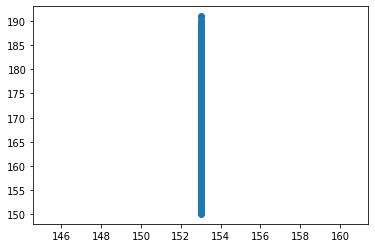

In [35]:
def test_match(t1="England",t2="India"):
    pss=[]
    rss=[]
    stds=[]
    a=match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].match_id.values[0]#[match_data.team_2==t2]
    date_a=match_data[match_data.team_1==t1][match_data.team_2==t2].start_date.values[0]
    s1=match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].score_1.values
    print(a,s1)
    sai=pd.DataFrame()
    bai=pd.DataFrame()
    for c in ["balls_remain", "wickets_remain", "rr", "sr", "w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
        sai[c]=[np.nan for i in range(11)]
    for c in ["e_r_career","extras_bowler"]:
        bai[c]=[np.nan for i in range(11)]
    ind=[i for i in range(8)]
    per=multiset_permutations(ind)
    for p in per:
        p=p+[8,9,10]
        for c in ["w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
            u=g[g.match_id==a][g.innings==1][c].unique()
            sai[c].iloc[:len(u)]=u
            sai[c].fillna(np.nanmean(sai[c]),inplace=True)
        for c in ["e_r_career","extras_bowler"]:
            u=g[g.match_id==a][g.innings==1][c].unique()
            bai[c].iloc[:len(u)]=u
            bai[c].fillna(np.nanmean(bai[c]),inplace=True)
        saii=sai.reindex(p)
        print(p)
        print(saii)
        try:
            res=team_test(bai,saii,num_iter=500)
            ps=np.mean(res)
            std=np.std(res)
            pss.append(ps)
            rss.append(s1[0])
            stds.append(std)
            #plt.hist(res)
            #plt.show()
        except:
            pss.append(0)
            stds.append(0)
            continue
    plt.scatter(rss,pss)
    #plt.xlim([100, 250])
    #plt.ylim([100, 250])
    plt.show()
    return rss,pss
rss,pss=test_match()

In [37]:
#np.save("pss",pss)
t1="England"
t2="India"
print(match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].match_id.values[0])
ind=[i for i in range(8)]
per=np.array(list(multiset_permutations(ind)))
per[list(np.argsort(pss))]

356010


array([[3, 0, 7, ..., 4, 6, 5],
       [0, 3, 7, ..., 4, 5, 6],
       [4, 0, 7, ..., 2, 5, 6],
       ...,
       [5, 2, 4, ..., 3, 7, 1],
       [1, 5, 6, ..., 0, 3, 7],
       [6, 2, 5, ..., 3, 0, 7]])

In [ ]:
def test_match(t1="England",t2="Netherlands"):
    pss=[]
    rss=[]
    stds=[]
    a=match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].match_id.values[0]#[match_data.team_2==t2]
    date_a=match_data[match_data.team_1==t1][match_data.team_2==t2].start_date.values[0]
    s1=match_data[match_data.team_1.isin([t1])][match_data.team_2==t2].score_1.values
    print(a,s1)
    sai=pd.DataFrame()
    bai=pd.DataFrame()
    for c in ["balls_remain", "wickets_remain", "rr", "sr", "w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
        sai[c]=[np.nan for i in range(11)]
    for c in ["e_r_career","extras_bowler"]:
        bai[c]=[np.nan for i in range(11)]
    ind=[i for i in range(8)]
    per=multiset_permutations(ind)
    for p in per:
        p=p+[8,9,10]
        for c in ["w_b",'s_r_career',"striker_performance","extras_striker","Av_career"]:
            u=g[g.match_id==a][g.innings==1][c].unique()
            sai[c].iloc[:len(u)]=u
            sai[c].fillna(np.nanmean(sai[c]),inplace=True)
        for c in ["e_r_career","extras_bowler"]:
            u=g[g.match_id==a][g.innings==1][c].unique()
            bai[c].iloc[:len(u)]=u
            bai[c].fillna(np.nanmean(bai[c]),inplace=True)
        saii=sai.reindex(p)
        print(p)
        #print(saii)
        try:
            res=team_test(bai,saii,num_iter=500)
            ps=np.mean(res)
            std=np.std(res)
            pss.append(ps)
            rss.append(s1[0])
            stds.append(std)
            #plt.hist(res)
            #plt.show()
        except:
            pss.append(0)
            stds.append(0)
            continue
    plt.scatter(rss,pss)
    #plt.xlim([100, 250])
    #plt.ylim([100, 250])
    plt.show()
    return rss,pss
rss,pss=test_match()